### Run below block to set up for training/testing

In [5]:
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
import gym
import os
import torch
import stable_baselines3
from stable_baselines3 import PPO
from matplotlib import pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

# a class for tracking and saving the model at various training intervals
# inspired by code from [3]
class ModelTrainer(BaseCallback):
    def __init__(self, verbose=1):
        super(ModelTrainer, self).__init__(verbose)
        self.save_path = './models'
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    # Stores a copy of the model in 'models' folder at significant intervals of training instances
    def _on_step(self):
        # every 100000 iterations
        if self.n_calls % 100000 == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True  

# create the initial environment
env = gym.make('SuperMarioBros-1-1-v0')
# simplify mario's movement options
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# convert rgb frames into grayscale, greatly reducing data complexity of frames processed by the model
env = GrayScaleObservation(env, keep_dim=True)
# dummy environment and frame stacking for movement vectors of objects within the environment
env = DummyVecEnv([lambda: env])
# stack the frames such that a direction can be established for mario's movement (a movement vector)
env = VecFrameStack(env, 4, channels_order='last')

# modifies what we receive as a log from training the model 
callback = ModelTrainer()
model = PPO('CnnPolicy', env, verbose=1, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


### Run the below block to begin training

In [2]:
# begins training of the model for 5 million timesteps
model = model.learn(total_timesteps=5000000, callback=callback)

KeyboardInterrupt: 

### Run the below block to load a model at a particular timestep of training and test it with visualisation

In [7]:
model1000 = PPO.load('./models/best_model_1400000')

# Start the game 
state = env.reset()
# Loop through the game

# store performance metrics from the game
coords = []
# format world, stage, distance
maxx = [0, 0, 0]

for step in range(100000):
    
    action, _ = model1000.predict(state)
    state, reward, done, info = env.step(action)
    
    ''' this code was for debug and visualisation seen in figures of the report'''
    # if mario has beat his best x score in the level or moved onto the next one
    #if info[0]['x_pos'] > maxx[2] and info[0]['stage'] >= maxx[1] and info[0]['world'] >= maxx[0]:
    #    maxx[2] = info[0]['x_pos']
    #    maxx[1] = info[0]['stage']
    #    maxx[0] = info[0]['world']

    # store mario coords to show areas where he gets stuck or dies
    #if len(coords) == 0:
    #    coords.append([info[0]['x_pos'], info[0]['y_pos']])
    #    continue
    #elif [info[0]['x_pos'], info[0]['y_pos']] not in coords:
    #    coords.append([info[0]['x_pos'], info[0]['y_pos']])
    #if info[0]['flag_get']:
    #    break
    
    env.render()
    
print("max x dist (w, s, d): " + str(maxx))
    

KeyboardInterrupt: 

### Below code was used to generate debug and visualisation

In [14]:
# gather the performance of each model (every 500000 iterations) by running them and tracking
# models will be ran for 20000 iterations each
#1 max distance to the right (store world level, max x coord)
#2 number of deaths
#3 a heatmap of marios x coords showing where he gets stuck usually (x,y)
#4 store the time it took him to get to this max dist
i = 200000
index = 0
mariocoords = [] 
ndeaths = []
mariomaxx = [] 
while i < 5000001:
    # change the filepath to the next model
    filepath = './models/best_model_' + str(i)
    # load the model using the new path
    model = PPO.load(filepath)
    
    # store performance metrics from the game
    coords = []
    # format world, stage, distance
    maxx = [0, 0]
    ndeath = 0
    lastlife = 2

    # Start the game 
    state = env.reset()
    # Loop through the game
    for step in range(15000): 

        action, _ = model.predict(state)
        # record the last integer value for marios life
        state, reward, done, info = env.step(action)
        # if a change is detected in the number of marios lives he has died
        if lastlife != info[0]["life"]:
            ndeath += 1
    
        # if mario has beat his best x score in the level or moved onto the next one
        if info[0]['stage'] > maxx[0]:
            maxx[0] = info[0]['stage']
            maxx[1] = 0
            
        elif info[0]['x_pos'] > maxx[1] and info[0]['stage'] == maxx[0]:
            maxx[1] = info[0]['x_pos']
        
        # store mario coords to show areas where he gets stuck or dies
        coords.append(info[0]['x_pos'])
        
        lastlife = info[0]['life']
        env.render()

    # count the number of times mario dies in 20000 iterations
    ndeaths.append(ndeath)
    mariomaxx.append(maxx)
    mariocoords.append(coords)
    
    print("MODEL " + str(i) + ":")
    print("deaths: " + str(ndeath))
    print("max x dist (s, d): " + str(maxx))
    i += 200000
    index += 1

env.close()

MODEL 200000:
deaths: 5
max x dist (s, d): [1, 723]
MODEL 400000:
deaths: 53
max x dist (s, d): [1, 1958]
MODEL 600000:
deaths: 56
max x dist (s, d): [1, 2469]
MODEL 800000:
deaths: 37
max x dist (s, d): [1, 1802]
MODEL 1000000:
deaths: 40
max x dist (s, d): [1, 1437]
MODEL 1200000:
deaths: 42
max x dist (s, d): [1, 1799]
MODEL 1400000:
deaths: 32
max x dist (s, d): [2, 890]
MODEL 1600000:
deaths: 45
max x dist (s, d): [1, 2473]
MODEL 1800000:
deaths: 44
max x dist (s, d): [1, 2474]
MODEL 2000000:
deaths: 46
max x dist (s, d): [1, 1527]
MODEL 2200000:
deaths: 33
max x dist (s, d): [1, 2470]
MODEL 2400000:
deaths: 32
max x dist (s, d): [1, 1523]
MODEL 2600000:
deaths: 57
max x dist (s, d): [1, 1440]
MODEL 2800000:
deaths: 56
max x dist (s, d): [1, 1796]
MODEL 3000000:
deaths: 53
max x dist (s, d): [1, 1519]
MODEL 3200000:
deaths: 41
max x dist (s, d): [1, 1797]
MODEL 3400000:
deaths: 34
max x dist (s, d): [1, 1677]
MODEL 3600000:
deaths: 48
max x dist (s, d): [1, 1958]
MODEL 3800000:
de

KeyboardInterrupt: 

21
21


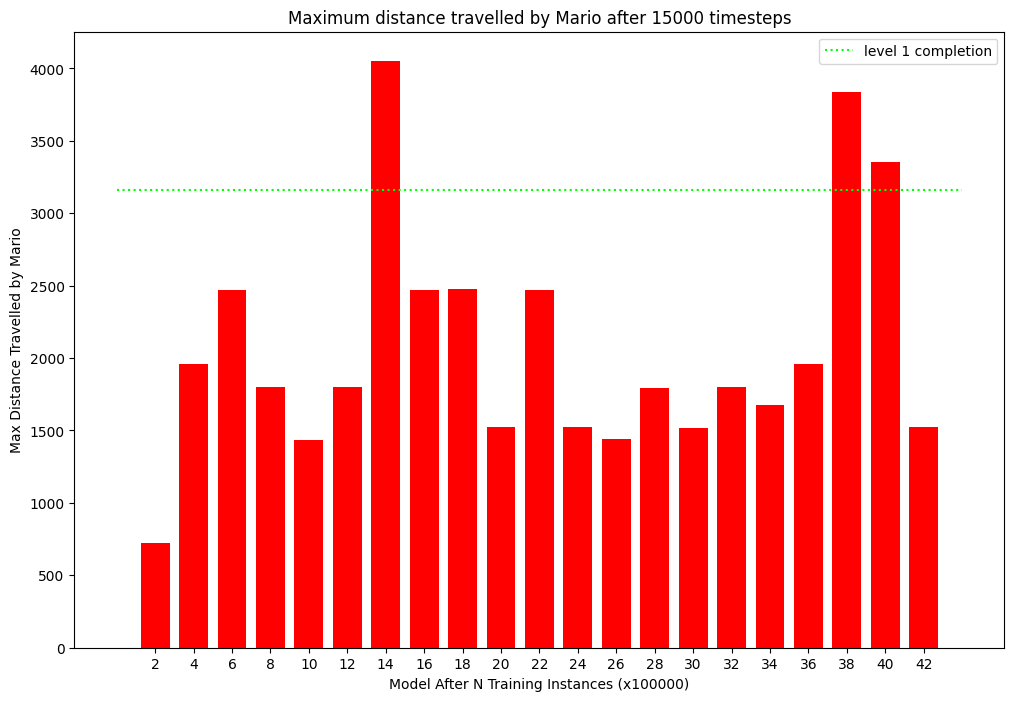

In [32]:
import numpy as np
import matplotlib.pyplot as plt

''' using values taken from above we can plot the (interestingly nonlinear) effect training length has on performance'''

distances = [723, 1958, 2469, 1802, 1437, 1799, 3161+890, 2473, 2474, 1527, 2470, 1523, 1440, 1796, 1519, 1797, 1677, 1958, 3161+677, 3161+194, 1526]
model_number = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42]

print(len(distances))
print(len(model_number))

plt.figure(figsize=(12,8))
plt.bar(model_number, distances, width=1.5, color='red')
plt.plot((0,44),(3161,3161), c='lime', label='level 1 completion', linestyle='dotted')
plt.legend()
plt.xticks(model_number)
plt.title('Maximum distance travelled by Mario after 15000 timesteps')
plt.xlabel('Model After N Training Instances (x100000)')
plt.ylabel('Max Distance Travelled by Mario')
plt.show()

In [49]:
# gather the performance of each model (every 500000 iterations) by running them and tracking
# models will be ran for 20000 iterations each
#1 max distance to the right (store world level, max x coord)
#2 number of deaths
#3 a heatmap of marios x coords showing where he gets stuck usually (x,y)
#4 store the time it took him to get to this max dist
i = 1
index = 0
mariomaxx = [] 
''' test the model on the first four levels'''
while i < 5:
    
    envstring = 'SuperMarioBros-1-' + str(i) + '-v3'
    env = gym.make(envstring)
    # simplify mario's movement options
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    # convert rgb frames into grayscale, greatly reducing data complexity of frames processed by the model
    env = GrayScaleObservation(env, keep_dim=True)
    # dummy environment and frame stacking for movement vectors of objects within the environment
    env = DummyVecEnv([lambda: env])
    # stack the frames such that a direction can be established for mario's movement (a movement vector)
    env = VecFrameStack(env, 4, channels_order='last')
    model = PPO.load('./models/best_model_20000')
    state = env.reset()

    # format world, stage, distance
    maxx = [0, 0]
    ndeath = 0
    
    for step in range(15000): 

        action, _ = model.predict(state)
        # record the last integer value for marios life
        state, reward, done, info = env.step(action)
        # if a change is detected in the number of marios lives he has died

        # if mario has beat his best x score in the level or moved onto the next one
        if info[0]['stage'] > maxx[0]:
            maxx[0] = info[0]['stage']
            maxx[1] = 0
            
        elif info[0]['x_pos'] > maxx[1] and info[0]['stage'] == maxx[0]:
            maxx[1] = info[0]['x_pos']
        
        lastlife = info[0]['life']
        env.render()

    # count the number of times mario dies in 20000 iterations
    ndeaths.append(ndeath)
    mariomaxx.append(maxx)
    
    print("MODEL " + str(i) + ":")
    print("max x dist (s, d): " + str(maxx))
    i += 1
env.close()

C:\Users\calsp\anaconda3\envs\marioai\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\calsp\anaconda3\envs\marioai\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\calsp\anaconda3\envs\marioai\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MODEL 1:
max x dist (s, d): [1, 595]
MODEL 2:
max x dist (s, d): [2, 355]
MODEL 3:
max x dist (s, d): [3, 444]
MODEL 4:
max x dist (s, d): [4, 552]


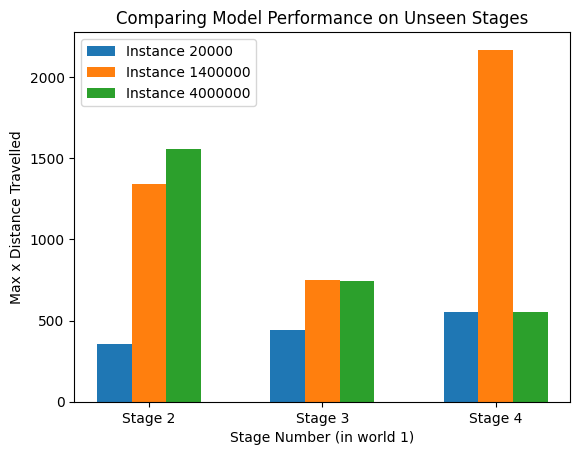

In [54]:
X = ['Stage 2','Stage 3','Stage 4']
mControl = [355, 444, 552]
m14 = [1339, 748, 2169]
m40 = [1557, 742, 553]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, mControl, 0.2, label = 'Instance 20000')
plt.bar(X_axis, m14, 0.2, label='Instance 1400000')
plt.bar(X_axis + 0.2, m40, 0.2, label = 'Instance 4000000')
  
plt.xticks(X_axis, X)
plt.xlabel("Stage Number (in world 1)")
plt.ylabel("Max x Distance Travelled")
plt.title("Comparing Model Performance on Unseen Stages")
plt.legend()
plt.show()
plt.show()

In [2]:
coords = [[40, 79], [40, 83], [40, 87], [40, 91], [40, 95], [40, 98], [40, 102], [41, 105], [41, 108], [41, 111], [42, 114], [42, 116], [42, 117], [43, 119], [44, 120], [45, 120], [45, 119], [46, 118], [47, 117], [47, 115], [48, 113], [49, 110], [50, 107], [51, 103], [52, 99], [53, 95], [54, 91], [55, 87], [56, 83], [57, 79], [58, 79], [59, 79], [61, 79], [62, 79], [63, 79], [65, 79], [66, 79], [68, 79], [70, 79], [71, 79], [73, 79], [75, 79], [77, 79], [78, 79], [80, 79], [82, 79], [84, 79], [87, 79], [89, 79], [91, 79], [93, 79], [96, 79], [98, 79], [101, 79], [103, 79], [106, 79], [108, 79], [111, 79], [113, 79], [116, 79], [118, 79], [121, 79], [123, 79], [126, 79], [128, 79], [131, 79], [133, 79], [136, 79], [138, 79], [141, 79], [143, 79], [146, 79], [148, 79], [151, 79], [153, 79], [156, 79], [158, 79], [161, 79], [163, 79], [166, 79], [168, 79], [171, 79], [173, 79], [176, 79], [178, 79], [181, 79], [183, 79], [186, 79], [188, 79], [191, 79], [193, 79], [196, 79], [198, 79], [201, 79], [203, 79], [206, 79], [208, 79], [211, 79], [213, 79], [216, 79], [218, 79], [221, 79], [223, 84], [226, 89], [228, 94], [231, 99], [233, 103], [236, 107], [238, 111], [241, 115], [243, 119], [245, 122], [244, 126], [243, 129], [242, 132], [242, 135], [242, 138], [242, 141], [242, 143], [242, 146], [242, 148], [243, 150], [243, 152], [243, 153], [244, 155], [244, 156], [245, 158], [245, 159], [246, 160], [247, 160], [248, 161], [248, 162], [249, 162], [250, 162], [251, 161], [252, 159], [253, 157], [254, 155], [256, 152], [257, 148], [258, 144], [259, 143], [261, 143], [262, 143], [264, 143], [265, 143], [267, 148], [268, 153], [270, 158], [272, 163], [274, 167], [276, 171], [277, 175], [279, 179], [282, 183], [284, 186], [286, 190], [288, 193], [290, 196], [293, 199], [295, 202], [297, 205], [300, 207], [302, 208], [305, 209], [307, 210], [310, 210], [312, 209], [315, 208], [317, 206], [320, 203], [322, 200], [325, 197], [327, 193], [330, 189], [332, 185], [335, 181], [337, 177], [340, 173], [342, 169], [345, 165], [347, 161], [350, 157], [352, 153], [355, 149], [357, 145], [360, 143], [362, 143], [365, 143], [367, 143], [370, 143], [372, 143], [375, 143], [377, 143], [380, 143], [382, 143], [385, 143], [387, 143], [390, 143], [392, 143], [395, 143], [397, 143], [400, 143], [402, 142], [405, 141], [407, 139], [410, 137], [412, 134], [415, 131], [417, 127], [420, 123], [422, 119], [425, 115], [427, 111], [430, 107], [432, 103], [434, 99], [434, 95], [434, 91], [434, 87], [434, 83], [434, 79], [434, 98], [434, 102], [434, 105], [435, 108], [435, 111], [435, 114], [436, 117], [436, 119], [436, 122], [437, 124], [437, 126], [438, 128], [438, 130], [439, 132], [440, 134], [440, 136], [441, 137], [442, 138], [443, 138], [444, 138], [445, 137], [445, 136], [446, 135], [447, 133], [448, 131], [450, 128], [451, 125], [452, 121], [453, 117], [454, 113], [455, 111], [457, 111], [458, 115], [459, 119], [461, 123], [462, 127], [464, 130], [465, 134], [467, 137], [468, 140], [470, 143], [471, 146], [473, 149], [474, 152], [476, 154], [477, 157], [479, 159], [480, 161], [482, 163], [483, 165], [485, 166], [486, 167], [488, 167], [489, 167], [491, 167], [492, 166], [494, 165], [495, 163], [497, 161], [498, 159], [500, 156], [501, 153], [503, 150], [504, 146], [506, 142], [507, 138], [509, 134], [510, 130], [512, 125], [513, 121], [515, 117], [516, 113], [518, 109], [519, 105], [521, 100], [522, 96], [524, 92], [525, 88], [527, 84], [528, 80], [530, 79], [531, 79], [533, 79], [535, 79], [536, 79], [538, 79], [540, 79], [542, 84], [544, 89], [546, 94], [548, 99], [550, 103], [552, 107], [554, 111], [556, 115], [559, 119], [561, 122], [564, 126], [566, 129], [569, 132], [571, 135], [574, 138], [576, 140], [579, 141], [581, 142], [584, 142], [586, 141], [589, 140], [591, 139], [594, 137], [596, 134], [599, 131], [601, 127], [604, 127], [606, 127], [609, 127], [611, 127], [614, 127], [616, 127], [619, 127], [621, 127], [624, 127], [626, 132], [629, 137], [631, 142], [634, 147], [636, 151], [639, 155], [641, 159], [644, 163], [646, 167], [649, 170], [651, 173], [654, 176], [656, 178], [659, 179], [661, 180], [664, 180], [666, 180], [669, 179], [671, 177], [674, 175], [676, 173], [679, 170], [681, 166], [684, 162], [686, 158], [689, 154], [691, 150], [694, 146], [696, 142], [699, 138], [701, 134], [704, 130], [706, 126], [709, 122], [711, 118], [714, 114], [716, 110], [719, 106], [721, 102], [723, 98], [722, 94], [722, 90], [722, 86], [722, 82], [722, 79], [722, 83], [722, 87], [722, 91], [722, 95], [722, 98], [722, 101], [722, 103], [722, 105], [722, 106], [722, 107], [722, 108], [722, 104], [722, 102], [722, 100], [722, 97], [722, 93], [722, 89], [722, 96], [722, 99], [722, 111], [722, 114], [722, 117], [722, 119], [722, 122], [722, 124], [722, 126], [722, 128], [722, 130], [722, 132], [722, 134], [722, 135], [722, 133], [722, 127], [722, 121], [722, 113], [722, 109], [722, 92], [722, 116], [722, 118], [722, 120], [722, 88], [722, 115], [722, 84], [722, 80], [722, 136], [723, 137], [723, 139], [723, 140], [724, 141], [724, 142], [724, 143], [725, 144], [726, 145], [727, 145], [728, 145], [729, 145], [730, 144], [731, 143], [732, 143], [733, 147], [733, 151], [734, 155], [735, 159], [736, 162], [737, 166], [739, 169], [740, 171], [741, 173], [742, 175], [743, 176], [745, 177], [746, 177], [747, 177], [749, 176], [750, 175], [752, 174], [753, 172], [755, 170], [756, 167], [758, 164], [759, 160], [761, 156], [762, 152], [764, 148], [765, 144], [767, 139], [768, 135], [770, 131], [771, 127], [773, 122], [774, 118], [776, 114], [777, 110], [779, 105], [780, 101], [782, 97], [783, 93], [785, 89], [786, 85], [788, 80], [789, 79], [791, 79], [792, 79], [794, 79], [796, 79], [798, 79], [799, 79], [801, 79], [803, 84], [805, 89], [807, 94], [810, 99], [812, 103], [814, 107], [816, 111], [819, 115], [821, 119], [824, 122], [826, 125], [829, 127], [831, 128], [834, 129], [836, 130], [839, 129], [841, 129], [844, 127], [846, 125], [849, 123], [851, 120], [854, 116], [856, 112], [859, 108], [861, 104], [864, 100], [866, 96], [869, 92], [871, 88], [874, 84], [876, 88], [879, 92], [881, 95], [884, 97], [886, 99], [889, 100], [891, 100], [894, 101], [896, 100], [898, 99], [898, 97], [898, 95], [898, 92], [898, 89], [898, 85], [898, 81], [898, 79], [898, 83], [898, 87], [898, 91], [898, 98], [898, 102], [898, 105], [898, 108], [898, 111], [898, 114], [898, 117], [898, 119], [898, 122], [898, 124], [898, 126], [898, 128], [898, 130], [898, 132], [898, 134], [898, 136], [898, 137], [898, 139], [898, 140], [898, 141], [898, 142], [898, 143], [899, 144], [899, 145], [900, 145], [901, 145], [902, 145], [902, 144], [903, 143], [904, 143], [905, 143], [906, 143], [907, 143], [908, 143], [909, 143], [910, 143], [911, 143], [912, 143], [913, 143], [915, 143], [916, 143], [917, 143], [919, 143], [920, 143], [922, 143], [923, 143], [925, 143], [927, 143], [929, 143], [930, 143], [932, 143], [934, 143], [936, 143], [938, 143], [940, 143], [943, 143], [945, 143], [947, 142], [949, 142], [952, 140], [954, 138], [957, 136], [959, 134], [962, 131], [964, 127], [967, 123], [969, 119], [972, 115], [974, 110], [977, 106], [979, 102], [982, 98], [984, 93], [987, 89], [989, 85], [992, 81], [994, 79], [997, 79], [999, 79], [1002, 79], [1004, 79], [1007, 79], [1009, 79], [1012, 79], [1014, 79], [1017, 79], [1019, 79], [1022, 79], [1024, 79], [1027, 79], [1029, 79], [1032, 84], [1034, 89], [1037, 94], [1039, 99], [1042, 103], [1044, 107], [1047, 111], [1049, 115], [1052, 119], [1054, 122], [1057, 126], [1059, 129], [1062, 132], [1064, 135], [1067, 137], [1069, 138], [1072, 139], [1074, 139], [1077, 139], [1079, 138], [1082, 137], [1084, 135], [1087, 133], [1089, 130], [1092, 126], [1094, 122], [1097, 118], [1099, 114], [1102, 110], [1104, 106], [1107, 102], [1109, 98], [1112, 94], [1114, 90], [1117, 86], [1119, 82], [1122, 78], [1123, 74], [1122, 70], [1122, 66], [1122, 62], [1122, 58], [1122, 54], [1122, 50], [1122, 46], [1122, 42], [1122, 38], [1122, 34], [1122, 30], [1122, 26], [1123, 22], [1123, 18], [1123, 14], [1124, 10], [1124, 6], [1125, 2], [1126, 254], [42, 119], [43, 122], [43, 124], [44, 126], [45, 128], [45, 130], [46, 131], [47, 132], [47, 133], [48, 133], [49, 132], [50, 131], [51, 130], [52, 128], [53, 126], [54, 123], [55, 120], [56, 116], [57, 112], [58, 108], [59, 104], [61, 99], [62, 95], [63, 91], [64, 87], [66, 83], [67, 79], [69, 79], [72, 79], [79, 79], [81, 79], [83, 79], [85, 79], [95, 79], [97, 79], [100, 79], [102, 79], [105, 79], [107, 79], [110, 79], [112, 79], [115, 79], [117, 79], [120, 79], [122, 79], [125, 79], [127, 79], [130, 79], [132, 79], [135, 79], [137, 79], [140, 79], [142, 84], [145, 89], [147, 94], [150, 99], [152, 103], [155, 107], [157, 111], [160, 115], [162, 119], [165, 122], [167, 126], [170, 129], [172, 131], [175, 133], [177, 134], [180, 135], [182, 135], [185, 134], [187, 133], [190, 132], [192, 129], [195, 127], [197, 123], [200, 119], [202, 115], [205, 110], [207, 106], [210, 102], [212, 98], [215, 94], [217, 90], [220, 86], [222, 82], [225, 79], [226, 79], [228, 83], [229, 87], [231, 91], [232, 95], [234, 98], [235, 102], [237, 105], [238, 107], [240, 110], [241, 112], [243, 113], [244, 114], [246, 115], [247, 116], [249, 116], [250, 115], [252, 115], [253, 113], [255, 112], [256, 110], [258, 108], [259, 105], [261, 102], [262, 99], [264, 95], [265, 91], [267, 87], [268, 83], [270, 79], [271, 79], [273, 79], [275, 79], [276, 79], [278, 79], [280, 79], [282, 79], [284, 79], [286, 79], [288, 84], [290, 89], [292, 94], [294, 99], [296, 103], [299, 107], [301, 111], [303, 115], [306, 119], [307, 122], [306, 126], [306, 129], [306, 132], [306, 135], [306, 138], [306, 141], [306, 143], [306, 144], [306, 145], [306, 146], [307, 146], [307, 145], [308, 144], [308, 143], [309, 143], [310, 143], [311, 143], [312, 143], [313, 143], [314, 143], [315, 143], [316, 147], [317, 151], [318, 155], [319, 159], [320, 162], [321, 166], [323, 169], [324, 171], [325, 174], [327, 176], [328, 177], [329, 178], [331, 179], [332, 180], [334, 180], [335, 179], [337, 179], [338, 177], [340, 176], [341, 174], [343, 172], [344, 169], [346, 166], [347, 163], [349, 159], [350, 155], [352, 151], [353, 147], [355, 143], [356, 143], [358, 143], [361, 143], [363, 143], [369, 143], [371, 143], [373, 143], [379, 143], [381, 143], [384, 143], [386, 143], [389, 143], [391, 143], [394, 143], [396, 148], [399, 153], [401, 158], [404, 162], [406, 166], [409, 169], [411, 171], [414, 173], [416, 174], [419, 175], [421, 175], [424, 175], [426, 174], [429, 172], [431, 170], [434, 168], [436, 165], [439, 161], [441, 157], [444, 153], [446, 149], [449, 145], [451, 141], [454, 137], [456, 133], [459, 129], [461, 125], [464, 121], [466, 117], [469, 113], [471, 111], [474, 111], [476, 111], [479, 111], [481, 111], [484, 110], [486, 109], [489, 107], [491, 105], [494, 102], [496, 99], [499, 95], [501, 91], [504, 87], [506, 83], [509, 79], [511, 84], [514, 89], [516, 94], [519, 99], [521, 103], [524, 107], [526, 111], [529, 115], [531, 119], [534, 122], [536, 125], [539, 128], [541, 130], [544, 131], [546, 132], [549, 132], [551, 132], [554, 131], [556, 129], [559, 127], [561, 125], [564, 122], [566, 118], [569, 114], [571, 110], [574, 106], [576, 102], [579, 98], [581, 94], [584, 90], [586, 86], [589, 82], [591, 79], [593, 79], [594, 83], [595, 87], [594, 91], [594, 95], [594, 98], [594, 102], [594, 105], [594, 108], [594, 111], [594, 114], [594, 117], [594, 120], [594, 122], [594, 125], [594, 127], [594, 129], [595, 131], [595, 133], [595, 134], [596, 135], [597, 135], [598, 134], [599, 133], [600, 129], [602, 127], [603, 127], [604, 131], [605, 135], [606, 139], [607, 143], [608, 146], [609, 150], [610, 153], [612, 156], [613, 159], [614, 162], [616, 165], [617, 167], [618, 170], [620, 172], [621, 174], [623, 176], [624, 178], [626, 180], [627, 182], [629, 184], [630, 185], [632, 186], [633, 186], [635, 186], [636, 185], [638, 184], [639, 183], [641, 181], [642, 179], [644, 176], [645, 173], [647, 169], [648, 165], [650, 161], [651, 157], [653, 153], [654, 148], [656, 144], [657, 140], [659, 136], [660, 131], [662, 127], [663, 123], [665, 119], [666, 114], [668, 110], [669, 106], [671, 102], [672, 98], [674, 94], [675, 89], [677, 85], [678, 81], [680, 79], [681, 79], [683, 79], [685, 79], [686, 79], [688, 79], [690, 79], [692, 79], [694, 79], [696, 79], [698, 79], [700, 79], [702, 79], [704, 79], [707, 79], [46, 132], [47, 134], [47, 136], [48, 137], [49, 139], [50, 140], [51, 141], [52, 142], [53, 143], [54, 144], [55, 144], [56, 145], [57, 145], [58, 145], [59, 145], [61, 145], [62, 145], [63, 144], [64, 143], [66, 141], [67, 139], [69, 136], [70, 133], [72, 130], [73, 126], [75, 121], [76, 117], [78, 113], [79, 109], [81, 105], [82, 101], [84, 96], [85, 92], [87, 88], [88, 84], [90, 79], [94, 79], [105, 84], [107, 89], [110, 94], [112, 99], [114, 103], [116, 107], [118, 111], [121, 115], [123, 119], [126, 122], [128, 126], [131, 129], [133, 132], [136, 135], [138, 138], [141, 141], [143, 143], [146, 146], [148, 148], [151, 150], [153, 152], [156, 153], [158, 155], [161, 156], [163, 158], [166, 159], [168, 160], [171, 160], [173, 161], [176, 161], [178, 161], [181, 160], [183, 158], [186, 156], [188, 153], [191, 150], [193, 146], [196, 141], [198, 136], [201, 132], [203, 128], [206, 124], [208, 120], [211, 116], [213, 112], [216, 108], [218, 104], [221, 100], [223, 96], [226, 92], [228, 88], [231, 84], [233, 80], [236, 79], [238, 79], [241, 79], [243, 79], [246, 79], [248, 79], [251, 79], [253, 79], [256, 79], [258, 84], [261, 89], [263, 94], [266, 99], [268, 103], [271, 107], [273, 110], [276, 113], [278, 115], [281, 116], [283, 117], [286, 118], [288, 118], [291, 117], [293, 116], [296, 114], [298, 112], [301, 109], [303, 105], [306, 101], [308, 97], [311, 93], [313, 89], [316, 85], [318, 89], [321, 92], [323, 95], [326, 98], [328, 99], [331, 101], [333, 101], [336, 101], [338, 101], [341, 100], [343, 98], [346, 96], [348, 93], [351, 90], [353, 86], [356, 82], [358, 79], [361, 79], [363, 79], [366, 79], [368, 79], [371, 79], [373, 79], [376, 79], [378, 79], [381, 79], [383, 84], [386, 89], [388, 94], [391, 99], [393, 103], [396, 107], [398, 111], [401, 115], [403, 119], [406, 122], [408, 126], [411, 129], [413, 131], [416, 133], [418, 134], [421, 135], [423, 135], [426, 134], [428, 133], [431, 132], [433, 129], [436, 127], [438, 123], [441, 119], [443, 115], [446, 111], [448, 116], [451, 121], [453, 126], [456, 131], [458, 135], [461, 139], [463, 143], [466, 147], [468, 150], [471, 153], [473, 155], [476, 157], [478, 158], [481, 159], [483, 159], [486, 158], [488, 157], [491, 155], [493, 153], [496, 150], [498, 147], [501, 143], [503, 139], [506, 135], [508, 131], [511, 127], [513, 123], [516, 119], [518, 115], [521, 111], [523, 107], [526, 103], [528, 99], [531, 95], [533, 91], [536, 87], [538, 83], [541, 79], [543, 79], [546, 79], [548, 79], [551, 79], [553, 79], [556, 79], [558, 79], [561, 79], [563, 79], [566, 79], [568, 79], [571, 79], [573, 79], [576, 79], [578, 79], [581, 79], [583, 79], [586, 79], [588, 79], [595, 79], [594, 79], [594, 87], [594, 119], [595, 122], [595, 124], [595, 126], [596, 128], [596, 130], [597, 132], [597, 134], [598, 136], [598, 137], [599, 139], [600, 140], [601, 141], [601, 142], [602, 143], [603, 144], [604, 144], [605, 145], [607, 145], [608, 145], [609, 145], [610, 145], [611, 145], [613, 144], [614, 143], [616, 141], [617, 139], [619, 136], [620, 133], [622, 130], [623, 127], [625, 131], [626, 135], [628, 139], [629, 143], [631, 146], [632, 150], [634, 153], [635, 156], [637, 159], [638, 162], [640, 165], [641, 168], [643, 170], [644, 173], [646, 175], [647, 177], [649, 180], [650, 182], [652, 183], [653, 185], [655, 186], [656, 187], [658, 187], [659, 187], [661, 187], [662, 186], [664, 185], [665, 184], [667, 182], [668, 180], [670, 177], [671, 174], [673, 171], [674, 167], [676, 163], [677, 158], [679, 154], [680, 150], [682, 146], [683, 141], [685, 137], [686, 133], [688, 129], [689, 125], [691, 121], [692, 116], [694, 112], [695, 108], [697, 104], [698, 100], [700, 96], [701, 91], [703, 87], [704, 83], [706, 79], [41, 110], [42, 112], [42, 113], [42, 115], [43, 115], [44, 115], [45, 114], [45, 113], [46, 112], [47, 110], [47, 107], [48, 104], [49, 101], [50, 97], [51, 93], [52, 89], [53, 85], [54, 81], [55, 79], [56, 79], [60, 79], [64, 79], [87, 84], [90, 89], [92, 94], [94, 99], [97, 103], [99, 107], [102, 111], [104, 115], [107, 119], [109, 122], [112, 126], [114, 129], [117, 132], [119, 135], [122, 138], [124, 141], [127, 143], [129, 145], [132, 147], [134, 147], [137, 148], [139, 147], [142, 146], [144, 145], [147, 143], [149, 140], [152, 137], [154, 134], [157, 129], [159, 125], [162, 121], [164, 117], [167, 113], [169, 109], [172, 105], [174, 101], [177, 97], [179, 93], [182, 89], [184, 85], [187, 81], [189, 79], [192, 79], [194, 79], [197, 79], [199, 79], [202, 79], [204, 79], [207, 79], [209, 79], [212, 79], [214, 79], [217, 79], [219, 79], [222, 79], [224, 79], [227, 79], [229, 79], [232, 79], [234, 84], [237, 89], [239, 94], [242, 99], [244, 103], [247, 107], [249, 111], [254, 115], [257, 114], [259, 113], [262, 111], [264, 108], [267, 105], [269, 102], [272, 97], [274, 93], [277, 89], [279, 85], [282, 81], [287, 79], [289, 79], [292, 79], [294, 79], [297, 79], [299, 84], [302, 89], [304, 94], [307, 99], [309, 103], [312, 107], [314, 111], [317, 115], [319, 115], [322, 114], [324, 113], [327, 111], [329, 108], [332, 105], [334, 102], [337, 97], [339, 93], [342, 89], [344, 85], [347, 81], [349, 79], [352, 79], [354, 79], [357, 79], [359, 79], [362, 79], [364, 79], [367, 79], [369, 79], [372, 79], [374, 79], [377, 79], [379, 79], [382, 79], [384, 79], [387, 79], [389, 79], [392, 79], [394, 79], [397, 79], [399, 79], [402, 79], [404, 79], [407, 79], [409, 79], [412, 79], [414, 79], [417, 79], [419, 79], [422, 79], [424, 79], [427, 79], [429, 79], [432, 79], [436, 79], [435, 79], [434, 94], [434, 97], [434, 100], [434, 103], [434, 104], [434, 92], [434, 88], [434, 84], [434, 80], [434, 96], [434, 101], [434, 93], [434, 90], [434, 86], [434, 82], [434, 108], [434, 111], [435, 117], [435, 119], [436, 124], [437, 125], [437, 127], [438, 127], [439, 128], [440, 127], [440, 126], [441, 125], [442, 123], [443, 120], [444, 118], [444, 114], [445, 111], [447, 111], [448, 111], [450, 111], [451, 111], [452, 111], [453, 111], [456, 111], [458, 111], [459, 111], [461, 111], [462, 111], [464, 111], [466, 111], [468, 111], [470, 116], [471, 121], [473, 126], [476, 130], [478, 134], [480, 137], [482, 139], [484, 141], [486, 142], [489, 143], [491, 143], [494, 143], [496, 142], [499, 140], [501, 138], [504, 136], [506, 133], [509, 129], [511, 125], [514, 121], [516, 117], [519, 113], [521, 109], [524, 105], [526, 101], [529, 97], [531, 93], [534, 89], [536, 85], [539, 81], [544, 84], [546, 89], [549, 94], [551, 97], [554, 100], [556, 103], [559, 105], [561, 107], [564, 107], [566, 108], [569, 108], [571, 107], [574, 105], [576, 104], [579, 101], [581, 98], [584, 94], [586, 90], [589, 86], [591, 82], [594, 107], [594, 109], [594, 112], [594, 113], [594, 110], [594, 106], [594, 103], [594, 100], [594, 96], [594, 92], [594, 88], [594, 84], [594, 80], [594, 124], [594, 126], [594, 128], [594, 130], [595, 132], [595, 136], [596, 137], [596, 139], [596, 140], [597, 141], [597, 142], [598, 143], [599, 144], [600, 145], [601, 145], [601, 144], [602, 144], [603, 142], [604, 141], [605, 139], [606, 136], [606, 133], [607, 130], [608, 127], [610, 127], [612, 127], [613, 127], [617, 127], [620, 127], [622, 127], [625, 127], [627, 127], [629, 127], [631, 127], [633, 127], [635, 127], [637, 127], [639, 127], [641, 126], [643, 125], [645, 124], [648, 122], [650, 120], [652, 117], [655, 114], [657, 111], [660, 107], [662, 103], [665, 99], [667, 94], [670, 90], [672, 86], [675, 82], [677, 79], [679, 79], [680, 83], [682, 87], [683, 91], [685, 95], [686, 98], [688, 102], [689, 105], [691, 108], [692, 111], [694, 114], [695, 117], [697, 120], [698, 122], [700, 125], [701, 127], [703, 129], [704, 132], [706, 134], [707, 135], [709, 137], [710, 139], [712, 140], [713, 142], [715, 143], [716, 144], [718, 145], [719, 146], [721, 147], [722, 148], [724, 149], [725, 149], [727, 149], [728, 150], [730, 150], [731, 150], [733, 150], [734, 149], [736, 148], [737, 147], [739, 146], [740, 144], [742, 143], [743, 143], [745, 143], [747, 143], [748, 143], [750, 143], [752, 143], [754, 143], [756, 143], [758, 143], [760, 143], [762, 143], [764, 143], [766, 143], [768, 143], [771, 143], [773, 142], [775, 141], [778, 139], [780, 138], [783, 135], [785, 133], [788, 130], [790, 126], [793, 123], [795, 118], [798, 114], [800, 110], [803, 106], [805, 102], [808, 98], [810, 93], [813, 89], [815, 85], [818, 81], [820, 79], [823, 79], [825, 79], [828, 79], [830, 79], [833, 79], [835, 79], [838, 79], [840, 79], [843, 79], [845, 79], [848, 79], [850, 79], [853, 84], [855, 89], [858, 94], [860, 99], [863, 103], [865, 106], [868, 109], [870, 111], [873, 113], [875, 114], [878, 115], [880, 115], [883, 114], [885, 113], [888, 111], [890, 109], [893, 106], [895, 103], [899, 95], [898, 94], [898, 93], [898, 86], [898, 135], [898, 133], [898, 127], [898, 121], [898, 113], [898, 109], [898, 104], [898, 100], [898, 96], [898, 107], [898, 112], [898, 110], [898, 106], [898, 103], [898, 88], [898, 84], [898, 80], [898, 131], [898, 129], [898, 125], [898, 116], [898, 82], [114, 79], [211, 84], [213, 89], [216, 94], [218, 99], [221, 103], [223, 107], [226, 111], [228, 115], [231, 119], [233, 122], [236, 126], [238, 129], [241, 132], [243, 146], [243, 148], [244, 153], [245, 156], [246, 159], [251, 162], [252, 161], [253, 160], [255, 159], [256, 156], [257, 154], [258, 150], [259, 146], [267, 143], [268, 143], [270, 143], [272, 143], [274, 143], [275, 142], [277, 140], [279, 138], [281, 135], [283, 131], [285, 127], [288, 123], [290, 119], [292, 115], [295, 111], [297, 107], [299, 103], [302, 99], [304, 95], [307, 91], [309, 87], [312, 91], [314, 95], [317, 98], [319, 100], [322, 102], [324, 103], [327, 104], [329, 104], [332, 103], [337, 101], [339, 98], [342, 96], [344, 92], [347, 88], [349, 84], [434, 106], [434, 109], [434, 110], [435, 110], [435, 109], [436, 111], [436, 115], [437, 123], [438, 134], [439, 137], [440, 140], [440, 143], [441, 146], [442, 149], [443, 151], [444, 154], [444, 156], [445, 158], [446, 160], [447, 161], [448, 161], [449, 161], [450, 161], [452, 160], [453, 159], [454, 158], [455, 156], [457, 153], [458, 150], [459, 147], [461, 143], [462, 139], [464, 135], [465, 131], [467, 127], [468, 122], [470, 118], [471, 114], [473, 111], [477, 111], [481, 110], [483, 110], [485, 108], [487, 107], [489, 104], [491, 102], [493, 99], [495, 95], [497, 91], [500, 87], [502, 83], [504, 79], [507, 79], [512, 79], [514, 79], [517, 79], [519, 79], [522, 79], [524, 79], [527, 79], [529, 79], [532, 79], [534, 79], [537, 79], [539, 79], [542, 79], [544, 79], [547, 79], [549, 79], [552, 84], [554, 89], [557, 94], [559, 98], [562, 102], [564, 105], [567, 107], [569, 109], [572, 110], [574, 111], [577, 111], [579, 111], [582, 110], [584, 108], [587, 106], [589, 104], [592, 101], [594, 97], [596, 95], [595, 95], [594, 94], [594, 93], [594, 89], [594, 86], [594, 121], [594, 123], [595, 123], [595, 120], [594, 118], [594, 115], [594, 101], [594, 90], [594, 82], [594, 104], [594, 85], [594, 81], [595, 128], [596, 132], [598, 135], [599, 135], [600, 134], [600, 133], [601, 132], [602, 130], [605, 127], [607, 127], [615, 127], [618, 127], [626, 127], [628, 127], [630, 127], [632, 127], [634, 127], [636, 127], [638, 127], [640, 127], [643, 127], [645, 126], [647, 124], [650, 123], [652, 120], [655, 118], [657, 115], [660, 111], [662, 107], [665, 103], [667, 99], [670, 95], [672, 91], [675, 86], [677, 82], [682, 79], [687, 79], [695, 79], [697, 79], [702, 84], [705, 89], [707, 94], [710, 99], [712, 103], [715, 107], [717, 111], [720, 115], [724, 121], [723, 123], [722, 125], [722, 123], [725, 143], [726, 144], [730, 145], [732, 147], [738, 169], [739, 172], [740, 175], [741, 178], [743, 181], [744, 183], [745, 186], [747, 188], [748, 190], [749, 192], [751, 194], [752, 196], [754, 198], [755, 199], [757, 200], [758, 201], [760, 201], [761, 200], [763, 199], [764, 198], [766, 196], [767, 194], [769, 192], [770, 188], [772, 185], [773, 181], [775, 177], [776, 173], [778, 168], [779, 164], [781, 160], [782, 156], [784, 151], [785, 147], [787, 143], [788, 139], [790, 134], [791, 130], [793, 126], [794, 122], [796, 118], [797, 114], [799, 109], [800, 105], [802, 101], [803, 97], [805, 92], [806, 88], [808, 92], [809, 95], [811, 98], [812, 100], [814, 102], [815, 103], [817, 104], [818, 105], [820, 105], [821, 104], [823, 103], [824, 102], [826, 100], [827, 98], [829, 96], [830, 93], [832, 89], [833, 85], [835, 81], [836, 79], [839, 79], [841, 79], [847, 84], [848, 89], [850, 94], [852, 99], [854, 103], [857, 107], [859, 110], [861, 113], [863, 115], [866, 116], [868, 117], [870, 118], [873, 118], [875, 117], [878, 116], [880, 114], [883, 112], [885, 109], [888, 105], [890, 101], [893, 97], [895, 93], [899, 85], [898, 101], [898, 123], [898, 120], [898, 118], [898, 115], [899, 140], [899, 141], [899, 142], [899, 143], [900, 144], [903, 145], [904, 145], [904, 144], [908, 147], [909, 151], [910, 155], [911, 159], [912, 162], [913, 166], [915, 169], [916, 172], [917, 175], [918, 178], [919, 181], [921, 183], [922, 186], [924, 188], [925, 189], [926, 191], [928, 191], [929, 192], [931, 192], [932, 191], [934, 190], [935, 189], [937, 187], [938, 184], [940, 182], [941, 178], [943, 175], [944, 171], [946, 167], [947, 162], [949, 158], [950, 154], [952, 150], [953, 145], [955, 141], [956, 137], [958, 133], [959, 129], [961, 125], [962, 120], [964, 116], [965, 112], [967, 108], [968, 103], [970, 99], [971, 95], [973, 91], [974, 86], [976, 82], [977, 79], [979, 79], [981, 79], [982, 79], [984, 79], [986, 79], [988, 79], [989, 79], [991, 79], [993, 84], [995, 89], [998, 94], [1000, 99], [1002, 103], [1004, 107], [1006, 111], [1009, 115], [1011, 119], [1014, 122], [1016, 126], [1019, 129], [1021, 132], [1024, 135], [1026, 138], [1029, 141], [1031, 143], [1034, 146], [1036, 148], [1039, 150], [1041, 152], [1044, 153], [1046, 155], [1049, 156], [1051, 158], [1054, 158], [1056, 158], [1059, 158], [1061, 157], [1064, 155], [1066, 153], [1069, 151], [1071, 147], [1074, 144], [1076, 139], [1079, 135], [1081, 131], [1084, 127], [1086, 123], [1089, 119], [1091, 115], [1094, 111], [1096, 107], [1099, 103], [1101, 99], [1104, 95], [1106, 91], [1109, 87], [1111, 83], [1114, 79], [1116, 75], [1119, 71], [1121, 67], [1123, 63], [1122, 68], [1122, 73], [1122, 83], [1122, 87], [1122, 91], [1122, 95], [1123, 99], [1123, 102], [1124, 104], [1124, 106], [1124, 107], [1125, 108], [1126, 108], [1126, 107], [1127, 106], [1128, 105], [1129, 103], [1129, 100], [1130, 97], [1131, 93], [1132, 89], [1133, 85], [1135, 81], [1136, 79], [1137, 79], [1138, 79], [1140, 79], [1141, 83], [1142, 87], [1144, 91], [1145, 95], [1147, 98], [1148, 102], [1150, 105], [1151, 108], [1153, 111], [1154, 113], [1156, 116], [1157, 117], [1159, 118], [1160, 119], [1162, 120], [1163, 120], [1165, 120], [1166, 119], [1168, 118], [1169, 117], [1171, 115], [1172, 113], [1174, 111], [1175, 108], [1177, 105], [1178, 101], [1180, 97], [1181, 93], [1183, 89], [1184, 85], [1186, 81], [1187, 79], [1189, 79], [1190, 79], [1192, 79], [1194, 79], [1196, 79], [1198, 79], [1200, 79], [1201, 79], [1203, 84], [1206, 89], [1208, 94], [1210, 99], [1212, 103], [1214, 107], [1217, 111], [1219, 115], [1222, 118], [1223, 120], [1223, 119], [1223, 118], [1224, 116], [1224, 113], [1224, 110], [1224, 107], [1225, 103], [1225, 99], [1226, 95], [1226, 91], [1227, 87], [1227, 83], [1228, 79], [1229, 79], [1230, 79], [1231, 79], [1232, 79], [1233, 79], [1234, 79], [1235, 83], [1237, 87], [1238, 91], [1239, 95], [1240, 98], [1242, 102], [1243, 105], [1244, 108], [1246, 111], [1247, 114], [1249, 114], [1250, 114], [1252, 113], [1253, 111], [1255, 110], [1256, 108], [1258, 105], [1259, 102], [1261, 99], [1262, 96], [1264, 92], [1265, 87], [1267, 83], [1268, 79], [1270, 79], [1271, 79], [1273, 79], [1275, 79], [1277, 79], [1278, 79], [1280, 79], [1282, 84], [1284, 89], [1286, 94], [1289, 98], [1291, 102], [1293, 105], [1295, 107], [1298, 109], [1300, 110], [1303, 111], [1305, 111], [1308, 111], [1310, 110], [1313, 108], [1315, 106], [1318, 104], [1320, 101], [1323, 97], [1325, 93], [1328, 89], [1330, 85], [1333, 81], [1335, 79], [1338, 79], [1340, 79], [1343, 84], [1345, 89], [1348, 94], [1350, 99], [1353, 103], [1355, 107], [1358, 110], [1360, 113], [1363, 115], [1365, 116], [1368, 117], [1370, 118], [1373, 118], [1375, 117], [1378, 116], [1380, 114], [1383, 112], [1385, 109], [1388, 105], [1390, 101], [1393, 97], [1395, 93], [1398, 89], [1400, 85], [1403, 81], [1405, 77], [1408, 73], [1410, 69], [1412, 65], [1411, 63], [1410, 63], [1410, 62], [1410, 61], [1410, 60], [1410, 57], [1410, 55], [1410, 51], [1411, 47], [1411, 43], [1411, 39], [1411, 35], [1412, 31], [1412, 27], [1413, 23], [1413, 19], [1414, 15], [1414, 11], [1415, 7], [1416, 3], [1416, 255], [1320, 79], [1320, 83], [1320, 87], [1320, 91], [1320, 95], [1320, 98], [1320, 102], [1321, 105], [1321, 108], [1321, 111], [1322, 114], [1322, 117], [1322, 119], [1323, 122], [1323, 124], [1324, 126], [1325, 128], [1325, 130], [1326, 132], [1327, 134], [1327, 136], [1328, 137], [1329, 139], [1330, 140], [1331, 141], [1332, 142], [1333, 143], [1334, 143], [1335, 142], [1336, 142], [1337, 140], [1338, 139], [1339, 137], [1341, 134], [1342, 131], [1343, 128], [1344, 124], [1346, 120], [1347, 116], [1349, 111], [1350, 107], [1352, 103], [1353, 99], [1355, 95], [1356, 91], [1358, 86], [1359, 82], [1361, 79], [1362, 79], [1364, 79], [1366, 79], [1367, 79], [1369, 79], [1371, 79], [1373, 79], [1375, 79], [1377, 78], [1379, 77], [1381, 76], [1383, 74], [1385, 72], [1388, 69], [1390, 66], [1392, 63], [1395, 59], [1397, 55], [1400, 51], [1402, 46], [1405, 42], [1407, 38], [1410, 34], [1412, 29], [1415, 25], [1417, 21], [1420, 17], [1422, 12], [1425, 8], [1427, 4], [1430, 0], [1432, 252], [40, 94], [40, 96], [41, 100], [41, 101], [41, 102], [42, 103], [42, 102], [43, 101], [43, 100], [44, 98], [45, 96], [45, 93], [46, 90], [47, 86], [47, 82], [48, 79], [49, 79], [50, 79], [51, 79], [52, 79], [53, 83], [54, 87], [55, 91], [56, 95], [57, 98], [59, 102], [60, 105], [61, 108], [63, 111], [64, 114], [65, 117], [67, 120], [68, 122], [70, 125], [71, 127], [73, 129], [74, 132], [76, 134], [77, 135], [79, 137], [80, 139], [82, 140], [83, 142], [85, 143], [86, 144], [88, 145], [89, 146], [91, 146], [92, 145], [94, 145], [95, 144], [97, 142], [98, 140], [100, 138], [101, 136], [103, 133], [104, 129], [106, 126], [107, 122], [109, 117], [110, 113], [112, 109], [113, 105], [115, 100], [116, 96], [118, 92], [119, 88], [121, 84], [122, 80], [124, 79], [129, 79], [134, 79], [142, 79], [144, 79], [146, 84], [148, 89], [151, 94], [153, 99], [155, 103], [158, 107], [160, 111], [163, 115], [165, 119], [168, 122], [170, 126], [173, 129], [175, 132], [178, 135], [180, 138], [183, 141], [185, 143], [188, 146], [190, 147], [193, 149], [195, 149], [198, 149], [200, 149], [203, 148], [205, 146], [208, 144], [210, 141], [213, 138], [215, 134], [218, 130], [220, 126], [223, 122], [225, 118], [228, 114], [230, 110], [233, 106], [238, 98], [240, 94], [243, 90], [245, 86], [248, 82], [250, 79], [255, 79], [258, 79], [260, 79], [263, 79], [265, 79], [268, 79], [278, 84], [280, 89], [283, 94], [285, 99], [288, 103], [290, 107], [293, 110], [295, 113], [298, 115], [300, 116], [303, 117], [305, 118], [308, 118], [310, 117], [313, 116], [315, 114], [318, 112], [320, 109], [323, 105], [325, 101], [328, 97], [330, 93], [333, 89], [335, 85], [338, 81], [340, 79], [343, 79], [345, 79], [348, 79], [350, 79], [353, 79], [355, 79], [360, 79], [365, 79], [370, 79], [375, 84], [378, 89], [380, 94], [383, 99], [385, 103], [388, 107], [390, 111], [393, 115], [395, 119], [398, 122], [400, 126], [403, 129], [405, 132], [408, 135], [410, 138], [413, 141], [415, 143], [418, 146], [420, 148], [423, 150], [425, 152], [428, 153], [430, 155], [433, 156], [435, 158], [438, 159], [440, 160], [443, 160], [445, 161], [448, 162], [450, 162], [453, 162], [455, 162], [458, 161], [460, 160], [463, 159], [465, 156], [468, 154], [470, 150], [473, 146], [475, 142], [478, 138], [480, 134], [483, 130], [485, 126], [488, 122], [490, 118], [493, 114], [495, 110], [498, 106], [500, 102], [503, 98], [505, 94], [508, 90], [510, 86], [513, 82], [515, 79], [518, 79], [520, 79], [523, 79], [525, 79], [528, 79], [545, 79], [550, 79], [555, 84], [558, 89], [560, 94], [563, 99], [565, 103], [568, 106], [570, 109], [573, 111], [575, 113], [578, 114], [580, 115], [583, 115], [585, 114], [588, 113], [590, 111], [593, 109], [594, 99], [594, 116], [595, 130], [596, 136], [597, 137], [597, 136], [599, 132], [600, 130], [600, 128], [625, 132], [627, 137], [629, 142], [631, 147], [633, 151], [635, 155], [639, 163], [642, 167], [644, 170], [646, 174], [649, 177], [651, 180], [654, 183], [656, 186], [659, 189], [661, 191], [664, 194], [666, 196], [669, 198], [671, 200], [674, 201], [676, 202], [679, 202], [681, 202], [684, 201], [686, 199], [689, 197], [691, 194], [694, 191], [696, 187], [699, 183], [701, 179], [704, 175], [706, 171], [709, 167], [711, 163], [714, 159], [716, 155], [719, 151], [726, 143], [729, 143], [734, 143], [736, 143], [739, 143], [741, 143], [744, 143], [746, 143], [749, 143], [751, 143], [759, 143], [761, 143], [769, 143], [774, 141], [776, 140], [779, 138], [781, 135], [784, 131], [786, 127], [789, 123], [791, 119], [794, 115], [796, 111], [799, 107], [801, 103], [804, 99], [806, 95], [809, 91], [811, 87], [814, 83], [816, 87], [819, 91], [821, 94], [824, 96], [826, 98], [829, 99], [831, 100], [834, 100], [836, 99], [839, 98], [841, 96], [844, 94], [846, 92], [849, 88], [851, 84], [854, 80], [856, 79], [859, 84], [861, 89], [864, 94], [866, 99], [869, 103], [871, 107], [874, 111], [876, 114], [879, 116], [881, 118], [884, 120], [886, 121], [889, 121], [891, 121], [894, 120], [896, 118], [899, 139], [900, 142], [900, 143], [901, 143], [902, 143], [905, 147], [906, 151], [907, 155], [908, 159], [909, 162], [910, 166], [911, 169], [912, 172], [913, 175], [914, 178], [915, 181], [916, 183], [918, 186], [919, 188], [920, 189], [922, 191], [923, 191], [924, 192], [926, 192], [927, 191], [929, 190], [930, 189], [932, 187], [933, 184], [935, 182], [936, 178], [938, 175], [939, 171], [941, 167], [942, 162], [944, 158], [945, 154], [947, 150], [948, 145], [950, 141], [951, 137], [953, 133], [954, 129], [956, 125], [957, 120], [959, 116], [960, 112], [962, 108], [963, 103], [965, 99], [966, 95], [968, 91], [969, 86], [971, 82], [972, 79], [974, 79], [976, 79], [983, 84], [985, 89], [986, 94], [988, 99], [991, 103], [993, 107], [995, 111], [997, 115], [999, 119], [1002, 122], [1004, 125], [1007, 127], [1009, 128], [1012, 129], [1014, 130], [1017, 129], [1022, 127], [1024, 125], [1027, 123], [1029, 120], [1032, 116], [1034, 112], [1037, 108], [1039, 104], [1042, 100], [1044, 96], [1047, 92], [1049, 88], [1052, 84], [1054, 80], [1057, 79], [1059, 84], [1062, 89], [1064, 94], [1067, 99], [1069, 103], [1072, 107], [1074, 111], [1077, 115], [1079, 119], [1082, 122], [1084, 125], [1087, 127], [1089, 128], [1092, 129], [1094, 130], [1097, 129], [1099, 129], [1102, 127], [1104, 125], [1107, 123], [1109, 120], [1112, 116], [1114, 112], [1117, 108], [1119, 104], [1122, 100], [1124, 96], [1127, 92], [1129, 88], [1132, 84], [1134, 80], [1139, 79], [1142, 79], [1144, 79], [1147, 79], [1149, 79], [1152, 79], [1154, 79], [1157, 84], [1159, 89], [1162, 94], [1164, 99], [1167, 103], [1169, 106], [1172, 109], [1177, 113], [1179, 114], [1182, 115], [1184, 115], [1187, 114], [1189, 113], [1192, 111], [1194, 109], [1197, 106], [1199, 103], [1202, 99], [1204, 95], [1207, 90], [1209, 86], [1212, 82], [1214, 79], [1217, 79], [1219, 79], [1222, 79], [1224, 79], [1227, 79], [1232, 84], [1234, 89], [1237, 94], [1239, 99], [1242, 103], [1244, 106], [1247, 109], [1249, 111], [1254, 114], [1257, 114], [1259, 113], [1262, 111], [1264, 109], [1267, 106], [1269, 103], [1272, 99], [1274, 95], [1277, 91], [1279, 87], [1282, 83], [1284, 79], [1287, 79], [1289, 79], [1292, 79], [1294, 79], [1297, 79], [1299, 84], [1302, 89], [1304, 94], [1307, 99], [1309, 103], [1312, 107], [1314, 111], [1317, 115], [1319, 119], [1322, 122], [1327, 129], [1329, 132], [1332, 135], [1334, 138], [1337, 141], [1339, 143], [1342, 146], [1344, 148], [1347, 150], [1349, 152], [1352, 153], [1354, 155], [1357, 156], [1359, 158], [1362, 159], [1364, 160], [1367, 160], [1369, 160], [1372, 159], [1374, 158], [1377, 156], [1379, 153], [1382, 150], [1384, 147], [1387, 143], [1389, 139], [1392, 135], [1394, 131], [1397, 127], [1399, 123], [1402, 119], [1404, 115], [1407, 111], [1409, 107], [1412, 103], [1414, 99], [1417, 95], [1419, 91], [1422, 87], [1424, 83], [1427, 79], [1429, 79], [1432, 79], [1434, 79], [1437, 79], [1439, 79], [1442, 79], [1444, 79], [1447, 79], [1449, 79], [1452, 79], [1454, 79], [1457, 79], [1459, 79], [1462, 79], [1464, 79], [1467, 79], [1469, 79], [1472, 84], [1474, 89], [1477, 94], [1479, 99], [1482, 103], [1484, 107], [1487, 111], [1489, 115], [1492, 119], [1493, 122], [1492, 125], [1491, 127], [1490, 128], [1490, 129], [1490, 130], [1490, 127], [1490, 125], [1490, 123], [1490, 120], [1490, 116], [1490, 112], [1490, 108], [1490, 104], [1491, 100], [1491, 96], [1492, 92], [1492, 88], [1492, 84], [1493, 80], [1494, 79], [1494, 83], [1495, 87], [1496, 91], [1497, 95], [1497, 98], [1498, 102], [1499, 105], [1500, 108], [1501, 111], [1502, 114], [1504, 114], [1505, 113], [1506, 112], [1507, 110], [1509, 108], [1510, 106], [1512, 103], [1513, 100], [1515, 96], [1516, 92], [1518, 88], [1519, 91], [1521, 94], [1522, 97], [1524, 99], [1525, 101], [1527, 102], [1528, 103], [1530, 104], [1531, 104], [1533, 104], [1534, 103], [1536, 102], [1537, 100], [1539, 98], [1540, 95], [1542, 92], [1543, 89], [1545, 85], [1546, 81], [1548, 79], [1549, 79], [1551, 83], [1552, 87], [1554, 91], [1555, 95], [1557, 98], [1558, 102], [1560, 105], [1561, 108], [1563, 111], [1564, 114], [1566, 117], [1567, 120], [1569, 122], [1570, 123], [1572, 125], [1573, 126], [1575, 126], [1576, 126], [1578, 126], [1579, 126], [1581, 125], [1582, 123], [1584, 122], [1585, 120], [1587, 117], [1588, 114], [1590, 111], [1591, 108], [1593, 104], [1594, 100], [1596, 96], [1597, 91], [1599, 87], [1600, 83], [1602, 79], [1603, 79], [1605, 83], [1606, 87], [1608, 91], [1609, 95], [1611, 98], [1612, 100], [1614, 102], [1615, 104], [1617, 106], [1618, 107], [1620, 108], [1621, 108], [1623, 108], [1624, 108], [1626, 107], [1627, 106], [1629, 104], [1630, 103], [1632, 100], [1633, 98], [1635, 95], [1636, 91], [1638, 88], [1639, 84], [1641, 79], [1642, 79], [1644, 79], [1646, 79], [1647, 79], [1649, 79], [1651, 79], [1653, 79], [1655, 79], [1657, 79], [1659, 79], [1320, 94], [1320, 97], [1321, 100], [1321, 102], [1321, 103], [1322, 104], [1322, 105], [1323, 105], [1324, 103], [1325, 102], [1325, 100], [1326, 98], [1327, 95], [1327, 92], [1328, 88], [1329, 84], [1330, 80], [1331, 79], [1332, 79], [1333, 79], [1334, 79], [1336, 79], [1337, 79], [1339, 79], [1341, 79], [1343, 79], [1344, 79], [1346, 83], [1347, 87], [1349, 91], [1350, 95], [1352, 98], [1353, 102], [1355, 105], [1356, 108], [1358, 111], [1359, 114], [1361, 117], [1362, 120], [1364, 122], [1365, 125], [1367, 127], [1368, 129], [1370, 132], [1371, 134], [1373, 135], [1374, 137], [1376, 139], [1377, 140], [1379, 142], [1380, 143], [1382, 144], [1383, 145], [1385, 146], [1386, 147], [1388, 148], [1389, 149], [1391, 149], [1392, 149], [1394, 150], [1395, 150], [1397, 150], [1398, 150], [1400, 149], [1401, 148], [1403, 147], [1404, 146], [1406, 144], [1407, 141], [1409, 138], [1410, 135], [1412, 132], [1413, 128], [1415, 124], [1416, 120], [1418, 115], [1419, 111], [1421, 107], [1422, 103], [1424, 99], [1425, 95], [1427, 90], [1428, 86], [1430, 82], [1431, 79], [1433, 79], [1436, 84], [1438, 89], [1439, 94], [1441, 99], [1443, 103], [1445, 107], [1447, 111], [1449, 115], [1451, 119], [1453, 122], [1455, 126], [1458, 129], [1460, 132], [1462, 135], [1465, 138], [1467, 141], [1470, 143], [1472, 146], [1475, 148], [1477, 150], [1480, 152], [1482, 153], [1485, 155], [1487, 156], [1490, 158], [1492, 159], [1495, 160], [1497, 160], [1500, 161], [1502, 162], [1505, 162], [1507, 162], [1510, 162], [1512, 161], [1515, 160], [1517, 159], [1520, 156], [1522, 154], [1525, 150], [1527, 146], [1530, 142], [1532, 138], [1535, 134], [1537, 130], [1540, 126], [1542, 122], [1545, 118], [1547, 114], [1550, 110], [1552, 106], [1555, 102], [1560, 94], [1562, 90], [1565, 86], [1567, 82], [1570, 79], [1572, 79], [1575, 79], [1577, 79], [1580, 79], [1582, 84], [1585, 89], [1587, 94], [1590, 99], [1592, 103], [1595, 107], [1597, 111], [1600, 115], [1602, 115], [1605, 114], [1607, 113], [1610, 111], [1612, 108], [1615, 105], [1617, 102], [1620, 97], [1622, 93], [1625, 89], [1627, 85], [1630, 81], [1632, 79], [1635, 79], [1637, 79], [1640, 79], [1645, 79], [1650, 79], [1652, 79], [1660, 84], [1662, 89], [1665, 94], [1667, 99], [1670, 103], [1672, 107], [1675, 111], [1677, 115], [1680, 119], [1682, 122], [1684, 126], [1683, 129], [1682, 132], [1682, 135], [1682, 138], [1682, 141], [1682, 143], [1682, 145], [1683, 147], [1683, 148], [1684, 147], [1684, 146], [1685, 145], [1685, 143], [1686, 143], [1687, 143], [1688, 143], [1689, 143], [1690, 143], [1691, 143], [1692, 143], [1693, 143], [1694, 143], [1695, 143], [1696, 143], [1698, 143], [1699, 143], [1700, 143], [1702, 143], [1703, 143], [1705, 143], [1707, 143], [1708, 143], [1710, 143], [1712, 143], [1714, 142], [1716, 141], [1717, 140], [1719, 137], [1722, 135], [1724, 131], [1726, 127], [1728, 123], [1730, 119], [1733, 115], [1735, 111], [1738, 107], [1740, 103], [1743, 99], [1745, 95], [1748, 91], [1750, 87], [1753, 83], [1755, 79], [1757, 79], [1758, 83], [1760, 87], [1761, 91], [1763, 94], [1764, 97], [1766, 99], [1767, 101], [1769, 103], [1770, 104], [1772, 105], [1773, 105], [1775, 106], [1776, 105], [1778, 105], [1779, 104], [1781, 102], [1782, 101], [1784, 99], [1785, 96], [1787, 93], [1788, 90], [1790, 86], [1791, 82], [1793, 86], [1794, 89], [1796, 92], [1797, 95], [1799, 97], [1800, 98], [1802, 100], [1803, 101], [1805, 101], [1806, 102], [1808, 102], [1809, 101], [1811, 100], [1812, 99], [1814, 97], [1815, 95], [1817, 93], [1818, 90], [1820, 87], [1821, 84], [1823, 80], [1824, 79], [1826, 79], [1827, 79], [1829, 79], [1831, 79], [1832, 79], [1834, 79], [1836, 79], [1838, 79], [1840, 84], [1842, 89], [1844, 94], [1846, 97], [1849, 100], [1851, 103], [1853, 105], [1856, 107], [1858, 107], [1861, 108], [1863, 108], [1866, 107], [1868, 105], [1871, 104], [1873, 101], [1876, 98], [1878, 94], [1881, 90], [1883, 86], [1886, 82], [1888, 79], [1890, 79], [1891, 83], [1893, 87], [1894, 91], [1896, 95], [1897, 98], [1899, 100], [1900, 102], [1902, 104], [1903, 106], [1905, 107], [1906, 108], [1908, 108], [1909, 108], [1911, 108], [1912, 107], [1914, 106], [1915, 104], [1917, 103], [1918, 100], [1920, 98], [1921, 95], [1923, 91], [1924, 88], [1926, 84], [1927, 79], [1929, 79], [1930, 79], [1932, 79], [1934, 79], [1935, 79], [1937, 84], [1939, 89], [1941, 94], [1943, 99], [1945, 103], [1947, 107], [1949, 111], [1952, 115], [1954, 119], [1956, 122], [1958, 126], [1961, 129], [1963, 132], [1966, 135], [1968, 138], [1971, 140], [1973, 142], [1976, 143], [1978, 144], [1981, 144], [1983, 143], [1986, 142], [1988, 140], [1991, 138], [1993, 135], [1996, 132], [1998, 128], [2001, 124], [2003, 120], [2006, 116], [2008, 112], [2011, 108], [2013, 104], [2016, 100], [2018, 96], [2021, 92], [2023, 88], [2026, 84], [2028, 88], [2031, 91], [2033, 94], [2036, 97], [2038, 98], [2041, 100], [2043, 100], [2046, 100], [2048, 100], [2051, 99], [2053, 97], [2056, 95], [2058, 92], [2061, 89], [2063, 85], [2066, 80], [2068, 79], [2071, 79], [2073, 79], [2076, 79], [2078, 79], [2081, 84], [2083, 89], [2086, 94], [2088, 99], [2091, 103], [2093, 107], [2096, 111], [2098, 115], [2101, 119], [2103, 122], [2106, 126], [2108, 129], [2111, 132], [2113, 135], [2116, 138], [2118, 141], [2121, 143], [2123, 146], [2126, 148], [2128, 150], [2131, 152], [2133, 153], [2136, 155], [2138, 156], [2141, 158], [2143, 159], [2146, 160], [2148, 160], [2151, 161], [2153, 162], [2156, 162], [2158, 162], [2161, 162], [2163, 161], [2166, 160], [2168, 159], [2171, 156], [2173, 154], [2176, 150], [2178, 146], [2181, 143], [2183, 143], [2186, 143], [2188, 143], [2191, 143], [2193, 143], [2196, 148], [2198, 153], [2201, 158], [2203, 163], [2206, 167], [2208, 171], [2211, 175], [2213, 179], [2216, 183], [2218, 186], [2221, 190], [2223, 193], [2226, 196], [2228, 199], [2231, 202], [2233, 205], [2236, 207], [2238, 210], [2241, 212], [2243, 214], [2246, 216], [2248, 217], [2251, 219], [2253, 220], [2256, 222], [2258, 223], [2261, 224], [2263, 224], [2266, 225], [2268, 226], [2271, 226], [2273, 226], [2276, 226], [2278, 225], [2281, 224], [2283, 223], [2286, 220], [2288, 218], [2291, 214], [2293, 210], [2296, 206], [2298, 202], [2301, 198], [2303, 194], [2306, 190], [2308, 186], [2311, 182], [2313, 178], [2316, 174], [2318, 170], [2321, 166], [2323, 162], [2326, 158], [2328, 154], [2331, 150], [2333, 146], [2336, 142], [2338, 138], [2341, 134], [2343, 130], [2346, 126], [2348, 122], [2351, 118], [2353, 114], [2356, 110], [2358, 106], [2361, 102], [2363, 98], [2366, 95], [2368, 95], [2370, 95], [2370, 99], [2370, 103], [2370, 107], [2371, 111], [2371, 114], [2371, 117], [2372, 119], [2372, 121], [2373, 122], [2373, 123], [2374, 124], [2375, 124], [2376, 123], [2376, 122], [2377, 120], [2378, 118], [2379, 116], [2380, 113], [2380, 111], [2381, 111], [2382, 115], [2383, 119], [2384, 123], [2385, 127], [2387, 130], [2388, 133], [2389, 136], [2390, 138], [2391, 140], [2393, 141], [2394, 142], [2395, 142], [2397, 142], [2398, 142], [2400, 141], [2401, 140], [2403, 138], [2403, 136], [2402, 133], [2402, 130], [2402, 127], [2402, 131], [2402, 135], [2402, 139], [2402, 143], [2403, 146], [2403, 150], [2403, 153], [2404, 156], [2404, 159], [2404, 162], [2405, 165], [2405, 167], [2406, 170], [2406, 172], [2407, 174], [2408, 176], [2408, 178], [2409, 180], [2410, 181], [2411, 182], [2412, 182], [2413, 181], [2414, 180], [2415, 179], [2416, 177], [2417, 174], [2418, 172], [2420, 168], [2421, 165], [2422, 161], [2423, 157], [2424, 152], [2426, 148], [2427, 144], [2428, 143], [2430, 143], [2431, 147], [2433, 151], [2434, 155], [2436, 159], [2437, 162], [2439, 166], [2440, 169], [2442, 172], [2443, 175], [2445, 178], [2446, 181], [2448, 184], [2449, 186], [2451, 189], [2452, 191], [2454, 193], [2455, 196], [2457, 198], [2458, 199], [2460, 201], [2461, 203], [2463, 204], [2464, 206], [2466, 207], [2467, 208], [2469, 209], [2470, 210], [2472, 210], [2473, 209], [2475, 209], [2476, 208], [2478, 206], [2479, 204], [2481, 202], [2482, 200], [2484, 197], [2485, 193], [2487, 190], [2488, 186], [2490, 181], [2491, 177], [2493, 173], [2494, 169], [2496, 164], [2497, 160], [2499, 156], [2500, 152], [2502, 148], [2503, 144], [2505, 139], [2506, 135], [2508, 131], [2509, 127], [2511, 123], [2512, 119], [2514, 114], [2515, 111], [2517, 111], [2518, 111], [2520, 111], [2522, 111], [2524, 111], [2525, 111], [2527, 111], [2529, 111], [2531, 110], [2533, 109], [2535, 107], [2537, 106], [2540, 103], [2542, 101], [2544, 98], [2547, 94], [2549, 91], [2551, 86], [2554, 82], [2556, 79], [2559, 79], [2561, 79], [2564, 79], [2566, 79], [2569, 84], [2571, 89], [2574, 94], [2576, 99], [2579, 103], [2581, 107], [2584, 111], [2586, 115], [2589, 118], [2591, 120], [2594, 122], [2596, 123], [2599, 124], [2601, 124], [2604, 123], [2606, 122], [2609, 121], [2611, 119], [2614, 116], [2616, 113], [2619, 111], [2621, 111], [2624, 111], [2626, 111], [2629, 111], [2631, 111], [2634, 111], [2636, 111], [2639, 111], [2641, 111], [2644, 110], [2646, 109], [2649, 108], [2651, 105], [2654, 103], [2656, 99], [2659, 95], [2661, 91], [2664, 87], [2666, 83], [2669, 79], [2671, 79], [2674, 79], [2676, 79], [2679, 79], [2681, 84], [2684, 89], [2686, 94], [2689, 99], [2691, 103], [2694, 107], [2696, 111], [2699, 114], [2701, 113], [2704, 112], [2706, 111], [2709, 109], [2711, 106], [2714, 103], [2716, 99], [2719, 94], [2721, 90], [2724, 86], [2726, 82], [2729, 79], [2731, 79], [2734, 79], [2736, 79], [2739, 79], [2741, 79], [2744, 79], [2746, 79], [2749, 79], [2751, 79], [2754, 79], [2756, 79], [2759, 79], [1331, 140], [1332, 140], [1333, 140], [1334, 139], [1335, 138], [1336, 136], [1337, 134], [1338, 131], [1339, 128], [1341, 125], [1342, 121], [1343, 117], [1344, 113], [1346, 108], [1347, 104], [1349, 100], [1350, 96], [1352, 91], [1353, 87], [1355, 83], [1356, 79], [1358, 83], [1359, 87], [1361, 91], [1362, 95], [1364, 98], [1365, 102], [1367, 105], [1368, 108], [1370, 111], [1371, 114], [1373, 116], [1374, 118], [1376, 120], [1377, 121], [1379, 122], [1380, 122], [1382, 122], [1383, 122], [1385, 121], [1386, 120], [1388, 119], [1389, 117], [1391, 115], [1392, 112], [1394, 109], [1395, 106], [1397, 102], [1398, 98], [1400, 94], [1401, 90], [1403, 85], [1404, 81], [1406, 77], [1407, 73], [1409, 69], [1410, 65], [1410, 58], [1410, 53], [1410, 50], [1410, 46], [1410, 43], [1410, 39], [1410, 35], [1410, 30], [1411, 26], [1411, 22], [1411, 18], [1412, 13], [1412, 9], [1412, 5], [1413, 1], [1413, 253], [61, 144], [62, 142], [63, 140], [64, 138], [66, 135], [67, 132], [69, 129], [72, 120], [73, 116], [75, 112], [76, 108], [78, 103], [79, 99], [81, 95], [82, 91], [84, 87], [85, 83], [88, 79], [92, 79], [99, 79], [109, 84], [112, 89], [114, 94], [116, 99], [119, 103], [121, 107], [124, 111], [126, 115], [129, 119], [131, 122], [134, 125], [136, 127], [139, 128], [141, 129], [144, 130], [146, 129], [149, 129], [151, 127], [154, 125], [156, 123], [159, 120], [161, 116], [164, 112], [166, 108], [169, 104], [171, 100], [174, 96], [176, 92], [179, 88], [181, 84], [184, 80], [231, 79], [234, 79], [239, 79], [244, 79], [249, 79], [254, 79], [259, 79], [261, 79], [264, 84], [266, 89], [269, 94], [271, 98], [274, 102], [276, 105], [279, 107], [281, 109], [284, 110], [286, 111], [289, 111], [291, 111], [294, 110], [296, 108], [299, 106], [301, 104], [304, 101], [306, 97], [309, 93], [311, 89], [314, 85], [316, 89], [319, 92], [321, 95], [324, 97], [326, 99], [329, 100], [334, 101], [336, 100], [339, 99], [341, 98], [344, 95], [346, 93], [349, 89], [351, 85], [354, 81], [356, 79], [371, 84], [374, 89], [376, 94], [379, 99], [381, 103], [384, 107], [386, 111], [389, 115], [391, 115], [394, 114], [396, 113], [399, 111], [401, 108], [404, 105], [406, 102], [409, 97], [411, 93], [414, 89], [416, 85], [419, 81], [421, 79], [423, 79], [424, 83], [426, 87], [427, 91], [429, 95], [430, 98], [432, 102], [433, 105], [438, 114], [439, 117], [441, 120], [442, 122], [444, 125], [445, 126], [447, 128], [448, 129], [450, 130], [451, 130], [453, 130], [454, 130], [456, 129], [457, 128], [459, 126], [460, 124], [462, 122], [463, 119], [465, 116], [466, 113], [469, 111], [472, 111], [478, 111], [480, 111], [485, 109], [488, 107], [490, 105], [492, 103], [494, 101], [496, 98], [499, 94], [501, 90], [504, 86], [506, 82], [511, 79], [516, 79], [521, 84], [524, 89], [526, 94], [529, 99], [531, 103], [534, 106], [536, 109], [539, 111], [541, 113], [544, 114], [546, 115], [549, 115], [551, 114], [554, 113], [556, 111], [559, 109], [561, 106], [564, 103], [566, 99], [569, 95], [571, 90], [574, 86], [576, 82], [579, 79], [584, 79], [589, 79], [597, 140], [598, 142], [599, 143], [600, 144], [602, 145], [603, 145], [604, 145], [605, 144], [606, 143], [607, 141], [608, 139], [609, 136], [611, 133], [612, 130], [646, 124], [653, 118], [655, 115], [658, 111], [663, 103], [668, 94], [673, 86], [678, 79], [693, 79], [703, 79], [705, 79], [708, 79], [710, 79], [47, 135], [48, 135], [49, 135], [50, 135], [51, 134], [52, 133], [53, 132], [54, 130], [55, 127], [56, 124], [57, 121], [58, 117], [59, 113], [61, 109], [62, 104], [63, 100], [64, 96], [66, 92], [67, 87], [69, 83], [86, 79], [104, 79], [109, 79], [119, 79], [137, 84], [139, 89], [142, 94], [144, 99], [147, 103], [149, 107], [152, 111], [154, 115], [157, 119], [159, 122], [162, 126], [164, 129], [167, 131], [169, 133], [172, 134], [174, 135], [177, 135], [179, 134], [182, 133], [184, 132], [187, 129], [189, 127], [192, 123], [194, 119], [197, 115], [199, 110], [202, 106], [204, 102], [207, 98], [209, 94], [212, 90], [214, 86], [217, 82], [237, 79], [242, 79], [247, 79], [252, 79], [257, 79], [262, 84], [264, 89], [267, 94], [269, 97], [272, 100], [274, 103], [277, 105], [282, 107], [284, 108], [287, 108], [289, 107], [292, 105], [294, 104], [297, 101], [299, 98], [302, 94], [304, 90], [307, 86], [309, 82], [312, 79], [314, 79], [41, 107], [41, 109], [42, 111], [43, 113], [44, 112], [45, 111], [45, 110], [46, 108], [47, 106], [47, 103], [48, 100], [49, 96], [50, 92], [51, 88], [52, 84], [53, 80], [54, 79], [68, 84], [70, 89], [72, 94], [74, 99], [76, 103], [77, 107], [79, 111], [81, 115], [83, 119], [86, 122], [88, 126], [90, 129], [92, 132], [95, 135], [97, 138], [99, 141], [102, 143], [104, 146], [107, 148], [109, 150], [112, 152], [114, 153], [117, 155], [119, 156], [122, 156], [124, 156], [127, 156], [129, 154], [132, 153], [134, 150], [137, 147], [139, 144], [142, 140], [144, 136], [147, 132], [149, 128], [152, 124], [154, 120], [157, 116], [159, 112], [162, 108], [164, 104], [167, 100], [169, 96], [172, 92], [174, 88], [177, 84], [179, 80], [182, 79], [184, 79], [187, 79], [244, 84], [247, 89], [249, 94], [252, 99], [254, 103], [257, 107], [259, 111], [262, 115], [264, 115], [267, 114], [269, 113], [272, 111], [274, 108], [279, 102], [282, 97], [284, 93], [287, 89], [289, 85], [292, 81], [299, 79], [302, 79], [304, 79], [307, 79], [309, 79], [54, 143], [55, 143], [56, 143], [57, 142], [58, 141], [59, 139], [61, 137], [62, 134], [63, 131], [64, 128], [66, 124], [67, 119], [69, 115], [70, 111], [72, 107], [73, 102], [75, 98], [76, 94], [78, 90], [79, 85], [81, 81], [87, 87], [88, 91], [90, 95], [91, 98], [93, 102], [94, 105], [96, 108], [97, 111], [99, 114], [100, 117], [102, 120], [103, 122], [105, 125], [106, 127], [108, 129], [109, 131], [111, 133], [112, 134], [114, 135], [115, 135], [117, 135], [118, 135], [120, 134], [121, 133], [123, 131], [124, 129], [126, 127], [127, 124], [129, 121], [130, 118], [132, 114], [133, 110], [135, 106], [136, 102], [138, 98], [139, 93], [141, 89], [142, 85], [144, 81], [145, 79], [147, 79], [150, 79], [152, 79], [155, 79], [157, 79], [159, 79], [165, 79], [167, 79], [169, 79], [172, 79], [174, 79], [179, 79], [246, 84], [249, 89], [251, 94], [254, 99], [256, 103], [259, 107], [261, 111], [266, 119], [269, 122], [271, 126], [274, 129], [276, 132], [279, 135], [281, 138], [284, 141], [286, 143], [289, 146], [291, 148], [294, 150], [296, 152], [299, 153], [301, 155], [304, 156], [306, 158], [309, 159], [311, 160], [314, 160], [316, 161], [319, 162], [321, 162], [324, 162], [326, 162], [329, 161], [331, 160], [334, 159], [336, 156], [339, 154], [341, 150], [344, 146], [346, 143], [349, 143], [351, 143], [354, 143], [359, 143], [364, 143], [366, 143], [371, 148], [374, 153], [376, 158], [379, 163], [381, 167], [384, 171], [386, 175], [389, 179], [391, 182], [394, 184], [396, 186], [399, 187], [401, 188], [404, 188], [406, 187], [409, 186], [411, 185], [414, 183], [416, 180], [419, 177], [421, 173], [424, 169], [426, 165], [429, 161], [431, 157], [434, 153], [436, 149], [439, 145], [441, 141], [444, 137], [446, 133], [449, 129], [454, 121], [456, 117], [459, 113], [463, 111], [464, 115], [466, 119], [467, 123], [469, 126], [470, 129], [472, 131], [473, 133], [475, 135], [476, 136], [478, 137], [479, 137], [481, 138], [482, 137], [484, 137], [485, 136], [487, 134], [488, 133], [490, 131], [491, 128], [493, 125], [494, 122], [496, 118], [497, 114], [499, 110], [500, 106], [502, 102], [505, 93], [506, 89], [508, 85], [509, 81], [521, 79], [529, 89], [531, 94], [533, 97], [535, 100], [538, 103], [540, 105], [542, 107], [545, 107], [547, 108], [550, 108], [555, 105], [557, 104], [560, 101], [562, 98], [565, 94], [567, 90], [570, 86], [572, 82], [575, 79], [577, 79], [580, 79], [582, 79], [585, 79], [587, 84], [590, 89], [592, 94], [595, 129], [597, 138], [598, 139], [600, 138], [601, 137], [602, 135], [603, 133], [604, 130], [615, 131], [616, 135], [618, 139], [619, 143], [621, 146], [622, 150], [624, 153], [625, 155], [627, 158], [628, 160], [630, 161], [631, 162], [633, 163], [634, 164], [636, 164], [637, 163], [640, 161], [642, 160], [643, 158], [645, 156], [646, 153], [648, 150], [649, 147], [651, 143], [652, 139], [654, 135], [655, 131], [657, 126], [658, 122], [660, 118], [661, 114], [663, 110], [664, 106], [666, 101], [667, 97], [669, 93], [670, 89], [672, 85], [673, 81], [675, 79], [676, 79], [689, 79], [691, 79], [699, 79], [709, 79], [711, 79], [46, 130], [47, 131], [48, 131], [49, 130], [50, 129], [51, 127], [52, 125], [53, 122], [54, 119], [55, 116], [56, 112], [57, 108], [58, 104], [59, 99], [61, 95], [62, 91], [63, 87], [64, 82], [74, 79], [89, 89], [91, 94], [93, 99], [96, 103], [98, 107], [100, 111], [103, 115], [105, 119], [108, 122], [110, 126], [113, 129], [115, 132], [120, 138], [123, 141], [125, 143], [128, 146], [130, 148], [133, 150], [135, 152], [138, 153], [140, 155], [143, 156], [145, 158], [148, 159], [150, 160], [153, 160], [155, 161], [158, 162], [160, 162], [163, 162], [165, 162], [168, 161], [170, 160], [173, 159], [175, 156], [178, 154], [180, 150], [183, 146], [185, 142], [188, 138], [190, 134], [193, 130], [195, 126], [198, 122], [200, 118], [203, 114], [208, 106], [213, 98], [218, 90], [223, 82], [228, 79], [230, 79], [233, 79], [235, 84], [238, 89], [243, 98], [245, 102], [248, 105], [250, 107], [253, 109], [255, 110], [258, 111], [260, 111], [263, 111], [265, 110], [268, 108], [270, 106], [273, 104], [275, 101], [278, 97], [280, 93], [283, 89], [285, 85], [288, 81], [290, 79], [293, 79], [295, 79], [298, 79], [300, 79], [303, 79], [305, 79], [308, 79], [310, 79], [313, 79], [315, 84], [156, 103], [161, 111], [166, 119], [171, 126], [176, 131], [178, 133], [181, 134], [183, 135], [186, 135], [188, 134], [191, 133], [193, 132], [196, 129], [198, 127], [201, 123], [203, 119], [206, 115], [208, 110], [211, 106], [213, 102], [216, 98], [218, 94], [221, 90], [223, 86], [226, 82], [266, 79], [281, 79], [283, 84], [286, 89], [288, 94], [291, 99], [293, 103], [296, 107], [298, 111], [301, 115], [303, 119], [306, 122], [307, 125], [306, 128], [306, 130], [306, 131], [306, 127], [306, 125], [306, 118], [307, 114], [307, 110], [307, 106], [308, 102], [308, 98], [309, 94], [309, 90], [310, 86], [311, 82], [312, 86], [312, 89], [313, 92], [314, 94], [315, 96], [316, 97], [318, 98], [319, 97], [321, 96], [322, 95], [323, 93], [325, 90], [326, 87], [327, 83], [329, 79], [330, 79], [332, 79], [334, 79], [336, 79], [337, 79], [339, 79], [341, 79], [347, 79], [351, 79], [378, 84], [381, 89], [383, 94], [386, 99], [388, 103], [391, 107], [393, 111], [396, 115], [398, 119], [401, 122], [403, 125], [406, 128], [408, 130], [411, 131], [413, 132], [416, 132], [418, 132], [421, 131], [423, 129], [426, 127], [428, 125], [431, 122], [433, 118], [436, 114], [438, 111], [441, 111], [443, 111], [476, 116], [478, 121], [481, 126], [483, 131], [486, 135], [488, 139], [493, 147], [496, 151], [498, 154], [501, 158], [503, 161], [506, 164], [508, 167], [511, 170], [513, 173], [516, 175], [518, 178], [521, 180], [523, 181], [526, 182], [528, 183], [531, 183], [533, 182], [536, 181], [538, 179], [541, 177], [543, 174], [546, 171], [548, 167], [551, 163], [553, 159], [556, 155], [558, 151], [561, 147], [563, 143], [566, 139], [568, 135], [571, 131], [573, 127], [576, 123], [578, 119], [581, 115], [583, 111], [586, 107], [588, 103], [591, 99], [593, 95], [596, 133], [597, 131], [598, 130], [598, 128], [599, 127], [600, 127], [641, 127], [643, 126], [645, 125], [648, 124], [650, 122], [653, 120], [655, 117], [658, 114], [663, 107], [668, 99], [670, 94], [673, 90], [678, 82], [96, 84], [98, 89], [100, 94], [102, 99], [103, 103], [105, 107], [107, 111], [110, 115], [112, 119], [114, 122], [116, 126], [118, 129], [121, 132], [123, 135], [126, 138], [128, 141], [131, 143], [133, 146], [136, 148], [138, 150], [141, 152], [143, 153], [146, 155], [148, 156], [151, 158], [153, 159], [156, 159], [158, 159], [161, 159], [163, 157], [166, 156], [168, 153], [171, 151], [173, 147], [176, 143], [178, 139], [181, 135], [183, 131], [186, 127], [188, 123], [191, 119], [193, 115], [196, 111], [198, 107], [201, 103], [203, 99], [206, 95], [208, 91], [211, 87], [213, 83], [223, 79], [271, 84], [273, 89], [276, 94], [278, 99], [281, 103], [283, 107], [288, 115], [291, 119], [293, 122], [296, 126], [298, 129], [301, 132], [303, 135], [308, 141], [313, 146], [316, 148], [318, 149], [321, 150], [323, 151], [326, 151], [328, 150], [331, 149], [333, 147], [336, 145], [338, 143], [341, 143], [343, 143], [348, 143], [351, 148], [353, 153], [356, 158], [358, 163], [361, 167], [363, 171], [366, 175], [368, 179], [371, 182], [373, 184], [376, 186], [378, 187], [381, 188], [383, 188], [386, 187], [388, 186], [391, 185], [393, 183], [396, 180], [398, 177], [401, 173], [403, 169], [406, 165], [408, 161], [411, 157], [413, 153], [416, 149], [418, 145], [421, 141], [423, 137], [426, 133], [428, 129], [431, 125], [433, 121], [438, 113], [458, 116], [461, 121], [463, 126], [466, 131], [468, 135], [471, 139], [473, 143], [476, 147], [478, 151], [481, 154], [483, 158], [486, 161], [488, 164], [491, 166], [493, 168], [496, 169], [498, 169], [501, 169], [503, 168], [506, 167], [508, 165], [511, 163], [513, 160], [516, 157], [518, 153], [521, 149], [523, 145], [526, 141], [528, 137], [531, 133], [533, 129], [538, 121], [541, 117], [543, 113], [546, 109], [548, 105], [551, 101], [553, 97], [556, 93], [561, 85], [563, 81], [595, 121], [597, 133], [600, 132], [600, 131], [601, 129], [604, 135], [607, 146], [608, 150], [609, 153], [610, 156], [612, 159], [613, 162], [614, 165], [615, 167], [617, 170], [618, 172], [619, 173], [621, 175], [622, 175], [624, 176], [625, 176], [627, 175], [628, 174], [630, 173], [631, 171], [633, 168], [634, 166], [636, 162], [640, 151], [642, 146], [643, 142], [645, 138], [646, 134], [648, 129], [649, 125], [651, 121], [654, 113], [655, 109], [657, 104], [658, 100], [660, 96], [661, 92], [663, 87], [664, 91], [666, 95], [667, 98], [669, 101], [670, 103], [672, 105], [673, 106], [675, 107], [676, 107], [678, 108], [679, 107], [681, 106], [682, 105], [684, 103], [685, 101], [687, 99], [688, 96], [690, 92], [691, 88], [693, 84], [694, 80], [710, 84], [712, 89], [714, 94], [716, 99], [718, 103], [720, 107], [722, 129], [723, 138], [724, 139], [727, 143], [728, 143], [730, 143], [733, 143], [735, 143], [737, 143], [738, 143], [778, 138], [783, 132], [786, 128], [788, 124], [791, 120], [793, 116], [796, 112], [798, 108], [801, 104], [803, 100], [806, 96], [811, 88], [813, 84], [816, 80], [818, 79], [821, 79], [826, 79], [831, 79], [846, 79], [851, 79], [856, 89], [861, 98], [863, 102], [866, 105], [868, 107], [871, 109], [873, 110], [876, 111], [878, 111], [881, 111], [883, 110], [886, 108], [888, 106], [891, 104], [893, 101], [896, 97], [900, 89], [903, 144], [914, 147], [915, 151], [917, 155], [918, 159], [919, 162], [921, 166], [922, 169], [924, 172], [925, 175], [927, 178], [928, 181], [930, 184], [931, 186], [933, 189], [934, 191], [936, 193], [937, 196], [939, 198], [940, 199], [942, 201], [943, 203], [945, 204], [946, 206], [948, 207], [949, 208], [951, 209], [952, 210], [954, 210], [955, 210], [957, 210], [958, 209], [960, 208], [961, 206], [963, 204], [964, 202], [966, 199], [967, 196], [969, 193], [970, 189], [972, 185], [973, 181], [975, 177], [976, 173], [978, 168], [979, 164], [981, 160], [982, 156], [984, 152], [985, 148], [987, 143], [988, 139], [990, 135], [991, 131], [993, 126], [994, 122], [996, 118], [997, 114], [999, 110], [1000, 106], [1002, 101], [1003, 97], [1005, 93], [1006, 89], [1008, 85], [1009, 81], [1011, 79], [1016, 79], [1021, 79], [1023, 79], [1025, 79], [1031, 79], [1033, 79], [1035, 79], [1038, 79], [1040, 84], [1042, 89], [1045, 94], [1047, 99], [1050, 103], [1052, 107], [1055, 111], [1057, 115], [1060, 119], [1062, 122], [1065, 126], [1067, 129], [1070, 132], [1072, 135], [1075, 138], [1077, 141], [1080, 143], [1082, 145], [1085, 147], [1087, 147], [1090, 148], [1092, 147], [1095, 146], [1097, 145], [1100, 143], [1102, 140], [1105, 137], [1107, 134], [1110, 129], [1112, 125], [1115, 121], [1117, 117], [1120, 113], [1122, 109], [1125, 105], [1127, 101], [1132, 93], [1135, 89], [1137, 85], [1140, 81], [1145, 79], [1150, 79], [1155, 79], [1157, 79], [1160, 79], [1162, 79], [1165, 79], [1167, 79], [1170, 79], [1172, 79], [1175, 84], [1177, 89], [1180, 94], [1182, 99], [1185, 103], [1187, 107], [1190, 111], [1192, 115], [1195, 119], [1197, 122], [1200, 126], [1202, 129], [1205, 132], [1207, 135], [1210, 138], [1212, 140], [1215, 141], [1217, 142], [1220, 143], [1222, 143], [1225, 143], [1227, 143], [1230, 143], [1232, 148], [1235, 153], [1237, 158], [1240, 162], [1242, 166], [1245, 169], [1247, 171], [1250, 173], [1252, 174], [1255, 175], [1257, 175], [1260, 175], [1262, 174], [1265, 172], [1267, 170], [1270, 168], [1272, 165], [1275, 161], [1277, 157], [1280, 153], [1282, 149], [1285, 145], [1287, 141], [1290, 137], [1292, 133], [1295, 129], [1297, 125], [1300, 121], [1302, 117], [1305, 113], [1307, 109], [1310, 105], [1312, 101], [1315, 97], [1317, 93], [1320, 89], [1322, 85], [1325, 81], [1327, 79], [1330, 84], [1332, 89], [1335, 94], [1337, 97], [1340, 100], [1342, 103], [1345, 105], [1347, 107], [1352, 108], [1355, 108], [1357, 107], [1360, 105], [1362, 104], [1365, 101], [1367, 98], [1370, 94], [1372, 90], [1375, 86], [1377, 82], [1380, 78], [1382, 74], [1385, 70], [1387, 66], [1390, 62], [1392, 58], [1395, 54], [1397, 50], [1400, 46], [1402, 42], [1405, 38], [1407, 34], [1412, 26], [1415, 22], [1417, 18], [1420, 14], [1422, 10], [1425, 6], [1427, 2], [1430, 254], [1321, 107], [1321, 109], [1322, 111], [1322, 112], [1322, 113], [1323, 113], [1324, 112], [1325, 111], [1325, 110], [1326, 108], [1327, 106], [1327, 103], [1328, 100], [1329, 96], [1330, 92], [1331, 88], [1332, 84], [1333, 80], [1342, 79], [1345, 79], [1347, 79], [1348, 79], [1350, 84], [1352, 89], [1354, 94], [1356, 99], [1357, 103], [1359, 107], [1361, 111], [1366, 119], [1368, 122], [1370, 126], [1372, 129], [1375, 132], [1377, 135], [1379, 138], [1382, 140], [1384, 141], [1387, 142], [1389, 142], [1392, 141], [1394, 140], [1397, 139], [1399, 137], [1402, 134], [1404, 131], [1407, 127], [1409, 123], [1412, 119], [1414, 115], [1417, 111], [1419, 107], [1427, 95], [1429, 91], [1432, 87], [1434, 83], [1472, 79], [1474, 79], [1477, 79], [1479, 79], [1482, 79], [1484, 84], [1487, 89], [1489, 94], [1492, 99], [1494, 103], [1497, 107], [1499, 111], [1502, 115], [1504, 115], [1507, 114], [1509, 113], [1512, 111], [1514, 108], [1517, 105], [1519, 102], [1524, 93], [1527, 89], [1529, 85], [1532, 89], [1534, 93], [1537, 96], [1542, 100], [1544, 101], [1547, 102], [1549, 102], [1552, 101], [1554, 100], [1559, 96], [1562, 93], [1564, 90], [1567, 86], [1569, 82], [1574, 79], [1579, 84], [1582, 89], [1584, 94], [1587, 99], [1589, 103], [1592, 107], [1594, 111], [1597, 115], [1599, 114], [1602, 113], [1604, 111], [1607, 109], [1609, 106], [1612, 103], [1614, 99], [1617, 95], [1619, 91], [1622, 87], [1624, 83], [1627, 79], [1629, 79], [1634, 79], [1639, 79], [1654, 79], [1662, 79], [1664, 79], [1667, 79], [1669, 79], [1672, 79], [1674, 79], [1323, 121], [1324, 123], [1325, 124], [1326, 124], [1327, 123], [1327, 122], [1328, 120], [1329, 118], [1330, 115], [1331, 113], [1332, 109], [1333, 105], [1334, 101], [1335, 97], [1336, 93], [1337, 89], [1338, 84], [1339, 80], [1346, 79], [1349, 79], [1351, 79], [1352, 79], [1354, 79], [1358, 79], [1360, 79], [1368, 79], [1370, 79], [1372, 84], [1375, 89], [1377, 94], [1379, 99], [1382, 103], [1384, 107], [1387, 111], [1389, 115], [1392, 119], [1394, 122], [1397, 126], [1399, 129], [1402, 132], [1404, 135], [1407, 138], [1409, 141], [1412, 143], [1414, 146], [1417, 148], [1419, 150], [1422, 152], [1424, 153], [1427, 155], [1429, 156], [1432, 158], [1434, 159], [1437, 160], [1439, 160], [1442, 161], [1444, 160], [1447, 159], [1449, 158], [1452, 156], [1454, 153], [1457, 150], [1459, 146], [1462, 142], [1464, 138], [1467, 134], [1469, 130], [1472, 126], [1474, 122], [1477, 118], [1479, 114], [1482, 110], [1484, 106], [1487, 102], [1489, 98], [1492, 94], [1494, 90], [1497, 86], [1499, 82], [1502, 79], [1504, 79], [1507, 79], [1509, 79], [1512, 79], [1514, 79], [1517, 79], [1519, 79], [1522, 79], [118, 84], [121, 89], [123, 94], [126, 99], [128, 103], [131, 107], [133, 111], [136, 115], [138, 119], [141, 122], [143, 126], [148, 132], [151, 135], [153, 138], [156, 141], [158, 143], [161, 146], [163, 148], [166, 150], [168, 152], [171, 153], [173, 155], [176, 156], [178, 158], [181, 159], [183, 159], [186, 159], [188, 159], [191, 157], [193, 156], [196, 153], [198, 151], [201, 147], [203, 143], [206, 139], [208, 135], [211, 131], [213, 127], [216, 123], [218, 119], [221, 115], [223, 111], [226, 107], [228, 103], [233, 95], [236, 91], [238, 87], [241, 83], [288, 114], [291, 116], [293, 118], [296, 120], [298, 121], [301, 121], [303, 121], [306, 120], [311, 116], [313, 114], [316, 111], [318, 107], [321, 103], [323, 99], [326, 95], [328, 91], [331, 87], [333, 83], [338, 79], [346, 79], [446, 116], [448, 121], [451, 126], [456, 134], [458, 137], [463, 141], [466, 142], [468, 143], [471, 143], [476, 142], [478, 140], [483, 136], [486, 133], [488, 129], [491, 125], [493, 121], [496, 117], [498, 113], [501, 109], [503, 105], [506, 101], [508, 97], [511, 93], [513, 89], [516, 85], [518, 81], [526, 79], [536, 84], [538, 89], [541, 94], [543, 99], [546, 103], [548, 107], [551, 111], [553, 115], [556, 119], [558, 122], [561, 126], [563, 129], [566, 132], [568, 134], [571, 136], [573, 137], [576, 137], [578, 137], [581, 136], [583, 135], [586, 133], [588, 131], [591, 128], [593, 125], [597, 139], [599, 138], [600, 137], [601, 135], [601, 133], [602, 131], [603, 128], [607, 131], [608, 135], [609, 139], [611, 143], [612, 146], [613, 150], [614, 153], [615, 156], [617, 159], [618, 162], [619, 165], [621, 167], [622, 170], [624, 172], [625, 174], [627, 176], [628, 177], [630, 177], [631, 177], [633, 177], [634, 176], [636, 175], [637, 174], [639, 172], [640, 169], [642, 166], [643, 163], [645, 159], [646, 155], [648, 151], [652, 138], [654, 134], [655, 130], [658, 121], [660, 117], [661, 113], [663, 109], [664, 105], [667, 96], [669, 92], [670, 88], [672, 84], [673, 79], [57, 83], [58, 87], [60, 91], [62, 98], [63, 102], [65, 105], [66, 108], [68, 111], [69, 114], [71, 117], [74, 122], [75, 124], [77, 126], [78, 127], [80, 128], [81, 128], [83, 128], [84, 128], [86, 127], [87, 126], [89, 125], [90, 123], [92, 121], [93, 118], [95, 115], [96, 112], [98, 108], [99, 104], [101, 100], [102, 96], [104, 92], [105, 88], [107, 83], [160, 79], [170, 79], [175, 79], [180, 79], [185, 79], [190, 79], [195, 79], [200, 79], [205, 79], [210, 79], [215, 79], [220, 79], [235, 79], [240, 79], [245, 79], [283, 79], [285, 79], [288, 79], [310, 84], [315, 94], [318, 99], [320, 103], [323, 107], [325, 111], [328, 115], [330, 115], [333, 114], [335, 113], [338, 111], [340, 108], [343, 105], [345, 102], [348, 97], [350, 93], [353, 89], [355, 85], [358, 81], [375, 79], [380, 79], [385, 89], [390, 99], [395, 107], [400, 115], [403, 118], [405, 121], [408, 123], [410, 125], [413, 126], [415, 127], [418, 127], [420, 126], [423, 125], [425, 123], [428, 121], [430, 118], [433, 115], [440, 111], [460, 121], [470, 139], [475, 147], [478, 150], [480, 153], [483, 155], [485, 157], [488, 158], [490, 159], [493, 159], [495, 158], [498, 157], [500, 155], [503, 153], [505, 150], [508, 147], [510, 143], [513, 139], [515, 135], [518, 131], [520, 127], [523, 123], [525, 119], [528, 115], [530, 111], [533, 107], [535, 103], [538, 99], [540, 95], [543, 91], [545, 87], [548, 83], [555, 79], [560, 79], [565, 79], [570, 79], [575, 84], [578, 89], [580, 94], [583, 99], [585, 103], [588, 107], [593, 115], [594, 132], [594, 135], [595, 138], [595, 141], [595, 143], [596, 146], [596, 148], [597, 150], [597, 152], [598, 153], [598, 155], [599, 156], [600, 158], [601, 159], [601, 160], [602, 160], [603, 161], [604, 160], [605, 159], [606, 158], [608, 156], [610, 150], [611, 146], [613, 142], [614, 138], [615, 134], [617, 130], [620, 131], [621, 135], [623, 139], [624, 143], [626, 146], [627, 150], [629, 153], [630, 156], [632, 159], [633, 162], [635, 165], [636, 168], [638, 170], [639, 173], [641, 175], [642, 177], [644, 180], [645, 182], [647, 183], [648, 185], [650, 187], [651, 188], [653, 190], [654, 191], [656, 192], [657, 193], [659, 194], [660, 195], [662, 196], [663, 197], [665, 197], [666, 197], [668, 197], [669, 197], [671, 196], [672, 195], [674, 194], [675, 192], [677, 189], [678, 187], [680, 184], [681, 180], [683, 177], [684, 173], [686, 169], [687, 164], [689, 160], [690, 156], [692, 152], [693, 147], [695, 143], [696, 139], [698, 135], [699, 131], [702, 122], [704, 118], [705, 114], [707, 110], [708, 106], [710, 102], [711, 97], [713, 93], [714, 89], [716, 93], [717, 96], [719, 100], [720, 103], [722, 110], [722, 112], [722, 137], [722, 139], [722, 140], [722, 141], [723, 142], [723, 143], [723, 144], [724, 145], [725, 145], [727, 144], [740, 143], [750, 148], [752, 153], [754, 158], [756, 163], [758, 167], [760, 171], [762, 175], [764, 179], [766, 183], [768, 186], [771, 189], [773, 192], [775, 194], [778, 195], [780, 196], [783, 196], [785, 196], [788, 195], [790, 193], [793, 191], [795, 189], [798, 186], [800, 182], [803, 178], [805, 174], [808, 170], [810, 166], [813, 162], [815, 158], [818, 154], [820, 150], [823, 146], [825, 142], [828, 138], [830, 134], [833, 130], [835, 126], [838, 122], [840, 118], [843, 114], [845, 110], [848, 106], [850, 102], [853, 98], [855, 94], [858, 90], [860, 86], [863, 82], [865, 79], [868, 79], [870, 79], [873, 79], [875, 79], [878, 79], [880, 84], [883, 89], [885, 94], [888, 99], [890, 103], [893, 107], [895, 111], [899, 119], [898, 138], [899, 137], [898, 90], [900, 141], [901, 144], [905, 145], [906, 144], [914, 143], [918, 143], [921, 143], [924, 143], [931, 143], [942, 143], [1017, 84], [1019, 89], [1022, 94], [1024, 99], [1027, 103], [1029, 107], [1032, 111], [1034, 115], [1037, 119], [1039, 122], [1042, 126], [1044, 129], [1047, 132], [1049, 135], [1052, 138], [1054, 141], [1057, 143], [1059, 144], [1062, 145], [1064, 146], [1067, 146], [1069, 145], [1072, 144], [1074, 142], [1079, 136], [1082, 133], [1084, 129], [1087, 125], [1089, 121], [1092, 117], [1094, 113], [1097, 109], [1099, 105], [1102, 101], [1104, 97], [1107, 93], [1109, 89], [1112, 85], [1114, 81], [1117, 77], [1119, 73], [1122, 69], [1123, 65], [1122, 61], [1122, 57], [1122, 53], [1122, 49], [1122, 45], [1123, 41], [1123, 37], [1123, 33], [1124, 29], [1124, 25], [1124, 21], [1125, 17], [1125, 13], [1126, 9], [1127, 5], [1128, 1], [1128, 253], [50, 83], [51, 87], [52, 91], [54, 98], [55, 102], [56, 105], [58, 111], [59, 114], [61, 117], [62, 119], [63, 122], [64, 124], [66, 126], [67, 128], [69, 130], [70, 132], [72, 134], [73, 136], [75, 137], [76, 139], [78, 140], [79, 141], [81, 142], [82, 143], [84, 143], [85, 142], [87, 142], [88, 140], [90, 139], [91, 137], [93, 134], [94, 131], [96, 128], [97, 124], [99, 120], [100, 116], [103, 107], [105, 103], [106, 99], [108, 95], [109, 91], [111, 86], [112, 82], [243, 99], [245, 103], [248, 107], [250, 111], [253, 115], [255, 115], [258, 114], [260, 113], [265, 108], [268, 105], [270, 102], [273, 97], [275, 93], [278, 89], [280, 85], [283, 81], [288, 83], [290, 87], [291, 91], [293, 94], [294, 97], [296, 99], [300, 104], [302, 105], [305, 106], [306, 105], [308, 105], [309, 104], [311, 102], [312, 101], [314, 99], [317, 93], [318, 90], [320, 86], [321, 82], [323, 86], [324, 89], [326, 92], [327, 95], [329, 97], [330, 98], [332, 100], [335, 101], [336, 102], [338, 102], [339, 101], [342, 99], [344, 97], [345, 95], [347, 93], [348, 90], [350, 87], [351, 84], [353, 80], [372, 84], [378, 99], [383, 107], [385, 111], [388, 115], [390, 115], [393, 114], [395, 113], [400, 108], [403, 105], [405, 102], [408, 97], [410, 93], [413, 89], [415, 85], [418, 81], [420, 79], [423, 84], [425, 89], [428, 94], [430, 99], [433, 103], [435, 107], [440, 115], [443, 119], [445, 122], [448, 126], [450, 129], [453, 132], [455, 135], [458, 138], [460, 141], [465, 146], [468, 147], [470, 149], [475, 149], [478, 149], [480, 148], [483, 146], [485, 144], [488, 141], [490, 138], [493, 134], [495, 130], [498, 126], [500, 122], [503, 118], [505, 114], [508, 110], [510, 106], [513, 102], [515, 98], [518, 94], [520, 90], [523, 86], [525, 82], [531, 83], [532, 87], [534, 91], [535, 95], [537, 98], [538, 102], [541, 107], [543, 110], [544, 112], [546, 113], [547, 114], [550, 116], [552, 116], [555, 115], [556, 113], [558, 112], [559, 110], [561, 108], [562, 105], [564, 102], [565, 99], [567, 95], [568, 91], [570, 87], [571, 83], [574, 79], [589, 89], [591, 94], [593, 99], [595, 125], [596, 131], [598, 131], [599, 129], [602, 139], [603, 146], [604, 150], [605, 153], [607, 156], [608, 159], [609, 162], [610, 165], [611, 167], [613, 170], [614, 172], [616, 174], [617, 176], [619, 178], [620, 180], [622, 182], [623, 184], [625, 185], [626, 187], [628, 188], [629, 189], [631, 190], [632, 191], [634, 192], [635, 192], [637, 193], [638, 193], [640, 193], [641, 193], [643, 193], [644, 193], [646, 192], [647, 191], [649, 189], [652, 184], [653, 181], [655, 178], [656, 174], [658, 169], [659, 165], [661, 161], [662, 157], [664, 153], [665, 149], [667, 144], [668, 140], [670, 136], [671, 132], [673, 127], [674, 123], [676, 119], [677, 115], [679, 110], [680, 106], [682, 102], [683, 98], [685, 93], [686, 89], [688, 85], [689, 81], [696, 84], [697, 89], [699, 94], [701, 99], [703, 103], [705, 107], [707, 111], [709, 115], [711, 119], [713, 122], [715, 126], [717, 129], [720, 131], [724, 134], [723, 135], [723, 141], [724, 144], [729, 144], [731, 147], [732, 151], [733, 155], [734, 159], [735, 162], [736, 166], [737, 169], [738, 172], [739, 175], [740, 178], [741, 181], [743, 183], [744, 186], [745, 188], [747, 190], [748, 192], [749, 194], [752, 195], [754, 195], [755, 195], [757, 194], [758, 193], [760, 191], [761, 189], [763, 186], [764, 183], [766, 180], [767, 176], [769, 172], [770, 168], [772, 163], [773, 159], [775, 155], [776, 151], [778, 146], [779, 142], [781, 138], [782, 134], [784, 129], [785, 125], [787, 121], [788, 117], [790, 113], [791, 109], [793, 104], [794, 100], [796, 96], [797, 92], [799, 87], [800, 83], [802, 79], [803, 79], [805, 79], [807, 79], [43, 121], [43, 123], [44, 124], [45, 125], [45, 126], [46, 126], [47, 125], [47, 124], [48, 123], [49, 121], [50, 119], [51, 117], [52, 114], [53, 110], [54, 106], [56, 98], [57, 93], [58, 89], [59, 85], [61, 81], [76, 79], [139, 79], [149, 79], [154, 79], [164, 79], [171, 84], [174, 89], [176, 94], [179, 99], [181, 103], [184, 107], [186, 111], [189, 115], [194, 122], [196, 126], [199, 129], [204, 135], [206, 138], [209, 141], [211, 143], [214, 146], [216, 148], [219, 150], [221, 152], [224, 153], [226, 155], [229, 156], [231, 158], [234, 159], [236, 160], [239, 160], [241, 161], [244, 162], [246, 162], [254, 161], [256, 160], [259, 159], [261, 156], [264, 154], [266, 150], [269, 146], [271, 142], [274, 138], [276, 134], [279, 130], [281, 126], [284, 122], [289, 114], [291, 110], [294, 106], [296, 102], [301, 94], [306, 86], [311, 79], [316, 79], [43, 117], [43, 118], [44, 118], [45, 117], [45, 116], [46, 115], [47, 113], [47, 111], [48, 109], [49, 106], [50, 102], [51, 98], [52, 94], [53, 90], [54, 86], [55, 82], [111, 89], [116, 97], [119, 100], [121, 103], [124, 105], [126, 107], [129, 107], [131, 108], [134, 108], [136, 107], [139, 105], [141, 104], [144, 101], [146, 98], [149, 94], [151, 90], [154, 86], [156, 82], [264, 79], [269, 79], [274, 79], [279, 79], [291, 79], [296, 79], [301, 79], [306, 84], [309, 89], [311, 94], [316, 103], [319, 107], [321, 111], [324, 115], [326, 115], [329, 114], [331, 113], [334, 111], [336, 108], [339, 105], [341, 102], [379, 84], [384, 94], [389, 103], [394, 111], [399, 118], [401, 121], [404, 123], [406, 125], [409, 126], [411, 127], [414, 127], [416, 126], [419, 125], [421, 123], [424, 121], [426, 118], [429, 115], [431, 111], [434, 107], [435, 103], [437, 111], [437, 115], [438, 119], [439, 127], [440, 130], [442, 140], [443, 143], [444, 145], [445, 147], [446, 148], [447, 149], [448, 150], [449, 150], [450, 149], [451, 148], [452, 147], [453, 145], [454, 143], [456, 141], [457, 138], [458, 134], [460, 130], [461, 126], [463, 122], [464, 118], [466, 114], [467, 111], [470, 111], [492, 102], [494, 99], [496, 96], [499, 92], [501, 87], [504, 83], [506, 79], [554, 79], [559, 79], [561, 84], [564, 89], [566, 94], [569, 99], [571, 103], [574, 107], [576, 111], [579, 115], [581, 119], [584, 122], [586, 126], [589, 129], [591, 132], [596, 138], [599, 141], [601, 143], [604, 146], [606, 148], [611, 152], [616, 155], [619, 156], [621, 158], [624, 159], [626, 160], [629, 160], [631, 161], [634, 162], [636, 161], [639, 161], [641, 160], [644, 158], [649, 153], [651, 149], [654, 145], [656, 141], [659, 137], [661, 133], [664, 129], [666, 125], [669, 121], [671, 117], [674, 113], [676, 109], [679, 105], [681, 101], [684, 97], [686, 93], [689, 89], [691, 93], [694, 96], [696, 99], [699, 102], [701, 103], [704, 105], [706, 105], [709, 105], [711, 105], [714, 104], [716, 102], [721, 97], [723, 95], [722, 131], [723, 136], [724, 140], [731, 144], [749, 148], [751, 153], [753, 158], [754, 162], [756, 166], [758, 169], [762, 173], [764, 174], [766, 175], [768, 175], [771, 175], [773, 174], [775, 172], [778, 170], [780, 168], [783, 165], [785, 161], [788, 157], [790, 153], [793, 149], [795, 145], [798, 141], [800, 137], [803, 133], [805, 129], [808, 125], [810, 121], [813, 117], [815, 113], [818, 109], [823, 101], [825, 97], [828, 93], [830, 89], [848, 84], [850, 89], [853, 94], [855, 97], [858, 100], [860, 103], [863, 105], [865, 107], [870, 108], [873, 108], [875, 107], [878, 105], [880, 104], [883, 101], [885, 98], [888, 94], [890, 90], [893, 86], [895, 90], [899, 97], [913, 147], [914, 151], [915, 155], [916, 159], [918, 162], [919, 166], [920, 169], [922, 171], [923, 174], [925, 176], [926, 177], [928, 178], [929, 179], [931, 180], [932, 180], [934, 179], [935, 179], [937, 177], [938, 176], [940, 174], [941, 172], [943, 169], [944, 166], [946, 163], [947, 159], [949, 155], [950, 151], [952, 147], [953, 142], [955, 138], [956, 134], [958, 130], [959, 126], [961, 122], [962, 117], [964, 113], [965, 109], [967, 105], [968, 101], [970, 97], [971, 92], [973, 88], [974, 84], [976, 80], [980, 79], [993, 79], [996, 79], [998, 79], [1000, 79], [1032, 79], [1034, 79], [1037, 79], [1039, 79], [1042, 84], [1044, 89], [1047, 94], [1049, 99], [1052, 103], [1054, 107], [1057, 111], [1059, 115], [1062, 119], [1064, 122], [1067, 126], [1069, 129], [1072, 132], [1074, 135], [1077, 138], [1079, 141], [1082, 143], [1084, 146], [1087, 148], [1089, 150], [1092, 152], [1094, 153], [1097, 155], [1099, 156], [1102, 158], [1104, 159], [1107, 160], [1109, 160], [1112, 161], [1114, 161], [1117, 161], [1119, 160], [1122, 158], [1124, 156], [1127, 153], [1129, 150], [1132, 146], [1134, 141], [1137, 136], [1139, 132], [1142, 128], [1144, 124], [1147, 120], [1149, 116], [1152, 112], [1154, 108], [1157, 104], [1159, 100], [1162, 96], [1164, 92], [1167, 88], [1169, 84], [1172, 80], [1174, 79], [1177, 79], [1179, 79], [1182, 79], [1184, 79], [1189, 84], [1192, 89], [1194, 94], [1197, 99], [1202, 107], [1204, 111], [1207, 115], [1209, 118], [1212, 120], [1214, 122], [1217, 123], [1218, 124], [1218, 123], [1218, 122], [1218, 121], [1219, 119], [1219, 116], [1219, 113], [1219, 109], [1220, 105], [1220, 101], [1221, 97], [1221, 93], [1222, 89], [1222, 85], [1223, 81], [1225, 79], [1226, 79], [1228, 83], [1229, 87], [1230, 91], [1231, 95], [1233, 98], [1234, 101], [1235, 103], [1236, 105], [1238, 106], [1239, 107], [1240, 108], [1242, 108], [1243, 108], [1245, 107], [1246, 106], [1248, 104], [1249, 102], [1251, 100], [1252, 97], [1254, 93], [1255, 89], [1257, 85], [1258, 81], [1260, 79], [1261, 79], [1263, 79], [1264, 84], [1266, 89], [1268, 94], [1269, 99], [1271, 103], [1273, 106], [1275, 109], [1277, 111], [1279, 113], [1281, 114], [1284, 115], [1286, 115], [1288, 114], [1291, 113], [1293, 111], [1296, 109], [1298, 106], [1301, 103], [1303, 99], [1306, 95], [1308, 90], [1311, 86], [1313, 82], [1316, 79], [1317, 79], [1319, 83], [1322, 91], [1323, 95], [1325, 98], [1326, 101], [1328, 103], [1329, 106], [1331, 107], [1334, 110], [1335, 110], [1337, 111], [1338, 111], [1340, 110], [1341, 109], [1343, 108], [1344, 106], [1346, 105], [1347, 102], [1349, 99], [1352, 93], [1353, 89], [1355, 85], [1356, 81], [1359, 79], [1370, 84], [1372, 89], [1374, 94], [1376, 99], [1378, 103], [1380, 107], [1382, 111], [1385, 115], [1387, 119], [1390, 122], [1392, 126], [1395, 129], [1397, 132], [1400, 135], [1402, 138], [1405, 141], [1407, 143], [1410, 146], [1412, 148], [1415, 149], [1417, 150], [1420, 151], [1422, 151], [1425, 150], [1427, 149], [1430, 147], [1432, 145], [1435, 142], [1437, 139], [1440, 135], [1442, 131], [1445, 127], [1447, 123], [1450, 119], [1452, 115], [1455, 111], [1457, 107], [1460, 103], [1462, 99], [1465, 95], [1467, 91], [1470, 87], [1472, 83], [1475, 79], [1480, 79], [1485, 79], [1487, 79], [1490, 79], [1492, 79], [1495, 79], [1497, 84], [1500, 89], [1502, 94], [1505, 99], [1507, 103], [1510, 107], [1515, 115], [1517, 119], [1520, 122], [1522, 126], [1525, 129], [1527, 132], [1530, 135], [1535, 140], [1537, 141], [1540, 142], [1542, 142], [1545, 141], [1547, 140], [1550, 139], [1552, 137], [1555, 134], [1557, 131], [1560, 127], [1562, 123], [1565, 119], [1567, 115], [1570, 111], [1572, 107], [1575, 103], [1577, 99], [1580, 95], [1582, 91], [1585, 87], [1587, 83], [1590, 79], [1592, 79], [1595, 79], [1597, 79], [1600, 79], [1605, 79], [1607, 79], [1610, 79], [1612, 79], [1615, 79], [1617, 79], [1620, 84], [1622, 89], [1625, 94], [1627, 99], [1632, 107], [1635, 111], [1637, 115], [1640, 118], [1642, 121], [1645, 123], [1647, 125], [1650, 126], [1652, 127], [1655, 127], [1657, 126], [1660, 125], [1662, 123], [1665, 121], [1667, 118], [1670, 115], [1672, 111], [1675, 107], [1677, 103], [1680, 99], [1682, 95], [1685, 91], [1687, 87], [1690, 91], [1692, 94], [1695, 97], [1697, 99], [1700, 101], [1702, 102], [1705, 103], [1707, 103], [1710, 102], [1712, 101], [1715, 100], [1717, 98], [1720, 95], [1722, 92], [1725, 88], [1727, 83], [1730, 79], [1732, 79], [1735, 79], [1737, 79], [1740, 79], [1742, 79], [1745, 79], [1747, 84], [1750, 89], [1752, 94], [1755, 99], [1757, 103], [1760, 107], [1762, 111], [1765, 115], [1767, 119], [1770, 122], [1772, 126], [1775, 129], [1777, 132], [1779, 135], [1779, 138], [1779, 141], [1779, 143], [1779, 146], [1779, 148], [1779, 150], [1779, 152], [1780, 153], [1780, 155], [1781, 156], [1781, 158], [1782, 159], [1782, 160], [1783, 160], [1783, 161], [1784, 162], [1785, 162], [1786, 162], [1787, 162], [1788, 161], [1789, 160], [1790, 159], [1791, 156], [1792, 154], [1793, 150], [1794, 146], [1796, 143], [1797, 143], [1798, 143], [1800, 143], [1801, 143], [1803, 143], [1805, 143], [1806, 143], [1808, 143], [1810, 142], [1812, 140], [1814, 138], [1816, 135], [1818, 131], [1820, 127], [1822, 123], [1824, 119], [1826, 115], [1829, 111], [1831, 107], [1833, 103], [1836, 99], [1838, 95], [1841, 91], [1843, 87], [1846, 83], [1848, 79], [1851, 79], [1853, 79], [1856, 79], [1858, 79], [1861, 79], [1863, 79], [1866, 79], [1868, 79], [1871, 79], [1873, 79], [1876, 79], [1878, 79], [1881, 79], [1883, 79], [1886, 79], [1891, 79], [1893, 79], [1896, 79], [1898, 79], [1901, 79], [1903, 79], [1906, 79], [1908, 79], [1911, 79], [1913, 79], [1916, 84], [1918, 89], [1921, 94], [1923, 99], [1926, 103], [1928, 107], [1931, 111], [1933, 115], [1936, 119], [1938, 122], [1941, 126], [1943, 129], [1946, 132], [1948, 135], [1951, 138], [1953, 141], [1956, 143], [1958, 146], [1961, 148], [1963, 150], [1966, 152], [1968, 153], [1971, 155], [1973, 156], [1976, 158], [1978, 158], [1981, 158], [1983, 158], [1986, 157], [1988, 155], [1991, 153], [1993, 151], [1996, 147], [1998, 144], [2001, 139], [2003, 135], [2006, 131], [2008, 127], [2011, 123], [2013, 119], [2016, 115], [2018, 111], [2021, 107], [2023, 103], [2026, 99], [2028, 95], [2033, 87], [2036, 91], [2038, 95], [2041, 97], [2046, 102], [2048, 103], [2051, 103], [2053, 103], [2056, 103], [2058, 102], [2061, 100], [2063, 98], [2066, 95], [2068, 92], [2071, 88], [2073, 84], [2081, 79], [2083, 79], [2086, 79], [2088, 84], [2091, 89], [2093, 94], [2096, 99], [2098, 103], [2101, 107], [2103, 110], [2106, 113], [2108, 115], [2111, 116], [2113, 117], [2116, 118], [2118, 118], [2121, 117], [2123, 116], [2126, 114], [2128, 112], [2131, 109], [2133, 105], [2136, 101], [2138, 97], [2141, 95], [2143, 95], [2146, 95], [2147, 95], [2146, 99], [2146, 103], [2146, 107], [2146, 111], [2146, 114], [2146, 117], [2147, 119], [2147, 121], [2147, 122], [2147, 123], [2148, 124], [2149, 124], [2149, 123], [2150, 122], [2150, 120], [2151, 118], [2152, 116], [2152, 113], [2153, 111], [2154, 111], [2155, 111], [2156, 111], [2157, 111], [2158, 111], [2160, 111], [2161, 111], [2162, 111], [2162, 115], [2162, 119], [2162, 123], [2162, 127], [2162, 130], [2163, 134], [2163, 137], [2163, 140], [2164, 142], [2164, 144], [2164, 145], [2165, 147], [2166, 147], [2167, 146], [2168, 145], [2168, 144], [2169, 142], [2170, 139], [2171, 136], [2172, 133], [2173, 129], [2173, 127], [2174, 127], [2175, 127], [2177, 127], [2178, 127], [2178, 131], [2178, 135], [2178, 139], [2179, 142], [2179, 145], [2179, 148], [2180, 150], [2180, 151], [2181, 152], [2181, 153], [2182, 153], [2183, 153], [2184, 151], [2184, 150], [2185, 148], [2186, 146], [2187, 143], [2189, 143], [2190, 143], [2194, 143], [2195, 143], [2196, 143], [2198, 143], [2199, 143], [2201, 143], [2202, 143], [2204, 143], [2205, 143], [2207, 143], [2209, 142], [2211, 142], [2212, 140], [2214, 138], [2216, 136], [2218, 134], [2220, 131], [2223, 127], [2225, 123], [2226, 119], [2226, 115], [2226, 110], [2226, 106], [2226, 102], [2226, 98], [2226, 93], [2226, 89], [2226, 85], [2226, 81], [2226, 79], [2226, 83], [2226, 87], [2226, 91], [2226, 95], [2226, 105], [2226, 107], [2226, 109], [2226, 111], [2226, 112], [2226, 113], [2226, 108], [2226, 103], [2226, 100], [2226, 96], [2226, 92], [2226, 88], [2226, 84], [2226, 80], [2226, 114], [2226, 117], [2226, 122], [2226, 124], [2226, 126], [2226, 128], [2226, 130], [2226, 132], [2226, 134], [2226, 135], [2226, 133], [2226, 127], [2226, 121], [2226, 104], [2226, 101], [2226, 97], [2226, 136], [2226, 137], [2226, 139], [2226, 140], [2226, 141], [2227, 142], [2227, 143], [2227, 144], [2228, 144], [2228, 145], [2229, 145], [2230, 145], [2231, 145], [2232, 144], [2232, 143], [2233, 143], [2234, 143], [2235, 143], [2236, 143], [2237, 143], [2238, 143], [2239, 147], [2240, 151], [2241, 155], [2242, 159], [2243, 162], [2245, 166], [2246, 169], [2247, 172], [2249, 175], [2250, 178], [2252, 181], [2253, 184], [2255, 186], [2256, 189], [2258, 191], [2259, 193], [2261, 196], [2262, 198], [2264, 199], [2265, 201], [2267, 203], [2268, 204], [2270, 204], [2271, 205], [2273, 204], [2274, 204], [2276, 203], [2277, 202], [2279, 200], [2280, 198], [2282, 196], [2283, 193], [2285, 190], [2286, 187], [2288, 183], [2289, 179], [2291, 175], [2292, 170], [2294, 166], [2295, 162], [2297, 158], [2298, 153], [2300, 149], [2301, 145], [2303, 141], [2304, 137], [2306, 133], [2307, 128], [2309, 124], [2310, 120], [2312, 116], [2313, 112], [2315, 108], [2316, 103], [2318, 99], [2319, 95], [2321, 91], [2322, 86], [2324, 82], [2325, 79], [2327, 79], [2328, 79], [2330, 79], [2332, 79], [2333, 79], [2335, 79], [2337, 79], [2339, 79], [2341, 79], [2343, 79], [2345, 79], [2347, 79], [2350, 79], [2352, 79], [2354, 79], [2356, 79], [2355, 79], [2354, 83], [2354, 87], [2354, 91], [2354, 95], [2354, 98], [2354, 102], [2354, 105], [2354, 108], [2355, 111], [2355, 113], [2355, 115], [2356, 116], [2356, 117], [2357, 118], [2358, 117], [2358, 116], [2359, 115], [2360, 113], [2360, 111], [2361, 109], [2362, 106], [2363, 102], [2364, 95], [2365, 95], [2366, 99], [2367, 103], [2368, 107], [2369, 111], [2370, 114], [2371, 118], [2373, 121], [2375, 127], [2376, 129], [2378, 131], [2379, 132], [2380, 133], [2382, 134], [2383, 134], [2385, 133], [2386, 132], [2388, 131], [2389, 129], [2391, 127], [2392, 127], [2394, 127], [2396, 127], [2397, 132], [2399, 137], [2401, 142], [2405, 150], [2407, 153], [2409, 155], [2411, 157], [2413, 158], [2416, 159], [2418, 159], [2420, 159], [2423, 158], [2425, 156], [2428, 154], [2430, 152], [2433, 149], [2435, 145], [2438, 143], [2440, 143], [2443, 143], [2445, 143], [2448, 143], [2450, 142], [2453, 141], [2455, 139], [2458, 137], [2460, 134], [2463, 131], [2465, 127], [2467, 127], [2466, 127], [2466, 126], [2466, 125], [2466, 123], [2466, 121], [2466, 118], [2466, 115], [2466, 111], [2466, 107], [2466, 103], [2466, 99], [2466, 95], [2466, 91], [2466, 87], [2466, 83], [2466, 79], [2466, 75], [2466, 71], [2466, 67], [2466, 63], [2466, 59], [2466, 55], [2466, 51], [2466, 47], [2466, 43], [2466, 39], [2466, 35], [2467, 31], [2467, 27], [2468, 23], [2468, 19], [2469, 15], [2469, 11], [2470, 7], [2470, 3], [2471, 255], [1334, 144], [1335, 144], [1336, 145], [1337, 145], [1338, 145], [1339, 145], [1341, 145], [1342, 145], [1343, 144], [1344, 143], [1346, 141], [1347, 139], [1349, 136], [1350, 133], [1352, 130], [1353, 126], [1355, 121], [1356, 117], [1358, 113], [1359, 109], [1361, 105], [1362, 101], [1364, 96], [1365, 92], [1367, 88], [1368, 84], [1374, 79], [1376, 79], [1378, 78], [1380, 77], [1382, 75], [1383, 73], [1387, 67], [1390, 63], [1392, 60], [1394, 55], [1396, 51], [1398, 47], [1401, 43], [1403, 38], [1406, 34], [1408, 30], [1413, 21], [1416, 17], [1418, 13], [1421, 9], [1423, 5], [1426, 1], [1428, 252], [40, 101], [41, 103], [41, 106], [42, 107], [42, 108], [43, 108], [43, 107], [44, 106], [45, 104], [45, 102], [46, 100], [47, 97], [47, 93], [48, 89], [49, 85], [50, 81], [53, 79], [61, 83], [64, 91], [66, 94], [67, 97], [69, 99], [70, 101], [72, 103], [73, 104], [75, 105], [76, 105], [78, 106], [79, 105], [82, 104], [84, 102], [85, 101], [87, 99], [88, 96], [90, 93], [91, 90], [93, 86], [94, 82], [162, 79], [177, 79], [194, 84], [197, 89], [199, 94], [202, 99], [204, 103], [207, 107], [209, 111], [212, 115], [214, 119], [217, 122], [219, 126], [222, 129], [224, 132], [227, 134], [229, 136], [232, 137], [234, 137], [237, 137], [239, 136], [243, 133], [242, 131], [242, 128], [242, 125], [242, 121], [242, 117], [242, 113], [242, 109], [242, 105], [242, 101], [242, 97], [243, 93], [243, 89], [244, 85], [244, 81], [247, 83], [248, 87], [249, 91], [250, 94], [251, 97], [252, 100], [252, 102], [253, 103], [255, 104], [256, 105], [257, 105], [258, 105], [260, 103], [262, 102], [263, 100], [264, 98], [266, 95], [267, 92], [268, 88], [270, 84], [271, 80], [71, 84], [73, 89], [75, 94], [77, 99], [79, 103], [81, 107], [83, 111], [85, 115], [87, 119], [89, 122], [91, 126], [94, 129], [96, 132], [99, 135], [101, 138], [104, 141], [106, 143], [109, 146], [111, 148], [114, 150], [116, 152], [119, 153], [121, 155], [126, 158], [129, 159], [131, 160], [134, 160], [136, 161], [139, 162], [141, 162], [144, 162], [146, 162], [149, 161], [151, 160], [154, 159], [156, 156], [159, 154], [161, 150], [164, 146], [166, 142], [169, 138], [171, 134], [174, 130], [176, 126], [179, 122], [181, 118], [184, 114], [186, 110], [189, 106], [191, 102], [194, 98], [196, 94], [199, 90], [201, 86], [204, 82], [261, 84], [266, 94], [269, 99], [271, 103], [274, 107], [276, 111], [279, 115], [281, 119], [286, 126], [289, 129], [291, 131], [294, 133], [296, 134], [299, 135], [301, 135], [304, 134], [306, 133], [308, 132], [307, 129], [306, 123], [306, 115], [306, 110], [306, 106], [306, 102], [306, 98], [307, 94], [307, 90], [308, 86], [308, 90], [309, 96], [310, 99], [310, 100], [312, 102], [313, 102], [314, 102], [315, 101], [316, 99], [317, 97], [318, 94], [319, 91], [320, 87], [323, 79], [324, 79], [325, 79], [327, 79], [328, 79], [330, 83], [333, 91], [334, 95], [336, 98], [337, 102], [342, 111], [343, 114], [345, 114], [346, 114], [348, 113], [349, 111], [351, 110], [352, 108], [354, 105], [355, 102], [357, 99], [358, 96], [360, 92], [361, 87], [363, 83], [381, 84], [383, 89], [385, 94], [387, 97], [389, 100], [391, 103], [394, 105], [399, 107], [404, 108], [406, 107], [409, 105], [411, 104], [414, 101], [416, 98], [419, 94], [421, 90], [424, 86], [426, 82], [431, 79], [435, 105], [434, 113], [434, 115], [435, 116], [435, 118], [436, 118], [436, 116], [437, 113], [439, 111], [442, 111], [444, 111], [445, 115], [446, 119], [447, 123], [449, 127], [451, 134], [452, 137], [453, 140], [455, 143], [456, 145], [458, 148], [459, 149], [460, 150], [462, 151], [463, 152], [465, 152], [466, 152], [468, 151], [469, 150], [471, 149], [472, 147], [474, 145], [475, 143], [477, 140], [480, 133], [481, 129], [483, 125], [484, 121], [486, 117], [487, 113], [489, 108], [490, 104], [492, 100], [493, 96], [495, 92], [496, 88], [498, 83], [499, 79], [501, 79], [503, 79], [508, 79], [510, 79], [513, 79], [524, 84], [526, 89], [529, 94], [531, 99], [533, 103], [536, 107], [538, 111], [541, 115], [543, 118], [546, 121], [548, 123], [551, 125], [553, 126], [556, 127], [558, 127], [563, 125], [566, 123], [568, 121], [571, 118], [573, 115], [578, 107], [581, 103], [586, 95], [588, 91], [591, 87], [593, 83], [598, 144], [605, 143], [606, 141], [607, 139], [608, 136], [609, 133], [611, 130], [642, 126], [644, 125], [651, 120], [656, 115], [661, 107], [666, 99], [671, 90], [676, 82], [701, 79], [44, 125], [45, 127], [46, 128], [47, 128], [47, 127], [48, 126], [49, 125], [50, 123], [51, 120], [52, 118], [53, 114], [54, 111], [55, 107], [56, 103], [58, 94], [59, 90], [61, 86], [62, 81], [128, 84], [131, 89], [133, 94], [136, 99], [138, 103], [141, 107], [143, 111], [146, 115], [148, 119], [151, 122], [153, 126], [156, 129], [158, 132], [161, 135], [163, 138], [166, 140], [168, 142], [171, 143], [173, 144], [176, 144], [178, 143], [181, 142], [183, 140], [186, 138], [188, 135], [191, 132], [193, 128], [196, 124], [198, 120], [201, 116], [203, 112], [206, 108], [208, 104], [211, 100], [213, 96], [216, 92], [218, 88], [221, 84], [223, 80], [266, 84], [268, 89], [271, 94], [273, 99], [276, 103], [278, 107], [281, 111], [283, 115], [286, 119], [288, 122], [291, 126], [293, 129], [296, 132], [298, 135], [301, 138], [303, 141], [308, 146], [311, 148], [313, 149], [316, 150], [318, 151], [321, 151], [323, 150], [326, 149], [328, 147], [331, 145], [333, 143], [336, 143], [343, 148], [346, 153], [348, 158], [351, 163], [353, 167], [356, 171], [358, 175], [361, 179], [363, 183], [366, 186], [368, 190], [371, 193], [373, 196], [376, 199], [378, 202], [381, 205], [383, 207], [386, 210], [388, 212], [391, 214], [393, 216], [396, 217], [398, 219], [401, 220], [403, 222], [406, 223], [408, 223], [411, 223], [413, 223], [416, 221], [418, 220], [421, 217], [423, 215], [426, 211], [428, 207], [431, 203], [433, 199], [436, 195], [438, 191], [441, 187], [443, 183], [446, 179], [448, 175], [451, 171], [453, 167], [456, 163], [458, 159], [461, 155], [463, 151], [473, 135], [476, 131], [478, 127], [481, 123], [483, 119], [486, 115], [488, 111], [491, 107], [493, 103], [498, 95], [503, 87], [533, 84], [536, 89], [538, 94], [541, 99], [543, 103], [546, 107], [548, 111], [551, 115], [553, 119], [556, 122], [558, 126], [561, 129], [563, 132], [566, 135], [568, 138], [571, 141], [573, 143], [576, 146], [578, 148], [581, 150], [583, 152], [586, 153], [588, 155], [591, 156], [593, 156], [596, 156], [598, 156], [601, 154], [603, 153], [606, 150], [608, 147], [611, 144], [613, 140], [616, 136], [618, 132], [621, 128], [646, 125], [648, 123], [668, 95], [671, 91], [673, 87], [676, 83], [678, 87], [681, 90], [683, 93], [686, 96], [688, 97], [691, 98], [693, 99], [698, 99], [701, 98], [703, 96], [706, 94], [708, 91], [711, 88], [713, 84], [716, 79], [718, 79], [721, 79], [722, 85], [722, 81], [755, 163], [757, 167], [759, 171], [761, 175], [763, 179], [765, 183], [767, 186], [769, 190], [772, 193], [774, 196], [776, 199], [779, 202], [781, 205], [784, 207], [786, 210], [789, 211], [791, 213], [794, 213], [796, 213], [799, 213], [801, 212], [804, 210], [806, 208], [809, 205], [811, 202], [814, 198], [816, 194], [819, 190], [821, 186], [824, 182], [826, 178], [829, 174], [831, 170], [834, 166], [836, 162], [839, 158], [841, 154], [844, 150], [846, 146], [849, 142], [851, 138], [854, 134], [856, 130], [859, 126], [861, 122], [864, 118], [866, 114], [869, 110], [871, 106], [874, 102], [876, 98], [879, 94], [881, 90], [884, 86], [886, 82], [889, 79], [891, 79], [894, 79], [896, 79], [899, 136], [900, 140], [906, 145], [907, 144], [921, 147], [922, 151], [924, 155], [925, 159], [927, 162], [928, 166], [930, 169], [931, 172], [933, 175], [934, 178], [936, 181], [937, 184], [939, 186], [940, 189], [942, 191], [943, 193], [945, 196], [946, 198], [948, 199], [949, 201], [951, 203], [952, 204], [954, 206], [955, 207], [957, 208], [960, 210], [961, 211], [963, 212], [964, 213], [966, 213], [967, 213], [969, 214], [970, 214], [972, 214], [973, 214], [975, 213], [976, 212], [978, 211], [979, 210], [981, 208], [982, 205], [984, 202], [985, 199], [987, 196], [988, 192], [990, 188], [991, 184], [993, 179], [994, 175], [996, 171], [997, 167], [999, 163], [1000, 159], [1002, 154], [1003, 150], [1005, 146], [1006, 142], [1008, 138], [1009, 134], [1011, 129], [1012, 125], [1014, 121], [1015, 117], [1017, 112], [1018, 108], [1020, 104], [1021, 100], [1023, 96], [1024, 92], [1026, 87], [1027, 83], [1030, 79], [1041, 79], [1042, 79], [1044, 79], [1047, 79], [1049, 79], [1051, 79], [1053, 79], [1055, 84], [1058, 89], [1060, 94], [1062, 99], [1065, 103], [1067, 107], [1070, 111], [1072, 115], [1075, 119], [1077, 122], [1080, 126], [1082, 129], [1085, 132], [1087, 135], [1090, 138], [1092, 140], [1095, 141], [1097, 142], [1100, 142], [1102, 141], [1105, 140], [1107, 139], [1110, 137], [1112, 134], [1115, 131], [1117, 127], [1120, 123], [1122, 119], [1125, 115], [1127, 111], [1130, 107], [1132, 103], [1135, 99], [1137, 95], [1140, 91], [1145, 83], [1175, 79], [1180, 79], [1185, 79], [1190, 84], [1195, 94], [1200, 103], [1205, 110], [1207, 113], [1210, 115], [1212, 116], [1215, 117], [1217, 118], [1220, 118], [1222, 117], [1225, 116], [1227, 114], [1230, 112], [1232, 109], [1235, 105], [1237, 101], [1240, 97], [1242, 93], [1245, 89], [1247, 85], [1250, 81], [1252, 79], [1255, 79], [1257, 79], [1262, 79], [1265, 79], [1267, 79], [1272, 79], [1282, 79], [1285, 79], [1290, 79], [1295, 79], [1300, 79], [1302, 79], [1305, 79], [1307, 79], [1310, 79], [1312, 79], [1315, 79], [1317, 84], [1322, 94], [1325, 99], [1330, 107], [1332, 111], [1335, 115], [1337, 119], [1340, 122], [1342, 126], [1345, 129], [1347, 132], [1350, 135], [1352, 138], [1355, 141], [1357, 143], [1360, 146], [1362, 148], [1365, 150], [1367, 152], [1370, 153], [1372, 155], [1375, 156], [1377, 158], [1380, 159], [1382, 160], [1385, 160], [1387, 161], [1390, 162], [1392, 162], [1395, 162], [1397, 162], [1400, 161], [1402, 160], [1405, 159], [1407, 156], [1410, 154], [1412, 150], [1415, 146], [1417, 142], [1420, 138], [1422, 134], [1425, 130], [1427, 126], [1430, 122], [1432, 118], [1435, 114], [1437, 110], [1440, 106], [1442, 102], [1445, 98], [1447, 94], [1450, 90], [1452, 86], [1455, 82], [1460, 84], [1462, 89], [1465, 94], [1467, 99], [1470, 103], [1472, 107], [1475, 111], [1477, 115], [1480, 118], [1482, 120], [1485, 122], [1487, 123], [1490, 124], [1491, 124], [1490, 122], [1490, 121], [1491, 119], [1491, 116], [1491, 113], [1491, 109], [1491, 105], [1492, 101], [1492, 97], [1493, 93], [1493, 89], [1494, 85], [1494, 81], [1496, 79], [1497, 79], [1498, 79], [1499, 79], [1500, 79], [1501, 79], [1505, 79], [1506, 79], [1510, 79], [75, 84], [77, 89], [79, 94], [81, 99], [83, 103], [85, 107], [87, 111], [89, 115], [91, 119], [94, 122], [96, 126], [99, 129], [101, 132], [104, 135], [106, 138], [109, 141], [111, 143], [114, 146], [116, 148], [119, 150], [121, 152], [124, 153], [126, 155], [129, 156], [131, 158], [134, 159], [136, 160], [139, 160], [141, 161], [149, 162], [151, 162], [154, 161], [159, 157], [161, 154], [164, 151], [166, 147], [169, 143], [171, 139], [179, 127], [181, 123], [184, 119], [186, 115], [189, 111], [191, 107], [194, 103], [196, 99], [199, 95], [201, 91], [204, 87], [206, 83], [214, 89], [219, 99], [224, 107], [229, 115], [234, 122], [239, 129], [243, 135], [243, 138], [243, 141], [243, 143], [247, 161], [249, 160], [249, 158], [250, 156], [251, 153], [252, 150], [252, 146], [253, 143], [254, 143], [255, 143], [256, 143], [257, 143], [260, 143], [271, 143], [273, 143], [280, 135], [282, 132], [285, 128], [287, 124], [289, 120], [293, 112], [298, 104], [300, 100], [303, 96], [305, 92], [308, 88], [313, 88], [315, 91], [320, 96], [323, 98], [325, 99], [328, 100], [330, 100], [333, 99], [335, 98], [338, 97], [340, 94], [343, 92], [345, 88], [348, 85], [350, 80], [383, 79], [385, 79], [388, 79], [390, 79], [393, 79], [395, 79], [398, 79], [400, 79], [403, 79], [405, 79], [408, 79], [410, 79], [413, 79], [415, 79], [418, 79], [420, 84], [423, 89], [425, 94], [428, 99], [430, 103], [433, 107], [438, 115], [440, 119], [443, 122], [450, 132], [453, 135], [455, 138], [458, 141], [460, 143], [463, 146], [465, 148], [470, 151], [473, 152], [475, 153], [478, 152], [480, 152], [483, 150], [485, 148], [488, 146], [490, 143], [493, 139], [495, 135], [498, 131], [500, 127], [503, 123], [505, 119], [508, 115], [510, 111], [513, 107], [515, 103], [518, 99], [520, 95], [523, 91], [525, 87], [528, 83], [545, 84], [548, 89], [550, 94], [553, 99], [555, 103], [558, 107], [560, 111], [563, 115], [565, 118], [570, 123], [573, 125], [575, 126], [578, 127], [580, 127], [583, 126], [585, 125], [588, 123], [590, 121], [593, 118], [598, 129], [601, 131], [603, 143], [605, 150], [606, 153], [615, 174], [616, 176], [618, 178], [619, 180], [621, 182], [622, 184], [624, 185], [625, 187], [627, 188], [628, 189], [630, 190], [631, 191], [633, 191], [634, 190], [636, 190], [637, 188], [639, 187], [640, 185], [642, 182], [643, 179], [645, 176], [646, 172], [648, 168], [649, 164], [651, 159], [652, 155], [654, 151], [655, 147], [657, 143], [658, 139], [660, 134], [661, 130], [663, 126], [664, 122], [666, 117], [667, 113], [669, 109], [670, 105], [672, 100], [673, 96], [675, 92], [676, 88], [678, 83], [682, 83], [684, 87], [685, 91], [687, 95], [688, 98], [690, 102], [691, 105], [693, 108], [694, 111], [696, 114], [697, 117], [699, 120], [700, 122], [702, 125], [703, 127], [705, 129], [706, 132], [708, 134], [709, 135], [711, 137], [712, 138], [714, 139], [715, 139], [717, 139], [718, 139], [720, 138], [721, 137], [723, 134], [726, 147], [727, 151], [727, 155], [728, 159], [729, 162], [729, 166], [730, 169], [731, 172], [732, 175], [733, 178], [734, 181], [735, 183], [736, 186], [737, 188], [738, 190], [739, 192], [740, 194], [741, 196], [743, 198], [744, 200], [745, 201], [747, 203], [748, 204], [749, 204], [751, 204], [752, 204], [754, 203], [755, 202], [758, 198], [760, 195], [761, 192], [763, 189], [764, 185], [766, 181], [767, 177], [772, 164], [773, 160], [778, 147], [779, 143], [784, 130], [785, 126], [787, 122], [788, 118], [793, 105], [794, 101], [799, 88], [800, 84], [802, 87], [803, 91], [805, 93], [808, 97], [809, 99], [811, 100], [814, 100], [815, 100], [817, 99], [818, 98], [820, 96], [823, 91], [824, 88], [826, 85], [827, 81], [829, 79], [832, 83], [833, 87], [835, 91], [836, 94], [838, 97], [839, 99], [841, 101], [842, 103], [844, 104], [845, 105], [847, 105], [850, 105], [851, 105], [853, 104], [854, 102], [856, 101], [857, 99], [859, 96], [860, 93], [862, 90], [863, 86], [865, 82], [866, 79], [869, 83], [871, 87], [872, 91], [874, 95], [875, 98], [877, 102], [880, 107], [881, 110], [884, 113], [886, 114], [887, 115], [889, 116], [890, 116], [892, 115], [893, 115], [895, 113], [896, 112], [905, 144], [928, 143], [944, 143], [951, 140], [956, 136], [961, 131], [966, 123], [971, 115], [976, 106], [981, 98], [986, 89], [991, 81], [1001, 79], [1006, 79], [1014, 84], [1016, 89], [1019, 94], [1021, 99], [1024, 103], [1026, 107], [1029, 111], [1031, 115], [1034, 119], [1036, 122], [1039, 126], [1041, 129], [1044, 132], [1046, 135], [1049, 138], [1051, 141], [1054, 143], [1056, 146], [1059, 148], [1061, 150], [1064, 152], [1069, 155], [1071, 155], [1074, 155], [1076, 155], [1079, 154], [1081, 152], [1084, 150], [1086, 147], [1089, 144], [1091, 140], [1094, 135], [1096, 130], [1099, 126], [1101, 122], [1104, 118], [1106, 114], [1109, 110], [1111, 106], [1114, 102], [1116, 98], [1119, 94], [1121, 90], [1124, 86], [1126, 82], [1129, 79], [1131, 79], [1134, 79], [1141, 84], [1144, 89], [1146, 94], [1149, 99], [1151, 103], [1154, 107], [1156, 111], [1159, 115], [1161, 119], [1164, 122], [1166, 126], [1169, 129], [1171, 132], [1174, 135], [1176, 138], [1179, 140], [1181, 141], [1184, 142], [1186, 142], [1189, 141], [1191, 140], [1194, 139], [1196, 137], [1199, 134], [1201, 131], [1204, 127], [1206, 123], [1209, 119], [1211, 115], [1214, 111], [1216, 107], [1219, 103], [1221, 99], [1224, 95], [1231, 83], [1236, 79], [1239, 79], [1241, 79], [1244, 79], [1246, 79], [1249, 79], [1251, 79], [1254, 79], [1256, 79], [1259, 79], [1264, 79], [1266, 84], [1269, 89], [1271, 94], [1274, 99], [1276, 103], [1279, 107], [1281, 111], [1286, 119], [1289, 122], [1291, 125], [1294, 127], [1296, 128], [1299, 129], [1301, 130], [1304, 129], [1306, 129], [1309, 127], [1311, 125], [1314, 123], [1316, 120], [1319, 116], [1321, 112], [1324, 108], [1326, 104], [1329, 100], [1331, 96], [1334, 92], [1336, 88], [1339, 84], [1341, 80], [1359, 84], [1361, 89], [1364, 94], [1366, 97], [1369, 100], [1371, 103], [1374, 105], [1376, 107], [1379, 107], [1381, 108], [1384, 108], [1386, 107], [1389, 105], [1391, 104], [1394, 101], [1396, 98], [1399, 94], [1404, 86], [1406, 82], [1409, 78], [1411, 74], [1413, 70], [1412, 66], [1410, 52], [1410, 48], [1410, 44], [1410, 40], [1410, 36], [1410, 32], [1410, 28], [1410, 24], [1411, 20], [1411, 16], [1411, 12], [1412, 8], [1412, 4], [1413, 0], [1413, 252], [1320, 96], [1321, 101], [1322, 103], [1322, 102], [1323, 101], [1323, 100], [1324, 98], [1325, 96], [1326, 90], [1327, 86], [1327, 82], [1328, 79], [1329, 79], [1330, 79], [1350, 79], [1357, 84], [1359, 89], [1362, 94], [1366, 102], [1368, 105], [1370, 107], [1373, 109], [1375, 110], [1378, 111], [1380, 111], [1383, 111], [1385, 110], [1388, 108], [1390, 106], [1393, 104], [1395, 101], [1398, 97], [1400, 93], [1403, 89], [1405, 85], [1408, 81], [1410, 77], [1412, 73], [1411, 69], [1410, 49], [1410, 45], [1410, 41], [1411, 37], [1411, 33], [1411, 29], [1412, 25], [1412, 21], [1413, 17], [1413, 13], [1414, 9], [1415, 5], [1415, 1], [1416, 253], [67, 83], [69, 87], [70, 91], [72, 95], [73, 98], [75, 102], [78, 108], [81, 113], [82, 116], [84, 117], [85, 118], [88, 120], [90, 120], [91, 120], [93, 119], [94, 118], [96, 117], [97, 115], [99, 113], [102, 108], [103, 105], [105, 101], [106, 97], [108, 93], [109, 89], [111, 85], [112, 81], [145, 84], [150, 94], [295, 84], [298, 89], [300, 94], [303, 99], [305, 103], [308, 107], [310, 111], [313, 115], [315, 115], [318, 114], [320, 113], [323, 111], [325, 108], [328, 105], [330, 102], [333, 97], [335, 93], [338, 89], [340, 85], [343, 81], [385, 84], [388, 89], [390, 94], [393, 99], [395, 103], [398, 107], [400, 111], [403, 115], [405, 119], [408, 122], [410, 126], [413, 129], [415, 132], [418, 135], [420, 138], [423, 141], [425, 143], [428, 146], [430, 148], [433, 150], [435, 152], [438, 153], [440, 155], [443, 156], [445, 156], [448, 156], [450, 156], [453, 154], [455, 153], [460, 147], [463, 144], [465, 140], [468, 136], [470, 132], [473, 128], [475, 124], [478, 120], [480, 116], [483, 112], [488, 104], [490, 100], [498, 88], [500, 84], [503, 80], [505, 79], [508, 84], [510, 89], [513, 94], [515, 99], [518, 103], [520, 107], [523, 110], [525, 113], [530, 116], [533, 117], [535, 118], [538, 118], [540, 117], [543, 116], [545, 114], [548, 112], [550, 109], [553, 105], [555, 101], [558, 97], [560, 93], [563, 89], [565, 85], [568, 81], [590, 79], [599, 140], [600, 142], [602, 141], [603, 140], [604, 139], [604, 137], [605, 134], [606, 131], [607, 128], [647, 125], [652, 121], [660, 112], [662, 108], [675, 87], [677, 83], [692, 84], [695, 89], [697, 94], [700, 99], [702, 103], [710, 115], [712, 119], [715, 122], [717, 126], [720, 129], [724, 135], [724, 138], [724, 146], [724, 148], [724, 150], [724, 152], [725, 153], [725, 155], [726, 156], [726, 158], [727, 159], [727, 160], [728, 160], [728, 161], [730, 162], [731, 162], [732, 162], [733, 161], [734, 160], [736, 156], [737, 154], [738, 150], [753, 143], [755, 143], [757, 143], [765, 143], [767, 143], [771, 142], [773, 140], [776, 138], [778, 135], [781, 131], [783, 127], [786, 123], [788, 119], [791, 115], [793, 111], [796, 107], [798, 103], [801, 99], [803, 95], [806, 91], [808, 87], [811, 83], [813, 79], [815, 79], [816, 79], [818, 83], [819, 87], [821, 91], [822, 95], [824, 98], [825, 102], [827, 105], [828, 108], [830, 111], [831, 114], [833, 117], [834, 120], [836, 122], [837, 125], [839, 127], [840, 129], [842, 132], [843, 133], [845, 135], [846, 136], [848, 136], [849, 137], [851, 136], [852, 136], [854, 135], [855, 134], [857, 132], [858, 130], [860, 128], [861, 125], [863, 122], [866, 115], [867, 110], [869, 106], [870, 102], [872, 98], [873, 94], [875, 90], [876, 85], [878, 81], [879, 79], [881, 79], [882, 79], [884, 84], [886, 89], [889, 99], [891, 103], [897, 115], [899, 146], [900, 146], [926, 143], [946, 142], [949, 141], [951, 139], [954, 137], [959, 131], [961, 127], [964, 123], [966, 119], [969, 115], [971, 111], [974, 107], [976, 103], [979, 99], [981, 95], [984, 91], [986, 87], [989, 83], [994, 84], [996, 89], [999, 94], [1001, 99], [1004, 103], [1006, 107], [1009, 111], [1011, 115], [1014, 118], [1016, 120], [1019, 122], [1021, 123], [1024, 124], [1026, 124], [1029, 123], [1031, 122], [1034, 121], [1036, 119], [1039, 116], [1041, 113], [1044, 109], [1046, 105], [1049, 101], [1051, 97], [1054, 93], [1056, 89], [1059, 85], [1061, 81], [1064, 79], [1066, 79], [1069, 79], [1071, 79], [1074, 79], [1076, 79], [1079, 79], [1081, 79], [1084, 79], [1086, 79], [1089, 79], [1091, 79], [1094, 79], [1096, 79], [1099, 79], [1101, 79], [1104, 79], [1106, 78], [1109, 77], [1111, 75], [1114, 73], [1116, 70], [1119, 67], [1121, 63], [1122, 63], [1122, 60], [1122, 51], [1122, 47], [1122, 43], [1122, 39], [1122, 35], [1122, 31], [1122, 27], [1122, 23], [1123, 19], [1123, 15], [1124, 11], [1124, 7], [1125, 3], [1125, 255], [48, 136], [49, 137], [50, 139], [51, 140], [52, 141], [53, 142], [56, 144], [63, 145], [64, 144], [66, 143], [67, 141], [69, 139], [70, 136], [72, 133], [73, 130], [75, 126], [76, 121], [78, 117], [79, 113], [81, 109], [82, 105], [84, 101], [85, 96], [87, 92], [88, 88], [90, 84], [175, 84], [178, 89], [180, 94], [183, 99], [185, 103], [188, 107], [190, 111], [193, 114], [195, 116], [198, 118], [200, 120], [203, 121], [205, 121], [208, 121], [210, 120], [213, 118], [215, 116], [218, 114], [220, 111], [225, 103], [228, 99], [230, 95], [233, 91], [235, 87], [238, 83], [260, 89], [265, 99], [270, 107], [273, 111], [275, 114], [278, 116], [280, 118], [283, 120], [285, 121], [288, 121], [290, 121], [293, 120], [295, 118], [298, 116], [300, 114], [303, 111], [305, 107], [308, 103], [313, 95], [318, 87], [320, 83], [323, 87], [328, 93], [330, 96], [338, 99], [340, 99], [343, 99], [345, 98], [348, 96], [350, 94], [353, 91], [355, 88], [358, 84], [408, 134], [410, 136], [413, 137], [415, 137], [418, 137], [420, 136], [425, 133], [428, 131], [430, 128], [433, 125], [435, 121], [438, 117], [440, 113], [450, 116], [453, 121], [455, 126], [458, 130], [460, 134], [463, 137], [465, 139], [468, 141], [470, 142], [478, 143], [480, 142], [483, 140], [485, 138], [488, 136], [490, 133], [493, 129], [495, 125], [498, 121], [500, 117], [503, 113], [505, 109], [508, 105], [510, 101], [513, 97], [515, 93], [518, 89], [520, 85], [523, 81], [578, 84], [580, 89], [583, 94], [585, 99], [590, 107], [593, 111], [595, 135], [596, 141], [596, 143], [597, 146], [597, 148], [598, 150], [598, 152], [599, 153], [600, 155], [600, 156], [601, 158], [602, 159], [603, 160], [605, 161], [606, 162], [607, 162], [608, 162], [611, 161], [612, 160], [616, 154], [618, 150], [619, 146], [621, 142], [622, 138], [624, 134], [625, 130], [647, 122], [649, 119], [651, 115], [653, 111], [656, 107], [658, 103], [661, 99], [663, 95], [666, 91], [668, 87], [671, 83], [58, 144], [59, 144], [61, 142], [62, 141], [63, 139], [64, 136], [66, 133], [67, 130], [69, 126], [70, 121], [72, 117], [73, 113], [75, 109], [76, 104], [78, 100], [79, 96], [81, 92], [82, 88], [84, 84], [141, 84], [144, 89], [146, 94], [149, 99], [151, 103], [154, 107], [156, 111], [159, 115], [161, 119], [164, 122], [166, 126], [169, 129], [171, 132], [176, 138], [179, 141], [181, 143], [184, 146], [186, 148], [189, 150], [191, 152], [194, 153], [196, 155], [199, 156], [201, 156], [204, 156], [206, 156], [209, 154], [211, 153], [214, 150], [216, 147], [219, 144], [221, 140], [224, 136], [226, 132], [229, 128], [231, 124], [234, 120], [236, 116], [239, 112], [241, 108], [244, 104], [246, 100], [249, 96], [251, 92], [254, 88], [256, 84], [259, 80], [279, 84], [281, 89], [284, 94], [286, 99], [289, 103], [291, 106], [294, 109], [296, 111], [299, 113], [301, 114], [304, 115], [309, 114], [311, 113], [316, 109], [319, 106], [324, 99], [329, 90], [331, 86], [334, 82], [344, 79], [356, 84], [359, 89], [361, 94], [364, 99], [366, 103], [369, 107], [371, 111], [374, 115], [376, 115], [379, 114], [381, 113], [384, 111], [386, 109], [389, 106], [391, 102], [394, 98], [396, 94], [399, 90], [401, 86], [404, 82], [406, 79], [411, 79], [416, 79], [426, 79], [436, 121], [437, 122], [438, 124], [439, 124], [440, 123], [441, 122], [442, 120], [443, 118], [444, 115], [445, 113], [449, 111], [454, 111], [460, 111], [469, 116], [474, 126], [478, 135], [480, 139], [482, 143], [485, 147], [487, 151], [489, 154], [492, 157], [494, 159], [497, 160], [499, 161], [502, 162], [504, 161], [507, 161], [509, 159], [512, 157], [514, 155], [517, 152], [519, 148], [522, 144], [524, 140], [527, 136], [529, 132], [532, 128], [534, 124], [537, 120], [539, 116], [542, 112], [544, 108], [547, 104], [549, 100], [552, 96], [554, 92], [557, 88], [559, 84], [562, 80], [564, 79], [567, 83], [569, 87], [570, 91], [572, 95], [573, 98], [575, 101], [576, 103], [578, 106], [579, 107], [581, 109], [584, 110], [585, 111], [587, 111], [588, 110], [590, 109], [591, 108], [593, 106], [595, 102], [610, 133], [626, 137], [628, 142], [630, 147], [632, 151], [634, 154], [636, 157], [638, 159], [642, 162], [646, 163], [649, 162], [651, 161], [654, 159], [656, 157], [659, 154], [661, 151], [664, 147], [666, 143], [669, 138], [671, 134], [674, 130], [676, 126], [679, 122], [681, 118], [684, 114], [686, 110], [689, 106], [691, 102], [694, 98], [696, 94], [699, 90], [701, 86], [704, 82], [714, 79], [719, 79], [723, 79], [744, 147], [746, 151], [747, 155], [749, 159], [750, 162], [752, 166], [753, 169], [755, 172], [756, 175], [758, 178], [759, 181], [761, 183], [762, 185], [764, 186], [765, 187], [767, 188], [768, 188], [771, 188], [773, 187], [774, 186], [776, 184], [777, 182], [779, 180], [780, 177], [782, 174], [783, 171], [785, 167], [786, 163], [788, 159], [789, 155], [791, 151], [792, 146], [794, 142], [795, 138], [797, 134], [798, 129], [800, 125], [801, 121], [803, 117], [804, 113], [806, 109], [807, 104], [809, 100], [810, 96], [812, 92], [813, 88], [815, 84], [828, 84], [832, 94], [834, 99], [836, 103], [839, 107], [841, 111], [843, 115], [845, 118], [848, 120], [850, 122], [853, 123], [855, 124], [858, 124], [860, 123], [865, 121], [868, 119], [870, 116], [875, 109], [880, 101], [883, 97], [885, 93], [888, 89], [890, 93], [893, 96], [895, 99], [899, 103], [928, 148], [930, 153], [932, 158], [934, 163], [936, 167], [938, 171], [940, 175], [942, 179], [944, 182], [946, 184], [949, 186], [951, 187], [954, 188], [956, 188], [959, 187], [961, 186], [964, 185], [966, 183], [969, 180], [971, 177], [974, 173], [976, 169], [979, 165], [981, 161], [984, 157], [986, 153], [989, 149], [991, 145], [994, 141], [996, 137], [999, 133], [1001, 129], [1006, 121], [1009, 117], [1011, 113], [1014, 109], [1016, 105], [1019, 101], [1021, 97], [1024, 93], [1026, 89], [1029, 85], [1031, 81], [1036, 79], [1046, 79], [1054, 79], [1056, 79], [1059, 79], [1061, 79], [1069, 84], [1071, 89], [1074, 94], [1076, 97], [1079, 100], [1081, 103], [1084, 105], [1086, 107], [1089, 107], [1091, 108], [1094, 108], [1101, 104], [1104, 101], [1106, 98], [1109, 94], [1111, 90], [1114, 86], [1116, 82], [1119, 78], [1121, 74], [1123, 70], [1123, 34], [1123, 30], [1124, 26], [1124, 22], [1125, 18], [1125, 14], [1126, 10], [1126, 6], [1127, 2], [1128, 254], [40, 97], [40, 100], [41, 104], [42, 105], [43, 105], [43, 103], [44, 102], [45, 100], [45, 98], [46, 95], [47, 92], [47, 88], [48, 84], [49, 80], [129, 146], [132, 148], [137, 152], [139, 153], [142, 155], [144, 156], [147, 158], [149, 159], [152, 160], [154, 160], [157, 161], [159, 160], [162, 159], [164, 158], [167, 156], [169, 153], [172, 150], [174, 146], [177, 142], [179, 138], [182, 134], [184, 130], [187, 126], [189, 122], [192, 118], [194, 114], [197, 110], [199, 106], [202, 102], [204, 98], [207, 94], [209, 90], [212, 86], [214, 82], [232, 84], [234, 89], [237, 94], [239, 99], [242, 103], [244, 107], [247, 111], [249, 114], [252, 113], [254, 112], [257, 111], [259, 109], [262, 106], [264, 103], [267, 99], [272, 90], [274, 86], [277, 82], [304, 84], [307, 89], [312, 98], [317, 105], [322, 109], [324, 110], [329, 111], [332, 111], [334, 110], [337, 108], [339, 106], [342, 104], [344, 101], [347, 97], [349, 93], [352, 89], [354, 85], [357, 81], [377, 94], [382, 103], [387, 111], [392, 115], [397, 113], [402, 108], [407, 102], [412, 93], [417, 85], [435, 112], [436, 113], [437, 112], [439, 115], [441, 123], [441, 127], [442, 130], [443, 133], [444, 135], [446, 138], [447, 139], [448, 140], [449, 140], [450, 140], [451, 139], [452, 138], [454, 136], [455, 134], [456, 132], [457, 129], [459, 125], [462, 117], [463, 113], [465, 111], [466, 115], [468, 119], [469, 123], [471, 127], [472, 130], [474, 134], [475, 137], [480, 146], [481, 148], [484, 152], [486, 153], [487, 154], [490, 154], [492, 154], [495, 152], [498, 149], [499, 147], [501, 144], [502, 141], [504, 138], [505, 134], [507, 130], [508, 126], [510, 122], [511, 117], [513, 113], [514, 109], [516, 105], [517, 101], [519, 97], [520, 92], [522, 88], [523, 84], [525, 80], [540, 94], [542, 98], [544, 102], [546, 105], [553, 110], [555, 111], [557, 111], [562, 110], [565, 108], [567, 106], [570, 104], [572, 101], [575, 97], [577, 93], [582, 85], [585, 81], [587, 79], [592, 79], [598, 138], [600, 136], [602, 133], [603, 131], [649, 122], [654, 118], [656, 114], [659, 111], [664, 103], [669, 94], [674, 86], [684, 79], [116, 84], [118, 89], [121, 94], [123, 99], [126, 103], [128, 107], [131, 111], [133, 115], [136, 119], [138, 122], [141, 126], [143, 129], [146, 132], [148, 135], [151, 138], [153, 141], [156, 143], [158, 146], [161, 148], [163, 150], [166, 152], [171, 155], [173, 156], [176, 158], [178, 159], [183, 160], [186, 161], [188, 162], [191, 162], [193, 162], [196, 162], [198, 161], [201, 160], [203, 159], [208, 154], [211, 150], [213, 146], [216, 142], [218, 138], [221, 134], [223, 130], [226, 126], [228, 122], [231, 118], [233, 114], [236, 110], [238, 106], [241, 102], [246, 94], [248, 90], [251, 86], [253, 82], [273, 84], [276, 89], [278, 94], [281, 99], [283, 103], [286, 107], [288, 111], [291, 115], [293, 119], [296, 122], [298, 126], [301, 129], [303, 132], [308, 138], [311, 141], [316, 144], [318, 145], [321, 146], [323, 146], [326, 145], [328, 144], [331, 143], [353, 143], [368, 143], [376, 143], [378, 143], [383, 143], [388, 143], [393, 143], [396, 143], [398, 143], [401, 143], [403, 142], [406, 141], [408, 139], [411, 137], [413, 134], [416, 131], [423, 119], [426, 115], [428, 111], [431, 107], [435, 99], [434, 114], [434, 117], [434, 119], [434, 122], [435, 124], [435, 126], [435, 128], [436, 129], [437, 129], [437, 128], [438, 126], [440, 121], [440, 118], [441, 115], [447, 115], [448, 119], [449, 123], [450, 127], [452, 134], [455, 139], [456, 142], [458, 144], [459, 145], [460, 146], [462, 147], [463, 148], [469, 145], [471, 144], [472, 142], [474, 140], [477, 134], [478, 131], [480, 127], [484, 115], [486, 110], [487, 106], [489, 102], [490, 98], [492, 94], [493, 90], [495, 85], [496, 81], [498, 79], [501, 83], [502, 87], [504, 91], [505, 95], [507, 98], [508, 102], [510, 105], [511, 108], [513, 111], [514, 114], [517, 120], [519, 122], [520, 125], [522, 127], [523, 129], [525, 131], [526, 133], [528, 134], [529, 135], [531, 135], [532, 135], [534, 135], [535, 134], [537, 133], [538, 131], [540, 129], [541, 127], [543, 124], [544, 121], [546, 118], [549, 110], [550, 106], [552, 102], [553, 98], [555, 93], [556, 89], [558, 85], [559, 81], [562, 79], [567, 79], [569, 79], [595, 127], [596, 127], [597, 127], [598, 127], [612, 170], [620, 182], [623, 185], [626, 188], [629, 190], [632, 190], [634, 189], [635, 188], [637, 187], [638, 185], [640, 182], [641, 179], [643, 176], [644, 172], [646, 168], [647, 164], [649, 160], [650, 156], [652, 151], [653, 147], [655, 143], [656, 139], [658, 135], [659, 131], [661, 126], [662, 122], [664, 118], [665, 114], [667, 109], [668, 105], [670, 101], [671, 97], [673, 92], [674, 88], [676, 84], [677, 80], [745, 147], [748, 155], [751, 162], [752, 165], [754, 167], [757, 171], [758, 173], [760, 174], [761, 174], [763, 175], [764, 175], [766, 174], [767, 173], [770, 170], [772, 169], [773, 166], [775, 163], [776, 160], [778, 157], [779, 153], [781, 149], [782, 145], [784, 140], [785, 136], [787, 132], [788, 128], [790, 124], [793, 115], [794, 111], [797, 103], [799, 99], [800, 95], [802, 90], [803, 86], [805, 90], [806, 93], [808, 96], [809, 98], [811, 101], [812, 102], [814, 104], [815, 105], [817, 105], [818, 106], [821, 105], [823, 104], [824, 103], [826, 101], [827, 99], [829, 97], [830, 94], [832, 91], [835, 84], [838, 83], [839, 87], [841, 91], [842, 95], [844, 98], [845, 101], [847, 103], [850, 107], [851, 109], [853, 110], [854, 110], [856, 111], [857, 111], [860, 109], [862, 108], [863, 106], [865, 105], [866, 102], [868, 99], [869, 96], [871, 93], [872, 89], [874, 85], [875, 81], [877, 79], [878, 83], [880, 87], [881, 91], [883, 95], [884, 98], [886, 102], [887, 105], [889, 107], [890, 110], [892, 112], [893, 113], [895, 114], [896, 115], [940, 148], [942, 153], [949, 166], [951, 169], [954, 171], [956, 173], [959, 174], [961, 175], [964, 175], [966, 175], [969, 174], [971, 172], [974, 170], [976, 168], [1049, 84], [1051, 89], [1054, 94], [1056, 99], [1059, 103], [1061, 106], [1064, 109], [1066, 111], [1069, 113], [1071, 114], [1074, 115], [1076, 115], [1079, 114], [1081, 113], [1084, 111], [1086, 109], [1089, 106], [1091, 103], [1094, 99], [1096, 95], [1099, 90], [1101, 86], [1104, 82], [1109, 74], [1111, 70], [1114, 66], [1116, 62], [1119, 58], [1121, 54], [1123, 50], [1123, 46], [1123, 42], [1123, 38], [1124, 18], [1125, 10], [1126, 2], [1127, 254], [72, 84], [74, 89], [92, 126], [103, 141], [108, 146], [113, 150], [118, 153], [123, 156], [128, 159], [133, 160], [138, 162], [143, 162], [148, 161], [158, 154], [163, 146], [168, 138], [173, 130], [178, 122], [183, 114], [188, 106], [193, 98], [198, 90], [203, 82], [248, 89], [253, 99], [258, 107], [263, 115], [266, 115], [268, 114], [271, 113], [276, 108], [278, 105], [281, 102], [283, 97], [286, 93], [288, 89], [291, 85], [293, 81], [306, 79], [42, 109], [42, 110], [43, 110], [44, 109], [45, 108], [45, 106], [46, 104], [47, 101], [47, 98], [48, 95], [49, 91], [50, 86], [51, 82], [59, 87], [64, 101], [65, 104], [67, 107], [68, 109], [70, 110], [71, 112], [74, 113], [76, 113], [77, 113], [79, 112], [80, 111], [82, 110], [83, 108], [85, 106], [86, 104], [88, 101], [89, 98], [92, 90], [94, 86], [95, 82], [107, 84], [111, 94], [113, 99], [115, 103], [117, 107], [119, 111], [124, 119], [128, 125], [131, 127], [133, 128], [136, 129], [138, 130], [146, 127], [148, 125], [151, 123], [153, 120], [156, 116], [158, 112], [161, 108], [163, 104], [166, 100], [168, 96], [171, 92], [173, 88], [176, 84], [178, 80], [281, 84], [286, 94], [288, 99], [291, 103], [293, 107], [301, 119], [303, 122], [306, 134], [306, 136], [306, 137], [307, 137], [307, 136], [306, 121], [306, 117], [306, 113], [306, 109], [307, 97], [307, 93], [308, 85], [308, 89], [309, 92], [309, 95], [310, 97], [311, 99], [311, 100], [313, 101], [314, 100], [315, 99], [316, 98], [317, 96], [318, 93], [319, 89], [321, 86], [322, 81], [326, 79], [331, 79], [341, 84], [343, 89], [345, 94], [347, 99], [349, 103], [352, 106], [354, 109], [356, 111], [359, 113], [361, 114], [364, 114], [366, 113], [369, 111], [371, 109], [374, 106], [376, 103], [381, 95], [384, 91], [386, 87], [389, 83], [391, 79], [396, 79], [401, 79], [435, 89], [435, 115], [435, 122], [436, 125], [436, 128], [437, 130], [437, 131], [438, 132], [440, 131], [441, 129], [442, 125], [445, 114], [450, 115], [451, 119], [453, 123], [454, 126], [455, 129], [457, 131], [458, 133], [460, 135], [461, 136], [464, 137], [466, 138], [469, 137], [470, 136], [472, 134], [475, 131], [476, 128], [478, 125], [479, 122], [481, 118], [482, 114], [485, 106], [487, 102], [488, 98], [490, 93], [491, 89], [493, 85], [494, 81], [496, 79], [497, 83], [499, 87], [500, 91], [502, 95], [505, 102], [506, 105], [508, 108], [509, 111], [511, 114], [512, 117], [514, 120], [515, 122], [517, 125], [518, 127], [520, 129], [521, 132], [523, 134], [524, 135], [526, 137], [527, 139], [529, 140], [530, 142], [532, 143], [533, 144], [535, 145], [536, 146], [538, 147], [539, 148], [541, 148], [542, 148], [544, 148], [545, 147], [547, 146], [548, 144], [550, 142], [551, 140], [553, 138], [554, 134], [556, 131], [557, 127], [559, 123], [560, 119], [562, 115], [563, 111], [565, 106], [566, 102], [568, 98], [569, 94], [572, 86], [574, 81], [577, 83], [578, 87], [580, 91], [581, 95], [583, 98], [584, 102], [586, 105], [587, 108], [589, 111], [590, 113], [592, 116], [593, 117], [606, 144], [608, 141], [610, 136], [621, 131], [623, 135], [624, 139], [626, 143], [627, 146], [629, 150], [630, 153], [632, 156], [633, 159], [635, 161], [638, 164], [639, 165], [641, 166], [644, 166], [645, 165], [647, 165], [648, 163], [650, 162], [651, 160], [653, 157], [654, 155], [656, 152], [657, 148], [659, 144], [660, 140], [662, 136], [663, 132], [665, 128], [666, 123], [668, 119], [669, 115], [671, 111], [672, 107], [674, 103], [675, 98], [677, 94], [678, 90], [680, 86], [681, 82], [712, 79], [715, 79], [717, 79], [720, 79], [724, 79], [722, 142], [722, 143], [723, 145], [763, 143], [770, 142], [772, 142], [775, 140], [777, 138], [780, 136], [785, 131], [787, 127], [790, 123], [792, 119], [795, 115], [797, 110], [800, 106], [802, 102], [805, 98], [807, 93], [810, 89], [812, 85], [815, 81], [817, 79], [822, 79], [827, 79], [830, 84], [835, 94], [837, 99], [840, 103], [842, 107], [845, 111], [847, 114], [850, 116], [852, 118], [855, 120], [857, 121], [860, 121], [862, 121], [865, 120], [867, 118], [872, 114], [875, 111], [877, 107], [880, 103], [882, 99], [885, 95], [887, 91], [890, 87], [892, 83], [895, 79], [897, 79], [899, 79], [930, 148], [932, 153], [933, 158], [935, 163], [938, 167], [940, 171], [942, 175], [944, 179], [946, 183], [951, 190], [953, 193], [956, 196], [958, 199], [961, 202], [963, 205], [966, 207], [968, 210], [971, 212], [976, 216], [978, 217], [981, 219], [983, 220], [986, 222], [988, 223], [991, 223], [993, 223], [996, 223], [998, 221], [1001, 220], [1003, 217], [1006, 215], [1008, 211], [1011, 207], [1013, 203], [1016, 199], [1018, 195], [1021, 191], [1023, 187], [1026, 183], [1028, 179], [1031, 175], [1033, 171], [1036, 167], [1038, 163], [1041, 159], [1043, 155], [1046, 151], [1048, 147], [1051, 143], [1053, 139], [1056, 135], [1058, 131], [1061, 127], [1063, 123], [1066, 119], [1068, 115], [1071, 111], [1073, 107], [1076, 103], [1078, 99], [1081, 95], [1083, 91], [1086, 87], [1088, 83], [1093, 79], [1098, 79], [1103, 79], [1106, 79], [1108, 78], [1111, 76], [1113, 74], [1116, 71], [1118, 67], [1122, 59], [1122, 55], [1123, 43], [1123, 39], [1123, 35], [1123, 31], [1124, 27], [1124, 23], [1124, 19], [1125, 15], [1125, 11], [1126, 7], [1127, 3], [1127, 255], [227, 135], [229, 138], [232, 141], [234, 143], [237, 145], [239, 147], [242, 147], [244, 148], [247, 147], [249, 146], [252, 145], [269, 143], [274, 142], [277, 141], [279, 140], [282, 137], [284, 135], [287, 131], [289, 127], [292, 123], [294, 119], [297, 115], [299, 111], [302, 107], [304, 103], [314, 87], [317, 91], [319, 95], [322, 98], [324, 100], [327, 102], [329, 103], [334, 103], [337, 103], [339, 102], [342, 100], [344, 98], [347, 95], [349, 92], [352, 88], [354, 84], [387, 84], [389, 89], [392, 94], [394, 99], [397, 103], [402, 111], [404, 115], [407, 119], [409, 122], [412, 126], [414, 129], [417, 132], [419, 135], [422, 137], [424, 138], [427, 139], [429, 139], [432, 139], [434, 138], [437, 137], [439, 135], [442, 133], [444, 130], [447, 126], [449, 122], [452, 118], [454, 114], [460, 115], [461, 119], [463, 123], [464, 127], [466, 130], [467, 132], [469, 134], [472, 138], [473, 139], [475, 140], [476, 140], [479, 140], [481, 139], [482, 138], [484, 136], [485, 135], [487, 132], [488, 130], [490, 127], [491, 123], [493, 120], [494, 116], [496, 111], [497, 107], [499, 103], [500, 99], [502, 94], [503, 90], [505, 86], [531, 84], [533, 89], [535, 94], [537, 99], [540, 103], [545, 111], [547, 115], [550, 119], [552, 122], [555, 125], [557, 128], [560, 130], [562, 131], [565, 132], [567, 132], [570, 132], [572, 131], [575, 129], [577, 127], [580, 125], [582, 122], [585, 118], [587, 114], [590, 110], [592, 106], [598, 140], [600, 143], [606, 145], [608, 144], [609, 143], [610, 141], [611, 139], [613, 136], [614, 133], [615, 130], [691, 84], [694, 89], [699, 97], [701, 100], [704, 103], [709, 107], [711, 107], [714, 108], [716, 108], [719, 107], [721, 105], [723, 104], [739, 147], [740, 151], [741, 155], [743, 159], [744, 162], [746, 164], [747, 166], [749, 168], [750, 170], [752, 171], [756, 172], [758, 172], [761, 170], [762, 168], [764, 167], [765, 164], [767, 162], [768, 159], [770, 155], [771, 152], [773, 148], [774, 143], [776, 139], [777, 135], [779, 131], [780, 126], [782, 122], [783, 118], [785, 114], [786, 110], [788, 106], [789, 101], [791, 97], [792, 93], [794, 89], [795, 84], [797, 88], [798, 92], [801, 98], [803, 101], [804, 103], [806, 105], [807, 106], [809, 107], [810, 108], [812, 108], [813, 108], [815, 107], [816, 106], [819, 103], [821, 101], [822, 99], [825, 93], [827, 90], [828, 86], [830, 90], [831, 93], [833, 96], [836, 101], [837, 103], [839, 104], [840, 105], [842, 106], [843, 106], [845, 106], [846, 106], [848, 105], [849, 104], [851, 103], [852, 101], [854, 99], [855, 96], [857, 93], [861, 82], [863, 79], [864, 79], [867, 84], [869, 89], [871, 94], [873, 97], [875, 100], [876, 103], [883, 107], [885, 108], [887, 108], [891, 105], [894, 104], [896, 101], [915, 147], [917, 151], [918, 155], [920, 159], [921, 162], [923, 166], [924, 169], [926, 172], [927, 175], [929, 178], [930, 181], [932, 184], [933, 186], [935, 188], [936, 190], [938, 191], [939, 192], [941, 192], [942, 192], [944, 192], [945, 191], [947, 190], [948, 189], [950, 187], [951, 185], [953, 182], [954, 179], [956, 176], [957, 172], [959, 168], [960, 164], [962, 160], [963, 156], [965, 152], [966, 147], [968, 143], [969, 139], [971, 135], [972, 131], [974, 127], [975, 122], [977, 118], [978, 114], [980, 110], [981, 105], [983, 101], [984, 97], [986, 93], [990, 80], [992, 79], [995, 79], [1005, 79], [1010, 79], [1012, 84], [1014, 89], [1016, 94], [1018, 99], [1020, 103], [1023, 107], [1025, 111], [1028, 115], [1030, 119], [1033, 122], [1035, 125], [1038, 128], [1040, 130], [1043, 131], [1045, 132], [1048, 132], [1050, 132], [1053, 131], [1055, 129], [1058, 127], [1060, 125], [1063, 122], [1065, 118], [1068, 114], [1070, 110], [1073, 106], [1075, 102], [1078, 98], [1080, 94], [1083, 90], [1085, 86], [1088, 82], [1090, 79], [1095, 79], [1100, 79], [1105, 79], [1110, 77], [1113, 75], [1115, 73], [1118, 70], [1120, 67], [1123, 27], [49, 138], [51, 139], [52, 139], [53, 138], [54, 137], [55, 135], [56, 133], [57, 131], [58, 128], [59, 125], [61, 121], [62, 117], [63, 113], [64, 108], [66, 104], [67, 100], [69, 96], [70, 92], [72, 88], [73, 83], [78, 83], [79, 87], [81, 91], [82, 95], [84, 98], [85, 102], [87, 105], [88, 108], [90, 111], [91, 114], [93, 117], [94, 120], [96, 122], [97, 125], [99, 127], [100, 129], [102, 132], [103, 134], [105, 135], [106, 137], [108, 139], [109, 140], [111, 142], [112, 143], [114, 144], [115, 145], [117, 145], [118, 145], [120, 144], [121, 143], [123, 142], [124, 140], [127, 136], [129, 133], [130, 130], [132, 126], [133, 122], [135, 118], [136, 114], [138, 109], [141, 101], [142, 97], [144, 93], [147, 84], [148, 80], [217, 84], [219, 89], [222, 94], [224, 99], [227, 103], [229, 107], [232, 111], [234, 115], [237, 119], [239, 122], [242, 126], [242, 134], [242, 136], [242, 137], [243, 137], [243, 136], [242, 133], [243, 85], [249, 83], [250, 87], [251, 91], [252, 95], [253, 98], [254, 102], [255, 105], [258, 109], [260, 112], [262, 113], [263, 113], [264, 113], [266, 112], [267, 111], [269, 110], [270, 108], [272, 106], [273, 103], [275, 100], [276, 96], [278, 92], [279, 88], [282, 80], [292, 84], [294, 89], [101, 84], [104, 89], [106, 94], [108, 99], [111, 103], [113, 107], [116, 111], [118, 114], [121, 116], [123, 118], [126, 120], [128, 121], [131, 121], [133, 121], [136, 120], [138, 118], [141, 116], [143, 114], [146, 111], [148, 107], [156, 95], [158, 91], [161, 87], [163, 83], [183, 89], [186, 94], [188, 99], [191, 103], [193, 107], [198, 115], [201, 119], [203, 122], [206, 126], [208, 129], [211, 132], [213, 134], [216, 136], [218, 137], [221, 137], [223, 137], [226, 136], [228, 135], [231, 133], [233, 131], [236, 128], [238, 125], [241, 121], [243, 117], [246, 113], [248, 109], [251, 105], [253, 101], [256, 97], [258, 93], [263, 85], [266, 81], [291, 84], [293, 89], [296, 94], [298, 98], [301, 102], [306, 107], [308, 109], [311, 110], [313, 111], [318, 111], [321, 110], [323, 108], [326, 106], [328, 104], [336, 93], [341, 85], [358, 89], [363, 99], [368, 107], [373, 115], [378, 114], [383, 111], [386, 108], [388, 105], [393, 97], [396, 93], [398, 89], [401, 85], [403, 81], [416, 84], [418, 89], [421, 94], [423, 99], [426, 103], [428, 107], [431, 110], [433, 113], [438, 116], [441, 117], [446, 118], [448, 117], [451, 116], [453, 114], [456, 112], [473, 116], [476, 121], [478, 126], [481, 130], [483, 134], [486, 137], [491, 141], [493, 142], [496, 143], [498, 143], [503, 142], [506, 140], [508, 138], [511, 136], [513, 133], [516, 129], [518, 125], [521, 121], [523, 117], [526, 113], [528, 109], [531, 105], [533, 101], [536, 97], [538, 93], [541, 89], [543, 85], [546, 81], [558, 84], [561, 89], [563, 94], [568, 103], [576, 115], [581, 122], [586, 129], [588, 132], [591, 135], [593, 138], [601, 146], [603, 148], [608, 152], [611, 153], [613, 155], [616, 156], [618, 158], [621, 159], [623, 160], [628, 161], [641, 161], [643, 160], [646, 159], [648, 156], [651, 154], [653, 150], [656, 146], [658, 142], [661, 138], [663, 134], [666, 130], [668, 126], [671, 122], [673, 118], [676, 114], [678, 110], [683, 102], [688, 94], [691, 90], [693, 86], [696, 82], [698, 86], [701, 90], [703, 93], [706, 95], [708, 97], [711, 98], [713, 98], [716, 98], [718, 98], [738, 147], [739, 151], [742, 159], [743, 162], [745, 166], [746, 169], [747, 172], [749, 175], [750, 178], [752, 181], [753, 184], [755, 186], [756, 189], [758, 191], [759, 193], [761, 194], [762, 195], [764, 196], [765, 196], [767, 196], [768, 195], [770, 194], [771, 193], [773, 191], [774, 189], [776, 187], [777, 184], [779, 181], [783, 169], [785, 165], [786, 161], [789, 153], [791, 149], [792, 144], [794, 140], [795, 136], [797, 132], [798, 127], [800, 123], [801, 119], [803, 115], [804, 111], [806, 107], [807, 102], [810, 94], [812, 90], [813, 86], [815, 82], [823, 84], [825, 89], [827, 94], [831, 103], [833, 107], [835, 111], [837, 115], [839, 119], [841, 122], [844, 126], [846, 129], [848, 132], [851, 135], [853, 138], [856, 141], [858, 143], [861, 146], [863, 148], [866, 149], [868, 150], [871, 151], [873, 151], [876, 150], [878, 149], [881, 147], [883, 145], [886, 142], [888, 139], [891, 135], [893, 131], [896, 127], [900, 119], [899, 115], [899, 138], [898, 144], [919, 147], [921, 151], [922, 155], [924, 159], [925, 162], [927, 165], [928, 168], [930, 171], [931, 173], [933, 174], [934, 176], [936, 177], [939, 177], [940, 177], [942, 176], [945, 174], [946, 172], [948, 170], [949, 168], [951, 165], [952, 162], [954, 158], [955, 154], [957, 150], [958, 146], [960, 141], [961, 137], [963, 133], [964, 129], [966, 125], [967, 121], [969, 116], [970, 112], [972, 108], [973, 104], [975, 100], [976, 96], [978, 91], [979, 87], [981, 83], [984, 83], [985, 87], [987, 91], [988, 95], [990, 98], [991, 102], [993, 105], [994, 108], [996, 111], [999, 117], [1000, 120], [1003, 125], [1005, 127], [1006, 129], [1008, 132], [1011, 135], [1012, 137], [1014, 139], [1015, 140], [1017, 141], [1018, 142], [1020, 142], [1021, 142], [1023, 141], [1024, 140], [1026, 139], [1027, 137], [1029, 135], [1030, 132], [1032, 130], [1033, 126], [1035, 123], [1038, 114], [1039, 110], [1041, 106], [1042, 102], [1044, 98], [1047, 89], [1048, 85], [1050, 81], [1058, 79], [1063, 79], [1065, 79], [1067, 79], [1078, 79], [1083, 79], [1088, 79], [1111, 77], [1116, 73], [1118, 71], [1121, 68], [1122, 65], [1125, 21], [1126, 12], [1127, 8], [1127, 4], [1128, 0], [1129, 252], [138, 84], [143, 94], [146, 99], [148, 103], [151, 107], [153, 111], [156, 115], [158, 119], [161, 122], [163, 126], [166, 129], [168, 132], [171, 135], [173, 138], [176, 141], [181, 146], [183, 148], [186, 150], [188, 152], [191, 153], [193, 155], [196, 156], [198, 158], [201, 159], [203, 160], [206, 160], [208, 161], [211, 162], [213, 162], [216, 162], [218, 162], [221, 161], [223, 159], [226, 157], [228, 154], [231, 151], [233, 147], [236, 143], [238, 139], [241, 135], [242, 127], [242, 123], [242, 119], [243, 115], [243, 111], [243, 107], [243, 103], [244, 99], [244, 95], [245, 91], [245, 87], [246, 83], [250, 83], [252, 94], [253, 97], [254, 100], [255, 102], [257, 103], [258, 104], [260, 105], [261, 105], [263, 105], [265, 102], [267, 100], [268, 98], [270, 95], [271, 92], [273, 88], [274, 84], [276, 80], [277, 79], [282, 84], [285, 94], [287, 98], [289, 102], [291, 105], [295, 109], [297, 110], [308, 108], [311, 106], [313, 104], [316, 101], [318, 97], [321, 93], [323, 89], [326, 85], [328, 81], [333, 79], [386, 79], [428, 79], [433, 79], [435, 84], [434, 89], [436, 126], [437, 132], [437, 135], [438, 138], [438, 141], [439, 143], [440, 146], [441, 148], [442, 150], [443, 152], [445, 154], [446, 154], [447, 154], [448, 153], [449, 151], [452, 146], [453, 143], [456, 135], [458, 131], [459, 127], [462, 119], [472, 116], [473, 121], [475, 126], [477, 131], [479, 135], [483, 141], [485, 143], [487, 145], [489, 146], [492, 147], [494, 147], [496, 146], [499, 145], [504, 141], [506, 138], [509, 135], [511, 131], [514, 127], [516, 122], [519, 118], [521, 114], [524, 110], [526, 106], [529, 102], [531, 98], [534, 94], [536, 90], [539, 86], [541, 82], [564, 84], [566, 89], [571, 99], [574, 103], [576, 107], [584, 119], [586, 122], [589, 125], [604, 132], [609, 129], [644, 127], [646, 126], [649, 124], [651, 122], [654, 119], [656, 116], [659, 112], [661, 108], [664, 104], [666, 100], [669, 96], [671, 92], [679, 88], [681, 91], [684, 94], [689, 98], [691, 99], [694, 100], [696, 100], [699, 99], [704, 97], [709, 92], [711, 89], [714, 85], [716, 80], [721, 84], [723, 89], [734, 147], [736, 151], [737, 155], [738, 159], [739, 162], [740, 166], [742, 169], [743, 172], [744, 175], [746, 178], [747, 181], [749, 184], [750, 186], [752, 189], [753, 191], [755, 193], [756, 196], [759, 199], [761, 201], [762, 202], [764, 203], [765, 203], [767, 203], [768, 203], [770, 202], [771, 201], [773, 200], [774, 198], [776, 196], [777, 193], [779, 190], [780, 187], [782, 183], [783, 179], [785, 174], [786, 170], [788, 166], [789, 162], [791, 157], [792, 153], [794, 149], [797, 141], [798, 137], [800, 132], [801, 128], [803, 124], [804, 120], [806, 116], [807, 112], [810, 103], [812, 99], [813, 95], [815, 90], [816, 86], [818, 82], [819, 86], [821, 90], [822, 93], [825, 98], [827, 100], [828, 102], [830, 104], [831, 105], [833, 105], [834, 105], [836, 105], [837, 105], [842, 101], [843, 99], [845, 97], [846, 94], [848, 91], [849, 87], [851, 83], [852, 87], [854, 91], [857, 96], [858, 98], [860, 100], [861, 102], [864, 104], [866, 104], [867, 104], [869, 104], [870, 103], [872, 102], [873, 100], [876, 96], [878, 94], [879, 91], [881, 87], [882, 83], [884, 79], [885, 79], [887, 79], [888, 79], [890, 79], [892, 79], [953, 138], [958, 134], [963, 127], [968, 119], [973, 110], [978, 102], [983, 93], [988, 85], [1003, 79], [1008, 79], [1013, 79], [1018, 79], [1023, 84], [1028, 94], [1031, 99], [1033, 103], [1036, 106], [1038, 109], [1041, 111], [1043, 113], [1046, 114], [1048, 115], [1051, 115], [1053, 114], [1056, 113], [1058, 111], [1061, 109], [1063, 106], [1066, 103], [1068, 99], [1071, 95], [1073, 90], [1076, 86], [1078, 82], [1108, 77], [1113, 73], [42, 106], [44, 107], [46, 102], [47, 100], [48, 93], [49, 89], [50, 85], [51, 81], [80, 84], [82, 89], [84, 94], [86, 98], [89, 102], [91, 105], [93, 107], [96, 109], [98, 110], [101, 111], [103, 111], [106, 111], [108, 110], [111, 108], [113, 106], [116, 104], [118, 101], [121, 97], [123, 93], [126, 89], [128, 85], [131, 81], [248, 84], [251, 89], [253, 94], [256, 99], [258, 103], [261, 107], [266, 114], [268, 116], [271, 118], [273, 120], [276, 121], [278, 121], [281, 121], [288, 116], [291, 114], [293, 111], [298, 103], [301, 99], [303, 95], [306, 91], [308, 87], [311, 83], [45, 129], [46, 129], [47, 129], [48, 128], [49, 127], [50, 126], [51, 124], [52, 121], [53, 118], [54, 115], [55, 111], [56, 107], [57, 103], [58, 99], [59, 95], [61, 90], [62, 86], [63, 82], [91, 84], [93, 89], [96, 94], [98, 99], [101, 103], [105, 111], [108, 115], [110, 119], [113, 122], [115, 126], [120, 132], [125, 138], [130, 143], [135, 148], [140, 152], [145, 155], [150, 158], [155, 160], [158, 160], [160, 161], [163, 160], [165, 159], [168, 158], [170, 156], [173, 153], [175, 150], [178, 146], [180, 142], [183, 138], [188, 130], [190, 126], [193, 122], [195, 118], [198, 114], [200, 110], [203, 106], [205, 102], [208, 98], [210, 94], [213, 90], [215, 86], [218, 82], [230, 84], [233, 89], [235, 94], [238, 99], [240, 103], [245, 110], [248, 113], [253, 114], [255, 113], [258, 112], [260, 110], [263, 107], [265, 104], [268, 100], [270, 96], [273, 92], [275, 88], [280, 80], [315, 79], [50, 137], [51, 136], [52, 135], [53, 134], [54, 132], [55, 130], [56, 128], [57, 124], [58, 121], [59, 117], [61, 113], [62, 109], [63, 104], [64, 100], [66, 96], [67, 92], [70, 83], [111, 84], [114, 89], [116, 94], [119, 99], [124, 107], [126, 111], [129, 115], [131, 119], [134, 122], [136, 126], [139, 129], [141, 132], [144, 135], [146, 137], [149, 138], [151, 139], [154, 139], [156, 139], [159, 138], [161, 137], [164, 135], [166, 133], [169, 130], [174, 122], [176, 118], [179, 114], [181, 110], [184, 106], [186, 102], [189, 98], [191, 94], [194, 90], [196, 86], [199, 82], [229, 84], [231, 89], [234, 94], [236, 99], [239, 103], [241, 107], [244, 111], [249, 119], [251, 118], [254, 117], [256, 116], [259, 114], [266, 104], [269, 100], [271, 96], [274, 92], [276, 88], [281, 80], [213, 84], [216, 89], [221, 99], [223, 103], [228, 111], [231, 115], [233, 119], [236, 122], [238, 126], [241, 129], [244, 152], [245, 155], [246, 156], [247, 156], [248, 154], [249, 153], [250, 150], [250, 147], [251, 144], [252, 143], [258, 143], [272, 142], [274, 141], [276, 139], [278, 137], [280, 134], [282, 131], [284, 127], [286, 123], [288, 119], [295, 107], [300, 99], [305, 91], [310, 83], [313, 87], [315, 90], [323, 97], [325, 98], [330, 99], [338, 96], [343, 91], [348, 84], [353, 83], [355, 87], [356, 91], [358, 95], [359, 98], [361, 101], [362, 103], [364, 106], [365, 107], [367, 109], [368, 110], [370, 110], [373, 111], [374, 110], [376, 109], [377, 108], [379, 106], [380, 105], [382, 102], [385, 96], [386, 93], [389, 85], [391, 81], [439, 134], [439, 136], [440, 137], [441, 138], [441, 139], [442, 139], [443, 139], [449, 128], [450, 125], [452, 117], [453, 113], [466, 121], [468, 126], [470, 131], [472, 135], [474, 139], [476, 143], [478, 147], [480, 151], [482, 154], [484, 157], [486, 159], [488, 160], [491, 161], [493, 162], [496, 161], [498, 161], [501, 159], [503, 157], [506, 155], [508, 152], [511, 148], [513, 144], [516, 140], [518, 136], [523, 128], [526, 124], [528, 120], [531, 116], [533, 112], [536, 108], [538, 104], [541, 100], [543, 96], [546, 92], [548, 88], [551, 84], [553, 80], [583, 84], [586, 89], [588, 94], [591, 97], [593, 100], [595, 103], [601, 134], [602, 128], [614, 131], [620, 146], [623, 153], [626, 158], [629, 161], [632, 163], [635, 164], [638, 163], [644, 156], [647, 150], [650, 143], [653, 135], [656, 126], [659, 118], [662, 110], [665, 101], [668, 93], [671, 85], [674, 79], [684, 84], [690, 99], [692, 103], [694, 107], [697, 111], [699, 115], [701, 119], [704, 122], [706, 125], [709, 127], [711, 128], [714, 129], [716, 130], [719, 129], [721, 129], [723, 127], [728, 144], [769, 142], [774, 140], [779, 136], [781, 134], [796, 110], [799, 106], [801, 102], [804, 98], [809, 89], [811, 85], [814, 81], [819, 79], [824, 84], [826, 89], [829, 94], [831, 99], [834, 103], [836, 107], [839, 111], [841, 115], [844, 119], [846, 122], [849, 126], [851, 129], [854, 132], [856, 135], [859, 138], [861, 141], [864, 143], [866, 146], [869, 148], [871, 150], [874, 152], [876, 153], [879, 154], [881, 154], [884, 154], [886, 153], [889, 151], [891, 149], [894, 146], [896, 143], [900, 135], [899, 131], [909, 147], [910, 151], [911, 155], [912, 159], [913, 162], [914, 166], [918, 175], [919, 178], [920, 181], [923, 186], [926, 190], [927, 192], [929, 194], [930, 196], [932, 198], [933, 200], [935, 201], [936, 202], [938, 203], [939, 203], [941, 203], [942, 202], [944, 201], [945, 199], [947, 197], [948, 195], [950, 192], [951, 189], [953, 185], [954, 181], [956, 177], [972, 130], [974, 126], [978, 113], [980, 109], [987, 88], [989, 84], [995, 83], [996, 87], [998, 91], [999, 95], [1001, 98], [1002, 102], [1004, 105], [1005, 108], [1007, 111], [1008, 114], [1010, 117], [1011, 120], [1013, 122], [1014, 125], [1016, 127], [1019, 132], [1020, 131], [1022, 129], [1023, 127], [1025, 125], [1026, 123], [1028, 120], [1029, 117], [1031, 113], [1032, 109], [1034, 105], [1035, 101], [1037, 96], [1038, 92], [1040, 88], [1041, 84], [1043, 80], [1060, 79], [1062, 79], [1071, 84], [1074, 89], [1076, 94], [1083, 107], [1086, 111], [1088, 115], [1091, 119], [1093, 122], [1096, 126], [1098, 129], [1101, 132], [1103, 135], [1106, 138], [1108, 141], [1111, 143], [1113, 146], [1116, 148], [1118, 150], [1121, 152], [1123, 153], [1126, 155], [1128, 155], [1131, 155], [1133, 155], [1136, 154], [1138, 152], [1141, 150], [1143, 147], [1146, 144], [1148, 140], [1151, 135], [1153, 130], [1156, 126], [1158, 122], [1161, 118], [1163, 114], [1166, 110], [1168, 106], [1171, 102], [1173, 98], [1176, 94], [1178, 90], [1181, 86], [1183, 82], [1186, 79], [1188, 79], [1191, 79], [1193, 79], [1198, 84], [1201, 89], [1203, 94], [1206, 99], [1208, 103], [1211, 107], [1213, 110], [1216, 113], [1218, 115], [1221, 116], [1223, 117], [1226, 118], [1228, 118], [1231, 117], [1233, 116], [1236, 114], [1238, 112], [1241, 109], [1246, 101], [1248, 97], [1251, 93], [1253, 89], [1256, 85], [1266, 79], [1276, 79], [1281, 79], [1283, 79], [1286, 79], [1288, 79], [1291, 79], [1293, 79], [1296, 79], [1298, 79], [1301, 79], [1303, 79], [1306, 79], [1308, 79], [1311, 79], [1313, 79], [1316, 84], [1318, 89], [1321, 94], [1323, 99], [1326, 103], [1328, 107], [1331, 111], [1333, 115], [1336, 118], [1338, 121], [1341, 123], [1343, 125], [1346, 126], [1348, 127], [1351, 127], [1356, 125], [1358, 123], [1361, 121], [1363, 118], [1366, 115], [1368, 111], [1371, 107], [1373, 103], [1378, 95], [1381, 91], [1383, 87], [1386, 83], [1388, 79], [1391, 75], [1393, 71], [1396, 67], [1398, 63], [1401, 59], [1403, 55], [1406, 51], [1408, 47], [1413, 39], [1416, 35], [1418, 31], [1421, 27], [1423, 23], [1426, 19], [1428, 15], [1431, 11], [1433, 7], [1436, 3], [1438, 255], [149, 84], [151, 89], [154, 94], [156, 98], [159, 102], [161, 105], [164, 107], [166, 109], [169, 110], [171, 111], [174, 111], [176, 111], [179, 110], [181, 108], [186, 104], [189, 101], [191, 97], [194, 93], [196, 89], [199, 85], [201, 81], [206, 84], [209, 89], [211, 94], [214, 99], [216, 103], [219, 107], [221, 111], [224, 115], [226, 119], [229, 122], [231, 126], [234, 129], [236, 132], [239, 135], [241, 138], [244, 141], [246, 143], [251, 148], [254, 150], [259, 153], [261, 155], [264, 156], [266, 158], [269, 159], [271, 160], [274, 160], [276, 161], [279, 162], [281, 162], [284, 162], [286, 161], [289, 159], [291, 157], [294, 155], [299, 148], [301, 144], [304, 140], [307, 128], [306, 124], [306, 116], [306, 112], [306, 108], [306, 104], [307, 100], [307, 96], [307, 92], [308, 84], [310, 94], [311, 98], [312, 100], [313, 100], [317, 95], [318, 92], [321, 85], [332, 87], [335, 95], [341, 108], [344, 114], [347, 114], [350, 111], [353, 108], [356, 102], [359, 96], [362, 87], [368, 83], [369, 87], [371, 91], [372, 95], [374, 98], [375, 102], [377, 105], [378, 108], [380, 111], [383, 114], [384, 114], [386, 113], [387, 112], [389, 110], [390, 108], [392, 105], [395, 99], [396, 96], [398, 92], [399, 87], [401, 83], [413, 84], [415, 89], [417, 94], [419, 99], [421, 103], [423, 107], [425, 110], [427, 113], [430, 115], [432, 116], [437, 118], [439, 118], [442, 117], [444, 116], [447, 114], [449, 112], [456, 115], [458, 119], [459, 123], [461, 127], [462, 130], [464, 134], [465, 137], [467, 140], [470, 146], [474, 154], [477, 159], [479, 161], [480, 163], [482, 164], [485, 165], [486, 165], [488, 165], [489, 165], [491, 164], [492, 162], [494, 160], [497, 156], [498, 153], [500, 150], [501, 146], [506, 134], [507, 129], [509, 125], [510, 121], [513, 112], [515, 108], [516, 104], [518, 100], [519, 96], [521, 92], [522, 87], [524, 83], [553, 84], [555, 89], [560, 99], [562, 103], [565, 107], [567, 111], [570, 115], [572, 119], [575, 122], [577, 126], [580, 129], [582, 132], [585, 135], [587, 138], [590, 140], [592, 142], [597, 144], [605, 142], [607, 140], [610, 138], [612, 135], [615, 132], [617, 128], [635, 132], [637, 137], [640, 142], [642, 147], [645, 151], [647, 155], [650, 159], [652, 163], [655, 167], [657, 170], [660, 174], [662, 177], [665, 179], [667, 181], [670, 182], [672, 183], [675, 183], [677, 182], [680, 181], [682, 180], [685, 177], [687, 175], [690, 171], [692, 167], [695, 163], [697, 158], [700, 154], [702, 150], [705, 146], [707, 142], [710, 138], [712, 134], [715, 130], [720, 122], [724, 114], [723, 111], [92, 84], [94, 89], [97, 94], [99, 99], [104, 107], [109, 115], [111, 119], [119, 129], [124, 135], [129, 141], [134, 146], [139, 150], [144, 153], [149, 156], [156, 160], [161, 161], [164, 162], [166, 162], [169, 162], [171, 162], [174, 161], [176, 160], [179, 159], [181, 156], [184, 154], [189, 146], [191, 142], [194, 138], [196, 134], [199, 130], [201, 126], [204, 122], [206, 118], [209, 114], [211, 110], [214, 106], [216, 102], [219, 98], [221, 94], [224, 90], [226, 86], [229, 82], [269, 84], [271, 89], [274, 94], [276, 97], [279, 100], [284, 105], [291, 108], [294, 108], [299, 105], [311, 90], [314, 86], [316, 82], [319, 86], [321, 90], [324, 93], [331, 98], [334, 99], [336, 99], [341, 97], [349, 90], [351, 87], [354, 83], [376, 84], [379, 89], [381, 94], [384, 99], [386, 103], [389, 107], [391, 111], [394, 115], [396, 119], [399, 122], [401, 126], [404, 129], [406, 132], [409, 135], [411, 138], [414, 141], [416, 143], [419, 146], [421, 148], [424, 150], [426, 152], [429, 153], [431, 155], [434, 156], [436, 158], [439, 159], [441, 160], [444, 160], [446, 161], [449, 162], [451, 162], [454, 162], [456, 162], [459, 161], [461, 160], [464, 159], [466, 156], [469, 154], [471, 150], [474, 146], [479, 138], [481, 134], [484, 130], [486, 126], [489, 122], [491, 118], [494, 114], [496, 110], [499, 106], [501, 102], [504, 98], [506, 94], [509, 90], [511, 86], [514, 82], [519, 84], [521, 89], [524, 94], [526, 99], [529, 103], [531, 107], [534, 111], [536, 114], [541, 118], [544, 120], [549, 121], [551, 121], [554, 120], [556, 118], [559, 116], [561, 114], [564, 111], [566, 107], [569, 103], [574, 95], [576, 91], [579, 87], [581, 83], [616, 131], [617, 135], [619, 139], [620, 143], [622, 146], [623, 150], [625, 153], [626, 156], [628, 159], [629, 162], [631, 165], [632, 168], [634, 170], [635, 173], [637, 175], [638, 177], [640, 180], [641, 182], [643, 183], [644, 185], [646, 187], [647, 188], [649, 190], [650, 191], [652, 192], [653, 193], [655, 194], [656, 194], [658, 193], [659, 193], [661, 192], [662, 190], [664, 188], [665, 186], [667, 184], [668, 181], [673, 170], [674, 165], [676, 161], [677, 157], [679, 153], [680, 148], [682, 144], [683, 140], [685, 136], [686, 132], [688, 128], [689, 123], [691, 119], [692, 115], [695, 107], [697, 103], [698, 98], [700, 94], [703, 86], [704, 81], [706, 85], [707, 89], [710, 95], [712, 98], [713, 100], [715, 102], [716, 103], [718, 104], [719, 105], [741, 147], [742, 151], [744, 155], [745, 159], [747, 162], [748, 166], [750, 169], [751, 172], [753, 175], [754, 178], [756, 180], [757, 182], [759, 184], [760, 185], [762, 186], [765, 186], [766, 186], [768, 185], [769, 184], [771, 183], [772, 181], [774, 179], [775, 176], [777, 173], [780, 166], [781, 162], [783, 158], [784, 154], [786, 149], [787, 145], [789, 141], [790, 137], [792, 133], [793, 129], [795, 124], [796, 120], [798, 116], [799, 112], [801, 108], [802, 104], [805, 95], [807, 91], [810, 82], [811, 79], [817, 91], [819, 95], [820, 98], [822, 102], [823, 105], [825, 108], [826, 111], [828, 114], [829, 117], [831, 120], [832, 122], [834, 125], [835, 127], [837, 129], [838, 132], [840, 134], [841, 135], [843, 137], [844, 139], [846, 140], [847, 142], [850, 143], [852, 143], [853, 142], [855, 142], [858, 139], [859, 137], [861, 135], [862, 133], [864, 130], [865, 126], [867, 123], [870, 114], [871, 110], [873, 106], [876, 97], [877, 93], [879, 89], [880, 93], [882, 97], [883, 100], [885, 103], [886, 105], [888, 107], [889, 109], [891, 110], [892, 111], [894, 112], [895, 112], [897, 112], [899, 111], [906, 147], [907, 151], [908, 155], [909, 159], [910, 162], [911, 166], [912, 169], [913, 172], [914, 175], [915, 177], [917, 179], [918, 180], [920, 182], [922, 182], [923, 181], [925, 180], [926, 179], [928, 177], [929, 175], [932, 170], [934, 166], [935, 162], [937, 158], [938, 154], [940, 150], [941, 146], [943, 141], [944, 137], [946, 133], [947, 129], [949, 124], [950, 120], [952, 116], [953, 112], [955, 108], [956, 104], [958, 99], [959, 95], [961, 91], [962, 87], [964, 82], [965, 79], [967, 79], [968, 79], [970, 79], [983, 79], [990, 84], [992, 89], [995, 94], [997, 99], [1000, 103], [1002, 107], [1005, 111], [1007, 115], [1010, 119], [1012, 122], [1015, 126], [1020, 132], [1022, 132], [1025, 132], [1027, 131], [1030, 129], [1032, 127], [1035, 124], [1037, 120], [1040, 116], [1042, 112], [1045, 108], [1047, 104], [1050, 100], [1052, 96], [1055, 92], [1057, 88], [1060, 84], [1062, 80], [1068, 79], [1069, 83], [1071, 87], [1072, 91], [1074, 95], [1075, 98], [1077, 102], [1078, 105], [1080, 108], [1081, 111], [1083, 114], [1084, 117], [1086, 120], [1087, 122], [1089, 125], [1090, 127], [1093, 132], [1095, 134], [1096, 135], [1098, 137], [1099, 139], [1101, 140], [1102, 142], [1104, 143], [1105, 144], [1107, 145], [1108, 146], [1110, 147], [1111, 148], [1113, 149], [1114, 149], [1116, 149], [1117, 150], [1119, 150], [1120, 150], [1122, 150], [1123, 149], [1125, 148], [1126, 147], [1128, 146], [1129, 144], [1131, 141], [1132, 138], [1134, 135], [1135, 132], [1137, 128], [1138, 124], [1140, 120], [1141, 115], [1143, 111], [1144, 107], [1146, 103], [1147, 99], [1149, 95], [1150, 90], [1152, 86], [1153, 82], [1156, 79], [1158, 79], [1159, 79], [1161, 79], [1163, 79], [1166, 79], [1168, 79], [1170, 84], [1172, 89], [1175, 94], [1177, 99], [1179, 103], [1181, 107], [1183, 111], [1186, 115], [1188, 119], [1191, 122], [1193, 126], [1196, 129], [1198, 132], [1201, 135], [1203, 138], [1206, 141], [1208, 143], [1211, 146], [1213, 148], [1216, 150], [1218, 152], [1221, 153], [1223, 155], [1226, 156], [1228, 158], [1231, 158], [1233, 158], [1236, 158], [1238, 157], [1241, 155], [1243, 153], [1246, 157], [1248, 159], [1251, 162], [1253, 163], [1256, 164], [1258, 165], [1261, 165], [1263, 164], [1266, 163], [1268, 161], [1271, 159], [1273, 156], [1276, 152], [1278, 148], [1281, 144], [1283, 140], [1286, 136], [1288, 132], [1291, 128], [1293, 124], [1296, 120], [1298, 116], [1301, 112], [1303, 108], [1306, 104], [1308, 100], [1311, 96], [1313, 92], [1316, 88], [1318, 84], [1321, 80], [1323, 79], [1326, 84], [1331, 94], [1333, 98], [1336, 102], [1338, 105], [1341, 107], [1343, 109], [1346, 110], [1348, 111], [1351, 111], [1353, 111], [1356, 110], [1358, 108], [1361, 106], [1363, 104], [1366, 101], [1368, 97], [1371, 93], [1373, 89], [1376, 85], [1378, 81], [1381, 77], [1386, 69], [1388, 65], [1391, 61], [1393, 57], [1396, 53], [1398, 49], [1401, 45], [1403, 41], [1406, 37], [1408, 33], [1413, 25], [1416, 21], [1418, 17], [1421, 13], [1423, 9], [1426, 5], [1428, 1], [1431, 253], [1321, 106], [1322, 107], [1322, 108], [1323, 108], [1323, 107], [1324, 106], [1325, 104], [1326, 100], [1327, 97], [1327, 93], [1329, 85], [1330, 81], [1333, 83], [1334, 87], [1335, 91], [1336, 95], [1337, 98], [1338, 102], [1339, 105], [1341, 108], [1342, 111], [1343, 114], [1344, 117], [1346, 119], [1347, 122], [1349, 124], [1350, 126], [1352, 128], [1353, 130], [1355, 132], [1356, 134], [1358, 136], [1359, 137], [1361, 139], [1362, 140], [1364, 141], [1365, 142], [1367, 143], [1368, 144], [1370, 144], [1371, 145], [1373, 145], [1374, 144], [1376, 144], [1377, 142], [1379, 141], [1380, 139], [1382, 136], [1383, 133], [1385, 130], [1386, 126], [1388, 121], [1391, 113], [1392, 109], [1394, 104], [1395, 100], [1397, 96], [1398, 92], [1400, 88], [1401, 84], [1403, 79], [1404, 75], [1406, 71], [1407, 67], [1409, 62], [1411, 54], [1410, 37], [1410, 33], [1410, 29], [1410, 25], [1412, 3], [1412, 255], [60, 83], [61, 87], [64, 95], [65, 98], [66, 101], [68, 104], [69, 107], [71, 109], [72, 110], [74, 112], [75, 113], [80, 113], [81, 112], [84, 110], [86, 108], [87, 106], [89, 104], [90, 101], [92, 98], [93, 94], [95, 90], [96, 86], [98, 82], [124, 84], [129, 94], [131, 99], [133, 103], [138, 111], [141, 115], [143, 119], [146, 122], [148, 126], [151, 129], [153, 132], [156, 135], [158, 138], [161, 141], [163, 143], [166, 146], [168, 148], [171, 150], [173, 152], [176, 153], [178, 155], [188, 160], [191, 160], [193, 161], [198, 162], [201, 162], [203, 162], [206, 161], [208, 160], [211, 159], [213, 156], [216, 154], [218, 150], [221, 146], [223, 142], [226, 138], [228, 134], [231, 130], [233, 126], [238, 118], [241, 114], [243, 110], [246, 106], [248, 102], [251, 98], [256, 90], [258, 86], [261, 82], [301, 118], [306, 111], [307, 103], [307, 95], [308, 91], [309, 83], [310, 90], [312, 95], [312, 97], [313, 98], [318, 96], [320, 94], [321, 91], [322, 88], [323, 84], [401, 125], [404, 128], [406, 130], [409, 131], [411, 132], [414, 132], [419, 131], [421, 129], [424, 127], [426, 125], [429, 122], [431, 118], [456, 116], [459, 121], [464, 131], [466, 135], [469, 139], [474, 147], [476, 150], [479, 153], [481, 155], [489, 159], [491, 159], [494, 158], [496, 157], [499, 155], [504, 150], [506, 147], [509, 143], [511, 139], [514, 135], [516, 131], [519, 127], [521, 123], [524, 119], [526, 115], [529, 111], [534, 103], [536, 99], [539, 95], [541, 91], [544, 87], [546, 83], [552, 83], [553, 87], [555, 91], [556, 94], [559, 99], [561, 101], [564, 104], [565, 105], [567, 105], [570, 105], [571, 105], [573, 104], [574, 102], [576, 101], [577, 99], [579, 96], [580, 93], [582, 90], [583, 86], [585, 82], [598, 141], [672, 90], [88, 83], [90, 87], [91, 91], [93, 95], [94, 98], [96, 102], [97, 105], [99, 108], [102, 114], [103, 117], [105, 120], [106, 122], [108, 125], [109, 127], [111, 129], [112, 132], [114, 134], [117, 137], [118, 139], [120, 140], [121, 142], [123, 143], [124, 144], [126, 145], [127, 146], [129, 147], [132, 149], [133, 149], [135, 149], [136, 150], [141, 150], [142, 149], [144, 148], [145, 147], [147, 146], [148, 144], [150, 141], [153, 135], [154, 132], [156, 128], [157, 124], [162, 111], [163, 107], [165, 103], [166, 99], [168, 95], [169, 90], [171, 86], [172, 82], [186, 84], [188, 89], [190, 94], [192, 99], [196, 107], [198, 111], [200, 115], [205, 122], [208, 126], [210, 129], [213, 132], [215, 135], [220, 141], [223, 143], [225, 146], [228, 148], [230, 150], [233, 152], [235, 153], [238, 155], [240, 156], [243, 158], [248, 160], [250, 160], [253, 161], [255, 162], [258, 162], [260, 162], [263, 161], [265, 159], [268, 157], [270, 155], [273, 152], [275, 148], [278, 144], [280, 140], [283, 136], [285, 132], [288, 128], [290, 124], [295, 116], [300, 108], [303, 104], [305, 100], [308, 96], [310, 92], [318, 88], [320, 92], [323, 94], [325, 97], [328, 98], [333, 100], [335, 100], [338, 100], [343, 97], [348, 92], [350, 89], [353, 85], [355, 81], [393, 84], [395, 89], [398, 94], [400, 98], [403, 102], [405, 105], [408, 107], [410, 109], [413, 110], [415, 111], [418, 111], [420, 111], [423, 110], [425, 108], [428, 106], [430, 104], [433, 101], [434, 85], [434, 81], [439, 119], [441, 128], [443, 132], [444, 133], [444, 134], [445, 135], [447, 134], [448, 133], [452, 128], [453, 125], [454, 122], [456, 118], [457, 114], [463, 115], [464, 119], [466, 123], [469, 130], [473, 136], [475, 138], [476, 139], [481, 140], [482, 140], [484, 139], [487, 136], [488, 135], [490, 132], [491, 130], [493, 127], [494, 123], [496, 120], [497, 116], [499, 111], [500, 107], [502, 103], [503, 99], [506, 90], [508, 86], [509, 82], [529, 84], [531, 89], [533, 94], [535, 99], [540, 107], [542, 111], [545, 115], [547, 119], [550, 122], [552, 125], [555, 127], [560, 129], [562, 130], [565, 129], [567, 129], [570, 127], [572, 125], [575, 123], [577, 120], [580, 116], [582, 112], [585, 108], [587, 104], [590, 100], [592, 96], [597, 130], [615, 135], [618, 143], [621, 150], [624, 156], [626, 159], [627, 162], [629, 165], [630, 168], [632, 170], [633, 172], [635, 174], [638, 176], [639, 176], [641, 176], [642, 176], [644, 175], [645, 174], [647, 173], [648, 171], [650, 169], [651, 166], [653, 163], [654, 160], [656, 156], [657, 152], [659, 148], [660, 144], [662, 140], [663, 136], [665, 131], [666, 127], [668, 123], [669, 119], [671, 115], [672, 111], [674, 106], [675, 102], [677, 98], [678, 94], [680, 89], [681, 85], [683, 81], [687, 83], [689, 87], [690, 91], [692, 95], [693, 98], [695, 102], [696, 105], [698, 108], [699, 111], [701, 114], [702, 117], [704, 120], [705, 122], [707, 125], [708, 127], [710, 129], [711, 132], [713, 133], [714, 135], [716, 136], [717, 136], [719, 137], [720, 136], [770, 190], [773, 193], [775, 196], [777, 199], [780, 202], [782, 205], [785, 207], [787, 210], [790, 211], [792, 213], [795, 213], [797, 213], [800, 213], [802, 212], [805, 210], [807, 208], [810, 205], [812, 202], [815, 198], [817, 194], [820, 190], [822, 186], [825, 182], [827, 178], [830, 174], [832, 170], [835, 166], [837, 162], [840, 158], [842, 154], [845, 150], [847, 146], [850, 142], [852, 138], [857, 130], [860, 126], [862, 122], [865, 118], [867, 114], [870, 110], [872, 106], [875, 102], [877, 98], [880, 94], [882, 90], [885, 86], [887, 82], [922, 147], [923, 151], [925, 155], [926, 159], [928, 162], [929, 166], [931, 169], [932, 172], [934, 175], [935, 178], [937, 181], [940, 186], [941, 189], [943, 191], [944, 193], [946, 196], [947, 198], [949, 199], [950, 201], [952, 203], [953, 204], [955, 206], [956, 207], [958, 208], [959, 209], [961, 209], [962, 209], [964, 208], [965, 207], [967, 206], [968, 204], [970, 202], [971, 200], [973, 197], [974, 194], [976, 190], [977, 186], [979, 182], [980, 178], [982, 173], [983, 169], [985, 165], [986, 161], [988, 157], [989, 153], [991, 148], [992, 144], [994, 140], [995, 136], [997, 131], [998, 127], [1000, 123], [1001, 119], [1003, 115], [1004, 111], [1006, 106], [1007, 102], [1009, 98], [1010, 94], [1012, 90], [1013, 86], [1015, 81], [1043, 79], [1046, 84], [1048, 89], [1051, 94], [1053, 99], [1056, 103], [1058, 107], [1061, 111], [1063, 115], [1066, 118], [1068, 120], [1071, 122], [1073, 123], [1076, 124], [1078, 124], [1081, 123], [1083, 122], [1086, 121], [1088, 119], [1091, 116], [1093, 113], [1096, 109], [1098, 105], [1101, 101], [1103, 97], [1106, 93], [1108, 89], [1111, 85], [1113, 81], [1116, 77], [1118, 73], [1121, 69], [1122, 41], [1122, 37], [1122, 33], [1122, 29], [1122, 25], [1123, 21], [1123, 17], [1123, 13], [1124, 9], [1124, 5], [1125, 1], [1125, 253], [165, 84], [168, 89], [170, 94], [173, 99], [175, 103], [178, 107], [180, 111], [183, 115], [185, 119], [188, 122], [193, 129], [195, 132], [198, 135], [200, 138], [203, 141], [205, 143], [208, 146], [210, 148], [213, 150], [215, 152], [218, 153], [220, 155], [223, 156], [225, 158], [228, 159], [230, 160], [233, 160], [235, 161], [238, 160], [240, 159], [248, 153], [253, 146], [263, 143], [275, 143], [278, 141], [283, 138], [285, 135], [288, 131], [290, 127], [293, 123], [295, 119], [300, 111], [303, 107], [308, 99], [310, 95], [313, 91], [315, 87], [318, 91], [320, 95], [325, 100], [328, 102], [330, 103], [333, 104], [335, 104], [338, 103], [340, 102], [343, 100], [350, 92], [353, 88], [355, 84], [361, 83], [364, 91], [365, 95], [367, 98], [368, 102], [370, 105], [371, 108], [374, 114], [376, 114], [377, 114], [379, 113], [382, 110], [383, 108], [385, 105], [386, 102], [388, 99], [389, 96], [391, 92], [392, 87], [394, 83], [408, 84], [410, 89], [412, 94], [414, 98], [416, 102], [418, 105], [420, 107], [423, 109], [430, 111], [432, 111], [455, 116], [457, 121], [460, 126], [462, 131], [465, 135], [467, 138], [470, 141], [472, 143], [475, 145], [477, 146], [480, 147], [482, 147], [485, 146], [492, 141], [495, 138], [497, 135], [500, 131], [502, 127], [505, 122], [507, 118], [510, 114], [512, 110], [515, 106], [517, 102], [520, 98], [522, 94], [525, 90], [527, 86], [530, 82], [535, 83], [537, 87], [538, 91], [541, 98], [543, 102], [544, 105], [546, 108], [547, 111], [549, 114], [550, 117], [552, 119], [553, 121], [555, 122], [556, 123], [558, 124], [559, 124], [561, 124], [562, 124], [564, 123], [565, 122], [567, 120], [568, 118], [570, 116], [571, 113], [573, 110], [579, 95], [582, 87], [583, 82], [586, 83], [588, 87], [589, 91], [591, 95], [592, 98], [602, 147], [604, 149], [605, 149], [606, 149], [611, 150], [613, 149], [614, 148], [616, 147], [617, 146], [619, 144], [620, 141], [626, 128], [644, 126], [650, 121], [652, 119], [655, 116], [657, 113], [659, 110], [662, 106], [664, 102], [674, 85], [677, 81], [86, 84], [88, 89], [90, 94], [95, 103], [97, 107], [99, 111], [102, 115], [104, 119], [109, 125], [112, 128], [114, 130], [117, 131], [119, 132], [122, 132], [124, 132], [127, 131], [129, 129], [132, 127], [137, 122], [139, 118], [142, 114], [144, 110], [147, 106], [149, 102], [152, 98], [157, 90], [159, 86], [162, 82], [204, 84], [207, 89], [212, 99], [214, 103], [217, 107], [219, 111], [222, 115], [224, 119], [227, 122], [229, 126], [232, 129], [234, 132], [237, 134], [243, 97], [273, 94], [275, 99], [277, 103], [285, 118], [287, 121], [290, 123], [292, 125], [294, 126], [297, 127], [299, 127], [302, 126], [304, 125], [306, 103], [306, 99], [307, 87], [308, 83], [312, 99], [313, 97], [314, 96], [316, 91], [316, 88], [317, 84], [318, 79], [319, 79], [320, 79], [322, 79], [377, 84], [380, 89], [382, 94], [385, 99], [387, 103], [390, 107], [392, 110], [397, 115], [400, 116], [402, 117], [405, 118], [407, 118], [410, 117], [412, 116], [415, 114], [417, 112], [420, 109], [422, 105], [425, 101], [427, 97], [430, 93], [432, 89], [475, 111], [482, 111], [487, 109], [492, 105], [497, 99], [499, 96], [502, 92], [507, 83], [549, 84], [552, 89], [554, 94], [557, 99], [559, 103], [562, 107], [564, 110], [567, 113], [569, 115], [572, 116], [574, 117], [577, 118], [579, 118], [582, 117], [584, 116], [589, 112], [592, 109], [596, 101], [595, 97], [599, 142], [606, 137], [607, 134], [608, 131], [618, 135], [621, 143], [624, 150], [627, 156], [630, 162], [636, 173], [639, 177], [645, 185], [648, 188], [651, 191], [654, 193], [657, 195], [658, 196], [660, 197], [661, 197], [664, 198], [666, 198], [667, 198], [670, 197], [672, 196], [673, 195], [675, 194], [676, 192], [678, 189], [679, 186], [681, 183], [684, 176], [685, 172], [687, 168], [688, 163], [690, 159], [691, 155], [693, 151], [694, 147], [696, 143], [697, 138], [699, 134], [700, 130], [702, 126], [703, 122], [705, 118], [706, 113], [708, 109], [711, 101], [712, 96], [714, 92], [715, 88], [717, 84], [718, 80], [722, 138], [743, 147], [744, 151], [745, 155], [747, 159], [748, 162], [750, 166], [751, 169], [754, 175], [756, 178], [757, 180], [759, 182], [760, 184], [769, 185], [771, 184], [772, 183], [774, 181], [775, 179], [777, 176], [778, 173], [780, 170], [781, 166], [783, 162], [784, 158], [786, 154], [787, 149], [789, 145], [790, 141], [792, 137], [793, 133], [795, 129], [796, 124], [798, 120], [799, 116], [801, 112], [802, 108], [804, 104], [805, 99], [807, 95], [808, 91], [810, 87], [811, 82], [814, 90], [816, 93], [817, 96], [819, 99], [820, 101], [822, 103], [825, 105], [826, 106], [828, 106], [829, 106], [832, 104], [835, 101], [840, 94], [843, 88], [844, 84], [846, 88], [847, 91], [849, 94], [850, 97], [853, 101], [855, 102], [856, 103], [858, 104], [859, 104], [862, 104], [864, 103], [865, 102], [867, 101], [870, 97], [873, 91], [874, 88], [876, 84], [877, 80], [893, 79], [933, 143], [935, 143], [937, 143], [939, 143], [941, 143], [945, 142], [948, 142], [950, 140], [952, 138], [955, 136], [957, 134], [960, 131], [962, 127], [965, 123], [967, 119], [970, 115], [972, 110], [975, 106], [977, 102], [980, 98], [982, 93], [987, 85], [990, 81], [1015, 79], [1020, 79], [1037, 84], [1040, 89], [1042, 94], [1045, 99], [1047, 103], [1050, 107], [1052, 111], [1055, 115], [1057, 119], [1060, 122], [1062, 126], [1065, 129], [1067, 132], [1070, 135], [1072, 138], [1075, 140], [1077, 142], [1082, 144], [1085, 144], [1087, 143], [1090, 142], [1095, 138], [1097, 135], [1100, 132], [1102, 128], [1105, 124], [1107, 120], [1110, 116], [1112, 112], [1115, 108], [1117, 104], [1120, 100], [1122, 96], [1125, 92], [1127, 88], [1130, 84], [1132, 80], [1135, 79], [1160, 84], [1162, 89], [1165, 94], [1167, 99], [1170, 103], [1172, 107], [1175, 111], [1177, 115], [1180, 119], [1182, 122], [1185, 126], [1187, 129], [1190, 132], [1192, 135], [1195, 138], [1197, 140], [1200, 142], [1202, 143], [1205, 144], [1207, 144], [1210, 143], [1212, 142], [1215, 140], [1217, 138], [1219, 135], [1218, 132], [1218, 128], [1218, 120], [1218, 116], [1218, 112], [1218, 108], [1219, 104], [1219, 100], [1219, 96], [1220, 92], [1220, 88], [1221, 84], [1221, 80], [1223, 79], [1224, 83], [1225, 87], [1227, 95], [1228, 98], [1229, 102], [1230, 105], [1231, 108], [1232, 111], [1233, 114], [1234, 114], [1235, 113], [1237, 112], [1238, 110], [1239, 108], [1241, 106], [1243, 100], [1245, 96], [1246, 92], [1248, 88], [1249, 83], [1269, 84], [1271, 89], [1273, 94], [1275, 99], [1277, 103], [1280, 107], [1282, 111], [1287, 119], [1292, 126], [1294, 129], [1297, 132], [1299, 135], [1302, 138], [1304, 141], [1307, 143], [1309, 146], [1312, 148], [1314, 150], [1317, 152], [1319, 153], [1322, 155], [1324, 156], [1327, 158], [1329, 159], [1332, 160], [1334, 160], [1337, 161], [1339, 162], [1342, 162], [1344, 162], [1347, 162], [1349, 161], [1352, 160], [1354, 159], [1359, 154], [1362, 150], [1364, 146], [1367, 142], [1369, 138], [1372, 134], [1374, 130], [1377, 126], [1382, 118], [1384, 114], [1387, 110], [1389, 106], [1392, 102], [1394, 98], [1397, 94], [1399, 90], [1402, 86], [1404, 82], [1407, 78], [1409, 74], [1411, 70], [1410, 66], [1410, 54], [1411, 42], [1411, 38], [1411, 34], [1412, 30], [1413, 22], [1413, 18], [1414, 14], [1415, 10], [1415, 6], [1416, 2], [1417, 254], [1327, 135], [1328, 136], [1329, 137], [1330, 137], [1331, 136], [1333, 134], [1334, 132], [1335, 130], [1336, 128], [1337, 124], [1339, 117], [1341, 113], [1342, 109], [1343, 104], [1344, 100], [1346, 96], [1347, 92], [1349, 87], [1350, 83], [1353, 79], [1355, 79], [1357, 79], [1372, 79], [1377, 79], [1379, 78], [1381, 78], [1384, 76], [1386, 75], [1389, 72], [1391, 70], [1394, 67], [1396, 63], [1399, 59], [1401, 55], [1404, 51], [1406, 46], [1409, 42], [1414, 34], [1416, 30], [1419, 26], [1421, 21], [1424, 17], [1426, 13], [1429, 9], [1431, 4], [1434, 0], [1436, 252], [1332, 83], [1333, 87], [1334, 91], [1336, 96], [1338, 100], [1339, 101], [1341, 102], [1343, 103], [1344, 102], [1346, 101], [1347, 100], [1349, 98], [1353, 90], [1355, 86], [1356, 82], [1359, 83], [1361, 87], [1362, 91], [1364, 95], [1365, 98], [1367, 102], [1370, 108], [1371, 111], [1373, 114], [1374, 117], [1377, 122], [1379, 125], [1380, 126], [1382, 128], [1383, 129], [1386, 130], [1388, 130], [1389, 130], [1391, 129], [1392, 128], [1394, 126], [1395, 124], [1397, 122], [1398, 119], [1400, 116], [1401, 113], [1403, 109], [1404, 105], [1406, 101], [1407, 97], [1409, 93], [1410, 88], [1412, 84], [1413, 80], [1415, 79], [1416, 79], [1418, 79], [1420, 79], [1421, 79], [1423, 79], [1425, 79], [1435, 79], [1440, 79], [1484, 79], [1489, 79], [50, 138], [51, 138], [52, 137], [53, 136], [54, 135], [55, 133], [56, 131], [57, 128], [58, 125], [59, 121], [62, 113], [63, 109], [64, 105], [66, 100], [67, 96], [69, 92], [70, 88], [72, 83], [98, 84], [100, 89], [102, 94], [105, 99], [107, 103], [110, 107], [112, 111], [115, 114], [117, 116], [120, 118], [122, 120], [125, 121], [127, 121], [130, 121], [132, 120], [137, 116], [140, 114], [142, 111], [145, 107], [152, 95], [155, 91], [157, 87], [160, 83], [262, 79], [267, 79], [272, 79], [285, 84], [290, 94], [292, 99], [295, 103], [300, 110], [302, 113], [305, 115], [307, 116], [312, 118], [315, 118], [317, 117], [320, 116], [325, 112], [327, 109], [330, 105], [332, 101], [335, 97], [337, 93], [340, 89], [342, 85], [345, 81], [405, 84], [407, 89], [410, 94], [412, 99], [415, 103], [417, 107], [422, 115], [425, 119], [427, 122], [430, 126], [432, 129], [435, 132], [440, 138], [442, 141], [445, 143], [447, 146], [450, 148], [452, 150], [455, 152], [460, 155], [462, 156], [467, 156], [470, 156], [472, 154], [477, 150], [482, 144], [485, 140], [492, 128], [495, 124], [497, 120], [500, 116], [502, 112], [505, 108], [507, 104], [510, 100], [512, 96], [515, 92], [517, 88], [520, 84], [522, 80], [552, 79], [557, 79], [560, 84], [562, 89], [567, 97], [570, 100], [572, 103], [575, 105], [577, 107], [580, 107], [582, 108], [587, 107], [590, 105], [592, 104], [600, 141], [607, 144], [608, 142], [609, 141], [610, 139], [611, 136], [612, 133], [613, 130], [628, 132], [630, 137], [633, 147], [635, 151], [637, 155], [639, 159], [641, 163], [644, 167], [646, 170], [648, 174], [650, 177], [653, 180], [655, 183], [658, 186], [660, 189], [663, 191], [665, 194], [668, 196], [670, 198], [673, 200], [675, 201], [678, 203], [680, 204], [683, 206], [685, 207], [688, 208], [690, 208], [693, 209], [695, 210], [698, 209], [700, 209], [703, 208], [705, 206], [708, 203], [710, 201], [713, 197], [715, 193], [718, 189], [720, 185], [723, 181], [725, 177], [728, 173], [733, 165], [735, 161], [738, 157], [740, 153], [743, 149], [745, 145], [773, 141], [778, 137], [780, 135], [783, 131], [785, 127], [788, 123], [790, 119], [795, 111], [798, 107], [800, 103], [803, 99], [813, 91], [815, 95], [820, 100], [823, 102], [825, 103], [828, 103], [833, 103], [835, 102], [838, 100], [840, 98], [843, 95], [845, 92], [848, 88], [850, 84], [853, 79], [855, 79], [858, 79], [860, 79], [875, 84], [878, 89], [883, 99], [890, 111], [895, 119], [899, 126], [899, 147], [900, 149], [901, 149], [902, 148], [903, 146], [912, 147], [913, 151], [914, 155], [917, 162], [918, 166], [921, 172], [922, 175], [924, 178], [925, 181], [927, 184], [928, 186], [931, 191], [933, 193], [934, 196], [936, 198], [937, 199], [939, 201], [940, 203], [942, 204], [943, 206], [945, 207], [946, 208], [948, 209], [949, 210], [951, 211], [952, 212], [954, 213], [955, 213], [957, 213], [958, 214], [960, 214], [961, 214], [963, 213], [966, 212], [967, 210], [969, 208], [970, 206], [972, 203], [973, 200], [975, 197], [976, 193], [978, 189], [979, 185], [981, 181], [982, 176], [984, 172], [985, 168], [987, 164], [988, 160], [990, 156], [991, 151], [993, 147], [994, 143], [996, 139], [997, 134], [999, 130], [1000, 126], [1003, 118], [1005, 114], [1006, 109], [1008, 105], [1009, 101], [1011, 97], [1012, 93], [1015, 84], [1017, 80], [1048, 79], [1050, 79], [1055, 79], [1070, 79], [1073, 79], [1075, 84], [1078, 89], [1083, 99], [1085, 103], [1088, 107], [1090, 111], [1093, 115], [1095, 119], [1098, 122], [1100, 126], [1103, 129], [1105, 131], [1108, 133], [1110, 134], [1113, 135], [1115, 135], [1118, 134], [1120, 133], [1123, 132], [1125, 129], [1128, 127], [1130, 123], [1133, 119], [1135, 115], [1138, 110], [1140, 106], [1143, 102], [1145, 98], [1148, 94], [1153, 86], [1155, 82], [1173, 89], [1178, 99], [1180, 103], [1183, 107], [1185, 111], [1188, 115], [1190, 119], [1193, 122], [1195, 125], [1198, 127], [1200, 128], [1203, 129], [1205, 130], [1208, 129], [1210, 129], [1213, 127], [1215, 125], [1219, 120], [1220, 112], [1220, 108], [1220, 104], [1220, 100], [1220, 96], [1221, 92], [1221, 88], [1222, 80], [1226, 94], [1227, 97], [1228, 100], [1230, 103], [1231, 104], [1232, 105], [1233, 105], [1234, 105], [1236, 103], [1237, 102], [1238, 100], [1241, 95], [1242, 92], [1244, 88], [1245, 84], [1246, 80], [1248, 79], [1251, 83], [1252, 87], [1254, 91], [1255, 95], [1257, 98], [1258, 102], [1260, 105], [1261, 108], [1263, 111], [1264, 114], [1266, 114], [1267, 114], [1269, 113], [1270, 111], [1272, 110], [1273, 108], [1275, 105], [1276, 102], [1278, 99], [1279, 96], [1281, 92], [1282, 87], [1284, 83], [1299, 79], [1306, 84], [1308, 89], [1310, 94], [1312, 99], [1315, 103], [1317, 107], [1320, 111], [1322, 115], [1325, 119], [1330, 126], [1332, 129], [1335, 132], [1337, 135], [1340, 138], [1342, 141], [1345, 143], [1347, 146], [1350, 148], [1352, 150], [1355, 152], [1357, 153], [1360, 155], [1362, 156], [1365, 158], [1367, 159], [1370, 160], [1372, 160], [1375, 161], [1377, 160], [1382, 158], [1385, 156], [1387, 153], [1390, 150], [1392, 146], [1395, 142], [1397, 138], [1400, 134], [1402, 130], [1405, 126], [1407, 122], [1410, 118], [1412, 114], [1415, 110], [1417, 106], [1420, 102], [1422, 98], [1425, 94], [1430, 86], [1432, 82], [1445, 79], [1447, 84], [1450, 89], [1452, 94], [1455, 99], [1457, 103], [1460, 106], [1462, 109], [1465, 111], [1467, 113], [1470, 114], [1472, 115], [1475, 115], [1477, 114], [1480, 113], [1482, 111], [1485, 109], [1487, 106], [1490, 103], [1495, 95], [1497, 90], [1500, 86], [1502, 82], [1512, 84], [1515, 89], [1517, 94], [1520, 99], [1522, 103], [1525, 107], [1527, 111], [1530, 114], [1532, 116], [1535, 118], [1537, 120], [1540, 121], [1542, 121], [1545, 121], [1547, 120], [1550, 118], [1552, 116], [1555, 114], [1557, 111], [1560, 107], [1562, 103], [1565, 99], [1567, 95], [1570, 91], [1572, 87], [1575, 83], [1582, 79], [1585, 79], [1587, 79], [1595, 84], [1597, 89], [1600, 94], [1602, 99], [1605, 103], [1607, 107], [1610, 110], [1612, 113], [1615, 115], [1617, 114], [1620, 113], [1622, 112], [1625, 110], [1627, 107], [1630, 104], [1635, 96], [1637, 92], [1640, 88], [1642, 84], [1645, 80], [1660, 79], [1665, 79], [1670, 79], [1675, 79], [1333, 142], [1334, 142], [1335, 141], [1336, 140], [1337, 139], [1338, 137], [1339, 134], [1341, 131], [1342, 128], [1343, 124], [1344, 120], [1346, 116], [1347, 112], [1349, 108], [1350, 103], [1352, 99], [1353, 95], [1355, 91], [1356, 87], [1378, 79], [1382, 77], [1384, 75], [1386, 73], [1389, 70], [1391, 67], [1394, 63], [1396, 59], [1399, 55], [1401, 51], [1404, 47], [1406, 43], [1409, 38], [1414, 30], [1416, 26], [1419, 21], [1421, 17], [1424, 13], [1426, 9], [1429, 4], [1431, 0], [1434, 252], [1334, 83], [1335, 87], [1336, 91], [1338, 95], [1339, 98], [1340, 102], [1341, 105], [1344, 111], [1346, 114], [1347, 117], [1349, 120], [1350, 122], [1352, 125], [1353, 127], [1355, 129], [1356, 132], [1358, 134], [1359, 135], [1361, 137], [1362, 139], [1364, 140], [1365, 141], [1368, 142], [1370, 142], [1371, 141], [1373, 140], [1374, 139], [1376, 137], [1379, 132], [1380, 130], [1382, 126], [1383, 123], [1385, 119], [1386, 114], [1388, 110], [1391, 102], [1392, 98], [1394, 94], [1395, 89], [1397, 85], [1398, 81], [1400, 77], [1401, 73], [1403, 69], [1404, 64], [1406, 60], [1407, 56], [1409, 52], [1410, 47], [1412, 43], [1415, 35], [1416, 31], [1418, 27], [1419, 22], [1421, 18], [1422, 14], [1424, 10], [1428, 253], [57, 143], [58, 142], [59, 141], [61, 139], [62, 137], [63, 134], [64, 131], [66, 127], [67, 123], [69, 119], [70, 115], [72, 111], [73, 106], [76, 98], [78, 94], [79, 89], [81, 85], [82, 81], [143, 84], [148, 94], [153, 103], [158, 111], [163, 119], [168, 126], [173, 132], [175, 135], [178, 138], [180, 141], [183, 143], [185, 146], [188, 148], [190, 150], [193, 152], [195, 153], [198, 155], [200, 156], [203, 158], [205, 159], [210, 160], [213, 160], [215, 159], [218, 158], [220, 156], [223, 153], [225, 150], [228, 147], [230, 143], [233, 139], [235, 135], [238, 131], [240, 127], [242, 115], [242, 111], [242, 107], [243, 95], [243, 91], [244, 87], [244, 83], [251, 87], [252, 91], [254, 96], [255, 98], [256, 100], [257, 101], [258, 102], [259, 103], [263, 101], [264, 100], [266, 98], [267, 96], [269, 93], [270, 90], [272, 86], [273, 82], [278, 83], [279, 87], [281, 91], [282, 95], [284, 98], [285, 101], [287, 103], [288, 106], [291, 109], [297, 111], [299, 110], [300, 109], [302, 108], [303, 106], [305, 105], [314, 93], [317, 99], [318, 102], [320, 104], [321, 106], [324, 109], [326, 109], [327, 110], [329, 110], [330, 110], [332, 109], [333, 108], [335, 106], [336, 104], [339, 100], [342, 93], [344, 90], [345, 85], [425, 79], [430, 79], [436, 120], [439, 123], [439, 122], [442, 116], [443, 113], [455, 115], [457, 119], [458, 123], [460, 127], [461, 130], [463, 132], [466, 136], [470, 140], [472, 140], [473, 140], [479, 136], [481, 135], [482, 132], [485, 127], [487, 123], [488, 120], [490, 116], [491, 111], [493, 107], [494, 103], [497, 94], [499, 90], [500, 86], [502, 82], [572, 79], [577, 84], [582, 94], [587, 103], [592, 111], [596, 129], [653, 119], [658, 112], [660, 108], [663, 104], [665, 100], [668, 96], [670, 92], [673, 88], [675, 84], [678, 80], [97, 84], [115, 115], [117, 119], [120, 122], [122, 126], [125, 129], [127, 132], [130, 135], [132, 138], [135, 141], [137, 143], [140, 146], [142, 148], [145, 150], [147, 152], [150, 153], [152, 155], [155, 156], [157, 156], [160, 156], [162, 156], [165, 154], [167, 153], [170, 150], [172, 147], [175, 144], [177, 140], [180, 136], [182, 132], [185, 128], [187, 124], [190, 120], [192, 116], [195, 112], [197, 108], [200, 104], [202, 100], [205, 96], [207, 92], [210, 88], [212, 84], [215, 80], [225, 84], [227, 89], [230, 94], [232, 99], [235, 103], [237, 107], [240, 111], [245, 119], [246, 122], [245, 126], [244, 129], [243, 132], [244, 154], [245, 154], [246, 153], [246, 151], [247, 149], [248, 146], [249, 143], [250, 143], [251, 143], [258, 147], [260, 151], [262, 159], [264, 162], [265, 164], [267, 166], [268, 168], [270, 170], [271, 171], [273, 172], [274, 172], [276, 172], [277, 172], [279, 171], [280, 170], [282, 168], [283, 167], [285, 164], [286, 162], [288, 159], [289, 155], [291, 152], [292, 148], [294, 143], [295, 139], [297, 135], [298, 131], [300, 126], [301, 122], [303, 118], [304, 114], [309, 101], [312, 93], [316, 80], [321, 79], [328, 84], [330, 89], [332, 94], [336, 103], [338, 107], [340, 111], [342, 115], [344, 115], [349, 113], [352, 111], [354, 108], [357, 105], [359, 102], [362, 97], [364, 93], [367, 89], [369, 85], [372, 81], [384, 84], [387, 89], [389, 94], [392, 99], [394, 103], [397, 107], [402, 115], [404, 119], [407, 122], [412, 129], [417, 135], [419, 138], [422, 141], [424, 143], [427, 146], [429, 148], [432, 150], [434, 152], [437, 153], [439, 155], [442, 156], [444, 158], [447, 159], [449, 160], [454, 161], [457, 162], [459, 162], [462, 162], [464, 162], [467, 161], [469, 160], [472, 159], [474, 156], [477, 154], [479, 150], [482, 146], [484, 142], [487, 138], [489, 134], [492, 130], [494, 126], [497, 122], [499, 118], [502, 114], [504, 110], [507, 106], [509, 102], [512, 98], [514, 94], [517, 90], [519, 86], [522, 82], [547, 89], [552, 99], [554, 103], [557, 107], [559, 111], [564, 119], [567, 122], [569, 126], [572, 129], [574, 132], [577, 135], [579, 138], [582, 141], [584, 143], [587, 146], [589, 148], [592, 150], [594, 152], [597, 153], [599, 155], [602, 156], [604, 158], [607, 159], [609, 160], [614, 161], [617, 162], [619, 162], [622, 162], [624, 162], [627, 161], [634, 156], [637, 154], [639, 150], [644, 142], [647, 138], [649, 134], [652, 130], [654, 126], [657, 122], [662, 114], [664, 110], [667, 106], [669, 102], [677, 90], [679, 86], [682, 90], [687, 97], [689, 99], [692, 101], [694, 102], [697, 102], [702, 102], [704, 101], [707, 99], [709, 97], [712, 94], [714, 91], [717, 87], [719, 83], [736, 147], [738, 151], [739, 155], [740, 159], [742, 162], [743, 164], [744, 166], [746, 168], [747, 170], [749, 171], [750, 172], [752, 172], [756, 171], [758, 170], [759, 168], [761, 167], [762, 164], [764, 162], [765, 159], [767, 155], [768, 152], [770, 148], [773, 139], [774, 135], [776, 131], [777, 126], [779, 122], [780, 118], [782, 114], [783, 110], [785, 106], [786, 101], [788, 97], [789, 93], [791, 89], [792, 84], [794, 80], [795, 79], [797, 79], [800, 79], [804, 79], [809, 79], [824, 79], [832, 79], [834, 79], [837, 79], [842, 79], [844, 79], [847, 79], [849, 79], [852, 84], [854, 89], [857, 94], [859, 99], [862, 103], [864, 107], [867, 111], [869, 114], [872, 116], [874, 118], [877, 120], [879, 121], [882, 121], [884, 121], [887, 120], [889, 118], [892, 116], [894, 114], [897, 111], [919, 165], [920, 167], [921, 170], [923, 171], [924, 173], [926, 174], [927, 174], [930, 175], [932, 174], [933, 173], [935, 172], [936, 170], [938, 169], [939, 166], [941, 163], [942, 160], [944, 157], [945, 153], [947, 149], [951, 136], [953, 132], [954, 128], [956, 124], [959, 115], [960, 111], [962, 107], [968, 90], [974, 83], [975, 87], [977, 91], [978, 95], [981, 102], [983, 105], [984, 108], [986, 111], [987, 114], [989, 117], [990, 120], [992, 122], [993, 125], [995, 127], [996, 129], [998, 130], [999, 131], [1001, 132], [1002, 132], [1004, 132], [1005, 131], [1007, 130], [1008, 129], [1010, 127], [1011, 125], [1013, 123], [1014, 120], [1016, 117], [1017, 113], [1019, 110], [1020, 105], [1022, 101], [1023, 97], [1025, 93], [1028, 85], [1029, 80], [1045, 79], [1053, 84], [1055, 89], [1058, 94], [1060, 99], [1063, 103], [1065, 107], [1067, 111], [1070, 115], [1072, 118], [1075, 121], [1077, 123], [1080, 125], [1082, 126], [1085, 127], [1090, 126], [1092, 125], [1095, 123], [1097, 121], [1100, 118], [1102, 115], [1105, 111], [1107, 107], [1110, 103], [1112, 99], [1115, 95], [1117, 91], [1120, 87], [1125, 79], [1127, 79], [1130, 79], [1132, 79], [1135, 84], [1137, 89], [1140, 94], [1142, 99], [1145, 103], [1147, 107], [1150, 110], [1152, 113], [1155, 115], [1157, 116], [1160, 117], [1162, 118], [1165, 118], [1167, 117], [1170, 116], [1172, 114], [1175, 112], [1177, 109], [1180, 105], [1182, 101], [1185, 97], [1187, 93], [1190, 89], [1192, 85], [1195, 81], [1197, 79], [1200, 84], [1202, 89], [1205, 94], [1207, 97], [1210, 100], [1215, 105], [1217, 107], [1220, 107], [1222, 108], [1225, 108], [1227, 107], [1232, 104], [1235, 101], [1237, 98], [1240, 94], [1242, 90], [1245, 86], [1247, 82], [1250, 79], [1252, 84], [1257, 94], [1260, 99], [1262, 103], [1265, 107], [1267, 111], [1270, 115], [1272, 115], [1275, 114], [1277, 113], [1280, 111], [1282, 108], [1285, 105], [1287, 102], [1290, 97], [1292, 93], [1295, 89], [1297, 85], [1300, 81], [1322, 84], [1325, 89], [1327, 94], [1330, 99], [1332, 103], [1335, 107], [1340, 115], [1342, 119], [1345, 122], [1347, 125], [1350, 127], [1357, 130], [1360, 129], [1362, 129], [1365, 127], [1367, 125], [1370, 123], [1372, 120], [1375, 116], [1377, 112], [1380, 108], [1382, 104], [1385, 100], [1387, 96], [1390, 92], [1392, 88], [1395, 84], [1397, 80], [1400, 76], [1402, 72], [1405, 68], [1407, 64], [1411, 56], [1411, 44], [1411, 40], [1411, 36], [1411, 32], [1411, 28], [1412, 24], [1412, 20], [1412, 16], [1413, 12], [1413, 8], [1414, 4], [1415, 0], [1415, 252], [1321, 104], [1322, 109], [1322, 110], [1323, 110], [1324, 109], [1325, 108], [1325, 106], [1327, 101], [1327, 98], [1328, 95], [1329, 91], [1330, 86], [1331, 82], [1383, 76], [1388, 72], [1393, 67], [1398, 59], [1403, 51], [1408, 42], [1413, 34], [1418, 26], [1423, 17], [1428, 9], [1433, 0], [52, 140], [53, 140], [54, 139], [55, 138], [56, 136], [57, 134], [58, 131], [59, 128], [61, 125], [62, 121], [63, 117], [64, 113], [67, 104], [69, 100], [70, 96], [72, 91], [73, 87], [75, 83], [115, 84], [120, 94], [125, 103], [130, 111], [135, 119], [140, 126], [145, 132], [150, 138], [155, 143], [160, 148], [165, 152], [170, 155], [175, 158], [180, 160], [185, 161], [190, 162], [195, 162], [200, 160], [205, 156], [210, 150], [215, 142], [220, 134], [225, 126], [230, 118], [235, 110], [240, 102], [245, 94], [250, 86], [295, 115], [298, 118], [300, 120], [305, 123], [307, 124], [307, 113], [307, 109], [307, 105], [308, 101], [310, 93], [310, 96], [313, 103], [314, 105], [315, 105], [316, 104], [317, 103], [320, 100], [321, 97], [322, 93], [323, 90], [325, 85], [326, 80], [339, 84], [341, 89], [343, 94], [345, 99], [347, 103], [349, 107], [354, 115], [356, 115], [358, 114], [361, 113], [363, 111], [366, 108], [368, 105], [371, 102], [373, 97], [376, 93], [381, 85], [383, 81], [406, 84], [408, 89], [411, 94], [413, 99], [416, 103], [418, 107], [421, 111], [423, 115], [428, 120], [433, 123], [446, 121], [481, 131], [483, 135], [486, 139], [488, 142], [491, 145], [496, 148], [501, 150], [506, 149], [508, 148], [511, 146], [516, 141], [518, 137], [521, 133], [526, 125], [528, 121], [531, 117], [533, 113], [538, 105], [541, 101], [543, 97], [546, 93], [551, 85], [553, 81], [571, 84], [573, 89], [576, 94], [578, 99], [583, 107], [586, 111], [588, 115], [591, 119], [593, 122], [596, 126], [603, 135], [606, 138], [613, 146], [616, 148], [621, 152], [626, 155], [628, 156], [631, 158], [636, 160], [638, 160], [643, 162], [646, 162], [648, 162], [651, 162], [653, 161], [656, 160], [658, 159], [661, 156], [663, 154], [666, 150], [668, 146], [671, 142], [673, 138], [676, 134], [678, 130], [681, 126], [683, 122], [686, 118], [688, 114], [691, 110], [693, 106], [696, 102], [701, 94], [703, 90], [706, 86], [708, 82], [713, 79], [782, 204], [785, 206], [787, 207], [790, 208], [792, 208], [795, 207], [797, 206], [800, 204], [802, 202], [805, 199], [807, 196], [810, 192], [812, 188], [815, 184], [817, 180], [820, 176], [822, 172], [825, 168], [827, 164], [830, 160], [832, 156], [835, 152], [837, 148], [840, 144], [842, 140], [845, 136], [847, 132], [850, 128], [852, 124], [857, 116], [860, 112], [865, 104], [867, 100], [870, 96], [872, 92], [875, 88], [877, 84], [880, 80], [899, 84], [915, 159], [919, 169], [923, 178], [926, 184], [929, 189], [932, 193], [935, 198], [938, 201], [941, 204], [944, 207], [947, 209], [950, 211], [953, 213], [956, 213], [959, 214], [962, 214], [965, 212], [967, 211], [970, 208], [971, 205], [973, 202], [974, 199], [976, 196], [977, 192], [979, 188], [980, 184], [982, 179], [983, 175], [985, 171], [986, 167], [988, 163], [989, 159], [991, 154], [992, 150], [994, 146], [995, 142], [997, 138], [998, 134], [1000, 129], [1001, 125], [1003, 121], [1004, 117], [1006, 112], [1007, 108], [1009, 104], [1010, 100], [1012, 96], [1013, 92], [1015, 87], [1016, 83], [1026, 79], [1028, 79], [1038, 84], [1049, 107], [1054, 115], [1059, 122], [1064, 129], [1069, 135], [1074, 140], [1079, 142], [1082, 142], [1084, 141], [1087, 140], [1089, 139], [1092, 137], [1094, 134], [1097, 131], [1099, 127], [1102, 123], [1104, 119], [1107, 115], [1109, 111], [1112, 107], [1114, 103], [1117, 99], [1119, 95], [1124, 87], [1127, 83], [1162, 84], [1164, 89], [1167, 94], [1169, 99], [1172, 103], [1174, 107], [1177, 111], [1179, 115], [1182, 119], [1184, 122], [1187, 126], [1189, 129], [1192, 132], [1194, 135], [1197, 138], [1199, 141], [1204, 146], [1207, 148], [1209, 150], [1212, 152], [1214, 153], [1217, 155], [1219, 155], [1222, 155], [1224, 155], [1227, 154], [1229, 152], [1232, 150], [1234, 147], [1237, 144], [1239, 143], [1242, 143], [196, 84], [198, 89], [201, 94], [203, 97], [206, 100], [208, 103], [211, 105], [213, 107], [216, 107], [218, 108], [221, 108], [226, 105], [228, 104], [231, 101], [233, 98], [236, 94], [238, 90], [241, 86], [243, 82], [298, 110], [301, 113], [308, 117], [311, 118], [313, 118], [316, 117], [318, 116], [321, 114], [323, 112], [388, 106], [391, 109], [398, 114], [406, 114], [408, 113], [411, 111], [413, 109], [416, 106], [418, 103], [421, 99], [423, 95], [426, 90], [428, 86], [431, 82], [434, 112], [435, 113], [436, 112], [441, 130], [441, 134], [442, 137], [443, 140], [444, 143], [445, 146], [447, 151], [448, 154], [449, 156], [450, 158], [451, 160], [452, 162], [454, 164], [455, 166], [456, 168], [458, 169], [459, 171], [460, 172], [462, 173], [463, 174], [465, 175], [466, 176], [468, 176], [469, 176], [471, 176], [472, 175], [474, 174], [475, 173], [477, 171], [478, 168], [480, 165], [481, 162], [484, 154], [486, 150], [487, 146], [489, 142], [490, 137], [492, 133], [498, 116], [499, 112], [501, 108], [502, 104], [504, 100], [507, 91], [508, 87], [510, 83], [518, 84], [520, 89], [521, 94], [523, 99], [525, 103], [527, 107], [531, 115], [533, 119], [536, 122], [538, 126], [543, 132], [545, 135], [547, 137], [550, 138], [552, 139], [555, 139], [557, 139], [560, 138], [562, 137], [565, 135], [567, 133], [570, 130], [572, 126], [580, 114], [585, 106], [587, 102], [590, 98], [652, 118], [690, 84], [692, 89], [695, 94], [697, 98], [700, 102], [702, 105], [707, 109], [710, 110], [712, 111], [715, 111], [720, 110], [724, 106], [740, 155], [741, 159], [744, 164], [747, 168], [748, 170], [750, 171], [754, 172], [759, 170], [760, 168], [762, 167], [763, 164], [765, 162], [766, 159], [768, 155], [769, 152], [771, 148], [772, 143], [774, 139], [775, 135], [777, 131], [778, 126], [780, 122], [781, 118], [783, 114], [784, 110], [786, 106], [787, 101], [789, 97], [790, 93], [792, 89], [793, 92], [795, 96], [796, 99], [798, 101], [799, 103], [801, 105], [802, 106], [804, 107], [805, 108], [807, 108], [808, 108], [811, 107], [813, 105], [816, 102], [819, 97], [820, 94], [822, 90], [823, 86], [825, 82], [828, 83], [829, 87], [831, 91], [834, 97], [835, 99], [837, 101], [838, 103], [840, 104], [841, 105], [843, 105], [844, 106], [846, 105], [853, 99], [856, 93], [859, 86], [862, 79], [867, 79], [869, 79], [871, 79], [872, 79], [874, 79], [883, 98], [885, 102], [892, 109], [894, 110], [134, 84], [137, 89], [139, 94], [142, 99], [144, 103], [147, 107], [149, 111], [152, 115], [154, 119], [157, 122], [159, 126], [162, 129], [164, 132], [167, 135], [172, 141], [174, 143], [177, 144], [179, 145], [182, 146], [187, 145], [189, 144], [192, 142], [194, 139], [197, 136], [199, 133], [202, 129], [204, 125], [207, 121], [209, 117], [212, 113], [214, 109], [217, 105], [219, 101], [222, 97], [224, 93], [229, 85], [232, 81], [272, 89], [277, 98], [282, 105], [284, 107], [287, 109], [289, 110], [292, 111], [294, 111], [304, 106], [307, 104], [317, 89], [319, 85], [322, 89], [324, 92], [332, 99], [334, 100], [344, 99], [347, 98], [349, 95], [352, 93], [354, 89], [357, 85], [359, 81], [384, 97], [387, 100], [394, 107], [399, 108], [404, 107], [407, 105], [409, 104], [412, 101], [419, 90], [422, 86], [424, 82], [443, 142], [443, 144], [446, 147], [447, 147], [448, 147], [449, 146], [450, 145], [451, 144], [453, 142], [454, 139], [455, 136], [458, 129], [489, 105], [514, 84], [516, 89], [519, 94], [521, 97], [524, 100], [529, 105], [534, 107], [539, 108], [546, 104], [549, 101], [551, 98], [556, 90], [559, 86], [561, 82], [595, 89], [598, 133], [647, 123], [649, 121], [654, 115], [659, 107], [664, 99], [667, 95], [669, 91], [672, 87], [674, 83], [694, 84], [68, 87], [69, 91], [71, 95], [72, 98], [74, 100], [77, 104], [80, 107], [81, 108], [84, 108], [87, 107], [89, 106], [90, 104], [92, 103], [93, 100], [95, 98], [96, 95], [98, 91], [99, 88], [189, 149], [194, 151], [196, 151], [199, 150], [201, 149], [204, 147], [206, 145], [209, 142], [211, 139], [214, 135], [216, 131], [219, 127], [221, 123], [226, 115], [229, 111], [231, 107], [234, 103], [239, 95], [241, 91], [291, 107], [296, 115], [299, 119], [304, 126], [307, 135], [307, 138], [307, 141], [307, 143], [307, 147], [308, 147], [308, 148], [309, 146], [309, 145], [316, 143], [317, 143], [318, 143], [319, 143], [320, 143], [321, 143], [323, 143], [324, 143], [325, 143], [327, 143], [328, 143], [330, 143], [331, 148], [333, 153], [335, 158], [337, 163], [338, 167], [340, 171], [342, 175], [344, 179], [346, 179], [348, 178], [351, 177], [353, 175], [355, 173], [357, 170], [360, 166], [362, 162], [365, 158], [367, 154], [370, 150], [372, 146], [402, 143], [405, 142], [407, 140], [412, 135], [417, 128], [420, 124], [422, 120], [425, 116], [427, 112], [430, 108], [432, 104], [435, 106], [435, 104], [435, 102], [443, 141], [445, 144], [446, 145], [447, 145], [448, 145], [449, 144], [450, 143], [451, 142], [452, 140], [454, 138], [459, 124], [460, 120], [462, 116], [463, 112], [477, 135], [479, 139], [481, 143], [483, 147], [485, 151], [489, 157], [498, 162], [501, 161], [506, 159], [508, 157], [511, 155], [513, 152], [516, 148], [518, 144], [521, 140], [523, 136], [526, 132], [528, 128], [531, 124], [533, 120], [536, 116], [538, 112], [541, 108], [543, 104], [546, 100], [548, 96], [551, 92], [553, 88], [556, 84], [558, 80], [621, 151], [623, 152], [626, 153], [628, 152], [631, 152], [633, 150], [636, 148], [638, 146], [641, 143], [643, 139], [646, 135], [648, 131], [651, 127], [653, 123], [656, 119], [658, 115], [661, 111], [666, 103], [671, 95], [673, 91], [676, 87], [681, 87], [683, 90], [691, 97], [703, 98], [706, 96], [708, 94], [711, 91], [713, 88], [716, 84], [723, 83], [725, 146], [726, 148], [728, 149], [729, 149], [729, 150], [732, 150], [733, 149], [734, 148], [737, 146], [738, 144], [762, 174], [764, 177], [766, 179], [768, 180], [770, 181], [772, 182], [775, 182], [777, 181], [780, 180], [782, 178], [785, 176], [787, 173], [790, 169], [792, 165], [795, 161], [797, 157], [800, 153], [802, 149], [805, 145], [807, 141], [810, 137], [812, 133], [815, 129], [817, 125], [820, 121], [822, 117], [825, 113], [827, 109], [830, 105], [832, 101], [835, 97], [837, 93], [840, 89], [842, 85], [845, 81], [852, 79], [857, 79], [870, 84], [875, 94], [877, 99], [882, 106], [887, 111], [890, 113], [892, 114], [895, 115], [899, 114], [952, 139], [955, 137], [965, 124], [972, 111], [975, 107], [982, 94], [985, 90], [1007, 84], [1010, 89], [1012, 94], [1015, 98], [1017, 102], [1022, 107], [1025, 109], [1027, 110], [1030, 111], [1035, 111], [1037, 110], [1040, 108], [1042, 106], [1045, 104], [1047, 101], [1050, 97], [1052, 93], [1057, 85], [1060, 81], [1072, 79], [1075, 79], [1077, 79], [1080, 79], [1082, 79], [1085, 79], [1087, 79], [1092, 79], [1097, 79], [1102, 79], [1107, 78], [1112, 75], [1117, 70], [1124, 63], [1124, 31], [1125, 23], [1125, 19], [1126, 15], [1126, 11], [1127, 7], [1128, 255], [103, 84], [105, 89], [107, 94], [110, 99], [112, 103], [114, 107], [118, 115], [121, 119], [123, 122], [126, 126], [128, 129], [131, 132], [133, 135], [136, 138], [138, 141], [141, 143], [143, 146], [146, 148], [148, 150], [151, 152], [153, 153], [156, 155], [158, 156], [161, 158], [163, 159], [166, 160], [171, 161], [173, 160], [176, 159], [183, 153], [193, 138], [198, 130], [208, 114], [213, 106], [218, 98], [223, 90], [228, 82], [301, 120], [314, 104], [329, 83], [332, 91], [338, 105], [341, 111], [344, 113], [346, 112], [347, 111], [349, 109], [350, 107], [352, 104], [353, 101], [355, 98], [356, 94], [358, 90], [359, 86], [361, 82], [370, 84], [372, 89], [374, 94], [376, 99], [378, 103], [380, 107], [384, 113], [387, 115], [389, 114], [391, 113], [393, 112], [396, 110], [401, 104], [403, 100], [406, 96], [408, 92], [411, 88], [416, 80], [433, 84], [436, 132], [437, 138], [440, 148], [441, 150], [442, 152], [443, 153], [444, 155], [446, 156], [447, 156], [450, 154], [451, 153], [454, 147], [455, 144], [457, 140], [458, 136], [460, 132], [461, 128], [463, 124], [464, 120], [466, 116], [467, 112], [483, 109], [485, 107], [487, 105], [491, 99], [493, 95], [496, 91], [498, 87], [500, 83], [535, 89], [540, 99], [548, 110], [550, 113], [555, 116], [558, 117], [560, 118], [563, 118], [565, 117], [568, 116], [570, 114], [573, 112], [575, 109], [578, 105], [580, 101], [583, 97], [585, 93], [588, 89], [590, 85], [593, 81], [597, 128], [600, 146], [601, 150], [602, 153], [603, 159], [604, 162], [605, 164], [606, 165], [607, 167], [608, 167], [609, 168], [610, 168], [612, 166], [615, 163], [616, 161], [617, 158], [619, 155], [620, 151], [622, 147], [623, 143], [627, 131], [651, 118], [653, 115], [655, 111], [658, 107], [660, 103], [663, 99], [665, 95], [668, 91], [670, 86], [673, 82], [683, 84], [685, 89], [693, 103], [698, 111], [700, 115], [703, 119], [708, 126], [713, 131], [715, 133], [718, 134], [720, 135], [99, 89], [101, 94], [104, 99], [106, 103], [109, 107], [111, 111], [114, 115], [116, 119], [119, 122], [121, 126], [126, 132], [129, 135], [131, 138], [134, 141], [136, 143], [139, 146], [141, 148], [144, 150], [146, 152], [149, 153], [151, 155], [154, 156], [156, 158], [159, 159], [164, 159], [169, 157], [171, 156], [174, 153], [176, 151], [179, 147], [184, 139], [189, 131], [191, 127], [194, 123], [196, 119], [199, 115], [201, 111], [204, 107], [206, 103], [209, 99], [211, 95], [214, 91], [216, 87], [219, 83], [224, 84], [229, 94], [231, 97], [234, 100], [236, 103], [239, 105], [246, 108], [249, 108], [251, 107], [254, 105], [256, 104], [259, 101], [261, 98], [264, 94], [266, 90], [269, 86], [271, 82], [294, 84], [296, 89], [299, 94], [309, 110], [314, 115], [316, 114], [319, 113], [321, 112], [326, 107], [331, 100], [334, 96], [336, 92], [339, 88], [344, 80], [399, 84], [401, 89], [404, 94], [406, 97], [409, 100], [411, 103], [414, 105], [416, 107], [419, 107], [421, 108], [424, 108], [426, 107], [429, 105], [431, 104], [435, 98], [438, 112], [442, 127], [443, 130], [445, 140], [446, 143], [448, 148], [450, 150], [451, 152], [452, 153], [454, 154], [455, 154], [458, 152], [459, 151], [461, 149], [462, 146], [464, 143], [467, 136], [468, 132], [470, 128], [471, 124], [473, 120], [474, 115], [482, 110], [484, 109], [486, 107], [488, 105], [490, 102], [492, 99], [494, 96], [496, 92], [528, 84], [530, 89], [543, 111], [548, 119], [555, 129], [558, 132], [560, 135], [563, 138], [565, 140], [568, 141], [570, 142], [573, 142], [575, 141], [578, 140], [580, 139], [583, 137], [585, 134], [590, 127], [593, 123], [594, 134], [595, 137], [612, 131], [613, 135], [615, 139], [616, 143], [619, 150], [620, 153], [622, 155], [623, 158], [625, 160], [626, 161], [628, 162], [629, 163], [631, 164], [632, 164], [634, 163], [635, 163], [637, 161], [640, 158], [641, 156], [643, 153], [644, 150], [646, 147], [647, 143], [649, 139], [650, 135], [652, 131], [653, 126], [655, 122], [656, 118], [661, 106], [662, 101], [664, 97], [665, 93], [667, 89], [668, 85], [670, 81], [671, 79], [678, 84], [682, 94], [684, 99], [686, 103], [688, 107], [690, 111], [694, 119], [696, 122], [699, 126], [701, 129], [703, 132], [706, 135], [708, 137], [711, 138], [713, 139], [716, 139], [721, 138], [725, 135], [724, 133], [723, 130], [734, 151], [735, 155], [736, 159], [737, 162], [738, 166], [741, 172], [742, 174], [744, 177], [746, 179], [747, 179], [748, 179], [750, 179], [751, 178], [753, 177], [754, 176], [756, 174], [760, 165], [762, 161], [763, 157], [765, 153], [766, 149], [768, 145], [769, 140], [771, 136], [772, 132], [774, 128], [775, 123], [777, 119], [778, 115], [780, 111], [781, 107], [783, 103], [784, 98], [786, 94], [787, 90], [789, 86], [790, 81], [793, 79], [108, 94], [113, 103], [115, 107], [120, 115], [125, 122], [130, 129], [135, 134], [138, 136], [140, 137], [143, 137], [145, 137], [148, 136], [150, 135], [153, 133], [155, 131], [158, 128], [160, 125], [163, 121], [165, 117], [168, 113], [170, 109], [173, 105], [175, 101], [178, 97], [180, 93], [185, 85], [188, 81], [193, 83], [195, 87], [196, 91], [198, 95], [199, 98], [201, 102], [202, 105], [204, 108], [205, 111], [207, 114], [208, 117], [211, 122], [213, 125], [214, 127], [216, 129], [217, 132], [219, 134], [220, 135], [222, 137], [223, 139], [225, 140], [226, 142], [228, 143], [229, 144], [231, 145], [232, 146], [234, 147], [235, 148], [237, 149], [238, 149], [240, 149], [241, 150], [244, 150], [246, 150], [249, 148], [253, 144], [260, 148], [262, 153], [263, 158], [265, 163], [267, 167], [269, 170], [271, 173], [273, 175], [275, 177], [278, 178], [280, 179], [282, 179], [285, 178], [287, 177], [289, 175], [292, 173], [294, 170], [297, 167], [299, 163], [302, 159], [304, 154], [307, 150], [322, 143], [329, 143], [332, 143], [334, 143], [337, 143], [339, 143], [342, 143], [344, 143], [347, 143], [352, 143], [357, 143], [374, 143], [377, 148], [379, 153], [382, 158], [384, 161], [387, 164], [389, 167], [392, 169], [394, 171], [397, 171], [399, 172], [402, 172], [404, 171], [407, 169], [409, 168], [412, 165], [414, 162], [417, 158], [419, 154], [422, 150], [424, 146], [427, 142], [429, 138], [432, 134], [434, 130], [442, 118], [467, 126], [469, 131], [477, 143], [479, 147], [482, 151], [487, 158], [489, 161], [492, 164], [494, 167], [497, 170], [499, 172], [502, 174], [504, 175], [507, 176], [509, 176], [512, 175], [514, 174], [517, 172], [519, 170], [522, 167], [524, 164], [527, 160], [529, 156], [532, 152], [534, 148], [537, 144], [539, 140], [542, 136], [544, 132], [547, 128], [549, 124], [552, 120], [554, 116], [557, 112], [559, 108], [562, 104], [564, 100], [567, 96], [569, 92], [572, 88], [574, 84], [577, 80], [584, 83], [585, 87], [587, 91], [588, 95], [591, 102], [593, 105], [595, 111], [605, 131], [606, 135], [610, 146], [612, 153], [613, 156], [615, 159], [616, 162], [617, 165], [619, 167], [620, 170], [622, 172], [623, 174], [626, 178], [628, 180], [629, 181], [631, 182], [632, 182], [634, 182], [635, 181], [637, 180], [638, 179], [640, 177], [641, 174], [643, 172], [644, 168], [646, 165], [647, 161], [649, 157], [650, 152], [652, 148], [653, 144], [655, 140], [656, 135], [658, 131], [659, 127], [661, 123], [662, 118], [664, 114], [665, 110], [668, 101], [670, 97], [671, 93], [673, 89], [676, 81], [685, 84], [687, 89], [689, 94], [708, 129], [713, 135], [716, 138], [718, 141], [721, 143], [723, 146], [731, 152], [733, 153], [736, 155], [738, 156], [741, 158], [746, 160], [748, 160], [751, 161], [753, 162], [756, 162], [758, 162], [761, 162], [763, 161], [768, 157], [771, 154], [773, 151], [776, 147], [778, 143], [781, 139], [786, 131], [788, 127], [791, 123], [793, 119], [796, 115], [798, 111], [801, 107], [803, 103], [806, 99], [808, 95], [811, 91], [813, 87], [816, 83], [818, 87], [823, 93], [826, 96], [828, 97], [833, 99], [838, 99], [841, 98], [843, 96], [851, 88], [858, 84], [863, 94], [868, 103], [873, 111], [876, 115], [878, 119], [881, 122], [883, 126], [886, 129], [888, 132], [893, 137], [896, 138], [923, 148], [926, 153], [928, 158], [931, 163], [933, 167], [936, 171], [941, 179], [943, 183], [946, 186], [948, 190], [951, 193], [953, 196], [956, 199], [958, 202], [961, 205], [963, 207], [966, 210], [968, 212], [971, 214], [973, 215], [981, 216], [983, 216], [986, 214], [988, 212], [991, 210], [993, 207], [996, 203], [998, 199], [1001, 195], [1003, 191], [1006, 187], [1008, 183], [1011, 179], [1013, 175], [1016, 171], [1018, 167], [1021, 163], [1023, 159], [1026, 155], [1028, 151], [1031, 147], [1033, 143], [1036, 139], [1038, 135], [1041, 131], [1043, 127], [1046, 123], [1048, 119], [1053, 111], [1056, 107], [1058, 103], [1061, 99], [1063, 95], [1066, 91], [1068, 87], [1071, 83], [1126, 3], [55, 83], [56, 87], [57, 91], [60, 98], [61, 102], [63, 105], [65, 111], [67, 113], [68, 116], [70, 117], [71, 118], [73, 119], [74, 120], [76, 120], [77, 120], [79, 119], [80, 118], [82, 117], [83, 115], [85, 113], [86, 111], [89, 105], [91, 101], [92, 97], [94, 93], [95, 89], [97, 85], [98, 81], [154, 84], [157, 89], [159, 94], [162, 99], [164, 103], [167, 107], [169, 111], [172, 115], [174, 119], [177, 122], [179, 126], [182, 129], [187, 135], [189, 138], [192, 141], [194, 143], [197, 146], [199, 148], [202, 150], [204, 152], [207, 153], [209, 155], [212, 156], [214, 158], [217, 159], [219, 160], [222, 160], [224, 161], [227, 162], [229, 161], [232, 161], [234, 160], [237, 158], [239, 155], [242, 153], [244, 149], [247, 145], [252, 148], [254, 153], [257, 158], [259, 163], [262, 167], [264, 171], [267, 175], [269, 179], [272, 183], [274, 186], [277, 190], [279, 193], [282, 196], [284, 199], [287, 202], [289, 205], [292, 207], [294, 208], [297, 209], [299, 210], [302, 210], [304, 209], [307, 208], [309, 206], [312, 203], [314, 200], [317, 197], [319, 193], [322, 189], [324, 185], [327, 181], [329, 177], [332, 173], [334, 169], [337, 165], [339, 161], [342, 157], [344, 153], [347, 149], [349, 145], [354, 148], [357, 153], [359, 158], [362, 163], [364, 167], [367, 171], [369, 175], [372, 179], [374, 183], [377, 186], [379, 190], [382, 193], [384, 196], [387, 199], [389, 201], [392, 202], [394, 203], [397, 203], [399, 203], [402, 202], [404, 201], [407, 199], [409, 197], [412, 194], [414, 190], [417, 186], [419, 182], [422, 178], [424, 174], [427, 170], [429, 166], [432, 162], [434, 158], [437, 154], [439, 150], [442, 146], [444, 142], [447, 138], [449, 134], [452, 130], [457, 122], [459, 118], [462, 114], [477, 116], [479, 121], [482, 126], [484, 129], [489, 135], [492, 137], [494, 139], [497, 139], [502, 140], [504, 139], [507, 137], [509, 136], [512, 133], [514, 130], [517, 126], [522, 118], [524, 114], [527, 110], [529, 106], [532, 102], [534, 98], [537, 94], [539, 90], [542, 86], [544, 82], [562, 84], [567, 94], [582, 118], [584, 120], [587, 122], [589, 123], [592, 124], [624, 132], [632, 147], [634, 151], [644, 164], [647, 166], [649, 168], [652, 169], [654, 169], [657, 169], [659, 168], [662, 166], [664, 164], [667, 162], [669, 159], [672, 155], [674, 151], [677, 147], [679, 143], [682, 139], [684, 135], [687, 131], [689, 127], [692, 123], [697, 115], [702, 107], [709, 95], [712, 91], [714, 87], [717, 83], [725, 147], [725, 151], [726, 155], [726, 159], [727, 162], [727, 166], [728, 169], [729, 172], [730, 175], [730, 178], [731, 181], [732, 183], [733, 186], [734, 188], [735, 190], [736, 192], [737, 194], [738, 196], [739, 198], [740, 200], [741, 201], [743, 202], [744, 202], [745, 202], [746, 201], [748, 200], [749, 199], [751, 197], [754, 192], [755, 189], [757, 185], [758, 181], [760, 177], [761, 173], [763, 169], [764, 164], [766, 160], [767, 156], [770, 147], [776, 130], [785, 105], [791, 88], [793, 84], [794, 88], [796, 91], [797, 94], [799, 96], [800, 98], [802, 99], [805, 100], [806, 101], [808, 100], [812, 96], [814, 94], [815, 92], [817, 89], [818, 85], [820, 81], [837, 89], [839, 94], [841, 99], [844, 103], [848, 109], [851, 111], [853, 113], [855, 114], [858, 115], [860, 115], [863, 114], [865, 113], [868, 111], [870, 109], [875, 103], [878, 99], [880, 95], [883, 90], [888, 82], [915, 178], [916, 181], [918, 183], [919, 186], [920, 188], [921, 190], [923, 192], [924, 194], [926, 196], [927, 198], [929, 200], [930, 201], [932, 203], [933, 204], [935, 205], [936, 206], [938, 207], [939, 208], [941, 208], [942, 209], [944, 209], [945, 209], [950, 209], [951, 208], [953, 207], [954, 205], [956, 203], [957, 200], [959, 197], [960, 194], [962, 190], [963, 185], [965, 181], [966, 177], [968, 173], [969, 169], [971, 165], [972, 160], [974, 156], [975, 152], [977, 148], [978, 143], [980, 139], [981, 135], [983, 131], [984, 126], [986, 122], [987, 118], [989, 114], [990, 109], [992, 105], [993, 101], [995, 97], [996, 93], [998, 89], [999, 84], [1001, 80], [1011, 84], [1012, 89], [1014, 94], [1016, 99], [1018, 103], [1020, 107], [1022, 110], [1025, 113], [1027, 115], [1029, 116], [1032, 117], [1034, 118], [1037, 118], [1039, 117], [1042, 116], [1044, 114], [1047, 112], [1049, 109], [1052, 105], [1054, 101], [1057, 97], [1059, 93], [1064, 85], [1067, 81], [1072, 83], [1074, 87], [1075, 91], [1077, 95], [1080, 102], [1081, 105], [1083, 108], [1086, 114], [1087, 117], [1089, 120], [1090, 122], [1093, 127], [1095, 129], [1096, 132], [1098, 134], [1099, 135], [1101, 137], [1102, 139], [1104, 140], [1105, 142], [1107, 143], [1108, 144], [1110, 145], [1111, 146], [1113, 147], [1114, 148], [1117, 149], [1119, 149], [1123, 150], [1125, 150], [1126, 149], [1128, 148], [1129, 147], [1131, 146], [1132, 144], [1135, 138], [1137, 135], [1138, 132], [1140, 128], [1141, 124], [1143, 120], [1144, 115], [1146, 111], [1149, 103], [1150, 99], [1152, 95], [1153, 90], [1155, 86], [1156, 82], [1164, 79], [1176, 79], [1178, 79], [1207, 114], [1209, 116], [1212, 118], [1214, 120], [1217, 121], [1218, 118], [1219, 114], [1219, 111], [1219, 107], [1220, 99], [1220, 95], [1221, 91], [1221, 87], [1222, 83], [1234, 83], [1235, 87], [1236, 91], [1238, 95], [1239, 98], [1240, 101], [1243, 106], [1246, 109], [1248, 110], [1249, 110], [1251, 111], [1252, 111], [1254, 110], [1255, 109], [1257, 108], [1258, 106], [1261, 102], [1263, 99], [1264, 96], [1266, 93], [1267, 89], [1269, 85], [1270, 81], [1304, 79], [1309, 79], [1311, 84], [1314, 89], [1316, 94], [1319, 97], [1326, 105], [1329, 107], [1334, 108], [1336, 108], [1339, 107], [1344, 104], [1351, 94], [1354, 90], [1356, 86], [1379, 79], [1386, 74], [1389, 71], [1391, 68], [1394, 64], [1396, 60], [1399, 56], [1401, 52], [1404, 48], [1406, 44], [1409, 40], [1414, 32], [1416, 28], [1419, 24], [1421, 20], [1424, 16], [1426, 12], [1429, 8], [1326, 130], [1327, 131], [1328, 131], [1329, 130], [1330, 129], [1331, 127], [1332, 125], [1333, 122], [1334, 119], [1335, 116], [1336, 112], [1337, 108], [1338, 104], [1339, 99], [1341, 95], [1342, 91], [1343, 87], [1344, 82], [1363, 79], [1365, 79], [1371, 84], [1376, 94], [1378, 99], [1380, 103], [1383, 107], [1385, 111], [1388, 115], [1390, 119], [1393, 122], [1395, 125], [1398, 127], [1400, 128], [1403, 129], [1405, 130], [1408, 129], [1410, 129], [1413, 127], [1415, 125], [1418, 123], [1420, 120], [1423, 116], [1425, 112], [1428, 108], [1430, 104], [1433, 100], [1435, 96], [1438, 92], [1440, 88], [1443, 84], [1445, 80], [1448, 79], [1450, 79], [1453, 79], [1455, 79], [1458, 79], [1460, 79], [1463, 84], [1465, 89], [1468, 94], [1470, 99], [1473, 103], [1475, 107], [1478, 111], [1480, 115], [1483, 119], [1488, 126], [1492, 132], [1491, 135], [1491, 137], [1491, 138], [1491, 139], [1490, 135], [1490, 133], [1490, 126], [1490, 118], [1491, 114], [1491, 110], [1491, 106], [1492, 102], [1492, 98], [1493, 94], [1493, 90], [1494, 86], [1494, 82], [1498, 83], [1498, 87], [1499, 91], [1500, 95], [1501, 98], [1502, 101], [1504, 104], [1505, 106], [1506, 108], [1507, 109], [1508, 110], [1510, 110], [1511, 110], [1512, 110], [1514, 109], [1515, 108], [1516, 106], [1518, 104], [1519, 101], [1521, 98], [1522, 95], [1524, 91], [1525, 86], [1527, 82], [1528, 86], [1530, 89], [1531, 92], [1533, 94], [1534, 96], [1536, 97], [1537, 98], [1539, 99], [1540, 99], [1542, 98], [1543, 98], [1545, 96], [1546, 95], [1548, 92], [1549, 90], [1551, 87], [1552, 83], [1554, 80], [1555, 79], [1557, 79], [1559, 79], [1560, 84], [1562, 89], [1564, 94], [1566, 98], [1567, 102], [1569, 105], [1571, 107], [1573, 109], [1576, 110], [1578, 111], [1580, 111], [1582, 111], [1584, 110], [1587, 108], [1589, 106], [1592, 104], [1594, 101], [1597, 97], [1599, 93], [1602, 89], [1604, 85], [1607, 81], [1609, 79], [1611, 79], [1612, 83], [1614, 87], [1615, 91], [1618, 98], [1620, 102], [1621, 105], [1624, 111], [1626, 114], [1627, 117], [1629, 120], [1630, 122], [1632, 125], [1633, 127], [1635, 129], [1636, 132], [1638, 134], [1639, 135], [1641, 137], [1642, 139], [1644, 140], [1645, 142], [1647, 143], [1648, 144], [1650, 145], [1651, 146], [1653, 147], [1654, 148], [1656, 149], [1657, 149], [1659, 149], [1660, 150], [1662, 150], [1663, 150], [1665, 149], [1666, 148], [1668, 147], [1669, 145], [1671, 143], [1672, 140], [1674, 137], [1675, 134], [1677, 130], [1678, 126], [1680, 122], [1681, 118], [1683, 114], [1684, 110], [1686, 105], [1687, 101], [1689, 97], [1690, 93], [1692, 89], [1693, 85], [1695, 80], [1696, 79], [1698, 79], [1699, 79], [1701, 79], [1703, 79], [1705, 79], [1706, 79], [1708, 79], [1710, 79], [1712, 79], [1714, 79], [1716, 79], [1719, 79], [1721, 79], [1723, 79], [1726, 79], [1728, 79], [1733, 79], [1738, 79], [1743, 79], [1748, 79], [1750, 79], [1753, 79], [1758, 79], [1760, 79], [1763, 79], [1765, 79], [1768, 79], [1770, 79], [1773, 79], [1775, 79], [1778, 79], [1780, 79], [1783, 79], [1785, 79], [1788, 79], [1790, 79], [1793, 79], [58, 95], [61, 100], [62, 102], [65, 106], [66, 107], [68, 108], [69, 108], [71, 108], [72, 108], [74, 107], [75, 106], [80, 100], [81, 98], [83, 95], [84, 91], [86, 88], [232, 97], [235, 100], [237, 103], [240, 105], [245, 107], [247, 108], [250, 108], [252, 107], [257, 104], [260, 101], [262, 98], [265, 94], [267, 90], [270, 86], [272, 82], [279, 83], [281, 87], [282, 91], [284, 95], [285, 98], [287, 102], [288, 105], [290, 108], [293, 113], [294, 114], [296, 116], [297, 117], [299, 118], [300, 118], [302, 118], [305, 117], [308, 114], [309, 112], [311, 109], [315, 100], [320, 88], [321, 84], [323, 88], [324, 91], [327, 98], [332, 104], [333, 105], [336, 107], [339, 107], [341, 107], [342, 106], [344, 104], [345, 103], [347, 101], [348, 98], [350, 96], [351, 93], [356, 81], [380, 84], [382, 89], [387, 99], [399, 119], [404, 126], [406, 129], [409, 132], [411, 135], [414, 138], [416, 141], [419, 143], [421, 146], [424, 148], [426, 150], [429, 152], [431, 153], [434, 155], [436, 156], [439, 157], [444, 157], [449, 155], [454, 150], [456, 147], [459, 144], [469, 127], [471, 123], [474, 119], [476, 115], [481, 107], [484, 103], [486, 99], [489, 95], [491, 91], [494, 87], [496, 83], [539, 89], [544, 99], [549, 107], [554, 115], [559, 122], [564, 129], [569, 135], [571, 138], [574, 141], [576, 143], [579, 145], [581, 147], [584, 147], [586, 148], [589, 147], [591, 146], [594, 145], [604, 134], [606, 129], [676, 92], [679, 95], [681, 98], [684, 100], [686, 102], [689, 103], [691, 104], [694, 104], [696, 103], [701, 101], [704, 98], [714, 84], [730, 147], [731, 151], [731, 155], [732, 159], [733, 162], [734, 166], [735, 169], [736, 172], [737, 174], [739, 176], [740, 177], [741, 179], [742, 179], [743, 179], [745, 179], [748, 177], [750, 174], [753, 168], [755, 165], [756, 161], [758, 157], [759, 153], [761, 149], [762, 145], [772, 141], [776, 137], [778, 134], [780, 131], [782, 128], [784, 124], [786, 119], [788, 115], [791, 111], [793, 107], [795, 102], [798, 98], [800, 94], [803, 90], [805, 85], [808, 81], [810, 79], [113, 84], [116, 89], [118, 94], [121, 99], [123, 103], [128, 111], [131, 115], [133, 119], [136, 122], [138, 126], [143, 132], [146, 135], [148, 138], [151, 141], [153, 143], [156, 146], [158, 148], [163, 152], [166, 153], [168, 155], [173, 158], [178, 160], [183, 161], [186, 162], [196, 161], [198, 160], [203, 156], [206, 154], [208, 150], [211, 146], [213, 142], [216, 138], [218, 134], [221, 130], [223, 126], [226, 122], [228, 118], [231, 114], [233, 110], [236, 106], [238, 102], [241, 98], [243, 94], [246, 90], [248, 86], [251, 82], [263, 84], [268, 94], [271, 99], [276, 107], [278, 111], [281, 115], [283, 119], [286, 122], [288, 125], [291, 128], [293, 130], [296, 131], [298, 132], [307, 118], [307, 102], [308, 94], [309, 86], [310, 82], [312, 92], [312, 94], [313, 96], [314, 97], [315, 98], [320, 93], [322, 90], [324, 83], [335, 79], [342, 79], [392, 111], [395, 115], [397, 119], [400, 122], [402, 126], [405, 129], [407, 132], [410, 135], [412, 138], [415, 141], [417, 143], [420, 146], [422, 148], [425, 150], [427, 152], [430, 153], [432, 155], [435, 155], [437, 155], [442, 154], [445, 152], [447, 150], [450, 147], [452, 144], [455, 140], [457, 135], [462, 126], [465, 122], [467, 118], [470, 114], [487, 108], [490, 106], [495, 99], [497, 95], [505, 83], [515, 84], [517, 89], [520, 94], [522, 99], [532, 115], [535, 119], [537, 122], [540, 126], [542, 129], [545, 132], [547, 135], [550, 137], [552, 138], [560, 139], [562, 138], [565, 137], [567, 135], [570, 133], [572, 130], [577, 122], [580, 118], [582, 114], [585, 110], [590, 102], [597, 129], [632, 132], [634, 137], [636, 142], [638, 147], [643, 155], [647, 163], [650, 167], [652, 170], [655, 174], [657, 177], [660, 180], [662, 183], [667, 189], [670, 191], [672, 194], [675, 196], [677, 198], [680, 200], [682, 201], [685, 203], [687, 204], [690, 206], [692, 207], [695, 208], [697, 208], [702, 210], [705, 210], [707, 210], [710, 210], [712, 209], [715, 208], [717, 207], [720, 204], [722, 202], [725, 198], [727, 194], [730, 190], [732, 186], [735, 182], [737, 178], [740, 174], [742, 170], [750, 158], [752, 154], [755, 150], [757, 146], [770, 143], [782, 131], [787, 123], [792, 115], [797, 107], [812, 83], [815, 87], [822, 96], [830, 100], [832, 100], [837, 98], [840, 97], [842, 94], [847, 88], [852, 80], [877, 97], [880, 100], [882, 103], [885, 105], [887, 107], [890, 107], [892, 108], [895, 108], [897, 107], [899, 105], [901, 142], [907, 145], [916, 151], [920, 162], [923, 169], [926, 175], [929, 181], [932, 186], [935, 191], [938, 196], [941, 199], [944, 203], [947, 204], [948, 205], [950, 204], [951, 204], [953, 203], [954, 202], [956, 200], [957, 198], [959, 196], [960, 193], [963, 187], [965, 183], [966, 179], [968, 175], [969, 170], [971, 166], [972, 162], [974, 158], [975, 153], [977, 149], [978, 145], [980, 141], [981, 137], [983, 133], [984, 128], [986, 124], [987, 120], [989, 116], [990, 112], [992, 108], [993, 103], [995, 99], [996, 95], [999, 86], [1001, 82], [1054, 84], [1059, 94], [1064, 103], [1066, 107], [1069, 111], [1071, 115], [1074, 119], [1076, 122], [1079, 126], [1081, 129], [1084, 132], [1086, 135], [1089, 138], [1091, 141], [1094, 143], [1096, 146], [1099, 148], [1101, 149], [1104, 150], [1106, 151], [1109, 151], [1111, 150], [1116, 147], [1119, 145], [1121, 142], [1124, 139], [1126, 135], [1129, 131], [1131, 127], [1134, 123], [1136, 119], [1139, 115], [1141, 111], [1151, 95], [1154, 91], [1156, 87], [1159, 83], [1169, 79], [1171, 79], [1174, 84], [1176, 89], [1179, 94], [1181, 99], [1184, 103], [1186, 107], [1189, 111], [1191, 115], [1194, 119], [1196, 122], [1199, 126], [1201, 129], [1204, 132], [1206, 135], [1209, 138], [1211, 140], [1214, 141], [1216, 142], [1219, 142], [1221, 143], [1223, 143], [1224, 147], [1226, 151], [1227, 155], [1229, 159], [1230, 162], [1232, 166], [1233, 169], [1235, 171], [1236, 174], [1238, 176], [1239, 177], [1241, 178], [1242, 179], [1244, 180], [1245, 180], [1247, 179], [1248, 179], [1250, 177], [1251, 176], [1253, 174], [1254, 172], [1256, 169], [1257, 166], [1259, 163], [1260, 159], [1262, 155], [1263, 151], [1265, 147], [1266, 143], [1268, 143], [1269, 143], [1271, 143], [1273, 143], [1274, 143], [1276, 143], [1278, 143], [1280, 143], [1282, 143], [1284, 142], [1286, 141], [1289, 140], [1291, 138], [1293, 136], [1296, 133], [1298, 130], [1301, 127], [1303, 123], [1306, 119], [1308, 115], [1311, 110], [1313, 106], [1316, 102], [1318, 98], [1323, 90], [1326, 85], [1328, 81], [1341, 89], [1343, 94], [1346, 99], [1348, 103], [1351, 107], [1356, 115], [1358, 119], [1361, 122], [1363, 126], [1366, 129], [1368, 132], [1371, 135], [1373, 138], [1376, 141], [1378, 143], [1381, 146], [1383, 148], [1386, 150], [1388, 152], [1391, 153], [1393, 155], [1396, 156], [1398, 158], [1401, 159], [1403, 160], [1406, 160], [1408, 161], [1411, 162], [1413, 161], [1416, 161], [1418, 160], [1421, 158], [1423, 155], [1426, 153], [1428, 149], [1431, 145], [1433, 141], [1436, 137], [1438, 133], [1441, 129], [1443, 125], [1446, 121], [1448, 117], [1451, 113], [1453, 109], [1456, 105], [1458, 101], [1461, 97], [1463, 93], [1466, 89], [1468, 85], [1471, 81], [1473, 79], [1476, 79], [1478, 79], [1481, 79], [1483, 79], [1486, 79], [1488, 79], [1491, 79], [1493, 79], [1501, 84], [1503, 89], [1506, 94], [1508, 99], [1511, 103], [1513, 107], [1516, 111], [1518, 115], [1521, 119], [1523, 122], [1526, 125], [1528, 127], [1531, 128], [1533, 129], [1536, 130], [1538, 129], [1541, 129], [1543, 127], [1546, 125], [1548, 123], [1551, 120], [1553, 116], [1556, 112], [1558, 108], [1561, 104], [1563, 100], [1566, 96], [1568, 92], [1571, 88], [1573, 84], [1576, 80], [1578, 79], [1581, 79], [1583, 79], [1586, 79], [1588, 79], [1591, 79], [1593, 79], [1596, 79], [1598, 84], [1601, 89], [1603, 94], [1606, 99], [1608, 103], [1611, 107], [1613, 111], [1616, 115], [1618, 115], [1621, 114], [1623, 113], [1626, 111], [1628, 108], [1631, 105], [1633, 102], [1636, 97], [1638, 93], [1641, 89], [1643, 85], [1646, 81], [1648, 79], [1656, 79], [1658, 79], [1661, 79], [1663, 79], [1666, 79], [1668, 84], [1671, 89], [1673, 94], [1387, 74], [1392, 70], [1397, 63], [1402, 55], [1407, 46], [1412, 38], [1417, 29], [1419, 25], [1422, 21], [1427, 13], [1432, 4], [1437, 252], [173, 89], [178, 99], [183, 107], [188, 115], [198, 129], [203, 135], [208, 141], [218, 149], [221, 149], [223, 149], [226, 149], [231, 146], [233, 144], [236, 141], [238, 138], [241, 134], [242, 130], [242, 122], [242, 118], [242, 114], [242, 110], [242, 106], [242, 102], [242, 98], [243, 86], [244, 82], [247, 87], [247, 91], [248, 95], [249, 98], [250, 101], [251, 104], [251, 106], [252, 108], [254, 110], [257, 110], [258, 110], [260, 108], [261, 106], [263, 104], [264, 101], [265, 98], [267, 95], [268, 91], [301, 89], [246, 89], [251, 99], [256, 107], [261, 115], [271, 111], [281, 97], [291, 81], [311, 84], [314, 89], [157, 84], [159, 89], [162, 94], [164, 99], [167, 103], [169, 107], [172, 111], [174, 115], [177, 119], [182, 126], [184, 129], [187, 132], [189, 135], [192, 138], [194, 141], [197, 143], [199, 146], [202, 148], [204, 150], [207, 152], [209, 153], [212, 155], [214, 156], [217, 156], [219, 156], [222, 156], [224, 154], [227, 153], [229, 150], [232, 147], [234, 144], [237, 140], [243, 128], [242, 124], [242, 120], [243, 116], [243, 112], [243, 108], [243, 104], [243, 100], [244, 96], [244, 92], [244, 88], [245, 84], [245, 80], [248, 91], [249, 95], [250, 98], [251, 102], [252, 105], [253, 108], [253, 111], [254, 114], [255, 114], [257, 113], [259, 110], [262, 103], [265, 96], [266, 92], [269, 83], [44, 123], [45, 124], [46, 124], [47, 123], [47, 122], [48, 120], [49, 118], [50, 115], [51, 113], [52, 109], [53, 105], [54, 101], [55, 97], [56, 93], [57, 89], [58, 84], [59, 80], [64, 83], [66, 87], [67, 91], [69, 95], [70, 98], [72, 102], [73, 105], [75, 108], [76, 111], [78, 114], [79, 117], [81, 119], [82, 121], [84, 122], [85, 123], [87, 124], [88, 124], [90, 124], [91, 124], [93, 123], [96, 120], [97, 118], [99, 116], [100, 113], [102, 110], [111, 87], [213, 161], [215, 162], [220, 162], [223, 162], [225, 161], [228, 160], [230, 159], [233, 156], [235, 154], [238, 150], [240, 146], [243, 142], [244, 138], [243, 134], [243, 118], [243, 114], [243, 106], [243, 102], [244, 98], [244, 94], [245, 90], [246, 82], [253, 83], [254, 87], [255, 91], [256, 95], [258, 98], [259, 102], [263, 110], [264, 112], [265, 113], [268, 115], [270, 116], [271, 116], [273, 115], [274, 115], [277, 112], [279, 110], [280, 108], [283, 102], [286, 95], [288, 91], [289, 87], [291, 83], [70, 95], [78, 111], [79, 114], [81, 117], [82, 120], [85, 125], [87, 127], [88, 129], [90, 132], [91, 134], [93, 135], [94, 137], [96, 139], [97, 140], [99, 142], [100, 143], [102, 144], [103, 145], [105, 146], [106, 147], [108, 148], [109, 149], [111, 149], [112, 149], [115, 150], [117, 150], [118, 150], [120, 149], [121, 148], [123, 147], [124, 146], [126, 144], [127, 141], [129, 138], [132, 132], [135, 124], [138, 115], [139, 111], [142, 103], [145, 95], [147, 90], [148, 86], [150, 82], [250, 89], [255, 99], [260, 106], [263, 109], [265, 111], [268, 113], [270, 114], [275, 115], [278, 114], [280, 113], [283, 111], [285, 109], [290, 103], [293, 99], [295, 95], [298, 90], [300, 86], [303, 82], [54, 142], [55, 141], [56, 140], [57, 139], [58, 137], [59, 134], [61, 131], [62, 128], [63, 124], [64, 120], [66, 116], [67, 112], [70, 103], [72, 99], [73, 95], [75, 91], [76, 87], [102, 84], [109, 99], [119, 115], [124, 122], [134, 135], [139, 140], [144, 142], [146, 142], [149, 141], [151, 140], [156, 137], [159, 134], [161, 131], [164, 127], [166, 123], [169, 119], [171, 115], [176, 107], [179, 103], [181, 99], [184, 95], [186, 91], [189, 87], [191, 83], [206, 89], [211, 99], [231, 129], [236, 135], [239, 138], [241, 141], [244, 143], [246, 146], [251, 150], [254, 152], [256, 153], [259, 155], [264, 158], [266, 159], [269, 160], [274, 161], [276, 162], [279, 161], [281, 161], [284, 160], [286, 158], [291, 153], [294, 149], [296, 145], [299, 141], [301, 137], [304, 133], [308, 125], [307, 121], [307, 117], [307, 101], [308, 93], [309, 85], [314, 101], [320, 90], [322, 82], [363, 84], [365, 89], [368, 94], [370, 99], [373, 103], [375, 107], [378, 111], [380, 114], [383, 113], [385, 112], [388, 111], [390, 109], [393, 106], [398, 99], [400, 94], [403, 90], [405, 86], [408, 82], [418, 94], [420, 99], [423, 103], [425, 107], [430, 114], [433, 116], [438, 120], [443, 121], [445, 121], [448, 120], [450, 118], [453, 116], [455, 114], [478, 129], [480, 132], [485, 137], [490, 139], [493, 140], [495, 140], [498, 139], [500, 137], [503, 136], [505, 133], [508, 130], [510, 126], [513, 122], [515, 118], [518, 114], [520, 110], [523, 106], [525, 102], [528, 98], [530, 94], [533, 90], [535, 86], [538, 82], [560, 89], [570, 107], [575, 115], [578, 118], [580, 120], [583, 122], [585, 123], [588, 124], [590, 124], [597, 121], [596, 119], [595, 116], [608, 143], [104, 116], [107, 118], [109, 120], [112, 121], [114, 121], [117, 121], [119, 120], [122, 118], [124, 116], [127, 114], [129, 111], [132, 107], [134, 103], [137, 99], [139, 95], [142, 91], [144, 87], [147, 83], [237, 146], [239, 148], [242, 150], [247, 153], [249, 155], [252, 156], [254, 158], [257, 159], [259, 160], [262, 160], [264, 161], [267, 162], [269, 162], [272, 162], [277, 159], [279, 157], [282, 155], [284, 152], [287, 148], [289, 144], [292, 140], [294, 136], [297, 132], [299, 128], [302, 124], [304, 120], [312, 108], [317, 100], [319, 96], [322, 92], [324, 88], [327, 92], [329, 96], [332, 98], [339, 104], [347, 104], [352, 101], [354, 99], [357, 96], [359, 93], [362, 89], [364, 85], [367, 80], [394, 97], [397, 100], [399, 103], [402, 105], [407, 107], [409, 108], [412, 108], [414, 107], [417, 105], [419, 104], [422, 101], [424, 98], [427, 94], [429, 90], [432, 86], [437, 119], [441, 143], [442, 148], [443, 150], [444, 152], [445, 153], [449, 153], [450, 152], [451, 151], [452, 149], [453, 146], [456, 140], [457, 136], [458, 132], [460, 128], [461, 124], [463, 120], [474, 121], [476, 126], [480, 135], [484, 143], [486, 147], [488, 151], [491, 154], [493, 157], [495, 159], [498, 160], [500, 161], [503, 162], [505, 161], [508, 161], [510, 159], [513, 157], [515, 155], [518, 152], [520, 148], [523, 144], [525, 140], [528, 136], [530, 132], [533, 128], [535, 124], [538, 120], [540, 116], [543, 112], [545, 108], [548, 104], [550, 100], [553, 96], [555, 92], [558, 88], [563, 80], [601, 139], [602, 137], [602, 134], [604, 128], [644, 179], [645, 181], [647, 182], [648, 183], [650, 183], [651, 183], [653, 183], [654, 182], [656, 181], [657, 179], [659, 177], [660, 175], [662, 172], [663, 169], [665, 166], [666, 162], [668, 158], [669, 154], [671, 150], [672, 146], [674, 141], [675, 137], [677, 133], [678, 129], [680, 125], [681, 121], [683, 116], [684, 112], [686, 108], [687, 104], [689, 100], [690, 96], [692, 91], [693, 87], [695, 91], [698, 97], [701, 102], [705, 106], [707, 106], [708, 107], [710, 106], [711, 106], [713, 105], [717, 100], [719, 98], [720, 95], [746, 155], [749, 162], [752, 169], [755, 175], [756, 177], [759, 180], [761, 181], [762, 182], [764, 182], [765, 182], [767, 181], [768, 181], [770, 179], [771, 178], [773, 176], [774, 173], [776, 171], [777, 168], [780, 160], [783, 152], [785, 148], [786, 144], [789, 135], [791, 131], [792, 127], [794, 123], [795, 119], [798, 110], [803, 98], [804, 94], [806, 89], [809, 97], [810, 100], [815, 108], [816, 109], [818, 111], [819, 112], [821, 112], [822, 113], [824, 112], [825, 112], [827, 111], [828, 110], [830, 108], [831, 106], [833, 104], [834, 101], [836, 98], [837, 94], [839, 91], [840, 86], [842, 82], [843, 86], [845, 89], [848, 95], [849, 97], [851, 98], [852, 100], [854, 101], [855, 101], [857, 102], [858, 102], [860, 101], [861, 100], [863, 99], [864, 97], [866, 95], [867, 93], [869, 90], [870, 87], [872, 84], [873, 80], [876, 83], [878, 87], [882, 98], [884, 102], [890, 114], [891, 117], [893, 120], [894, 122], [896, 123], [897, 125], [996, 84], [999, 89], [1001, 94], [1004, 99], [1006, 103], [1009, 107], [1011, 111], [1014, 115], [1016, 119], [1021, 126], [1024, 129], [1026, 132], [1029, 132], [1031, 132], [1034, 131], [1036, 129], [1039, 127], [1041, 124], [1044, 120], [1046, 116], [1049, 112], [1051, 108], [1054, 104], [1056, 100], [1059, 96], [1061, 92], [1064, 88], [1066, 84], [1069, 80], [1074, 84], [1076, 89], [1079, 94], [1081, 99], [1084, 103], [1089, 111], [1094, 119], [1096, 122], [1099, 125], [1101, 127], [1104, 128], [1106, 129], [1109, 130], [1111, 129], [1114, 129], [1116, 127], [1119, 125], [1121, 123], [1124, 120], [1126, 116], [1129, 112], [1131, 108], [1134, 104], [1136, 100], [1139, 96], [1141, 92], [1144, 88], [1146, 84], [1149, 80], [1151, 79], [1171, 89], [1174, 94], [1176, 99], [1184, 111], [1189, 119], [1194, 126], [1199, 132], [1204, 137], [1206, 138], [1209, 139], [1211, 139], [1214, 139], [1216, 138], [1219, 137], [1220, 135], [1219, 133], [1218, 130], [1218, 126], [1218, 114], [1219, 110], [1219, 106], [1219, 102], [1220, 98], [1220, 94], [1220, 90], [1221, 86], [1222, 82], [1228, 87], [1229, 91], [1230, 94], [1231, 97], [1232, 100], [1233, 102], [1234, 103], [1236, 104], [1237, 105], [1238, 105], [1240, 105], [1241, 105], [1244, 102], [1245, 100], [1247, 98], [1248, 95], [1250, 92], [1251, 88], [1253, 84], [1254, 80], [1274, 79], [1310, 84], [1312, 89], [1315, 94], [1317, 99], [1320, 103], [1327, 115], [1330, 118], [1332, 120], [1335, 122], [1337, 123], [1340, 124], [1342, 124], [1345, 123], [1350, 121], [1352, 119], [1355, 116], [1357, 113], [1360, 109], [1362, 105], [1367, 97], [1370, 93], [1375, 85], [1377, 81], [1382, 73], [1385, 69], [1387, 65], [1390, 61], [1392, 57], [1395, 53], [1397, 49], [1400, 45], [1402, 41], [1405, 37], [1407, 33], [1415, 21], [1417, 17], [1420, 13], [1422, 9], [1425, 5], [1427, 1], [1430, 253], [1329, 138], [1330, 139], [1331, 139], [1332, 139], [1333, 138], [1334, 137], [1335, 135], [1336, 133], [1337, 131], [1338, 128], [1339, 125], [1341, 121], [1342, 117], [1343, 113], [1344, 108], [1346, 104], [1349, 96], [1350, 92], [1352, 88], [1353, 83], [1388, 70], [1393, 63], [1398, 55], [1403, 47], [1408, 38], [1413, 30], [1418, 21], [1423, 13], [1428, 4], [1433, 252], [1326, 131], [1327, 132], [1327, 133], [1328, 133], [1330, 131], [1331, 130], [1332, 128], [1333, 126], [1334, 123], [1335, 120], [1336, 116], [1337, 112], [1338, 108], [1339, 104], [1341, 99], [1342, 95], [1343, 91], [1344, 87], [1367, 84], [1369, 89], [1371, 94], [1373, 97], [1375, 100], [1377, 103], [1380, 105], [1382, 107], [1385, 107], [1387, 108], [1390, 108], [1392, 107], [1395, 105], [1397, 104], [1400, 101], [1402, 98], [1405, 94], [1407, 90], [1410, 86], [1412, 82], [1417, 79], [1422, 79], [1430, 79], [1480, 119], [1482, 122], [1485, 126], [1487, 129], [1490, 132], [1491, 140], [1491, 141], [1492, 142], [1492, 143], [1493, 143], [1494, 143], [1495, 143], [1496, 143], [1497, 143], [1498, 143], [1499, 143], [1500, 143], [1501, 143], [1502, 143], [1504, 143], [1505, 143], [1506, 143], [1507, 143], [1509, 147], [1510, 151], [1512, 155], [1513, 159], [1514, 162], [1516, 166], [1517, 169], [1519, 172], [1520, 175], [1522, 178], [1523, 181], [1525, 184], [1526, 186], [1528, 187], [1529, 189], [1531, 190], [1532, 190], [1534, 190], [1535, 190], [1537, 190], [1538, 189], [1540, 187], [1541, 186], [1543, 184], [1544, 181], [1546, 178], [1547, 175], [1549, 172], [1550, 168], [1552, 164], [1553, 160], [1555, 155], [1556, 151], [1558, 147], [1559, 143], [1561, 138], [1562, 134], [1564, 130], [1565, 126], [1567, 122], [1568, 118], [1570, 113], [1571, 109], [1573, 105], [1574, 101], [1576, 97], [1577, 93], [1579, 88], [1580, 84], [1582, 80], [1594, 79], [1598, 79], [1602, 84], [1604, 89], [1606, 94], [1608, 99], [1611, 103], [1613, 107], [1615, 110], [1618, 113], [1620, 115], [1623, 114], [1625, 113], [1628, 112], [1630, 110], [1633, 107], [1635, 104], [1638, 100], [1640, 96], [1643, 92], [1645, 88], [1648, 84], [1650, 80], [1668, 79], [77, 84], [78, 89], [80, 94], [82, 99], [84, 103], [89, 111], [91, 115], [98, 126], [101, 129], [103, 132], [106, 135], [108, 138], [111, 141], [113, 143], [116, 146], [118, 148], [121, 150], [123, 152], [126, 153], [128, 155], [131, 156], [133, 158], [136, 158], [138, 158], [141, 158], [143, 157], [148, 153], [151, 151], [153, 147], [156, 144], [158, 139], [163, 131], [166, 127], [168, 123], [171, 119], [173, 115], [186, 95], [188, 91], [191, 87], [208, 84], [211, 89], [213, 94], [216, 99], [218, 103], [221, 107], [228, 119], [231, 122], [236, 129], [238, 132], [246, 141], [248, 143], [251, 146], [253, 148], [256, 150], [258, 152], [261, 153], [263, 155], [266, 156], [268, 158], [271, 159], [273, 160], [276, 160], [278, 161], [283, 162], [288, 162], [291, 161], [293, 160], [296, 159], [298, 156], [301, 154], [303, 150], [326, 143], [338, 148], [341, 153], [343, 158], [346, 163], [348, 167], [351, 171], [356, 179], [358, 179], [361, 178], [363, 177], [368, 173], [371, 170], [373, 166], [376, 162], [378, 158], [381, 154], [383, 150], [386, 146], [398, 148], [401, 153], [403, 158], [406, 163], [408, 167], [413, 175], [416, 179], [418, 183], [421, 186], [423, 190], [426, 193], [428, 196], [431, 199], [433, 202], [436, 205], [438, 207], [441, 210], [443, 212], [446, 214], [448, 216], [451, 217], [453, 219], [456, 220], [458, 220], [461, 220], [463, 220], [466, 218], [468, 217], [471, 214], [473, 211], [476, 208], [478, 204], [481, 200], [483, 196], [486, 192], [488, 188], [491, 184], [493, 180], [496, 176], [498, 172], [501, 168], [503, 164], [506, 160], [508, 156], [511, 152], [513, 148], [516, 144], [518, 140], [521, 136], [523, 132], [526, 128], [528, 124], [531, 120], [533, 116], [536, 112], [538, 108], [541, 104], [543, 100], [546, 96], [548, 92], [551, 88], [556, 80], [581, 89], [586, 99], [591, 107], [595, 115], [594, 138], [595, 139], [599, 130], [608, 158], [612, 163], [614, 163], [616, 163], [619, 161], [621, 160], [622, 158], [624, 155], [625, 152], [627, 149], [628, 145], [630, 141], [631, 137], [633, 133], [634, 129], [645, 123], [646, 121], [648, 118], [649, 115], [651, 112], [652, 108], [654, 103], [655, 99], [657, 95], [658, 91], [660, 86], [661, 82], [663, 79], [664, 79], [666, 79], [668, 79], [669, 79], [54, 83], [56, 91], [57, 95], [58, 98], [59, 101], [61, 103], [62, 106], [63, 107], [64, 109], [66, 110], [67, 110], [69, 111], [73, 109], [76, 106], [78, 105], [79, 102], [82, 96], [84, 93], [85, 89], [87, 85], [88, 81], [126, 84], [128, 89], [131, 94], [133, 99], [136, 103], [138, 107], [141, 111], [143, 115], [146, 119], [148, 122], [151, 126], [153, 129], [156, 132], [158, 135], [161, 138], [163, 141], [166, 143], [168, 146], [171, 148], [173, 150], [176, 152], [178, 153], [181, 155], [183, 156], [186, 158], [193, 160], [206, 162], [211, 160], [213, 159], [216, 156], [218, 154], [221, 150], [223, 146], [228, 138], [231, 134], [233, 130], [238, 122], [241, 118], [246, 110], [248, 106], [256, 94], [258, 90], [261, 86], [263, 82], [313, 84], [76, 84], [86, 107], [88, 111], [90, 115], [95, 120], [98, 122], [100, 123], [103, 124], [105, 124], [108, 123], [110, 122], [113, 121], [115, 119], [118, 116], [120, 113], [123, 109], [125, 105], [128, 101], [130, 97], [133, 93], [135, 89], [138, 85], [140, 81], [193, 84], [195, 89], [198, 94], [200, 99], [203, 103], [205, 107], [208, 111], [210, 114], [213, 116], [215, 118], [218, 120], [220, 121], [223, 121], [225, 121], [228, 120], [233, 116], [235, 114], [240, 107], [245, 99], [250, 91], [253, 87], [255, 83], [261, 83], [262, 87], [264, 91], [265, 95], [267, 98], [268, 101], [270, 104], [273, 109], [274, 110], [276, 112], [277, 113], [279, 113], [282, 113], [283, 112], [285, 111], [286, 110], [288, 108], [289, 106], [291, 104], [292, 101], [294, 98], [295, 94], [297, 90], [298, 86], [300, 82], [82, 84], [83, 89], [85, 94], [89, 103], [91, 106], [93, 109], [96, 111], [98, 113], [100, 114], [105, 115], [107, 114], [115, 109], [117, 106], [120, 103], [122, 99], [125, 95], [127, 90], [130, 86], [132, 82], [152, 84], [155, 89], [157, 94], [160, 99], [162, 103], [165, 107], [167, 111], [170, 115], [172, 119], [175, 122], [177, 126], [180, 129], [185, 135], [187, 138], [190, 140], [195, 142], [197, 142], [200, 141], [202, 140], [205, 139], [207, 137], [210, 134], [212, 131], [215, 127], [217, 123], [220, 119], [225, 111], [227, 107], [230, 103], [235, 95], [237, 91], [240, 87], [242, 83], [280, 84], [282, 89], [287, 99], [292, 107], [300, 119], [302, 122], [305, 126], [307, 148], [308, 150], [308, 152], [309, 153], [309, 155], [310, 156], [311, 158], [311, 159], [312, 160], [313, 160], [314, 161], [314, 162], [315, 162], [316, 162], [317, 162], [319, 161], [320, 160], [321, 159], [322, 156], [323, 154], [325, 150], [326, 146], [345, 143], [403, 143], [406, 142], [408, 140], [413, 135], [486, 108], [491, 104], [493, 102], [523, 94], [528, 103], [531, 106], [533, 109], [536, 111], [538, 113], [541, 114], [543, 115], [548, 114], [551, 113], [553, 111], [556, 109], [558, 106], [561, 103], [566, 95], [568, 90], [571, 86], [573, 82], [599, 137], [600, 139], [601, 140], [602, 142], [612, 145], [613, 145], [614, 144], [617, 141], [620, 136], [622, 133], [623, 130], [631, 132], [633, 137], [635, 142], [637, 145], [639, 148], [641, 151], [645, 155], [649, 156], [651, 156], [656, 153], [658, 152], [661, 149], [663, 146], [666, 142], [668, 138], [673, 130], [678, 122], [683, 114], [688, 106], [698, 90], [703, 82], [708, 90], [711, 93], [713, 95], [716, 97], [721, 99], [847, 115], [850, 119], [852, 122], [855, 126], [857, 129], [860, 132], [862, 135], [865, 137], [867, 138], [870, 139], [872, 139], [875, 139], [877, 138], [880, 137], [882, 135], [885, 133], [887, 130], [890, 126], [892, 122], [895, 118], [897, 114], [931, 148], [933, 153], [935, 158], [937, 163], [939, 167], [941, 171], [945, 179], [947, 183], [950, 186], [952, 190], [955, 193], [957, 196], [960, 199], [962, 202], [965, 205], [967, 207], [970, 210], [972, 212], [975, 214], [977, 216], [980, 217], [982, 219], [985, 220], [987, 222], [990, 223], [992, 224], [995, 224], [997, 225], [1000, 226], [1002, 226], [1005, 226], [1007, 226], [1010, 225], [1012, 224], [1015, 223], [1017, 220], [1020, 218], [1022, 214], [1025, 210], [1027, 206], [1030, 202], [1032, 198], [1035, 194], [1037, 190], [1040, 186], [1042, 182], [1045, 178], [1047, 174], [1050, 170], [1052, 166], [1055, 162], [1057, 158], [1060, 154], [1062, 150], [1065, 146], [1067, 142], [1070, 138], [1072, 134], [1075, 130], [1077, 126], [1080, 122], [1082, 118], [1085, 114], [1087, 110], [1090, 106], [1092, 102], [1095, 98], [1097, 94], [1100, 90], [1102, 86], [1105, 82], [1110, 74], [1112, 70], [1115, 66], [1117, 62], [1120, 58], [1124, 50], [1124, 46], [1124, 42], [1124, 38], [1124, 34], [1124, 30], [63, 141], [64, 139], [66, 136], [67, 133], [70, 126], [72, 121], [73, 117], [76, 109], [78, 104], [79, 100], [81, 96], [82, 92], [84, 88], [85, 84], [93, 84], [103, 106], [105, 109], [109, 113], [112, 114], [116, 115], [119, 114], [121, 113], [126, 109], [129, 106], [131, 103], [134, 99], [136, 95], [139, 90], [141, 86], [144, 82], [166, 84], [169, 89], [171, 94], [174, 97], [176, 100], [181, 105], [186, 107], [189, 108], [191, 108], [194, 107], [196, 105], [199, 104], [201, 101], [206, 94], [211, 86], [241, 84], [244, 89], [249, 97], [251, 100], [266, 108], [269, 107], [271, 105], [274, 104], [276, 101], [279, 98], [281, 94], [284, 90], [286, 86], [289, 82], [294, 83], [296, 87], [297, 91], [299, 95], [300, 98], [302, 102], [305, 108], [309, 116], [311, 120], [311, 119], [312, 114], [312, 112], [312, 109], [312, 106], [313, 99], [314, 91], [315, 86], [316, 86], [320, 99], [321, 100], [322, 101], [324, 102], [325, 102], [326, 102], [327, 101], [331, 97], [333, 95], [334, 93], [336, 90], [337, 87], [340, 80], [345, 83], [346, 87], [348, 91], [349, 94], [351, 97], [352, 99], [354, 101], [355, 103], [357, 104], [358, 105], [360, 105], [361, 106], [363, 105], [364, 105], [366, 104], [367, 102], [369, 101], [372, 96], [373, 93], [375, 90], [376, 86], [378, 82], [440, 122], [464, 116], [471, 135], [477, 147], [479, 151], [484, 158], [489, 164], [494, 169], [496, 170], [499, 171], [501, 171], [504, 171], [506, 170], [509, 169], [511, 167], [514, 165], [516, 162], [519, 158], [521, 154], [524, 150], [526, 146], [529, 142], [531, 138], [534, 134], [536, 130], [539, 126], [541, 122], [544, 118], [546, 114], [551, 106], [554, 102], [556, 98], [559, 94], [561, 90], [564, 86], [566, 82], [581, 84], [584, 89], [586, 94], [589, 99], [591, 103], [596, 125], [607, 135], [612, 149], [613, 152], [614, 155], [616, 157], [619, 160], [620, 161], [622, 161], [623, 161], [625, 161], [629, 158], [631, 156], [632, 154], [634, 152], [635, 149], [637, 146], [638, 142], [640, 138], [641, 134], [643, 130], [647, 117], [649, 113], [650, 109], [652, 105], [653, 100], [655, 96], [656, 92], [658, 88], [659, 84], [661, 80], [662, 79], [665, 79], [667, 79], [674, 89], [676, 94], [678, 99], [680, 103], [683, 107], [685, 111], [687, 115], [689, 119], [692, 122], [694, 126], [697, 129], [699, 132], [702, 135], [704, 138], [707, 141], [709, 143], [712, 146], [714, 148], [717, 150], [719, 152], [722, 153], [724, 155], [727, 156], [729, 158], [737, 160], [739, 161], [752, 161], [754, 160], [757, 159], [759, 156], [762, 154], [764, 150], [767, 146], [772, 138], [774, 134], [777, 130], [779, 126], [784, 118], [787, 114], [789, 110], [792, 106], [794, 102], [797, 98], [799, 94], [804, 86], [807, 90], [809, 94], [812, 97], [814, 99], [817, 101], [819, 102], [827, 102], [829, 101], [832, 99], [842, 87], [844, 83], [854, 79], [859, 79], [892, 84], [894, 89], [897, 94], [929, 165], [931, 168], [932, 171], [934, 173], [935, 174], [937, 176], [938, 177], [941, 177], [943, 177], [944, 176], [946, 175], [947, 174], [949, 172], [950, 170], [952, 168], [953, 165], [955, 162], [956, 158], [958, 154], [959, 150], [961, 146], [962, 141], [964, 137], [965, 133], [967, 129], [968, 125], [970, 121], [971, 116], [973, 112], [974, 108], [976, 104], [977, 100], [979, 96], [980, 91], [982, 87], [983, 83], [985, 79], [1002, 84], [1004, 89], [1007, 94], [1009, 99], [1011, 103], [1013, 107], [1016, 111], [1018, 115], [1021, 119], [1023, 122], [1026, 126], [1028, 129], [1033, 135], [1036, 138], [1038, 141], [1041, 143], [1043, 146], [1046, 148], [1048, 150], [1051, 152], [1053, 153], [1056, 155], [1058, 156], [1061, 158], [1063, 159], [1066, 160], [1068, 160], [1071, 161], [1073, 162], [1076, 162], [1078, 162], [1081, 162], [1083, 161], [1086, 160], [1088, 159], [1091, 156], [1093, 154], [1096, 150], [1098, 146], [1101, 142], [1103, 138], [1106, 134], [1108, 130], [1111, 126], [1113, 122], [1116, 118], [1118, 114], [1121, 110], [1123, 106], [1126, 102], [1128, 98], [1131, 94], [1133, 90], [1136, 86], [1138, 82], [1141, 79], [1143, 79], [1146, 79], [1148, 79], [1153, 79], [1173, 79], [1181, 79], [1183, 79], [1188, 84], [1191, 89], [1193, 94], [1196, 99], [1198, 103], [1201, 106], [1203, 109], [1206, 111], [1208, 113], [1211, 114], [1213, 115], [1216, 115], [1221, 113], [1223, 111], [1226, 109], [1228, 106], [1231, 103], [1233, 99], [1236, 95], [1238, 90], [1241, 86], [1243, 82], [1253, 79], [1258, 84], [1261, 89], [1263, 94], [1266, 99], [1268, 103], [1271, 107], [1273, 111], [1276, 115], [1278, 119], [1281, 122], [1283, 125], [1286, 128], [1288, 130], [1291, 131], [1293, 132], [1296, 132], [1298, 132], [1301, 131], [1303, 129], [1306, 127], [1308, 125], [1311, 122], [1313, 118], [1316, 114], [1318, 110], [1323, 102], [1328, 94], [1331, 90], [1333, 86], [1336, 82], [1366, 84], [1368, 89], [1373, 99], [1376, 103], [1378, 107], [1381, 111], [1383, 115], [1386, 119], [1388, 122], [1391, 126], [1393, 129], [1396, 132], [1398, 135], [1401, 138], [1403, 141], [1406, 143], [1408, 145], [1411, 147], [1413, 147], [1416, 148], [1418, 147], [1421, 146], [1423, 145], [1426, 143], [1428, 140], [1431, 137], [1433, 134], [1436, 129], [1438, 125], [1441, 121], [1443, 117], [1446, 113], [1448, 109], [1451, 105], [1453, 101], [1456, 97], [1458, 93], [1461, 89], [1463, 85], [1466, 81], [1468, 79], [1471, 79], [1503, 79], [1508, 79], [1511, 79], [1513, 84], [1516, 89], [1518, 94], [1521, 99], [1523, 103], [1526, 107], [1528, 111], [1531, 115], [1533, 119], [1536, 122], [1538, 126], [1543, 132], [1546, 135], [1548, 137], [1551, 138], [1553, 139], [1556, 139], [1558, 139], [1563, 137], [1566, 135], [1568, 133], [1571, 130], [1576, 122], [1578, 118], [1581, 114], [1583, 110], [1586, 106], [1588, 102], [1591, 98], [1593, 94], [1596, 90], [1598, 86], [1601, 82], [1606, 79], [1608, 79], [1613, 79], [1616, 79], [1618, 79], [1621, 84], [1623, 89], [1626, 94], [1628, 99], [1631, 103], [1636, 111], [1638, 114], [1641, 116], [1643, 118], [1646, 120], [1648, 121], [1651, 121], [1653, 121], [1656, 120], [1658, 118], [1661, 116], [1663, 114], [1666, 111], [1668, 107], [1671, 103], [1673, 99], [1676, 95], [1678, 91], [1681, 87], [1683, 91], [1686, 94], [1688, 97], [1691, 100], [1693, 101], [1696, 102], [1698, 103], [1701, 103], [1703, 103], [1706, 102], [1708, 100], [1711, 98], [1713, 95], [1716, 92], [1718, 88], [1721, 83], [1731, 79], [1736, 79], [1741, 79], [1746, 79], [1751, 79], [1756, 79], [1761, 79], [1766, 79], [1768, 84], [1771, 89], [1773, 94], [1776, 99], [1778, 103], [1781, 107], [1783, 111], [1786, 115], [1788, 115], [1791, 114], [1793, 113], [1796, 111], [1798, 108], [1801, 105], [1803, 102], [1806, 97], [1808, 93], [1811, 89], [1813, 93], [1816, 97], [1818, 100], [1821, 102], [1823, 104], [1826, 105], [1828, 106], [1831, 106], [1833, 105], [1836, 104], [1838, 102], [1841, 100], [1843, 97], [1846, 94], [1848, 90], [1851, 86], [1853, 81], [1857, 79], [1859, 83], [1860, 87], [1862, 91], [1863, 95], [1865, 98], [1866, 101], [1868, 103], [1869, 106], [1871, 107], [1872, 109], [1874, 110], [1875, 110], [1877, 111], [1878, 111], [1880, 110], [1881, 109], [1883, 108], [1884, 106], [1886, 105], [1887, 102], [1889, 99], [1890, 96], [1892, 93], [1893, 89], [1895, 85], [1896, 81], [1899, 79], [1902, 79], [1904, 79], [1908, 84], [1910, 89], [1911, 94], [1913, 99], [1916, 103], [1918, 107], [1920, 111], [1922, 115], [1924, 119], [1927, 122], [1929, 126], [1931, 129], [1934, 132], [1936, 135], [1939, 138], [1941, 141], [1944, 143], [1946, 146], [1949, 148], [1951, 150], [1954, 151], [1956, 152], [1959, 153], [1961, 152], [1964, 152], [1966, 150], [1969, 148], [1971, 146], [1974, 143], [1976, 139], [1979, 135], [1981, 131], [1984, 127], [1986, 123], [1989, 119], [1991, 115], [1994, 111], [1996, 107], [1999, 103], [2001, 99], [2004, 95], [2006, 91], [2009, 87], [2011, 83], [2014, 79], [2015, 79], [2017, 79], [1365, 84], [1367, 89], [1369, 94], [1371, 98], [1373, 102], [1375, 105], [1377, 107], [1379, 109], [1381, 110], [1384, 111], [1386, 111], [1388, 111], [1391, 110], [1393, 108], [1396, 106], [1398, 104], [1401, 101], [1403, 97], [1406, 93], [1408, 89], [1411, 85], [1413, 81], [1426, 79], [1428, 79], [1436, 79], [1438, 79], [1441, 79], [1446, 89], [1448, 94], [1451, 97], [1453, 100], [1456, 103], [1458, 105], [1461, 107], [1463, 107], [1466, 108], [1468, 108], [1471, 107], [1473, 105], [1476, 104], [1478, 101], [1481, 98], [1483, 94], [1486, 90], [1488, 86], [1491, 82], [1503, 84], [1506, 89], [1508, 94], [1511, 99], [1513, 103], [1516, 107], [1518, 111], [1521, 115], [1523, 118], [1526, 120], [1528, 122], [1531, 123], [1533, 124], [1536, 124], [1538, 123], [1541, 122], [1543, 121], [1546, 119], [1548, 116], [1551, 113], [1553, 109], [1556, 105], [1558, 101], [1561, 97], [1563, 93], [1566, 89], [1568, 85], [1571, 81], [1573, 79], [1576, 84], [1578, 89], [1581, 94], [1583, 97], [1586, 100], [1588, 103], [1591, 105], [1593, 107], [1596, 107], [1598, 108], [1601, 108], [1603, 107], [1606, 105], [1608, 104], [1611, 101], [1613, 98], [1616, 94], [1618, 90], [1621, 86], [1623, 82], [1626, 79], [1628, 79], [1631, 79], [1633, 84], [1636, 89], [1638, 94], [1641, 99], [1643, 103], [1646, 107], [1648, 111], [1651, 114], [1653, 116], [1656, 118], [1658, 120], [1661, 121], [1663, 121], [1666, 121], [1668, 120], [1671, 118], [1673, 116], [1676, 114], [1678, 111], [1681, 107], [1683, 103], [1686, 99], [1688, 95], [1691, 91], [1693, 87], [1696, 83], [1701, 84], [1703, 89], [1706, 94], [1708, 98], [1711, 102], [1713, 105], [1716, 107], [1718, 109], [1721, 110], [1723, 111], [1726, 111], [1728, 111], [1731, 110], [1733, 108], [1736, 106], [1738, 104], [1741, 101], [1743, 97], [1746, 93], [1748, 89], [1751, 85], [1753, 81], [1771, 79], [1776, 79], [1781, 79], [1786, 79], [1791, 79], [253, 84], [255, 89], [258, 94], [260, 99], [263, 103], [265, 107], [268, 111], [270, 115], [273, 119], [275, 122], [278, 126], [280, 129], [283, 132], [288, 138], [290, 141], [293, 143], [295, 145], [298, 147], [300, 147], [303, 148], [305, 147], [310, 145], [319, 155], [320, 159], [322, 162], [323, 166], [325, 169], [326, 172], [328, 175], [331, 181], [332, 184], [334, 186], [335, 189], [337, 191], [338, 193], [339, 196], [338, 198], [338, 199], [338, 201], [338, 203], [338, 204], [338, 205], [339, 206], [340, 207], [341, 207], [342, 207], [343, 207], [344, 207], [345, 207], [346, 207], [347, 207], [348, 207], [349, 207], [350, 207], [352, 207], [353, 211], [354, 215], [355, 219], [357, 223], [358, 226], [360, 230], [361, 233], [363, 236], [364, 239], [366, 242], [367, 245], [369, 247], [370, 249], [372, 250], [373, 251], [375, 252], [376, 252], [378, 252], [379, 252], [381, 251], [382, 250], [384, 248], [385, 246], [387, 244], [388, 241], [390, 238], [391, 235], [393, 231], [394, 227], [396, 223], [397, 219], [399, 215], [400, 210], [402, 206], [403, 202], [405, 198], [406, 193], [408, 189], [409, 185], [411, 181], [412, 177], [415, 168], [417, 164], [418, 160], [420, 156], [421, 152], [423, 148], [426, 139], [427, 135], [429, 131], [432, 122], [450, 126], [452, 131], [454, 135], [456, 139], [459, 143], [461, 147], [463, 150], [470, 155], [473, 156], [475, 156], [478, 155], [480, 154], [483, 153], [488, 148], [490, 145], [493, 141], [495, 137], [498, 133], [500, 129], [503, 125], [505, 121], [508, 117], [510, 113], [513, 109], [515, 105], [518, 101], [520, 97], [523, 93], [525, 89], [528, 85], [530, 81], [543, 84], [545, 89], [548, 94], [550, 99], [553, 103], [555, 107], [558, 110], [560, 113], [565, 116], [568, 117], [570, 118], [573, 118], [575, 117], [578, 116], [583, 112], [585, 109], [588, 105], [590, 101], [593, 97], [598, 132], [609, 131], [610, 135], [612, 143], [614, 146], [615, 150], [616, 153], [618, 156], [619, 159], [621, 162], [622, 165], [624, 168], [625, 170], [627, 171], [628, 173], [630, 174], [631, 174], [633, 174], [634, 174], [636, 174], [637, 173], [639, 171], [640, 170], [642, 168], [643, 165], [645, 162], [649, 152], [651, 148], [652, 144], [654, 139], [655, 135], [657, 131], [658, 127], [660, 122], [661, 118], [663, 114], [666, 106], [667, 102], [669, 97], [670, 93], [672, 89], [673, 85], [675, 81], [99, 84], [102, 89], [104, 94], [107, 99], [109, 103], [112, 107], [114, 111], [117, 115], [119, 119], [122, 122], [124, 126], [127, 129], [129, 132], [132, 135], [134, 138], [137, 140], [139, 142], [142, 143], [144, 144], [147, 144], [149, 143], [152, 142], [154, 140], [157, 138], [159, 135], [162, 132], [164, 128], [167, 124], [169, 120], [172, 116], [174, 112], [177, 108], [179, 104], [182, 100], [184, 96], [187, 92], [189, 88], [192, 84], [194, 80], [199, 84], [202, 89], [204, 94], [207, 99], [209, 103], [212, 107], [214, 111], [217, 115], [219, 119], [222, 122], [224, 126], [227, 129], [229, 131], [232, 133], [234, 134], [237, 135], [242, 129], [244, 102], [246, 86], [252, 83], [254, 91], [255, 95], [256, 98], [257, 102], [260, 107], [261, 109], [267, 113], [270, 112], [276, 106], [280, 96], [282, 92], [283, 88], [286, 80], [302, 84], [129, 140], [131, 141], [134, 142], [136, 142], [139, 141], [141, 140], [144, 139], [149, 134], [151, 131], [154, 127], [159, 119], [161, 115], [164, 111], [166, 107], [169, 103], [171, 99], [174, 95], [176, 91], [179, 87], [181, 83], [201, 89], [206, 99], [211, 107], [216, 115], [221, 122], [226, 129], [229, 132], [231, 135], [234, 138], [236, 140], [239, 142], [241, 143], [244, 144], [246, 144], [266, 143], [276, 141], [286, 131], [291, 123], [301, 107], [311, 91], [321, 98], [331, 104], [334, 104], [351, 88], [436, 130], [437, 134], [438, 136], [441, 135], [442, 132], [444, 128], [445, 124], [446, 117], [447, 113], [451, 115], [452, 119], [454, 127], [455, 130], [457, 134], [459, 140], [464, 149], [467, 154], [468, 157], [470, 158], [471, 160], [473, 161], [474, 162], [476, 162], [477, 162], [479, 162], [482, 160], [485, 156], [486, 154], [489, 148], [494, 137], [495, 133], [497, 129], [498, 125], [500, 120], [501, 116], [503, 112], [504, 108], [506, 103], [507, 99], [509, 95], [510, 91], [512, 87], [513, 83], [539, 103], [544, 111], [548, 116], [551, 118], [553, 120], [556, 121], [558, 121], [561, 121], [563, 120], [571, 114], [578, 103], [581, 99], [583, 95], [586, 91], [591, 83], [611, 141], [612, 139], [629, 132], [633, 142], [635, 147], [638, 155], [645, 167], [647, 170], [649, 173], [652, 176], [654, 178], [659, 180], [662, 180], [667, 179], [669, 177], [672, 175], [674, 173], [677, 170], [679, 166], [682, 162], [684, 158], [687, 154], [689, 150], [692, 146], [694, 142], [702, 130], [704, 126], [707, 122], [709, 118], [712, 114], [714, 110], [717, 106], [719, 102], [751, 148], [753, 153], [755, 158], [757, 163], [759, 167], [761, 171], [765, 179], [767, 183], [769, 186], [772, 190], [774, 193], [779, 199], [781, 202], [784, 205], [786, 207], [789, 210], [791, 212], [794, 214], [796, 216], [799, 217], [801, 219], [804, 220], [806, 221], [809, 221], [811, 221], [814, 220], [816, 219], [819, 217], [821, 214], [824, 211], [826, 208], [829, 203], [831, 199], [834, 195], [836, 191], [839, 187], [841, 183], [844, 179], [846, 175], [849, 171], [851, 167], [854, 163], [856, 159], [859, 155], [861, 151], [864, 147], [866, 143], [869, 139], [871, 135], [874, 131], [876, 127], [879, 123], [881, 119], [884, 115], [886, 111], [894, 99], [896, 95], [954, 136], [974, 106], [979, 98], [984, 89], [989, 81], [1027, 84], [1029, 89], [1032, 94], [1034, 99], [1037, 103], [1039, 107], [1042, 111], [1044, 115], [1047, 119], [1049, 122], [1052, 126], [1054, 129], [1057, 132], [1059, 135], [1062, 138], [1064, 141], [1067, 143], [1069, 146], [1072, 148], [1074, 150], [1077, 152], [1079, 153], [1082, 155], [1084, 156], [1087, 158], [1089, 159], [1092, 160], [1094, 160], [1097, 161], [1099, 162], [1102, 162], [1104, 162], [1107, 162], [1109, 161], [1112, 159], [1114, 157], [1117, 154], [1119, 151], [1122, 147], [1124, 143], [1127, 139], [1129, 135], [1132, 131], [1134, 127], [1137, 123], [1139, 119], [1142, 115], [1144, 111], [1152, 99], [1154, 95], [1157, 91], [1159, 87], [1162, 83], [1179, 84], [1182, 89], [1184, 94], [1187, 99], [1189, 103], [1192, 107], [1194, 111], [1197, 114], [1199, 116], [1202, 118], [1204, 120], [1207, 121], [1209, 121], [1212, 121], [1222, 114], [1224, 111], [1229, 103], [1232, 99], [1234, 95], [1237, 91], [1239, 87], [1242, 83], [1247, 79], [1269, 79], [1279, 79], [1314, 79], [1319, 79], [1322, 79], [1324, 79], [1337, 84], [1339, 89], [1342, 94], [1344, 97], [1349, 103], [1352, 105], [1354, 107], [1359, 108], [1362, 108], [1364, 107], [1369, 104], [1372, 101], [1374, 98], [1379, 90], [1382, 86], [1384, 82], [1387, 78], [1389, 74], [1394, 66], [1397, 62], [1399, 58], [1402, 54], [1404, 50], [1417, 30], [1422, 22], [1424, 18], [1427, 14], [1429, 10], [1432, 6], [1434, 2], [1437, 254], [86, 89], [89, 94], [91, 99], [93, 103], [96, 107], [98, 111], [101, 115], [103, 119], [108, 126], [113, 132], [116, 135], [118, 138], [121, 141], [126, 146], [128, 147], [131, 149], [136, 149], [138, 149], [146, 144], [148, 141], [153, 134], [156, 130], [158, 126], [163, 118], [166, 114], [168, 110], [171, 106], [173, 102], [176, 98], [178, 94], [181, 90], [183, 86], [186, 82], [248, 98], [253, 105], [261, 110], [266, 111], [271, 110], [273, 108], [278, 104], [281, 101], [323, 115], [328, 114], [333, 111], [348, 89], [353, 81], [368, 84], [371, 89], [373, 94], [376, 98], [378, 102], [381, 105], [388, 110], [396, 111], [398, 110], [403, 106], [406, 104], [408, 101], [411, 97], [413, 93], [416, 89], [418, 85], [421, 81], [437, 120], [438, 118], [465, 132], [467, 134], [470, 138], [480, 138], [482, 136], [485, 132], [486, 130], [488, 127], [489, 123], [491, 120], [492, 116], [494, 111], [495, 107], [497, 103], [498, 99], [500, 94], [503, 86], [504, 82], [522, 89], [533, 110], [535, 113], [538, 115], [543, 117], [545, 118], [548, 118], [553, 116], [555, 114], [560, 109], [563, 105], [565, 101], [568, 97], [570, 93], [575, 85], [578, 81], [601, 136], [629, 164], [630, 166], [633, 169], [635, 170], [636, 170], [639, 170], [641, 169], [648, 160], [650, 157], [654, 146], [656, 142], [657, 138], [659, 133], [660, 129], [662, 125], [663, 121], [665, 117], [666, 113], [668, 108], [669, 104], [671, 100], [672, 96], [674, 92], [675, 88], [42, 118], [43, 120], [44, 122], [45, 122], [46, 121], [47, 120], [47, 119], [48, 117], [49, 114], [50, 111], [51, 108], [52, 104], [53, 100], [54, 96], [55, 92], [56, 88], [95, 84], [103, 99], [108, 107], [110, 111], [113, 115], [118, 122], [120, 126], [123, 129], [125, 132], [128, 135], [130, 138], [133, 141], [135, 143], [138, 146], [140, 148], [143, 150], [145, 152], [150, 155], [153, 156], [155, 158], [160, 160], [165, 161], [168, 162], [170, 162], [173, 162], [175, 162], [185, 156], [188, 154], [198, 138], [200, 134], [203, 130], [205, 126], [208, 122], [210, 118], [213, 114], [215, 110], [218, 106], [220, 102], [223, 98], [225, 94], [228, 90], [230, 86], [233, 82], [265, 84], [270, 94], [275, 103], [278, 106], [280, 109], [285, 113], [290, 115], [293, 115], [295, 114], [298, 113], [303, 109], [318, 86], [325, 96], [335, 102], [340, 101], [353, 90], [355, 86], [358, 82], [365, 87], [366, 91], [368, 95], [369, 98], [372, 105], [374, 108], [375, 111], [384, 110], [387, 105], [389, 102], [392, 96], [393, 92], [395, 87], [396, 83], [399, 83], [401, 87], [402, 91], [404, 95], [405, 98], [408, 105], [410, 108], [413, 113], [414, 116], [416, 117], [417, 118], [419, 119], [420, 120], [423, 120], [428, 117], [431, 113], [436, 101], [435, 97], [451, 127], [453, 134], [455, 137], [458, 143], [459, 146], [464, 153], [465, 154], [467, 155], [468, 156], [471, 156], [474, 155], [477, 152], [482, 145], [483, 142], [485, 139], [488, 131], [489, 127], [492, 119], [497, 106], [498, 102], [500, 97], [501, 93], [503, 89], [504, 85], [506, 81], [521, 99], [523, 103], [525, 107], [527, 111], [536, 126], [538, 129], [541, 132], [543, 135], [546, 138], [548, 141], [551, 143], [553, 144], [556, 145], [558, 146], [561, 146], [563, 145], [566, 144], [568, 142], [571, 139], [573, 136], [576, 133], [578, 129], [581, 125], [583, 121], [586, 117], [591, 109], [595, 101], [612, 136], [613, 133], [614, 130], [637, 151], [650, 174], [652, 177], [654, 180], [657, 183], [659, 186], [662, 189], [664, 191], [667, 194], [669, 196], [672, 198], [674, 200], [677, 201], [679, 203], [682, 204], [684, 206], [687, 207], [689, 208], [692, 208], [694, 209], [697, 210], [699, 210], [704, 210], [707, 209], [709, 208], [712, 207], [714, 204], [717, 202], [719, 198], [722, 194], [724, 190], [727, 186], [729, 182], [732, 178], [734, 174], [737, 170], [739, 166], [744, 158], [747, 154], [749, 150], [752, 146], [774, 142], [777, 140], [782, 135], [797, 111], [802, 103], [812, 87], [817, 87], [822, 94], [842, 97], [847, 92], [860, 83], [861, 87], [863, 91], [864, 95], [866, 98], [867, 102], [869, 105], [870, 107], [872, 110], [873, 112], [875, 113], [881, 116], [882, 115], [887, 112], [888, 110], [890, 108], [893, 102], [897, 91], [907, 147], [908, 151], [909, 155], [910, 159], [911, 162], [912, 166], [913, 169], [914, 172], [915, 174], [917, 176], [918, 177], [919, 179], [920, 179], [922, 179], [923, 179], [925, 178], [928, 176], [929, 174], [931, 171], [932, 168], [934, 165], [935, 161], [937, 157], [938, 153], [940, 149], [941, 145], [943, 140], [944, 136], [946, 132], [947, 128], [949, 123], [950, 119], [952, 115], [953, 111], [955, 107], [956, 103], [958, 98], [959, 94], [961, 90], [962, 86], [964, 81], [973, 79], [975, 79], [987, 79], [990, 79], [1046, 94], [1051, 103], [1056, 111], [1059, 114], [1061, 116], [1064, 118], [1066, 120], [1069, 121], [1071, 121], [1074, 121], [1076, 120], [1079, 118], [1081, 116], [1084, 114], [1099, 91], [1101, 87], [1104, 83], [1109, 75], [1111, 71], [1114, 67], [1116, 63], [1119, 59], [1121, 55], [1123, 51], [1123, 47], [1124, 15], [1125, 7], [1126, 255], [81, 84], [91, 107], [93, 111], [97, 119], [99, 122], [101, 126], [106, 132], [108, 135], [111, 138], [113, 141], [116, 143], [118, 144], [121, 145], [123, 146], [128, 145], [131, 144], [133, 142], [136, 139], [141, 133], [146, 125], [148, 121], [151, 117], [153, 113], [156, 109], [158, 105], [161, 101], [163, 97], [166, 93], [171, 85], [173, 81], [248, 99], [251, 103], [253, 107], [256, 111], [258, 115], [263, 114], [266, 113], [271, 108], [273, 105], [276, 102], [281, 93], [286, 85], [316, 94], [326, 111], [331, 115], [336, 113], [346, 102], [356, 85], [373, 84], [376, 89], [378, 94], [381, 98], [383, 102], [386, 105], [393, 110], [401, 111], [403, 110], [406, 108], [408, 106], [413, 101], [416, 97], [418, 93], [421, 89], [423, 85], [426, 81], [442, 134], [456, 167], [458, 167], [459, 167], [461, 167], [462, 166], [464, 165], [465, 164], [467, 162], [468, 159], [476, 141], [477, 136], [479, 132], [480, 128], [482, 124], [485, 115], [486, 111], [491, 98], [494, 90], [495, 86], [497, 82], [500, 79], [506, 95], [512, 108], [515, 113], [516, 116], [518, 117], [521, 119], [522, 120], [524, 120], [525, 120], [527, 119], [528, 118], [530, 117], [537, 105], [539, 101], [540, 97], [542, 93], [543, 89], [545, 85], [568, 99], [570, 103], [572, 106], [579, 113], [584, 115], [587, 115], [589, 114], [592, 113], [596, 111], [613, 131], [616, 139], [622, 153], [625, 159], [628, 165], [631, 170], [633, 173], [634, 175], [636, 177], [639, 182], [640, 183], [642, 185], [643, 187], [645, 188], [646, 190], [648, 191], [649, 192], [651, 193], [652, 194], [654, 195], [655, 196], [657, 197], [658, 197], [661, 198], [663, 198], [667, 197], [670, 195], [673, 192], [675, 189], [676, 186], [678, 183], [679, 180], [681, 176], [682, 172], [684, 168], [685, 163], [687, 159], [688, 155], [690, 151], [691, 147], [693, 143], [694, 138], [696, 134], [697, 130], [702, 118], [703, 113], [705, 109], [708, 101], [709, 96], [711, 92], [712, 88], [715, 80], [815, 89], [817, 93], [822, 98], [825, 101], [832, 105], [835, 105], [842, 104], [845, 103], [847, 101], [850, 99], [852, 97], [857, 90], [862, 82], [877, 89], [887, 106], [961, 210], [962, 211], [964, 212], [965, 213], [968, 213], [974, 214], [976, 213], [977, 212], [979, 211], [980, 210], [982, 208], [983, 205], [985, 202], [986, 199], [988, 196], [989, 192], [991, 188], [992, 184], [994, 179], [995, 175], [997, 171], [998, 167], [1000, 163], [1001, 159], [1003, 154], [1004, 150], [1006, 146], [1007, 142], [1009, 138], [1010, 134], [1013, 125], [1015, 121], [1018, 112], [1019, 108], [1021, 104], [1022, 100], [1024, 96], [1025, 92], [1027, 87], [1028, 83], [1040, 79], [1052, 79], [1061, 89], [1066, 99], [1071, 107], [1081, 120], [1084, 122], [1089, 124], [1091, 124], [1094, 123], [1099, 121], [1101, 119], [1104, 116], [1106, 113], [1109, 109], [1111, 105], [1114, 101], [1116, 97], [1119, 93], [1121, 89], [1124, 85], [1126, 81], [1151, 84], [1154, 89], [1156, 94], [1159, 99], [1161, 103], [1164, 106], [1166, 109], [1169, 111], [1171, 113], [1174, 114], [1176, 115], [1181, 114], [1184, 113], [1186, 111], [1189, 109], [1191, 106], [1194, 103], [1199, 95], [1201, 90], [1204, 86], [1206, 82], [1209, 79], [1211, 79], [1216, 84], [1219, 89], [1221, 94], [1224, 99], [1226, 103], [1228, 104], [1228, 102], [1228, 97], [1228, 93], [1228, 89], [1229, 85], [1229, 81], [1230, 83], [1231, 87], [1231, 91], [1232, 95], [1232, 98], [1233, 101], [1234, 106], [1234, 107], [1234, 108], [1234, 104], [1234, 102], [1234, 100], [1234, 97], [1234, 93], [1235, 89], [1235, 85], [1235, 81], [1236, 83], [1236, 87], [1238, 96], [1238, 98], [1239, 100], [1241, 101], [1242, 100], [1243, 98], [1244, 101], [1244, 100], [1245, 98], [1246, 96], [1247, 93], [1248, 90], [1249, 86], [1250, 82], [1255, 83], [1257, 87], [1258, 91], [1259, 95], [1261, 98], [1262, 100], [1264, 101], [1265, 100], [1267, 99], [1268, 97], [1270, 95], [1271, 92], [1273, 89], [1274, 86], [1276, 82], [1296, 84], [1298, 89], [1300, 94], [1302, 99], [1305, 103], [1307, 106], [1309, 109], [1312, 111], [1314, 113], [1317, 114], [1319, 115], [1324, 114], [1327, 113], [1329, 111], [1334, 106], [1337, 103], [1344, 90], [1347, 86], [1349, 82], [1387, 73], [1392, 67], [1397, 59], [1402, 51], [1407, 43], [1409, 39], [1412, 35], [1414, 31], [1417, 27], [1419, 23], [1422, 19], [1424, 15], [1427, 11], [1429, 7], [1432, 3], [1434, 255], [69, 84], [71, 89], [73, 94], [75, 99], [77, 103], [79, 106], [87, 114], [92, 115], [94, 114], [97, 113], [102, 109], [104, 106], [112, 95], [114, 90], [117, 86], [119, 82], [259, 84], [262, 89], [267, 97], [272, 103], [274, 105], [277, 107], [282, 108], [287, 107], [289, 105], [292, 104], [294, 101], [297, 98], [302, 90], [304, 86], [307, 82], [57, 87], [58, 91], [61, 98], [66, 111], [67, 114], [69, 117], [70, 120], [72, 122], [73, 125], [75, 127], [76, 129], [78, 132], [79, 134], [81, 135], [82, 137], [84, 139], [85, 140], [88, 143], [90, 144], [91, 145], [93, 146], [94, 147], [96, 148], [97, 149], [99, 149], [100, 149], [102, 150], [103, 150], [105, 150], [106, 150], [108, 149], [109, 148], [111, 147], [112, 146], [115, 141], [117, 138], [121, 128], [123, 124], [124, 120], [127, 111], [130, 103], [132, 99], [133, 95], [135, 90], [136, 86], [138, 82], [155, 84], [160, 94], [173, 119], [176, 122], [178, 126], [181, 129], [183, 132], [191, 141], [193, 143], [196, 146], [198, 148], [201, 150], [203, 152], [206, 153], [208, 155], [211, 156], [213, 158], [216, 159], [218, 160], [221, 160], [223, 161], [226, 162], [228, 162], [231, 162], [233, 162], [236, 161], [241, 159], [243, 156], [246, 154], [248, 150], [256, 148], [258, 153], [261, 158], [263, 163], [266, 167], [268, 171], [271, 175], [273, 179], [276, 182], [278, 184], [281, 186], [283, 187], [286, 188], [288, 188], [291, 187], [293, 186], [296, 185], [298, 183], [301, 180], [303, 177], [306, 173], [308, 169], [311, 165], [313, 161], [316, 157], [318, 153], [321, 149], [323, 145], [368, 148], [371, 153], [373, 158], [376, 163], [378, 167], [381, 171], [383, 175], [386, 179], [388, 183], [391, 186], [393, 190], [396, 193], [398, 196], [401, 199], [403, 201], [406, 202], [408, 203], [411, 203], [413, 203], [416, 202], [418, 201], [421, 199], [423, 197], [426, 194], [428, 190], [431, 186], [433, 182], [436, 178], [438, 174], [441, 170], [443, 166], [446, 162], [448, 158], [451, 154], [453, 150], [456, 146], [458, 142], [461, 138], [463, 134], [471, 122], [473, 118], [476, 114], [478, 110], [481, 106], [483, 102], [486, 98], [488, 94], [491, 90], [493, 86], [496, 82], [513, 84], [526, 107], [528, 111], [541, 129], [546, 135], [548, 138], [551, 141], [553, 143], [556, 146], [558, 147], [561, 149], [563, 149], [566, 149], [568, 149], [571, 148], [573, 146], [576, 144], [578, 141], [581, 138], [583, 134], [586, 130], [588, 126], [591, 122], [595, 114], [628, 137], [630, 142], [648, 177], [650, 180], [658, 189], [660, 191], [663, 194], [665, 196], [668, 198], [670, 200], [673, 201], [675, 203], [678, 204], [680, 206], [683, 207], [685, 208], [690, 209], [693, 210], [698, 210], [700, 210], [703, 209], [705, 208], [708, 207], [710, 204], [713, 202], [715, 198], [718, 194], [720, 190], [723, 186], [725, 182], [728, 178], [730, 174], [733, 170], [735, 166], [738, 162], [740, 158], [743, 154], [745, 150], [748, 146], [760, 148], [763, 153], [765, 158], [768, 161], [770, 164], [773, 167], [775, 169], [778, 171], [780, 171], [783, 172], [785, 172], [788, 171], [793, 168], [795, 165], [798, 162], [800, 158], [803, 154], [805, 150], [808, 146], [810, 142], [813, 138], [815, 134], [818, 130], [820, 126], [823, 122], [825, 118], [830, 110], [833, 106], [838, 98], [843, 90], [845, 86], [848, 82], [863, 84], [865, 89], [868, 94], [870, 99], [873, 103], [883, 119], [885, 122], [888, 126], [890, 129], [893, 132], [895, 135], [905, 146], [908, 148], [910, 150], [913, 152], [915, 153], [920, 155], [923, 155], [928, 154], [930, 152], [933, 150], [935, 147], [938, 144], [953, 139], [973, 111], [978, 103], [980, 99], [983, 95], [985, 91], [988, 87], [990, 83], [1063, 84], [1065, 89], [1068, 94], [1070, 99], [1073, 103], [1075, 107], [1078, 111], [1080, 114], [1083, 116], [1085, 118], [1088, 120], [1090, 121], [1093, 121], [1095, 121], [1098, 120], [1103, 116], [1105, 114], [1108, 111], [1110, 107], [1113, 103], [1115, 99], [1118, 95], [1120, 91], [1123, 87], [1125, 83], [1128, 79], [1133, 79], [1195, 79], [1200, 89], [1205, 99], [1210, 106], [1213, 109], [1215, 111], [1218, 113], [1220, 114], [1223, 115], [1225, 115], [1228, 114], [1230, 113], [1233, 111], [1235, 109], [1240, 103], [1243, 99], [1245, 95], [1250, 86], [1253, 82], [1258, 79], [1318, 79], [1325, 79], [1328, 84], [1330, 89], [1333, 94], [1335, 99], [1338, 103], [1340, 107], [1343, 111], [1345, 115], [1348, 119], [1358, 132], [1360, 135], [1363, 138], [1368, 143], [1370, 145], [1373, 147], [1375, 147], [1378, 148], [1380, 147], [1383, 146], [1385, 145], [1388, 143], [1390, 140], [1393, 137], [1395, 134], [1398, 129], [1400, 125], [1403, 121], [1405, 117], [1408, 113], [1410, 109], [1413, 105], [1415, 101], [1418, 97], [1420, 93], [1423, 89], [1425, 85], [1428, 81], [1440, 84], [1443, 89], [1445, 94], [1448, 99], [1450, 103], [1453, 107], [1458, 115], [1460, 119], [1463, 122], [1465, 126], [1468, 129], [1470, 132], [1473, 135], [1475, 138], [1478, 141], [1480, 143], [1483, 146], [1485, 148], [1488, 150], [1490, 152], [1493, 153], [1495, 154], [1498, 154], [1500, 154], [1503, 153], [1505, 151], [1508, 149], [1510, 146], [1513, 143], [1515, 143], [1518, 143], [1520, 143], [1523, 143], [1525, 142], [1528, 140], [1530, 138], [1533, 135], [1535, 131], [1538, 127], [1540, 123], [1543, 119], [1545, 115], [1548, 111], [1550, 107], [1553, 103], [1555, 99], [1558, 95], [1560, 91], [1563, 87], [1565, 83], [1568, 79], [1593, 84], [1595, 89], [1598, 94], [1600, 99], [1603, 103], [1605, 107], [1608, 111], [1610, 114], [1613, 113], [1615, 112], [1618, 111], [1620, 109], [1623, 106], [1625, 103], [1630, 94], [1633, 90], [1635, 86], [1638, 82], [1643, 83], [1645, 87], [1646, 91], [1648, 94], [1649, 97], [1651, 99], [1652, 101], [1654, 103], [1655, 104], [1657, 105], [1658, 105], [1660, 106], [1661, 105], [1663, 105], [1664, 104], [1666, 102], [1667, 101], [1669, 99], [1670, 96], [1672, 93], [1673, 97], [1675, 100], [1676, 103], [1678, 106], [1679, 108], [1681, 110], [1682, 112], [1684, 113], [1685, 113], [1687, 114], [1688, 114], [1690, 113], [1691, 113], [1693, 112], [1694, 110], [1696, 108], [1697, 106], [1699, 103], [1700, 100], [1702, 97], [1703, 93], [1705, 89], [1706, 85], [1708, 81], [1709, 79], [1711, 79], [1718, 79], [1720, 79], [1725, 79], [1727, 79], [1734, 79], [1739, 79], [1744, 84], [1746, 89], [1749, 94], [1751, 99], [1754, 103], [1756, 107], [1759, 111], [1761, 115], [1764, 119], [1766, 122], [1769, 126], [1771, 129], [1774, 132], [1776, 135], [1781, 141], [1784, 143], [1786, 146], [1789, 148], [1791, 150], [1794, 152], [1796, 153], [1799, 154], [1801, 154], [1804, 154], [1806, 153], [1809, 151], [1811, 149], [1814, 146], [1816, 143], [1819, 139], [1821, 135], [1824, 131], [1826, 127], [1829, 123], [1831, 119], [1834, 115], [1836, 111], [1839, 107], [1841, 103], [1844, 99], [1846, 95], [1849, 91], [1851, 87], [1854, 83], [1859, 79], [1864, 79], [1869, 79], [1874, 79], [1879, 79], [1884, 79], [1889, 79], [1894, 79], [1909, 79], [1914, 79], [1919, 89], [1924, 99], [1929, 107], [1934, 115], [1936, 118], [1939, 121], [1941, 123], [1944, 125], [1946, 126], [1949, 127], [1951, 127], [1954, 126], [1956, 125], [1959, 123], [1961, 121], [1964, 118], [1966, 115], [1969, 111], [1971, 107], [1974, 103], [1976, 99], [1979, 95], [1981, 91], [1984, 87], [1986, 91], [1989, 94], [1991, 97], [1994, 99], [1996, 101], [1999, 102], [2001, 103], [2004, 103], [2006, 102], [2009, 101], [2011, 100], [2014, 98], [2016, 95], [2019, 92], [2021, 88], [2024, 83], [2026, 87], [2029, 91], [2031, 94], [2034, 96], [2036, 98], [2039, 99], [2041, 99], [2044, 99], [2046, 99], [2049, 98], [2051, 96], [2054, 94], [2056, 91], [2059, 88], [2061, 84], [2064, 80], [2066, 79], [2069, 79], [2074, 79], [2079, 79], [2084, 79], [2089, 79], [2091, 79], [2094, 79], [2096, 79], [2099, 79], [2101, 79], [2104, 79], [2106, 79], [2109, 79], [2111, 79], [2114, 79], [2116, 79], [2119, 84], [2121, 89], [2124, 94], [2126, 98], [2129, 102], [2131, 105], [2134, 107], [2136, 109], [2139, 110], [2141, 111], [2144, 111], [2149, 111], [2151, 111], [2159, 111], [2163, 116], [2163, 121], [2163, 126], [2163, 131], [2163, 135], [2163, 139], [2163, 143], [2164, 147], [2164, 151], [2164, 154], [2165, 158], [2165, 161], [2166, 164], [2167, 167], [2167, 170], [2168, 172], [2169, 174], [2170, 175], [2170, 176], [2171, 176], [2172, 175], [2173, 174], [2174, 172], [2175, 170], [2177, 167], [2178, 164], [2179, 160], [2180, 156], [2182, 152], [2183, 148], [2185, 144], [2197, 143], [2203, 143], [2211, 141], [2213, 140], [2216, 137], [2218, 135], [2221, 131], [2226, 123], [2227, 119], [2226, 99], [2226, 129], [2226, 118], [2226, 90], [2226, 86], [2226, 82], [2226, 116], [2226, 120], [2226, 94], [2227, 139], [2227, 140], [2227, 141], [2228, 143], [2229, 144], [2232, 145], [2233, 144], [2240, 143], [2241, 143], [2242, 143], [2243, 143], [2244, 143], [2246, 147], [2247, 151], [2249, 155], [2250, 159], [2252, 162], [2253, 166], [2255, 169], [2256, 172], [2258, 175], [2259, 178], [2261, 181], [2262, 184], [2264, 186], [2265, 189], [2267, 191], [2268, 193], [2270, 195], [2271, 197], [2273, 198], [2274, 199], [2276, 199], [2277, 199], [2279, 199], [2282, 197], [2283, 195], [2285, 193], [2286, 191], [2288, 188], [2289, 185], [2291, 182], [2292, 178], [2294, 174], [2295, 170], [2297, 166], [2298, 162], [2300, 157], [2301, 153], [2303, 149], [2304, 145], [2306, 141], [2307, 137], [2309, 132], [2310, 128], [2312, 124], [2313, 120], [2315, 116], [2316, 112], [2318, 107], [2319, 103], [2321, 99], [2322, 95], [2324, 90], [2325, 86], [2327, 82], [2331, 83], [2333, 87], [2334, 91], [2336, 95], [2337, 98], [2339, 101], [2340, 103], [2342, 106], [2343, 107], [2345, 109], [2346, 110], [2348, 110], [2349, 111], [2351, 111], [2352, 110], [2354, 109], [2355, 108], [2357, 106], [2358, 105], [2360, 102], [2361, 99], [2363, 96], [2367, 95], [2369, 95], [2371, 95], [2370, 111], [2370, 117], [2370, 120], [2370, 122], [2370, 124], [2371, 125], [2371, 126], [2372, 126], [2372, 125], [2373, 124], [2374, 120], [2375, 117], [2375, 114], [2376, 111], [2377, 111], [2378, 111], [2379, 111], [2382, 111], [2383, 111], [2384, 111], [2385, 111], [2386, 111], [2386, 115], [2386, 119], [2386, 123], [2386, 126], [2386, 128], [2386, 130], [2387, 133], [2387, 134], [2387, 135], [2388, 135], [2388, 134], [2389, 132], [2389, 130], [2390, 128], [2393, 127], [2395, 127], [2397, 127], [2399, 127], [2400, 127], [2401, 127], [2402, 146], [2402, 149], [2403, 151], [2403, 154], [2404, 155], [2405, 156], [2405, 155], [2406, 154], [2407, 152], [2407, 150], [2408, 148], [2409, 145], [2409, 143], [2410, 143], [2411, 143], [2412, 143], [2413, 143], [2414, 143], [2415, 143], [2416, 147], [2417, 151], [2418, 155], [2420, 158], [2421, 161], [2422, 163], [2423, 165], [2425, 167], [2426, 168], [2428, 169], [2429, 169], [2431, 170], [2432, 169], [2434, 169], [2435, 168], [2437, 166], [2438, 165], [2440, 163], [2441, 160], [2443, 157], [2444, 154], [2446, 150], [2447, 146], [2449, 142], [2450, 138], [2452, 134], [2453, 130], [2455, 125], [2456, 121], [2458, 117], [2459, 113], [2461, 108], [2462, 104], [2464, 100], [2465, 96], [2466, 92], [2466, 88], [2466, 58], [2466, 54], [2466, 50], [2466, 46], [2466, 41], [2466, 37], [2466, 33], [2466, 29], [2467, 25], [2467, 21], [2467, 16], [2467, 12], [2468, 8], [2468, 4], [2469, 0], [2469, 252], [1328, 134], [1329, 134], [1330, 133], [1331, 132], [1332, 131], [1333, 129], [1334, 126], [1335, 124], [1336, 120], [1337, 117], [1338, 113], [1339, 109], [1341, 104], [1342, 100], [1343, 96], [1344, 92], [1346, 87], [1347, 83], [1373, 84], [1380, 99], [1432, 156], [1434, 156], [1437, 156], [1439, 154], [1442, 153], [1444, 150], [1447, 147], [1449, 144], [1452, 140], [1454, 136], [1457, 132], [1459, 128], [1462, 124], [1464, 120], [1467, 116], [1469, 112], [1472, 108], [1474, 104], [1477, 100], [1479, 96], [1482, 92], [1484, 88], [1487, 84], [1489, 80], [1499, 84], [1502, 89], [1504, 94], [1507, 99], [1509, 103], [1512, 107], [1514, 110], [1517, 113], [1519, 115], [1522, 116], [1524, 117], [1527, 118], [1529, 118], [1532, 117], [1534, 116], [1537, 114], [1539, 112], [1542, 109], [1544, 105], [1547, 101], [1549, 97], [1552, 93], [1554, 89], [1557, 93], [1562, 99], [1564, 102], [1567, 103], [1572, 105], [1574, 105], [1577, 105], [1579, 104], [1582, 102], [1584, 100], [1587, 97], [1589, 94], [1592, 90], [1594, 86], [1597, 81], [1599, 79], [1604, 79], [1614, 79], [1619, 84], [1624, 94], [1629, 103], [1634, 111], [1639, 119], [1642, 122], [1644, 126], [1647, 129], [1649, 132], [1652, 135], [1654, 138], [1657, 140], [1659, 141], [1662, 142], [1664, 142], [1667, 141], [1669, 140], [1672, 139], [1677, 134], [1679, 131], [1682, 127], [1683, 123], [1683, 119], [1683, 115], [1684, 111], [1684, 107], [1684, 103], [1684, 99], [1685, 95], [1686, 98], [1686, 101], [1687, 103], [1687, 105], [1688, 106], [1689, 107], [1690, 107], [1690, 106], [1691, 105], [1692, 104], [1693, 102], [1694, 99], [1695, 95], [1696, 92], [1698, 87], [1699, 82], [1700, 79], [1704, 79], [1707, 79], [1722, 79], [1724, 79], [1747, 79], [1752, 79], [1757, 84], [1760, 89], [1762, 94], [1765, 99], [1767, 103], [1770, 107], [1772, 111], [1775, 115], [1777, 119], [1779, 122], [1778, 126], [1778, 129], [1778, 132], [1778, 135], [1778, 138], [1778, 141], [1780, 150], [1780, 152], [1781, 153], [1781, 154], [1782, 154], [1783, 154], [1784, 153], [1784, 151], [1785, 149], [1787, 143], [1788, 143], [1789, 143], [1790, 143], [1791, 143], [1793, 143], [1794, 143], [1795, 143], [1798, 147], [1799, 151], [1801, 155], [1802, 159], [1804, 162], [1805, 166], [1807, 169], [1808, 172], [1810, 175], [1811, 178], [1813, 181], [1814, 184], [1816, 186], [1817, 189], [1819, 191], [1820, 193], [1822, 194], [1823, 195], [1825, 196], [1826, 196], [1828, 196], [1829, 195], [1831, 194], [1832, 193], [1834, 191], [1835, 189], [1837, 187], [1838, 184], [1840, 181], [1841, 177], [1843, 174], [1844, 169], [1846, 165], [1847, 161], [1849, 157], [1850, 153], [1852, 149], [1853, 144], [1855, 140], [1856, 136], [1858, 132], [1859, 127], [1861, 123], [1862, 119], [1864, 115], [1865, 111], [1867, 107], [1868, 102], [1870, 98], [1871, 94], [1873, 90], [1874, 86], [1876, 82], [1877, 79], [1882, 79], [1886, 84], [1888, 89], [1890, 94], [1892, 99], [1894, 103], [1896, 107], [1898, 111], [1900, 115], [1902, 119], [1904, 122], [1907, 126], [1909, 129], [1912, 132], [1914, 135], [1917, 138], [1919, 141], [1922, 143], [1924, 146], [1927, 148], [1929, 150], [1932, 152], [1934, 153], [1937, 155], [1939, 156], [1942, 158], [1944, 159], [1947, 160], [1949, 160], [1952, 161], [1954, 162], [1957, 162], [1959, 162], [1962, 162], [1964, 161], [1967, 160], [1969, 159], [1972, 156], [1974, 154], [1977, 150], [1979, 146], [1982, 142], [1984, 138], [1987, 134], [1989, 130], [1992, 126], [1994, 122], [1997, 118], [1999, 114], [2002, 110], [2004, 106], [2007, 102], [2009, 98], [2012, 94], [2014, 90], [2017, 86], [2019, 82], [2022, 79], [95, 94], [97, 99], [100, 103], [102, 107], [107, 115], [112, 122], [117, 129], [122, 135], [132, 146], [137, 150], [142, 153], [147, 156], [152, 159], [157, 160], [162, 162], [167, 162], [172, 161], [175, 160], [177, 159], [180, 156], [182, 154], [185, 150], [187, 146], [190, 142], [195, 134], [197, 130], [200, 126], [202, 122], [205, 118], [210, 110], [212, 106], [215, 102], [217, 98], [220, 94], [222, 90], [225, 86], [227, 82], [290, 84], [292, 89], [300, 102], [310, 110], [312, 111], [315, 111], [317, 111], [320, 110], [322, 108], [325, 106], [330, 101], [332, 97], [337, 89], [342, 81], [430, 84], [439, 130], [441, 140], [442, 142], [451, 145], [456, 136], [462, 121], [464, 117], [465, 113], [559, 89], [561, 94], [564, 99], [566, 103], [569, 107], [571, 111], [574, 115], [576, 119], [579, 122], [581, 126], [584, 129], [586, 132], [589, 135], [591, 138], [594, 141], [599, 146], [601, 148], [606, 152], [611, 155], [614, 156], [616, 158], [624, 160], [644, 159], [646, 156], [649, 154], [651, 150], [659, 138], [661, 134], [664, 130], [666, 126], [669, 122], [671, 118], [674, 114], [676, 110], [679, 106], [681, 102], [684, 98], [686, 94], [689, 90], [691, 86], [694, 90], [706, 102], [709, 102], [711, 102], [714, 102], [716, 101], [719, 99], [752, 148], [767, 182], [770, 184], [772, 186], [774, 187], [777, 188], [779, 188], [781, 187], [784, 186], [786, 185], [789, 183], [791, 180], [794, 177], [796, 173], [799, 169], [801, 165], [804, 161], [806, 157], [809, 153], [811, 149], [814, 145], [816, 141], [819, 137], [821, 133], [824, 129], [829, 121], [831, 117], [834, 113], [836, 109], [839, 105], [844, 97], [846, 93], [849, 89], [851, 85], [854, 81], [861, 79], [876, 79], [886, 79], [1017, 94], [1019, 99], [1022, 103], [1024, 107], [1027, 111], [1029, 115], [1032, 119], [1034, 122], [1037, 126], [1039, 129], [1042, 132], [1044, 135], [1047, 138], [1049, 141], [1052, 143], [1054, 146], [1057, 148], [1059, 150], [1062, 152], [1064, 153], [1067, 155], [1069, 156], [1072, 158], [1074, 159], [1077, 160], [1079, 160], [1082, 161], [1084, 161], [1087, 161], [1089, 160], [1092, 158], [1094, 156], [1097, 153], [1099, 150], [1102, 146], [1104, 141], [1107, 136], [1109, 132], [1112, 128], [1114, 124], [1117, 120], [1119, 116], [1122, 112], [1124, 108], [1127, 104], [1132, 96], [1134, 92], [1137, 88], [1139, 84], [1142, 80], [1147, 84], [1149, 89], [1152, 94], [1154, 99], [1157, 103], [1159, 107], [1162, 111], [1164, 115], [1167, 119], [1169, 122], [1172, 125], [1174, 127], [1177, 128], [1179, 129], [1182, 130], [1184, 129], [1189, 127], [1192, 125], [1194, 123], [1197, 120], [1202, 112], [1204, 108], [1207, 104], [1209, 100], [1212, 96], [1214, 92], [1217, 88], [1219, 84], [1244, 107], [1247, 111], [1249, 115], [1252, 114], [1254, 113], [1257, 111], [1259, 109], [1262, 106], [1264, 103], [1269, 95], [1272, 91], [1274, 87], [1277, 83], [1292, 84], [1294, 89], [1297, 94], [1299, 99], [1302, 103], [1304, 107], [1307, 111], [1309, 115], [1312, 118], [1314, 121], [1317, 123], [1319, 125], [1322, 126], [1324, 127], [1327, 127], [1329, 126], [1337, 121], [1339, 118], [1342, 115], [1354, 95], [1357, 91], [1362, 83], [1372, 94], [1374, 99], [1384, 115], [1389, 122], [1394, 129], [1399, 135], [1404, 141], [1409, 146], [1414, 150], [1417, 152], [1419, 153], [1422, 155], [1424, 156], [1427, 158], [1429, 159], [1432, 160], [1434, 160], [1437, 161], [1439, 162], [1442, 162], [1444, 162], [1447, 162], [1449, 161], [1452, 160], [1454, 159], [1457, 156], [1459, 154], [1462, 150], [1464, 146], [1467, 142], [1469, 138], [1472, 134], [1474, 130], [1477, 126], [1479, 122], [1482, 118], [1484, 114], [1487, 110], [1489, 106], [1494, 98], [1497, 94], [1499, 90], [1502, 86], [1504, 82], [1517, 84], [1519, 89], [1522, 94], [1524, 98], [1529, 105], [1532, 107], [1534, 109], [1537, 110], [1539, 111], [1542, 111], [1544, 111], [1547, 110], [1549, 108], [1554, 104], [1557, 101], [1559, 97], [1564, 89], [1567, 85], [1569, 81], [1579, 79], [1584, 84], [1587, 89], [1592, 97], [1597, 103], [1599, 105], [1602, 107], [1604, 107], [1607, 108], [1609, 108], [1612, 107], [1614, 105], [1617, 104], [1619, 101], [1622, 98], [1627, 90], [1629, 86], [1632, 82], [1657, 84], [1659, 89], [1662, 94], [1664, 99], [1667, 103], [1669, 106], [1672, 109], [1674, 111], [1677, 113], [1679, 114], [1682, 115], [1684, 115], [1689, 113], [1692, 111], [1694, 109], [1702, 99], [1704, 95], [1707, 90], [1709, 86], [1712, 82], [1717, 79], [1729, 79], [1744, 79], [1749, 79], [1754, 79], [1759, 79], [1762, 79], [1764, 79], [1767, 79], [1769, 79], [1772, 79], [1774, 79], [1777, 79], [1779, 79], [1782, 79], [1784, 79], [1787, 79], [1789, 79], [1792, 79], [1794, 79], [1797, 79], [1799, 79], [1802, 79], [1325, 129], [1326, 129], [1328, 128], [1329, 127], [1331, 124], [1332, 121], [1333, 118], [1334, 115], [1335, 111], [1336, 107], [1338, 99], [1339, 95], [1341, 90], [1342, 86], [1343, 82], [1361, 94], [1363, 99], [1365, 103], [1367, 107], [1369, 111], [1371, 115], [1373, 119], [1376, 122], [1378, 126], [1381, 129], [1383, 132], [1385, 135], [1388, 138], [1390, 141], [1393, 143], [1395, 146], [1398, 148], [1400, 150], [1403, 152], [1405, 153], [1408, 155], [1410, 156], [1413, 156], [1415, 156], [1418, 156], [1420, 154], [1423, 153], [1428, 147], [1430, 144], [1433, 140], [1435, 136], [1438, 132], [1440, 128], [1443, 124], [1445, 120], [1448, 116], [1450, 112], [1453, 108], [1455, 104], [1458, 100], [1460, 96], [1463, 92], [1465, 88], [1468, 84], [1470, 80], [1510, 84], [1513, 89], [1515, 94], [1518, 99], [1520, 103], [1523, 107], [1525, 111], [1528, 115], [1530, 119], [1533, 122], [1535, 126], [1540, 131], [1543, 133], [1545, 134], [1548, 135], [1550, 135], [1553, 134], [1555, 133], [1558, 132], [1560, 129], [1563, 127], [1565, 123], [1568, 119], [1570, 115], [1573, 110], [1575, 106], [1578, 102], [1580, 98], [1583, 94], [1585, 90], [1588, 86], [1590, 82], [1610, 84], [1613, 89], [1615, 94], [1623, 105], [1625, 107], [1628, 109], [1633, 111], [1638, 111], [1640, 110], [1643, 108], [1645, 106], [1648, 104], [1650, 101], [1653, 97], [1655, 93], [1658, 89], [1660, 85], [1663, 81], [1673, 79], [1353, 84], [1355, 89], [1356, 94], [1358, 99], [1360, 103], [1362, 107], [1365, 111], [1367, 115], [1369, 119], [1371, 122], [1374, 126], [1376, 129], [1378, 132], [1381, 135], [1383, 138], [1386, 141], [1391, 146], [1393, 148], [1396, 150], [1398, 152], [1401, 153], [1403, 155], [1406, 156], [1408, 158], [1411, 159], [1413, 160], [1416, 160], [1418, 161], [1421, 162], [1423, 162], [1426, 162], [1428, 162], [1431, 161], [1433, 160], [1436, 159], [1438, 156], [1441, 154], [1443, 150], [1446, 146], [1448, 142], [1451, 138], [1453, 134], [1456, 130], [1458, 126], [1461, 122], [1463, 118], [1466, 114], [1468, 110], [1471, 106], [1473, 102], [1476, 98], [1478, 94], [1481, 90], [1483, 86], [1486, 82], [1526, 126], [1528, 129], [1531, 132], [1536, 138], [1538, 141], [1541, 143], [1543, 146], [1546, 148], [1548, 150], [1551, 152], [1553, 153], [1556, 155], [1558, 156], [1561, 158], [1563, 159], [1566, 160], [1568, 160], [1571, 161], [1573, 162], [1576, 162], [1578, 162], [1581, 161], [1583, 159], [1586, 157], [1588, 155], [1591, 152], [1593, 148], [1596, 144], [1598, 143], [1601, 143], [1603, 143], [1606, 143], [1608, 148], [1611, 153], [1613, 158], [1616, 163], [1618, 167], [1621, 171], [1623, 175], [1626, 179], [1628, 182], [1631, 185], [1633, 187], [1636, 189], [1638, 190], [1641, 191], [1643, 191], [1646, 190], [1648, 189], [1651, 187], [1653, 185], [1656, 182], [1658, 179], [1661, 175], [1663, 171], [1666, 167], [1668, 163], [1671, 159], [1673, 155], [1676, 151], [1678, 147], [1681, 143], [1683, 139], [1685, 135], [1684, 131], [1683, 127], [1682, 123], [1682, 119], [1682, 111], [1682, 107], [1682, 103], [1683, 99], [1683, 95], [1684, 87], [1684, 91], [1685, 94], [1685, 97], [1687, 102], [1688, 103], [1689, 103], [1690, 102], [1690, 101], [1692, 98], [1693, 95], [1695, 92], [1696, 88], [1697, 83], [1702, 79], [1765, 84], [1768, 89], [1770, 94], [1773, 99], [1775, 103], [1778, 107], [1780, 111], [1783, 115], [1785, 119], [1788, 118], [1790, 117], [1793, 116], [1795, 114], [1798, 111], [1800, 108], [1803, 104], [1805, 100], [1808, 96], [1810, 92], [1813, 88], [1815, 92], [1818, 95], [1820, 98], [1823, 100], [1825, 102], [1828, 103], [1830, 104], [1833, 104], [1835, 104], [1838, 103], [1840, 101], [1843, 99], [1845, 96], [1848, 93], [1850, 89], [1853, 84], [1855, 79], [1860, 79], [1865, 79], [1870, 79], [1875, 79], [1878, 84], [1880, 89], [1883, 94], [1885, 99], [1888, 103], [1890, 107], [1893, 111], [1895, 115], [1898, 115], [1900, 114], [1903, 113], [1905, 111], [1910, 105], [1913, 102], [1915, 97], [1918, 93], [1920, 89], [1923, 85], [1925, 81], [1928, 79], [1933, 79], [1938, 79], [1940, 79], [1943, 84], [1945, 89], [1948, 94], [1950, 99], [1953, 103], [1955, 107], [1958, 111], [1960, 115], [1963, 119], [1965, 122], [1968, 125], [1970, 128], [1973, 130], [1975, 131], [1978, 132], [1980, 132], [1983, 132], [1985, 131], [1988, 129], [1990, 127], [1993, 125], [1995, 122], [1998, 118], [2000, 114], [2003, 110], [2005, 106], [2008, 102], [2010, 98], [2013, 94], [2015, 90], [2018, 86], [2020, 82], [2023, 79], [246, 158], [247, 159], [249, 161], [250, 159], [251, 158], [253, 153], [255, 150], [256, 146], [259, 151], [265, 165], [268, 170], [270, 171], [273, 174], [274, 174], [276, 175], [279, 174], [280, 173], [282, 172], [283, 170], [285, 169], [286, 166], [288, 163], [289, 160], [292, 153], [297, 140], [298, 136], [300, 132], [301, 128], [303, 124], [307, 111], [309, 107], [310, 103], [318, 82], [389, 105], [399, 89], [404, 81], [421, 84], [424, 89], [426, 94], [429, 99], [431, 103], [436, 109], [441, 113], [446, 115], [449, 115], [451, 114], [471, 130], [476, 137], [481, 141], [486, 143], [494, 142], [496, 140], [499, 138], [501, 136], [504, 133], [506, 129], [511, 121], [514, 117], [519, 109], [521, 105], [524, 101], [526, 97], [529, 93], [534, 85], [536, 81], [576, 110], [589, 118], [591, 118], [603, 137], [606, 128], [630, 132], [640, 155], [642, 159], [651, 174], [654, 177], [656, 180], [659, 183], [661, 185], [664, 186], [666, 187], [669, 187], [671, 187], [674, 186], [676, 185], [679, 183], [681, 181], [684, 178], [686, 174], [689, 170], [691, 166], [694, 162], [696, 158], [699, 154], [701, 150], [704, 146], [706, 142], [709, 138], [711, 134], [714, 130], [716, 126], [719, 122], [721, 118], [723, 114], [819, 84], [822, 89], [824, 94], [829, 103], [832, 107], [834, 110], [837, 113], [839, 115], [842, 116], [844, 117], [847, 118], [849, 118], [852, 117], [857, 114], [859, 112], [862, 109], [864, 105], [869, 97], [872, 93], [874, 89], [877, 85], [879, 81], [898, 146], [899, 148], [899, 150], [900, 152], [900, 153], [901, 155], [901, 156], [902, 158], [902, 159], [903, 160], [904, 160], [905, 161], [906, 162], [907, 162], [908, 162], [910, 161], [911, 160], [913, 156], [915, 154], [916, 150], [917, 146], [954, 135], [957, 131], [959, 127], [962, 123], [964, 119], [967, 115], [969, 111], [972, 107], [974, 103], [977, 99], [979, 95], [982, 91], [984, 87], [987, 83], [1079, 84], [1082, 89], [1084, 94], [1087, 98], [1089, 102], [1092, 105], [1094, 107], [1099, 110], [1102, 111], [1104, 111], [1107, 111], [1112, 108], [1114, 106], [1119, 101], [1122, 97], [1124, 93], [1127, 89], [1129, 85], [1132, 81], [1167, 118], [1169, 121], [1172, 123], [1174, 125], [1177, 126], [1179, 127], [1182, 127], [1184, 126], [1187, 125], [1189, 123], [1192, 121], [1194, 118], [1197, 115], [1199, 111], [1204, 103], [1207, 99], [1209, 95], [1212, 91], [1214, 87], [1217, 83], [1237, 79], [1242, 84], [1244, 89], [1247, 94], [1249, 99], [1252, 103], [1254, 107], [1259, 115], [1262, 115], [1267, 113], [1269, 111], [1272, 108], [1274, 105], [1277, 102], [1279, 97], [1282, 93], [1287, 85], [1289, 81], [1295, 83], [1296, 87], [1298, 91], [1299, 95], [1301, 98], [1302, 102], [1304, 105], [1305, 108], [1308, 114], [1310, 117], [1311, 120], [1313, 122], [1314, 124], [1316, 126], [1317, 127], [1319, 128], [1320, 128], [1322, 128], [1323, 128], [1325, 127], [1326, 126], [1328, 125], [1329, 123], [1331, 121], [1332, 118], [1335, 112], [1341, 96], [1343, 92], [1344, 88], [1349, 83], [1350, 87], [1355, 98], [1356, 102], [1358, 105], [1362, 113], [1364, 114], [1367, 117], [1368, 118], [1371, 118], [1373, 117], [1376, 115], [1377, 114], [1379, 112], [1380, 109], [1383, 104], [1386, 96], [1388, 92], [1389, 88], [1391, 84], [1392, 80], [1394, 75], [1395, 71], [1397, 67], [1400, 59], [1403, 50], [1404, 46], [1406, 42], [1409, 34], [1415, 17], [1416, 13], [1418, 8], [1419, 4], [1421, 0], [1422, 252], [1375, 103], [1379, 111], [1381, 115], [1384, 119], [1386, 122], [1388, 126], [1393, 132], [1396, 135], [1398, 138], [1401, 141], [1403, 143], [1406, 146], [1408, 148], [1411, 150], [1413, 152], [1416, 153], [1418, 155], [1421, 156], [1423, 158], [1426, 158], [1428, 158], [1431, 158], [1433, 157], [1436, 155], [1438, 153], [1441, 151], [1443, 147], [1446, 144], [1448, 139], [1451, 135], [1453, 131], [1456, 127], [1458, 123], [1461, 119], [1463, 115], [1466, 111], [1468, 107], [1471, 103], [1473, 99], [1476, 95], [1478, 91], [1481, 87], [1483, 83], [1489, 83], [1490, 87], [1492, 91], [1493, 95], [1495, 98], [1496, 102], [1498, 105], [1499, 108], [1505, 114], [1507, 113], [1508, 111], [1511, 108], [1513, 105], [1514, 102], [1516, 99], [1517, 96], [1519, 92], [1520, 87], [1522, 83], [1523, 87], [1525, 90], [1526, 93], [1528, 96], [1529, 98], [1531, 100], [1532, 101], [1534, 102], [1535, 103], [1537, 103], [1538, 103], [1540, 102], [1541, 101], [1543, 100], [1544, 98], [1546, 96], [1547, 94], [1549, 91], [1550, 88], [1552, 85], [1553, 81], [1556, 79], [1558, 79], [1560, 79], [1561, 79], [1563, 79], [1565, 79], [1567, 79], [1569, 79], [1571, 79], [1584, 89], [1586, 94], [1589, 97], [1591, 100], [1594, 103], [1596, 105], [1599, 107], [1601, 107], [1604, 108], [1606, 108], [1609, 107], [1611, 105], [1614, 104], [1616, 101], [1619, 98], [1621, 94], [1624, 90], [1626, 86], [1629, 82], [1636, 79], [1649, 84], [1651, 89], [1654, 94], [1656, 99], [1659, 103], [1661, 107], [1664, 111], [1666, 115], [1669, 119], [1671, 122], [1674, 126], [1676, 129], [1679, 132], [1681, 135], [1684, 138], [1686, 141], [1691, 146], [1694, 148], [1696, 150], [1699, 152], [1701, 153], [1704, 155], [1706, 156], [1709, 158], [1711, 159], [1714, 160], [1716, 160], [1719, 161], [1721, 162], [1724, 162], [1726, 162], [1729, 162], [1731, 161], [1734, 160], [1736, 159], [1739, 156], [1741, 154], [1744, 150], [1746, 146], [1749, 143], [1751, 143], [1754, 143], [1756, 143], [1759, 148], [1761, 153], [1764, 158], [1766, 163], [1769, 167], [1771, 171], [1774, 175], [1776, 179], [1779, 183], [1781, 186], [1784, 190], [1786, 193], [1789, 195], [1791, 197], [1794, 198], [1796, 199], [1799, 199], [1801, 198], [1804, 197], [1806, 196], [1809, 193], [1811, 191], [1814, 187], [1816, 183], [1819, 179], [1821, 174], [1824, 170], [1826, 166], [1829, 162], [1831, 158], [1834, 154], [1836, 150], [1839, 146], [1841, 142], [1844, 138], [1846, 134], [1849, 130], [1851, 126], [1854, 122], [1856, 118], [1859, 114], [1861, 110], [1864, 106], [1866, 102], [1869, 98], [1874, 90], [1876, 86], [1879, 82], [1887, 83], [1889, 87], [1890, 91], [1892, 95], [1893, 98], [1895, 102], [1896, 105], [1898, 108], [1899, 111], [1901, 113], [1902, 114], [1904, 116], [1905, 117], [1907, 118], [1908, 118], [1910, 118], [1911, 117], [1913, 117], [1914, 115], [1916, 114], [1917, 112], [1919, 109], [1920, 107], [1922, 104], [1923, 100], [1925, 96], [1926, 92], [1928, 88], [1929, 84], [1931, 80], [1937, 79], [1939, 84], [1941, 89], [1942, 94], [1944, 97], [1946, 100], [1948, 103], [1950, 105], [1952, 107], [1957, 108], [1959, 108], [1961, 107], [1964, 105], [1966, 104], [1969, 101], [1971, 98], [1974, 94], [1976, 90], [1979, 86], [1981, 90], [1984, 94], [1986, 97], [1989, 99], [1991, 101], [1994, 102], [1996, 103], [2001, 102], [2004, 101], [2006, 99], [2009, 97], [2011, 94], [2014, 91], [2016, 87], [2019, 83], [2021, 87], [2024, 90], [2026, 93], [2029, 95], [2031, 97], [2034, 98], [2036, 99], [2044, 98], [2046, 96], [2049, 94], [2051, 91], [2054, 88], [2056, 84], [2059, 79], [2060, 79], [2062, 79], [2063, 83], [2065, 87], [2066, 91], [2068, 95], [2069, 98], [2071, 102], [2072, 105], [2074, 108], [2075, 111], [2077, 114], [2078, 114], [2080, 114], [2081, 113], [2083, 111], [2084, 110], [2086, 108], [2087, 105], [2089, 102], [2090, 99], [2092, 96], [2093, 92], [2095, 87], [2096, 83], [2098, 79], [2102, 79], [2108, 79], [2110, 79], [2113, 79], [2118, 79], [2120, 79], [2122, 79], [2124, 79], [2127, 79], [2129, 79], [2130, 79], [2130, 83], [2130, 87], [2130, 91], [2130, 95], [2130, 98], [2130, 102], [2130, 105], [2131, 108], [2131, 111], [2131, 114], [2132, 117], [2132, 119], [2133, 121], [2133, 122], [2134, 123], [2134, 124], [2135, 124], [2136, 123], [2137, 122], [2138, 120], [2138, 118], [2139, 115], [2140, 113], [2141, 109], [2142, 105], [2143, 101], [2144, 97], [2145, 95], [2147, 114], [2147, 118], [2147, 124], [2148, 127], [2148, 130], [2148, 133], [2149, 136], [2149, 138], [2150, 141], [2150, 143], [2151, 145], [2152, 146], [2152, 147], [2153, 148], [2154, 148], [2155, 148], [2155, 147], [2156, 146], [2157, 145], [2158, 143], [2159, 141], [2160, 139], [2161, 136], [2162, 133], [2163, 129], [2164, 127], [2166, 127], [2167, 127], [2168, 127], [2169, 127], [2171, 127], [2172, 131], [2174, 135], [2175, 139], [2177, 143], [2183, 156], [2184, 159], [2186, 162], [2187, 165], [2189, 168], [2190, 170], [2192, 173], [2193, 175], [2195, 177], [2196, 180], [2198, 182], [2199, 183], [2201, 185], [2202, 187], [2204, 188], [2205, 190], [2207, 191], [2208, 192], [2210, 193], [2211, 194], [2213, 195], [2214, 196], [2216, 197], [2217, 197], [2219, 197], [2220, 198], [2222, 198], [2223, 198], [2225, 198], [2226, 197], [2228, 196], [2229, 195], [2231, 194], [2232, 192], [2234, 189], [2235, 186], [2237, 183], [2238, 180], [2240, 176], [2241, 172], [2243, 168], [2244, 163], [2246, 159], [2247, 155], [2249, 151], [2250, 147], [2252, 143], [2253, 143], [2255, 143], [2257, 142], [2258, 142], [2260, 140], [2262, 139], [2264, 137], [2266, 135], [2268, 132], [2270, 129], [2272, 126], [2274, 122], [2276, 118], [2279, 114], [2281, 111], [2283, 111], [2286, 111], [2288, 111], [2291, 110], [2293, 109], [2296, 108], [2298, 107], [2301, 105], [2303, 103], [2306, 100], [2308, 97], [2311, 94], [2313, 90], [2316, 86], [2318, 82], [2321, 79], [2323, 79], [2326, 79], [2331, 79], [2336, 79], [2338, 79], [2343, 84], [2346, 89], [2348, 94], [2351, 99], [2353, 103], [2356, 107], [2358, 111], [2361, 115], [2363, 119], [2366, 122], [2368, 126], [2371, 129], [2373, 132], [2376, 135], [2378, 138], [2381, 140], [2383, 141], [2386, 142], [2388, 142], [2391, 141], [2393, 140], [2396, 139], [2398, 137], [2401, 134], [2402, 151], [2402, 153], [2402, 154], [2403, 155], [2403, 156], [2405, 154], [2405, 152], [2406, 150], [2406, 148], [2407, 145], [2407, 143], [2408, 143], [2414, 147], [2415, 151], [2416, 155], [2417, 159], [2418, 162], [2419, 166], [2420, 169], [2422, 172], [2423, 175], [2424, 178], [2426, 181], [2427, 184], [2429, 186], [2430, 189], [2432, 191], [2433, 193], [2435, 196], [2436, 198], [2438, 199], [2439, 201], [2441, 203], [2442, 204], [2444, 204], [2445, 205], [2447, 204], [2448, 204], [2450, 203], [2451, 202], [2453, 200], [2454, 198], [2456, 196], [2457, 193], [2459, 190], [2460, 187], [2462, 183], [2463, 179], [2465, 175], [2466, 170], [2468, 166], [2469, 162], [2471, 158], [2472, 153], [2474, 149], [2475, 145], [2477, 143], [2478, 143], [2480, 143], [2481, 143], [2483, 143], [2485, 143], [2487, 143], [2489, 143], [2491, 143], [2493, 143], [2495, 143], [2497, 143], [2499, 142], [2501, 141], [2504, 139], [2506, 137], [2509, 135], [2511, 133], [2514, 130], [2516, 126], [2519, 122], [2521, 118], [2524, 114], [2526, 110], [2529, 106], [2531, 102], [2534, 98], [2536, 95], [2539, 95], [2541, 95], [2544, 95], [2546, 95], [2549, 94], [2551, 93], [2554, 91], [2556, 90], [2559, 87], [2561, 85], [2564, 82], [2569, 79], [2571, 79], [2574, 84], [2576, 89], [2579, 94], [2581, 99], [2584, 103], [2586, 106], [2589, 109], [2591, 111], [2594, 113], [2596, 114], [2599, 115], [2601, 115], [2604, 114], [2606, 113], [2609, 111], [2611, 111], [2614, 111], [2616, 111], [2619, 116], [2621, 121], [2624, 126], [2626, 131], [2629, 135], [2631, 139], [2634, 143], [2636, 147], [2639, 151], [2641, 154], [2644, 158], [2646, 161], [2649, 164], [2651, 167], [2654, 170], [2656, 173], [2659, 175], [2661, 178], [2664, 180], [2666, 182], [2669, 184], [2671, 185], [2674, 187], [2676, 188], [2679, 188], [2681, 188], [2684, 188], [2686, 186], [2689, 185], [2691, 182], [2694, 179], [2696, 176], [2699, 172], [2701, 168], [2704, 164], [2706, 160], [2709, 156], [2711, 152], [2714, 148], [2716, 144], [2719, 143], [2721, 143], [2724, 143], [2726, 143], [2729, 143], [2731, 143], [2734, 143], [2736, 143], [2739, 148], [2741, 153], [2744, 158], [2746, 163], [2749, 167], [2751, 171], [2754, 175], [2756, 179], [2759, 183], [2761, 186], [2764, 189], [2766, 191], [2769, 192], [2771, 193], [2774, 194], [2776, 193], [2779, 193], [2781, 191], [2784, 189], [2786, 187], [2789, 184], [2791, 180], [2794, 176], [2796, 172], [2799, 168], [2801, 164], [2804, 160], [2806, 156], [2809, 152], [2811, 148], [2814, 144], [2816, 140], [2819, 136], [2821, 132], [2824, 128], [2826, 124], [2829, 120], [2831, 116], [2834, 112], [2836, 108], [2839, 104], [2841, 100], [2844, 96], [2846, 92], [2849, 88], [2850, 84], [2850, 80], [2850, 79], [2850, 83], [2850, 87], [2850, 91], [2850, 95], [2850, 98], [2850, 102], [2850, 105], [2851, 108], [2851, 111], [2851, 114], [2851, 117], [2852, 119], [2852, 121], [2853, 123], [2853, 124], [2854, 125], [2854, 126], [2855, 126], [2855, 125], [2856, 124], [2857, 123], [2858, 121], [2858, 119], [2859, 117], [2860, 114], [2861, 111], [2862, 111], [2863, 111], [2864, 111], [2865, 111], [2866, 111], [2867, 111], [2869, 111], [2870, 111], [2871, 111], [2873, 111], [2874, 111], [2876, 111], [2877, 111], [2879, 111], [2881, 111], [2883, 111], [2884, 111], [2886, 111], [2888, 111], [2890, 111], [2892, 111], [2894, 111], [2897, 111], [2899, 111], [2901, 111], [2904, 116], [2906, 121], [2908, 126], [2911, 131], [2913, 135], [2916, 139], [2918, 143], [2921, 147], [2923, 150], [2926, 152], [2928, 154], [2931, 155], [2933, 156], [2936, 156], [2938, 155], [2941, 154], [2943, 153], [2946, 151], [2947, 148], [2946, 145], [2946, 143], [2946, 147], [2946, 155], [2946, 159], [2946, 162], [2946, 166], [2946, 169], [2946, 172], [2947, 174], [2947, 176], [2947, 177], [2947, 179], [2948, 179], [2949, 179], [2949, 178], [2950, 177], [2950, 176], [2951, 174], [2951, 171], [2952, 168], [2953, 165], [2953, 161], [2954, 159], [2955, 159], [2956, 159], [2957, 159], [2958, 159], [2959, 159], [2960, 159], [2961, 159], [2962, 159], [2963, 159], [2962, 163], [2962, 167], [2962, 171], [2962, 175], [2962, 178], [2963, 182], [2963, 185], [2963, 188], [2964, 191], [2964, 194], [2964, 197], [2965, 199], [2965, 202], [2966, 204], [2967, 206], [2967, 208], [2968, 210], [2969, 212], [2969, 214], [2970, 216], [2971, 217], [2972, 219], [2973, 220], [2974, 221], [2975, 222], [2976, 222], [2977, 222], [2978, 221], [2979, 220], [2980, 219], [2981, 217], [2982, 214], [2983, 211], [2985, 208], [2986, 204], [2987, 200], [2989, 196], [2990, 192], [2992, 191], [2993, 191], [2994, 191], [2994, 195], [2994, 199], [2994, 203], [2994, 207], [2995, 210], [2995, 214], [2995, 217], [2996, 220], [2996, 223], [2996, 226], [2997, 229], [2997, 231], [2998, 234], [2999, 236], [2999, 238], [3000, 240], [3001, 242], [3001, 244], [3002, 246], [3003, 248], [3004, 249], [3005, 251], [3006, 252], [3007, 253], [3008, 254], [3009, 255], [3010, 255], [3011, 255], [3012, 256], [3013, 256], [3015, 256], [3016, 256], [3017, 256], [3019, 256], [3020, 255], [3021, 255], [3023, 253], [3024, 251], [3026, 248], [3027, 245], [3029, 242], [3030, 238], [3032, 233], [3033, 229], [3035, 225], [3036, 221], [3038, 217], [3039, 213], [3041, 208], [3042, 204], [3044, 200], [3045, 196], [3047, 191], [3048, 187], [3050, 183], [3051, 179], [3053, 174], [3054, 170], [3056, 166], [3057, 162], [3059, 157], [3060, 153], [3062, 149], [3063, 145], [3065, 141], [3066, 137], [3068, 132], [3069, 128], [3071, 124], [3072, 120], [3074, 115], [3075, 111], [3077, 107], [3078, 103], [3080, 98], [3081, 94], [3083, 90], [3084, 86], [3086, 82], [3087, 79], [3089, 79], [3090, 79], [3092, 84], [3094, 89], [3096, 94], [3097, 99], [3099, 103], [3101, 107], [3103, 111], [3105, 115], [3107, 118], [3110, 121], [3112, 123], [3114, 125], [3116, 126], [3119, 127], [3121, 127], [3124, 126], [3126, 125], [3129, 123], [3131, 121], [3134, 118], [3136, 115], [3139, 111], [3141, 107], [3144, 103], [3146, 99], [3149, 95], [3151, 91], [3154, 87], [3155, 83], [3154, 79], [3154, 83], [3154, 91], [3155, 95], [3155, 98], [3155, 101], [3155, 103], [3156, 105], [3156, 106], [3156, 107], [3157, 108], [3161, 108]]

In [4]:
coords = list(coords)

In [5]:
x,y = zip(*coords)

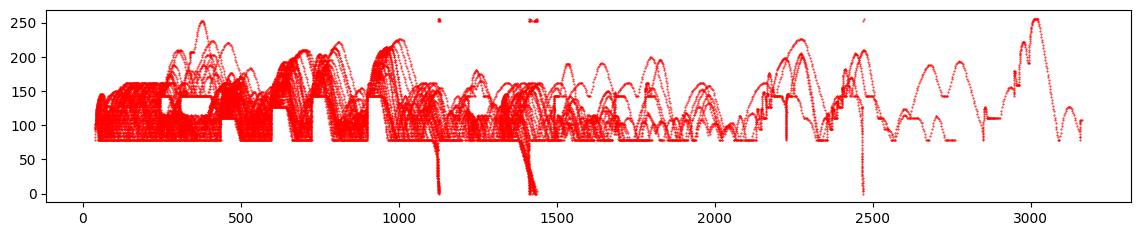

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,2.5))
plt.scatter(x,y, s=0.2, c='r')